## Bayesian Neural Networks
This notebook is a PyTorch implementation of a one-layer Bayesian Neural Network using Gaussian Prior on weights with known mean and variance and an unknown Gaussian variational posterior. It is based on [this](https://davidstutz.de/a-short-introduction-to-bayesian-neural-networks/) excellent short tutorial on Bayesian Neural Networks. 

In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import numpy as np
import scipy
import skimage
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io as skio
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

Set the configuration variables

In [2]:
batchsize = 4
prior_mu = torch.tensor([0]).float()
prior_sigma = torch.tensor([1]).float()
in_features = int(28*28)
out_features = 10
numEpochs = 5
numWorkers = 2

Set dataloader

In [3]:

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))
                       ])),
        batch_size=batchsize, shuffle=True, num_workers=numWorkers)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))
    ])),
    batch_size=batchsize, shuffle=False, num_workers=numWorkers)

N = int(len(train_loader)*batchsize)

## Reparametrization Trick
Reparametrization trick for Variational Inference similar to VAE [[Link]](https://arxiv.org/abs/1312.6114). Helps with backpropagation through a sampling process.

In [4]:
def reparametrize(mu, var, sampling=True):
    if sampling:
        std = torch.sqrt(var)
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return mu + eps * std
    else:
        return mu #if not sampling, then return the variational posterior mean

Define the network

In [5]:
#One layer Bayesian Neural Network
class LinearGaussian(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearGaussian, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.post_mu = nn.Parameter(torch.zeros((out_features,in_features))+0.8)
        self.post_var = nn.Parameter(torch.zeros((out_features,in_features))+1.1)
        self.sampling = True
    def forward(self,x):
        x = x.view(-1,self.in_features)
        post_wts = reparametrize(self.post_mu,self.post_var,self.sampling)
        y = F.linear(x,post_wts,bias=None)
        return y
    


## KL-Divergence
Calculate the KL-Divergence between the gaussian prior and gaussian variational posterior. Refer to this paper for the derivation [[Link]](https://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks).<br><br>
$KL(q_{\phi}(\textbf{w})|p(\textbf{w})) = \sum_{i=1}^{W}{ln(\frac{\sigma_{prior}}{\sigma_i}}) + \frac{1}{\sigma_{prior}^{2}}[(\mu_i - \mu_{prior})^2 + \sigma_i^2 - \sigma_{prior}^2]$ <br><br>


In [6]:
def KL_Divergence(mu,var): #For gaussian prior and gaussian posterior
    term_1 = torch.log(prior_sigma/torch.sqrt(var))
    term_2a = 1/(2*(prior_sigma**2))
    term_2b = (mu-prior_mu)**2
    term_2c = var-(prior_sigma**2)
    term_2 = term_2a*(term_2b + term_2c)
    term_KL = term_1 + term_2
    return torch.sum(term_KL)

## Total loss used for training <br>
$L(\phi) = -\mathbb{E}q_{\phi}[ln(P(\mathcal{D}|\textbf{w}))] + KL(q_{\phi}(\textbf{w})|p(\textbf{w}))$<br><br>
$-\mathbb{E}q_{\phi}[ln(P(\mathcal{D}|\textbf{w}))]$ --> is the data loss -- cross-entropy loss for classification and scaled MSE for regression. The loss is calculated for a sample of $\textbf{w}$ from the $q_{\phi}(\textbf{w})$ obtained using the reparametrization trick. Although one weight sample from $q_{\phi}(\textbf{w})$ is used here, more can also be used. Here $\phi$ is the set of parameters for the variational posterior which in this case is the mean and variance for each weight. Check this tutorial out for more detail on this [[Link]](https://davidstutz.de/a-short-introduction-to-bayesian-neural-networks/).

In [7]:
lg = LinearGaussian(in_features,out_features)

In [8]:
optimizer = optim.Adam(lg.parameters())
data_error = nn.CrossEntropyLoss()

In [9]:
train_kl = []
train_data = []
train_tot = []

In [10]:
def test(model, test_loader, sampling):
    model.eval()
    model.sampling = sampling 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += data_error(output, target).item()  # sum up batch loss
            pred = F.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.2f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [11]:
lg.train()
for epochs in range(numEpochs):
    iter = 0
    for X_train, Y_train in train_loader:
        iter += 1
        out = lg(X_train)
        optimizer.zero_grad()
        data_loss = data_error(out,Y_train)
        KL = (1/(1e-2*N))*KL_Divergence(lg.post_mu,lg.post_var)
        loss = data_loss + (KL)
        loss.backward()
        optimizer.step()
        train_kl.append(KL.item())
        train_data.append(data_loss.item())
        train_tot.append(loss.item())
        print('Epoch: '+str(epochs)+', Iterations: '+str(iter))
        print('Total Loss: '+str(loss.item()))

Epoch: 0, Iterations: 1
Total Loss: 65.54197692871094
Epoch: 0, Iterations: 2
Total Loss: 52.62430191040039
Epoch: 0, Iterations: 3
Total Loss: 38.37355041503906
Epoch: 0, Iterations: 4
Total Loss: 45.743263244628906
Epoch: 0, Iterations: 5
Total Loss: 67.89534759521484
Epoch: 0, Iterations: 6
Total Loss: 14.815927505493164
Epoch: 0, Iterations: 7
Total Loss: 66.62552642822266
Epoch: 0, Iterations: 8
Total Loss: 43.798160552978516
Epoch: 0, Iterations: 9
Total Loss: 54.88755798339844
Epoch: 0, Iterations: 10
Total Loss: 23.700626373291016
Epoch: 0, Iterations: 11
Total Loss: 43.51899337768555
Epoch: 0, Iterations: 12
Total Loss: 52.50844955444336
Epoch: 0, Iterations: 13
Total Loss: 60.54158020019531
Epoch: 0, Iterations: 14
Total Loss: 75.32501983642578
Epoch: 0, Iterations: 15
Total Loss: 58.66715621948242
Epoch: 0, Iterations: 16
Total Loss: 28.887975692749023
Epoch: 0, Iterations: 17
Total Loss: 51.39801788330078
Epoch: 0, Iterations: 18
Total Loss: 40.38068389892578
Epoch: 0, Iter

Epoch: 0, Iterations: 212
Total Loss: 36.80653762817383
Epoch: 0, Iterations: 213
Total Loss: 49.2403450012207
Epoch: 0, Iterations: 214
Total Loss: 22.587862014770508
Epoch: 0, Iterations: 215
Total Loss: 22.187618255615234
Epoch: 0, Iterations: 216
Total Loss: 52.549076080322266
Epoch: 0, Iterations: 217
Total Loss: 48.82819366455078
Epoch: 0, Iterations: 218
Total Loss: 40.48281478881836
Epoch: 0, Iterations: 219
Total Loss: 50.69471740722656
Epoch: 0, Iterations: 220
Total Loss: 28.677438735961914
Epoch: 0, Iterations: 221
Total Loss: 53.0265998840332
Epoch: 0, Iterations: 222
Total Loss: 53.14753341674805
Epoch: 0, Iterations: 223
Total Loss: 45.50700759887695
Epoch: 0, Iterations: 224
Total Loss: 32.88883972167969
Epoch: 0, Iterations: 225
Total Loss: 63.533504486083984
Epoch: 0, Iterations: 226
Total Loss: 24.528039932250977
Epoch: 0, Iterations: 227
Total Loss: 38.207645416259766
Epoch: 0, Iterations: 228
Total Loss: 60.47456741333008
Epoch: 0, Iterations: 229
Total Loss: 35.09

Epoch: 0, Iterations: 416
Total Loss: 35.561824798583984
Epoch: 0, Iterations: 417
Total Loss: 50.102142333984375
Epoch: 0, Iterations: 418
Total Loss: 45.090171813964844
Epoch: 0, Iterations: 419
Total Loss: 40.90817642211914
Epoch: 0, Iterations: 420
Total Loss: 33.61708068847656
Epoch: 0, Iterations: 421
Total Loss: 42.241973876953125
Epoch: 0, Iterations: 422
Total Loss: 25.56659698486328
Epoch: 0, Iterations: 423
Total Loss: 40.26437759399414
Epoch: 0, Iterations: 424
Total Loss: 11.421106338500977
Epoch: 0, Iterations: 425
Total Loss: 20.195232391357422
Epoch: 0, Iterations: 426
Total Loss: 30.010116577148438
Epoch: 0, Iterations: 427
Total Loss: 31.142379760742188
Epoch: 0, Iterations: 428
Total Loss: 24.53510284423828
Epoch: 0, Iterations: 429
Total Loss: 64.71025848388672
Epoch: 0, Iterations: 430
Total Loss: 52.54949951171875
Epoch: 0, Iterations: 431
Total Loss: 21.806747436523438
Epoch: 0, Iterations: 432
Total Loss: 34.419925689697266
Epoch: 0, Iterations: 433
Total Loss: 

Epoch: 0, Iterations: 626
Total Loss: 28.326034545898438
Epoch: 0, Iterations: 627
Total Loss: 31.149120330810547
Epoch: 0, Iterations: 628
Total Loss: 25.435169219970703
Epoch: 0, Iterations: 629
Total Loss: 37.8122673034668
Epoch: 0, Iterations: 630
Total Loss: 48.801918029785156
Epoch: 0, Iterations: 631
Total Loss: 53.61939239501953
Epoch: 0, Iterations: 632
Total Loss: 23.285799026489258
Epoch: 0, Iterations: 633
Total Loss: 19.111343383789062
Epoch: 0, Iterations: 634
Total Loss: 43.36978530883789
Epoch: 0, Iterations: 635
Total Loss: 44.11063003540039
Epoch: 0, Iterations: 636
Total Loss: 28.379615783691406
Epoch: 0, Iterations: 637
Total Loss: 39.040489196777344
Epoch: 0, Iterations: 638
Total Loss: 55.94736862182617
Epoch: 0, Iterations: 639
Total Loss: 29.756010055541992
Epoch: 0, Iterations: 640
Total Loss: 74.42652130126953
Epoch: 0, Iterations: 641
Total Loss: 46.15980529785156
Epoch: 0, Iterations: 642
Total Loss: 69.8225326538086
Epoch: 0, Iterations: 643
Total Loss: 24.

Epoch: 0, Iterations: 836
Total Loss: 45.09566879272461
Epoch: 0, Iterations: 837
Total Loss: 15.159317016601562
Epoch: 0, Iterations: 838
Total Loss: 6.9609856605529785
Epoch: 0, Iterations: 839
Total Loss: 20.605819702148438
Epoch: 0, Iterations: 840
Total Loss: 48.10194778442383
Epoch: 0, Iterations: 841
Total Loss: 35.23603820800781
Epoch: 0, Iterations: 842
Total Loss: 37.59667205810547
Epoch: 0, Iterations: 843
Total Loss: 19.90023422241211
Epoch: 0, Iterations: 844
Total Loss: 24.432470321655273
Epoch: 0, Iterations: 845
Total Loss: 19.65094757080078
Epoch: 0, Iterations: 846
Total Loss: 32.05389404296875
Epoch: 0, Iterations: 847
Total Loss: 17.97687530517578
Epoch: 0, Iterations: 848
Total Loss: 23.372953414916992
Epoch: 0, Iterations: 849
Total Loss: 23.651042938232422
Epoch: 0, Iterations: 850
Total Loss: 30.329055786132812
Epoch: 0, Iterations: 851
Total Loss: 31.46174430847168
Epoch: 0, Iterations: 852
Total Loss: 12.074499130249023
Epoch: 0, Iterations: 853
Total Loss: 24

Epoch: 0, Iterations: 1051
Total Loss: 13.922399520874023
Epoch: 0, Iterations: 1052
Total Loss: 29.489913940429688
Epoch: 0, Iterations: 1053
Total Loss: 20.31031036376953
Epoch: 0, Iterations: 1054
Total Loss: 34.22208786010742
Epoch: 0, Iterations: 1055
Total Loss: 15.099271774291992
Epoch: 0, Iterations: 1056
Total Loss: 46.877384185791016
Epoch: 0, Iterations: 1057
Total Loss: 28.7785587310791
Epoch: 0, Iterations: 1058
Total Loss: 23.40559959411621
Epoch: 0, Iterations: 1059
Total Loss: 12.915962219238281
Epoch: 0, Iterations: 1060
Total Loss: 13.045446395874023
Epoch: 0, Iterations: 1061
Total Loss: 47.30191421508789
Epoch: 0, Iterations: 1062
Total Loss: 41.96006774902344
Epoch: 0, Iterations: 1063
Total Loss: 39.65460968017578
Epoch: 0, Iterations: 1064
Total Loss: 26.036054611206055
Epoch: 0, Iterations: 1065
Total Loss: 20.527545928955078
Epoch: 0, Iterations: 1066
Total Loss: 17.005859375
Epoch: 0, Iterations: 1067
Total Loss: 14.038806915283203
Epoch: 0, Iterations: 1068
T

Total Loss: 23.72987174987793
Epoch: 0, Iterations: 1258
Total Loss: 30.697002410888672
Epoch: 0, Iterations: 1259
Total Loss: 20.666358947753906
Epoch: 0, Iterations: 1260
Total Loss: 16.06505012512207
Epoch: 0, Iterations: 1261
Total Loss: 17.627185821533203
Epoch: 0, Iterations: 1262
Total Loss: 18.350011825561523
Epoch: 0, Iterations: 1263
Total Loss: 17.573383331298828
Epoch: 0, Iterations: 1264
Total Loss: 29.521512985229492
Epoch: 0, Iterations: 1265
Total Loss: 33.547157287597656
Epoch: 0, Iterations: 1266
Total Loss: 20.091259002685547
Epoch: 0, Iterations: 1267
Total Loss: 6.754175186157227
Epoch: 0, Iterations: 1268
Total Loss: 8.893077850341797
Epoch: 0, Iterations: 1269
Total Loss: 18.587078094482422
Epoch: 0, Iterations: 1270
Total Loss: 31.92930793762207
Epoch: 0, Iterations: 1271
Total Loss: 4.024715900421143
Epoch: 0, Iterations: 1272
Total Loss: 25.780160903930664
Epoch: 0, Iterations: 1273
Total Loss: 7.717405319213867
Epoch: 0, Iterations: 1274
Total Loss: 37.686004

Epoch: 0, Iterations: 1452
Total Loss: 4.018523693084717
Epoch: 0, Iterations: 1453
Total Loss: 29.39139175415039
Epoch: 0, Iterations: 1454
Total Loss: 21.413734436035156
Epoch: 0, Iterations: 1455
Total Loss: 60.066429138183594
Epoch: 0, Iterations: 1456
Total Loss: 15.398189544677734
Epoch: 0, Iterations: 1457
Total Loss: 32.289833068847656
Epoch: 0, Iterations: 1458
Total Loss: 50.766273498535156
Epoch: 0, Iterations: 1459
Total Loss: 38.76488494873047
Epoch: 0, Iterations: 1460
Total Loss: 24.44969940185547
Epoch: 0, Iterations: 1461
Total Loss: 49.417808532714844
Epoch: 0, Iterations: 1462
Total Loss: 8.42654800415039
Epoch: 0, Iterations: 1463
Total Loss: 23.192272186279297
Epoch: 0, Iterations: 1464
Total Loss: 14.793214797973633
Epoch: 0, Iterations: 1465
Total Loss: 31.386388778686523
Epoch: 0, Iterations: 1466
Total Loss: 10.808597564697266
Epoch: 0, Iterations: 1467
Total Loss: 7.2828545570373535
Epoch: 0, Iterations: 1468
Total Loss: 27.310068130493164
Epoch: 0, Iterations

Epoch: 0, Iterations: 1663
Total Loss: 26.85986328125
Epoch: 0, Iterations: 1664
Total Loss: 15.247198104858398
Epoch: 0, Iterations: 1665
Total Loss: 27.540672302246094
Epoch: 0, Iterations: 1666
Total Loss: 33.1038818359375
Epoch: 0, Iterations: 1667
Total Loss: 22.540340423583984
Epoch: 0, Iterations: 1668
Total Loss: 22.282482147216797
Epoch: 0, Iterations: 1669
Total Loss: 15.77083969116211
Epoch: 0, Iterations: 1670
Total Loss: 34.374351501464844
Epoch: 0, Iterations: 1671
Total Loss: 12.548612594604492
Epoch: 0, Iterations: 1672
Total Loss: 19.314281463623047
Epoch: 0, Iterations: 1673
Total Loss: 23.874364852905273
Epoch: 0, Iterations: 1674
Total Loss: 24.26563262939453
Epoch: 0, Iterations: 1675
Total Loss: 15.7610502243042
Epoch: 0, Iterations: 1676
Total Loss: 18.29706382751465
Epoch: 0, Iterations: 1677
Total Loss: 6.9481000900268555
Epoch: 0, Iterations: 1678
Total Loss: 63.59896469116211
Epoch: 0, Iterations: 1679
Total Loss: 16.597064971923828
Epoch: 0, Iterations: 1680

Epoch: 0, Iterations: 1869
Total Loss: 3.9765853881835938
Epoch: 0, Iterations: 1870
Total Loss: 14.611897468566895
Epoch: 0, Iterations: 1871
Total Loss: 36.084598541259766
Epoch: 0, Iterations: 1872
Total Loss: 19.63260269165039
Epoch: 0, Iterations: 1873
Total Loss: 8.739524841308594
Epoch: 0, Iterations: 1874
Total Loss: 28.577789306640625
Epoch: 0, Iterations: 1875
Total Loss: 20.152433395385742
Epoch: 0, Iterations: 1876
Total Loss: 21.464618682861328
Epoch: 0, Iterations: 1877
Total Loss: 3.984590530395508
Epoch: 0, Iterations: 1878
Total Loss: 19.627365112304688
Epoch: 0, Iterations: 1879
Total Loss: 29.13404083251953
Epoch: 0, Iterations: 1880
Total Loss: 15.716052055358887
Epoch: 0, Iterations: 1881
Total Loss: 38.37178421020508
Epoch: 0, Iterations: 1882
Total Loss: 24.538097381591797
Epoch: 0, Iterations: 1883
Total Loss: 20.463916778564453
Epoch: 0, Iterations: 1884
Total Loss: 18.79404067993164
Epoch: 0, Iterations: 1885
Total Loss: 18.998910903930664
Epoch: 0, Iterations

Epoch: 0, Iterations: 2062
Total Loss: 18.241901397705078
Epoch: 0, Iterations: 2063
Total Loss: 22.9749698638916
Epoch: 0, Iterations: 2064
Total Loss: 16.47745704650879
Epoch: 0, Iterations: 2065
Total Loss: 27.12779998779297
Epoch: 0, Iterations: 2066
Total Loss: 12.0654296875
Epoch: 0, Iterations: 2067
Total Loss: 14.65539836883545
Epoch: 0, Iterations: 2068
Total Loss: 9.241239547729492
Epoch: 0, Iterations: 2069
Total Loss: 59.23417663574219
Epoch: 0, Iterations: 2070
Total Loss: 18.95079231262207
Epoch: 0, Iterations: 2071
Total Loss: 19.568313598632812
Epoch: 0, Iterations: 2072
Total Loss: 40.75674057006836
Epoch: 0, Iterations: 2073
Total Loss: 13.120615005493164
Epoch: 0, Iterations: 2074
Total Loss: 38.88829803466797
Epoch: 0, Iterations: 2075
Total Loss: 33.97614669799805
Epoch: 0, Iterations: 2076
Total Loss: 9.671272277832031
Epoch: 0, Iterations: 2077
Total Loss: 20.9731502532959
Epoch: 0, Iterations: 2078
Total Loss: 24.414505004882812
Epoch: 0, Iterations: 2079
Total 

Total Loss: 7.628625869750977
Epoch: 0, Iterations: 2252
Total Loss: 17.85956382751465
Epoch: 0, Iterations: 2253
Total Loss: 12.795879364013672
Epoch: 0, Iterations: 2254
Total Loss: 10.822471618652344
Epoch: 0, Iterations: 2255
Total Loss: 13.330862045288086
Epoch: 0, Iterations: 2256
Total Loss: 22.83254051208496
Epoch: 0, Iterations: 2257
Total Loss: 10.552553176879883
Epoch: 0, Iterations: 2258
Total Loss: 39.81689453125
Epoch: 0, Iterations: 2259
Total Loss: 34.71040725708008
Epoch: 0, Iterations: 2260
Total Loss: 18.219568252563477
Epoch: 0, Iterations: 2261
Total Loss: 38.5449333190918
Epoch: 0, Iterations: 2262
Total Loss: 29.682504653930664
Epoch: 0, Iterations: 2263
Total Loss: 3.9495768547058105
Epoch: 0, Iterations: 2264
Total Loss: 7.610508918762207
Epoch: 0, Iterations: 2265
Total Loss: 14.244963645935059
Epoch: 0, Iterations: 2266
Total Loss: 15.883798599243164
Epoch: 0, Iterations: 2267
Total Loss: 3.9492928981781006
Epoch: 0, Iterations: 2268
Total Loss: 15.8540124893

Epoch: 0, Iterations: 2468
Total Loss: 39.185909271240234
Epoch: 0, Iterations: 2469
Total Loss: 3.935739278793335
Epoch: 0, Iterations: 2470
Total Loss: 7.291413307189941
Epoch: 0, Iterations: 2471
Total Loss: 7.521853923797607
Epoch: 0, Iterations: 2472
Total Loss: 6.893573760986328
Epoch: 0, Iterations: 2473
Total Loss: 27.063142776489258
Epoch: 0, Iterations: 2474
Total Loss: 17.627025604248047
Epoch: 0, Iterations: 2475
Total Loss: 26.360729217529297
Epoch: 0, Iterations: 2476
Total Loss: 5.09269905090332
Epoch: 0, Iterations: 2477
Total Loss: 11.449884414672852
Epoch: 0, Iterations: 2478
Total Loss: 19.877872467041016
Epoch: 0, Iterations: 2479
Total Loss: 21.062318801879883
Epoch: 0, Iterations: 2480
Total Loss: 22.597270965576172
Epoch: 0, Iterations: 2481
Total Loss: 41.83533477783203
Epoch: 0, Iterations: 2482
Total Loss: 25.824100494384766
Epoch: 0, Iterations: 2483
Total Loss: 9.898857116699219
Epoch: 0, Iterations: 2484
Total Loss: 32.879085540771484
Epoch: 0, Iterations: 

Epoch: 0, Iterations: 2664
Total Loss: 3.9213578701019287
Epoch: 0, Iterations: 2665
Total Loss: 12.176931381225586
Epoch: 0, Iterations: 2666
Total Loss: 39.31895065307617
Epoch: 0, Iterations: 2667
Total Loss: 53.40138244628906
Epoch: 0, Iterations: 2668
Total Loss: 7.579198837280273
Epoch: 0, Iterations: 2669
Total Loss: 40.95695114135742
Epoch: 0, Iterations: 2670
Total Loss: 7.322103023529053
Epoch: 0, Iterations: 2671
Total Loss: 15.836908340454102
Epoch: 0, Iterations: 2672
Total Loss: 14.594369888305664
Epoch: 0, Iterations: 2673
Total Loss: 9.822027206420898
Epoch: 0, Iterations: 2674
Total Loss: 6.699812889099121
Epoch: 0, Iterations: 2675
Total Loss: 52.005924224853516
Epoch: 0, Iterations: 2676
Total Loss: 20.884258270263672
Epoch: 0, Iterations: 2677
Total Loss: 23.822839736938477
Epoch: 0, Iterations: 2678
Total Loss: 10.343111038208008
Epoch: 0, Iterations: 2679
Total Loss: 6.05339241027832
Epoch: 0, Iterations: 2680
Total Loss: 14.965517044067383
Epoch: 0, Iterations: 2

Epoch: 0, Iterations: 2879
Total Loss: 26.612817764282227
Epoch: 0, Iterations: 2880
Total Loss: 12.548721313476562
Epoch: 0, Iterations: 2881
Total Loss: 4.079080581665039
Epoch: 0, Iterations: 2882
Total Loss: 10.673818588256836
Epoch: 0, Iterations: 2883
Total Loss: 34.518272399902344
Epoch: 0, Iterations: 2884
Total Loss: 13.71994400024414
Epoch: 0, Iterations: 2885
Total Loss: 23.4031982421875
Epoch: 0, Iterations: 2886
Total Loss: 31.296051025390625
Epoch: 0, Iterations: 2887
Total Loss: 16.177255630493164
Epoch: 0, Iterations: 2888
Total Loss: 23.082115173339844
Epoch: 0, Iterations: 2889
Total Loss: 19.608495712280273
Epoch: 0, Iterations: 2890
Total Loss: 5.513504981994629
Epoch: 0, Iterations: 2891
Total Loss: 31.344560623168945
Epoch: 0, Iterations: 2892
Total Loss: 3.90228271484375
Epoch: 0, Iterations: 2893
Total Loss: 21.814924240112305
Epoch: 0, Iterations: 2894
Total Loss: 5.480379104614258
Epoch: 0, Iterations: 2895
Total Loss: 44.44794464111328
Epoch: 0, Iterations: 2

Epoch: 0, Iterations: 3095
Total Loss: 5.65643835067749
Epoch: 0, Iterations: 3096
Total Loss: 13.470609664916992
Epoch: 0, Iterations: 3097
Total Loss: 7.427725791931152
Epoch: 0, Iterations: 3098
Total Loss: 9.855649948120117
Epoch: 0, Iterations: 3099
Total Loss: 16.148895263671875
Epoch: 0, Iterations: 3100
Total Loss: 26.91904067993164
Epoch: 0, Iterations: 3101
Total Loss: 8.529139518737793
Epoch: 0, Iterations: 3102
Total Loss: 13.261146545410156
Epoch: 0, Iterations: 3103
Total Loss: 31.955902099609375
Epoch: 0, Iterations: 3104
Total Loss: 13.661375045776367
Epoch: 0, Iterations: 3105
Total Loss: 43.949031829833984
Epoch: 0, Iterations: 3106
Total Loss: 3.890737295150757
Epoch: 0, Iterations: 3107
Total Loss: 24.074045181274414
Epoch: 0, Iterations: 3108
Total Loss: 5.3669753074646
Epoch: 0, Iterations: 3109
Total Loss: 29.741832733154297
Epoch: 0, Iterations: 3110
Total Loss: 7.919214248657227
Epoch: 0, Iterations: 3111
Total Loss: 34.94813537597656
Epoch: 0, Iterations: 3112

Epoch: 0, Iterations: 3300
Total Loss: 22.438325881958008
Epoch: 0, Iterations: 3301
Total Loss: 16.255937576293945
Epoch: 0, Iterations: 3302
Total Loss: 11.810633659362793
Epoch: 0, Iterations: 3303
Total Loss: 9.570290565490723
Epoch: 0, Iterations: 3304
Total Loss: 32.483787536621094
Epoch: 0, Iterations: 3305
Total Loss: 5.405815124511719
Epoch: 0, Iterations: 3306
Total Loss: 16.477596282958984
Epoch: 0, Iterations: 3307
Total Loss: 38.88141632080078
Epoch: 0, Iterations: 3308
Total Loss: 33.8609619140625
Epoch: 0, Iterations: 3309
Total Loss: 10.82303237915039
Epoch: 0, Iterations: 3310
Total Loss: 11.182490348815918
Epoch: 0, Iterations: 3311
Total Loss: 17.938201904296875
Epoch: 0, Iterations: 3312
Total Loss: 3.8754525184631348
Epoch: 0, Iterations: 3313
Total Loss: 3.875382661819458
Epoch: 0, Iterations: 3314
Total Loss: 21.084074020385742
Epoch: 0, Iterations: 3315
Total Loss: 8.392266273498535
Epoch: 0, Iterations: 3316
Total Loss: 3.8752119541168213
Epoch: 0, Iterations: 

Epoch: 0, Iterations: 3509
Total Loss: 11.358652114868164
Epoch: 0, Iterations: 3510
Total Loss: 38.63777160644531
Epoch: 0, Iterations: 3511
Total Loss: 26.698034286499023
Epoch: 0, Iterations: 3512
Total Loss: 8.763736724853516
Epoch: 0, Iterations: 3513
Total Loss: 12.200356483459473
Epoch: 0, Iterations: 3514
Total Loss: 3.8598504066467285
Epoch: 0, Iterations: 3515
Total Loss: 3.8826487064361572
Epoch: 0, Iterations: 3516
Total Loss: 3.859720468521118
Epoch: 0, Iterations: 3517
Total Loss: 8.575801849365234
Epoch: 0, Iterations: 3518
Total Loss: 10.502209663391113
Epoch: 0, Iterations: 3519
Total Loss: 31.205211639404297
Epoch: 0, Iterations: 3520
Total Loss: 3.859412670135498
Epoch: 0, Iterations: 3521
Total Loss: 11.466371536254883
Epoch: 0, Iterations: 3522
Total Loss: 27.711261749267578
Epoch: 0, Iterations: 3523
Total Loss: 3.8742499351501465
Epoch: 0, Iterations: 3524
Total Loss: 5.8580522537231445
Epoch: 0, Iterations: 3525
Total Loss: 27.565298080444336
Epoch: 0, Iteration

Epoch: 0, Iterations: 3712
Total Loss: 31.72214126586914
Epoch: 0, Iterations: 3713
Total Loss: 6.389254093170166
Epoch: 0, Iterations: 3714
Total Loss: 3.8594655990600586
Epoch: 0, Iterations: 3715
Total Loss: 7.815619468688965
Epoch: 0, Iterations: 3716
Total Loss: 33.232112884521484
Epoch: 0, Iterations: 3717
Total Loss: 26.522796630859375
Epoch: 0, Iterations: 3718
Total Loss: 7.757185935974121
Epoch: 0, Iterations: 3719
Total Loss: 3.8432199954986572
Epoch: 0, Iterations: 3720
Total Loss: 26.532169342041016
Epoch: 0, Iterations: 3721
Total Loss: 17.517019271850586
Epoch: 0, Iterations: 3722
Total Loss: 3.847982168197632
Epoch: 0, Iterations: 3723
Total Loss: 3.8431320190429688
Epoch: 0, Iterations: 3724
Total Loss: 33.02470397949219
Epoch: 0, Iterations: 3725
Total Loss: 26.732145309448242
Epoch: 0, Iterations: 3726
Total Loss: 16.564836502075195
Epoch: 0, Iterations: 3727
Total Loss: 23.59603500366211
Epoch: 0, Iterations: 3728
Total Loss: 6.739985466003418
Epoch: 0, Iterations: 

Epoch: 0, Iterations: 3906
Total Loss: 23.258502960205078
Epoch: 0, Iterations: 3907
Total Loss: 23.274141311645508
Epoch: 0, Iterations: 3908
Total Loss: 24.321792602539062
Epoch: 0, Iterations: 3909
Total Loss: 15.318705558776855
Epoch: 0, Iterations: 3910
Total Loss: 15.18478775024414
Epoch: 0, Iterations: 3911
Total Loss: 10.773719787597656
Epoch: 0, Iterations: 3912
Total Loss: 10.031534194946289
Epoch: 0, Iterations: 3913
Total Loss: 13.617993354797363
Epoch: 0, Iterations: 3914
Total Loss: 29.45071029663086
Epoch: 0, Iterations: 3915
Total Loss: 16.931541442871094
Epoch: 0, Iterations: 3916
Total Loss: 29.977209091186523
Epoch: 0, Iterations: 3917
Total Loss: 32.21388626098633
Epoch: 0, Iterations: 3918
Total Loss: 11.846920013427734
Epoch: 0, Iterations: 3919
Total Loss: 8.381195068359375
Epoch: 0, Iterations: 3920
Total Loss: 3.8334856033325195
Epoch: 0, Iterations: 3921
Total Loss: 22.79478645324707
Epoch: 0, Iterations: 3922
Total Loss: 5.5383195877075195
Epoch: 0, Iteration

Epoch: 0, Iterations: 4102
Total Loss: 37.8211555480957
Epoch: 0, Iterations: 4103
Total Loss: 28.535139083862305
Epoch: 0, Iterations: 4104
Total Loss: 14.069048881530762
Epoch: 0, Iterations: 4105
Total Loss: 54.89788818359375
Epoch: 0, Iterations: 4106
Total Loss: 10.574649810791016
Epoch: 0, Iterations: 4107
Total Loss: 37.57074737548828
Epoch: 0, Iterations: 4108
Total Loss: 20.140905380249023
Epoch: 0, Iterations: 4109
Total Loss: 28.81836700439453
Epoch: 0, Iterations: 4110
Total Loss: 5.484003067016602
Epoch: 0, Iterations: 4111
Total Loss: 17.434051513671875
Epoch: 0, Iterations: 4112
Total Loss: 4.892592906951904
Epoch: 0, Iterations: 4113
Total Loss: 8.679106712341309
Epoch: 0, Iterations: 4114
Total Loss: 13.327841758728027
Epoch: 0, Iterations: 4115
Total Loss: 12.997034072875977
Epoch: 0, Iterations: 4116
Total Loss: 27.559457778930664
Epoch: 0, Iterations: 4117
Total Loss: 29.941864013671875
Epoch: 0, Iterations: 4118
Total Loss: 21.771381378173828
Epoch: 0, Iterations: 

Epoch: 0, Iterations: 4284
Total Loss: 16.978656768798828
Epoch: 0, Iterations: 4285
Total Loss: 36.730628967285156
Epoch: 0, Iterations: 4286
Total Loss: 23.169301986694336
Epoch: 0, Iterations: 4287
Total Loss: 18.555870056152344
Epoch: 0, Iterations: 4288
Total Loss: 14.36181640625
Epoch: 0, Iterations: 4289
Total Loss: 19.102724075317383
Epoch: 0, Iterations: 4290
Total Loss: 25.693824768066406
Epoch: 0, Iterations: 4291
Total Loss: 12.995915412902832
Epoch: 0, Iterations: 4292
Total Loss: 3.8098888397216797
Epoch: 0, Iterations: 4293
Total Loss: 22.0751953125
Epoch: 0, Iterations: 4294
Total Loss: 29.42670249938965
Epoch: 0, Iterations: 4295
Total Loss: 4.586941242218018
Epoch: 0, Iterations: 4296
Total Loss: 13.182217597961426
Epoch: 0, Iterations: 4297
Total Loss: 10.506217002868652
Epoch: 0, Iterations: 4298
Total Loss: 7.121596336364746
Epoch: 0, Iterations: 4299
Total Loss: 15.522139549255371
Epoch: 0, Iterations: 4300
Total Loss: 29.813575744628906
Epoch: 0, Iterations: 4301

Epoch: 0, Iterations: 4473
Total Loss: 3.8403701782226562
Epoch: 0, Iterations: 4474
Total Loss: 5.887197017669678
Epoch: 0, Iterations: 4475
Total Loss: 16.67396354675293
Epoch: 0, Iterations: 4476
Total Loss: 19.85332679748535
Epoch: 0, Iterations: 4477
Total Loss: 32.70896530151367
Epoch: 0, Iterations: 4478
Total Loss: 3.790987491607666
Epoch: 0, Iterations: 4479
Total Loss: 4.98450231552124
Epoch: 0, Iterations: 4480
Total Loss: 7.860703945159912
Epoch: 0, Iterations: 4481
Total Loss: 24.480947494506836
Epoch: 0, Iterations: 4482
Total Loss: 30.389198303222656
Epoch: 0, Iterations: 4483
Total Loss: 12.939720153808594
Epoch: 0, Iterations: 4484
Total Loss: 8.565746307373047
Epoch: 0, Iterations: 4485
Total Loss: 3.7901217937469482
Epoch: 0, Iterations: 4486
Total Loss: 15.037365913391113
Epoch: 0, Iterations: 4487
Total Loss: 17.734651565551758
Epoch: 0, Iterations: 4488
Total Loss: 16.197961807250977
Epoch: 0, Iterations: 4489
Total Loss: 3.789860963821411
Epoch: 0, Iterations: 44

Epoch: 0, Iterations: 4670
Total Loss: 12.806121826171875
Epoch: 0, Iterations: 4671
Total Loss: 19.854019165039062
Epoch: 0, Iterations: 4672
Total Loss: 5.303219795227051
Epoch: 0, Iterations: 4673
Total Loss: 23.23044204711914
Epoch: 0, Iterations: 4674
Total Loss: 17.00872039794922
Epoch: 0, Iterations: 4675
Total Loss: 23.250822067260742
Epoch: 0, Iterations: 4676
Total Loss: 3.7793521881103516
Epoch: 0, Iterations: 4677
Total Loss: 15.630495071411133
Epoch: 0, Iterations: 4678
Total Loss: 27.501644134521484
Epoch: 0, Iterations: 4679
Total Loss: 12.24594783782959
Epoch: 0, Iterations: 4680
Total Loss: 25.218900680541992
Epoch: 0, Iterations: 4681
Total Loss: 19.101411819458008
Epoch: 0, Iterations: 4682
Total Loss: 11.824250221252441
Epoch: 0, Iterations: 4683
Total Loss: 3.7789416313171387
Epoch: 0, Iterations: 4684
Total Loss: 12.696083068847656
Epoch: 0, Iterations: 4685
Total Loss: 11.155277252197266
Epoch: 0, Iterations: 4686
Total Loss: 11.792696952819824
Epoch: 0, Iteratio

Epoch: 0, Iterations: 4874
Total Loss: 20.231327056884766
Epoch: 0, Iterations: 4875
Total Loss: 20.230268478393555
Epoch: 0, Iterations: 4876
Total Loss: 3.7653911113739014
Epoch: 0, Iterations: 4877
Total Loss: 3.7658398151397705
Epoch: 0, Iterations: 4878
Total Loss: 16.357614517211914
Epoch: 0, Iterations: 4879
Total Loss: 16.58514976501465
Epoch: 0, Iterations: 4880
Total Loss: 5.686153888702393
Epoch: 0, Iterations: 4881
Total Loss: 9.871500015258789
Epoch: 0, Iterations: 4882
Total Loss: 9.722633361816406
Epoch: 0, Iterations: 4883
Total Loss: 17.300865173339844
Epoch: 0, Iterations: 4884
Total Loss: 8.435518264770508
Epoch: 0, Iterations: 4885
Total Loss: 12.605131149291992
Epoch: 0, Iterations: 4886
Total Loss: 6.570583343505859
Epoch: 0, Iterations: 4887
Total Loss: 6.525729179382324
Epoch: 0, Iterations: 4888
Total Loss: 20.92153549194336
Epoch: 0, Iterations: 4889
Total Loss: 53.416038513183594
Epoch: 0, Iterations: 4890
Total Loss: 4.230024814605713
Epoch: 0, Iterations: 4

Epoch: 0, Iterations: 5058
Total Loss: 3.750437021255493
Epoch: 0, Iterations: 5059
Total Loss: 3.750452995300293
Epoch: 0, Iterations: 5060
Total Loss: 3.7502856254577637
Epoch: 0, Iterations: 5061
Total Loss: 3.7644104957580566
Epoch: 0, Iterations: 5062
Total Loss: 31.692188262939453
Epoch: 0, Iterations: 5063
Total Loss: 7.059190273284912
Epoch: 0, Iterations: 5064
Total Loss: 13.716021537780762
Epoch: 0, Iterations: 5065
Total Loss: 12.0389986038208
Epoch: 0, Iterations: 5066
Total Loss: 12.879292488098145
Epoch: 0, Iterations: 5067
Total Loss: 12.099489212036133
Epoch: 0, Iterations: 5068
Total Loss: 5.137304306030273
Epoch: 0, Iterations: 5069
Total Loss: 4.465328693389893
Epoch: 0, Iterations: 5070
Total Loss: 6.047507286071777
Epoch: 0, Iterations: 5071
Total Loss: 21.482521057128906
Epoch: 0, Iterations: 5072
Total Loss: 35.48977279663086
Epoch: 0, Iterations: 5073
Total Loss: 10.270684242248535
Epoch: 0, Iterations: 5074
Total Loss: 7.121544361114502
Epoch: 0, Iterations: 50

Epoch: 0, Iterations: 5254
Total Loss: 13.45634937286377
Epoch: 0, Iterations: 5255
Total Loss: 13.821216583251953
Epoch: 0, Iterations: 5256
Total Loss: 13.581181526184082
Epoch: 0, Iterations: 5257
Total Loss: 3.7329299449920654
Epoch: 0, Iterations: 5258
Total Loss: 23.42068862915039
Epoch: 0, Iterations: 5259
Total Loss: 18.034208297729492
Epoch: 0, Iterations: 5260
Total Loss: 15.456026077270508
Epoch: 0, Iterations: 5261
Total Loss: 20.137773513793945
Epoch: 0, Iterations: 5262
Total Loss: 34.24339294433594
Epoch: 0, Iterations: 5263
Total Loss: 5.10517692565918
Epoch: 0, Iterations: 5264
Total Loss: 23.34056854248047
Epoch: 0, Iterations: 5265
Total Loss: 18.121837615966797
Epoch: 0, Iterations: 5266
Total Loss: 4.8229546546936035
Epoch: 0, Iterations: 5267
Total Loss: 5.84006929397583
Epoch: 0, Iterations: 5268
Total Loss: 3.731797456741333
Epoch: 0, Iterations: 5269
Total Loss: 7.095548629760742
Epoch: 0, Iterations: 5270
Total Loss: 5.358449935913086
Epoch: 0, Iterations: 527

Epoch: 0, Iterations: 5451
Total Loss: 27.675960540771484
Epoch: 0, Iterations: 5452
Total Loss: 8.786563873291016
Epoch: 0, Iterations: 5453
Total Loss: 4.178426265716553
Epoch: 0, Iterations: 5454
Total Loss: 3.7187318801879883
Epoch: 0, Iterations: 5455
Total Loss: 3.7186672687530518
Epoch: 0, Iterations: 5456
Total Loss: 9.065265655517578
Epoch: 0, Iterations: 5457
Total Loss: 7.290471076965332
Epoch: 0, Iterations: 5458
Total Loss: 21.79568862915039
Epoch: 0, Iterations: 5459
Total Loss: 3.7182743549346924
Epoch: 0, Iterations: 5460
Total Loss: 11.710308074951172
Epoch: 0, Iterations: 5461
Total Loss: 3.71891188621521
Epoch: 0, Iterations: 5462
Total Loss: 13.15367317199707
Epoch: 0, Iterations: 5463
Total Loss: 3.7178759574890137
Epoch: 0, Iterations: 5464
Total Loss: 27.50803565979004
Epoch: 0, Iterations: 5465
Total Loss: 15.964385986328125
Epoch: 0, Iterations: 5466
Total Loss: 21.39483642578125
Epoch: 0, Iterations: 5467
Total Loss: 12.214902877807617
Epoch: 0, Iterations: 54

Total Loss: 3.707266092300415
Epoch: 0, Iterations: 5656
Total Loss: 3.707289218902588
Epoch: 0, Iterations: 5657
Total Loss: 4.085609436035156
Epoch: 0, Iterations: 5658
Total Loss: 23.765727996826172
Epoch: 0, Iterations: 5659
Total Loss: 3.706890106201172
Epoch: 0, Iterations: 5660
Total Loss: 3.792389392852783
Epoch: 0, Iterations: 5661
Total Loss: 23.754735946655273
Epoch: 0, Iterations: 5662
Total Loss: 3.7065963745117188
Epoch: 0, Iterations: 5663
Total Loss: 4.692859172821045
Epoch: 0, Iterations: 5664
Total Loss: 22.538875579833984
Epoch: 0, Iterations: 5665
Total Loss: 11.955147743225098
Epoch: 0, Iterations: 5666
Total Loss: 16.119312286376953
Epoch: 0, Iterations: 5667
Total Loss: 9.182156562805176
Epoch: 0, Iterations: 5668
Total Loss: 5.50637674331665
Epoch: 0, Iterations: 5669
Total Loss: 4.970773696899414
Epoch: 0, Iterations: 5670
Total Loss: 12.667037963867188
Epoch: 0, Iterations: 5671
Total Loss: 17.837562561035156
Epoch: 0, Iterations: 5672
Total Loss: 12.619536399

Epoch: 0, Iterations: 5845
Total Loss: 6.310878753662109
Epoch: 0, Iterations: 5846
Total Loss: 20.213214874267578
Epoch: 0, Iterations: 5847
Total Loss: 11.43824577331543
Epoch: 0, Iterations: 5848
Total Loss: 24.63391876220703
Epoch: 0, Iterations: 5849
Total Loss: 34.064456939697266
Epoch: 0, Iterations: 5850
Total Loss: 3.692887544631958
Epoch: 0, Iterations: 5851
Total Loss: 15.545293807983398
Epoch: 0, Iterations: 5852
Total Loss: 21.896072387695312
Epoch: 0, Iterations: 5853
Total Loss: 19.65755271911621
Epoch: 0, Iterations: 5854
Total Loss: 6.269148826599121
Epoch: 0, Iterations: 5855
Total Loss: 3.692340135574341
Epoch: 0, Iterations: 5856
Total Loss: 9.468896865844727
Epoch: 0, Iterations: 5857
Total Loss: 3.6921329498291016
Epoch: 0, Iterations: 5858
Total Loss: 24.280147552490234
Epoch: 0, Iterations: 5859
Total Loss: 10.607999801635742
Epoch: 0, Iterations: 5860
Total Loss: 3.6918461322784424
Epoch: 0, Iterations: 5861
Total Loss: 4.486963272094727
Epoch: 0, Iterations: 5

Epoch: 0, Iterations: 6051
Total Loss: 23.631132125854492
Epoch: 0, Iterations: 6052
Total Loss: 3.674689292907715
Epoch: 0, Iterations: 6053
Total Loss: 23.994632720947266
Epoch: 0, Iterations: 6054
Total Loss: 15.13032341003418
Epoch: 0, Iterations: 6055
Total Loss: 43.01799011230469
Epoch: 0, Iterations: 6056
Total Loss: 13.671797752380371
Epoch: 0, Iterations: 6057
Total Loss: 5.248039722442627
Epoch: 0, Iterations: 6058
Total Loss: 9.725360870361328
Epoch: 0, Iterations: 6059
Total Loss: 21.565126419067383
Epoch: 0, Iterations: 6060
Total Loss: 3.6749162673950195
Epoch: 0, Iterations: 6061
Total Loss: 20.243431091308594
Epoch: 0, Iterations: 6062
Total Loss: 14.380058288574219
Epoch: 0, Iterations: 6063
Total Loss: 33.371578216552734
Epoch: 0, Iterations: 6064
Total Loss: 5.1070876121521
Epoch: 0, Iterations: 6065
Total Loss: 9.952631950378418
Epoch: 0, Iterations: 6066
Total Loss: 3.675494909286499
Epoch: 0, Iterations: 6067
Total Loss: 9.252338409423828
Epoch: 0, Iterations: 606

Epoch: 0, Iterations: 6245
Total Loss: 23.51393699645996
Epoch: 0, Iterations: 6246
Total Loss: 19.888168334960938
Epoch: 0, Iterations: 6247
Total Loss: 12.10585880279541
Epoch: 0, Iterations: 6248
Total Loss: 13.888931274414062
Epoch: 0, Iterations: 6249
Total Loss: 3.661496639251709
Epoch: 0, Iterations: 6250
Total Loss: 33.05751037597656
Epoch: 0, Iterations: 6251
Total Loss: 22.44386863708496
Epoch: 0, Iterations: 6252
Total Loss: 3.672283172607422
Epoch: 0, Iterations: 6253
Total Loss: 13.15683364868164
Epoch: 0, Iterations: 6254
Total Loss: 12.024642944335938
Epoch: 0, Iterations: 6255
Total Loss: 3.6611557006835938
Epoch: 0, Iterations: 6256
Total Loss: 41.3133659362793
Epoch: 0, Iterations: 6257
Total Loss: 3.6612091064453125
Epoch: 0, Iterations: 6258
Total Loss: 13.46169376373291
Epoch: 0, Iterations: 6259
Total Loss: 21.487396240234375
Epoch: 0, Iterations: 6260
Total Loss: 3.6606767177581787
Epoch: 0, Iterations: 6261
Total Loss: 8.369471549987793
Epoch: 0, Iterations: 626

Epoch: 0, Iterations: 6453
Total Loss: 3.6449997425079346
Epoch: 0, Iterations: 6454
Total Loss: 5.2727789878845215
Epoch: 0, Iterations: 6455
Total Loss: 20.30508041381836
Epoch: 0, Iterations: 6456
Total Loss: 27.592172622680664
Epoch: 0, Iterations: 6457
Total Loss: 9.004491806030273
Epoch: 0, Iterations: 6458
Total Loss: 6.424027442932129
Epoch: 0, Iterations: 6459
Total Loss: 3.6447668075561523
Epoch: 0, Iterations: 6460
Total Loss: 12.476614952087402
Epoch: 0, Iterations: 6461
Total Loss: 3.679762363433838
Epoch: 0, Iterations: 6462
Total Loss: 4.120079517364502
Epoch: 0, Iterations: 6463
Total Loss: 5.091854095458984
Epoch: 0, Iterations: 6464
Total Loss: 25.22075080871582
Epoch: 0, Iterations: 6465
Total Loss: 17.40537452697754
Epoch: 0, Iterations: 6466
Total Loss: 7.0514140129089355
Epoch: 0, Iterations: 6467
Total Loss: 5.085939884185791
Epoch: 0, Iterations: 6468
Total Loss: 3.644436836242676
Epoch: 0, Iterations: 6469
Total Loss: 3.655376434326172
Epoch: 0, Iterations: 647

Total Loss: 26.394433975219727
Epoch: 0, Iterations: 6648
Total Loss: 10.056805610656738
Epoch: 0, Iterations: 6649
Total Loss: 6.982029914855957
Epoch: 0, Iterations: 6650
Total Loss: 3.6310532093048096
Epoch: 0, Iterations: 6651
Total Loss: 11.703853607177734
Epoch: 0, Iterations: 6652
Total Loss: 21.52338218688965
Epoch: 0, Iterations: 6653
Total Loss: 11.031153678894043
Epoch: 0, Iterations: 6654
Total Loss: 4.191762924194336
Epoch: 0, Iterations: 6655
Total Loss: 3.6307003498077393
Epoch: 0, Iterations: 6656
Total Loss: 12.073264122009277
Epoch: 0, Iterations: 6657
Total Loss: 3.6328587532043457
Epoch: 0, Iterations: 6658
Total Loss: 21.95651626586914
Epoch: 0, Iterations: 6659
Total Loss: 10.696847915649414
Epoch: 0, Iterations: 6660
Total Loss: 3.6303415298461914
Epoch: 0, Iterations: 6661
Total Loss: 10.55197525024414
Epoch: 0, Iterations: 6662
Total Loss: 3.890932083129883
Epoch: 0, Iterations: 6663
Total Loss: 10.786031723022461
Epoch: 0, Iterations: 6664
Total Loss: 3.632665

Epoch: 0, Iterations: 6859
Total Loss: 4.42917013168335
Epoch: 0, Iterations: 6860
Total Loss: 23.614564895629883
Epoch: 0, Iterations: 6861
Total Loss: 23.860240936279297
Epoch: 0, Iterations: 6862
Total Loss: 3.629619598388672
Epoch: 0, Iterations: 6863
Total Loss: 10.63882827758789
Epoch: 0, Iterations: 6864
Total Loss: 5.597442150115967
Epoch: 0, Iterations: 6865
Total Loss: 3.6136157512664795
Epoch: 0, Iterations: 6866
Total Loss: 3.635359764099121
Epoch: 0, Iterations: 6867
Total Loss: 3.613347053527832
Epoch: 0, Iterations: 6868
Total Loss: 15.25865364074707
Epoch: 0, Iterations: 6869
Total Loss: 28.81637191772461
Epoch: 0, Iterations: 6870
Total Loss: 3.6162939071655273
Epoch: 0, Iterations: 6871
Total Loss: 5.231011867523193
Epoch: 0, Iterations: 6872
Total Loss: 3.612762689590454
Epoch: 0, Iterations: 6873
Total Loss: 22.999095916748047
Epoch: 0, Iterations: 6874
Total Loss: 3.61321759223938
Epoch: 0, Iterations: 6875
Total Loss: 3.6125073432922363
Epoch: 0, Iterations: 6876


Epoch: 0, Iterations: 7070
Total Loss: 4.640469551086426
Epoch: 0, Iterations: 7071
Total Loss: 3.804596185684204
Epoch: 0, Iterations: 7072
Total Loss: 7.008609771728516
Epoch: 0, Iterations: 7073
Total Loss: 8.491705894470215
Epoch: 0, Iterations: 7074
Total Loss: 3.5945820808410645
Epoch: 0, Iterations: 7075
Total Loss: 9.228899955749512
Epoch: 0, Iterations: 7076
Total Loss: 3.596379280090332
Epoch: 0, Iterations: 7077
Total Loss: 8.940261840820312
Epoch: 0, Iterations: 7078
Total Loss: 15.062857627868652
Epoch: 0, Iterations: 7079
Total Loss: 16.933822631835938
Epoch: 0, Iterations: 7080
Total Loss: 4.96611213684082
Epoch: 0, Iterations: 7081
Total Loss: 3.593519449234009
Epoch: 0, Iterations: 7082
Total Loss: 29.4095458984375
Epoch: 0, Iterations: 7083
Total Loss: 24.7706356048584
Epoch: 0, Iterations: 7084
Total Loss: 16.687381744384766
Epoch: 0, Iterations: 7085
Total Loss: 18.108219146728516
Epoch: 0, Iterations: 7086
Total Loss: 9.622184753417969
Epoch: 0, Iterations: 7087
To

Epoch: 0, Iterations: 7265
Total Loss: 29.639684677124023
Epoch: 0, Iterations: 7266
Total Loss: 5.444918632507324
Epoch: 0, Iterations: 7267
Total Loss: 19.231910705566406
Epoch: 0, Iterations: 7268
Total Loss: 26.942609786987305
Epoch: 0, Iterations: 7269
Total Loss: 3.5794575214385986
Epoch: 0, Iterations: 7270
Total Loss: 4.015499591827393
Epoch: 0, Iterations: 7271
Total Loss: 7.840146064758301
Epoch: 0, Iterations: 7272
Total Loss: 20.685653686523438
Epoch: 0, Iterations: 7273
Total Loss: 3.5795979499816895
Epoch: 0, Iterations: 7274
Total Loss: 7.417338848114014
Epoch: 0, Iterations: 7275
Total Loss: 15.886591911315918
Epoch: 0, Iterations: 7276
Total Loss: 6.161566734313965
Epoch: 0, Iterations: 7277
Total Loss: 9.525960922241211
Epoch: 0, Iterations: 7278
Total Loss: 17.2386531829834
Epoch: 0, Iterations: 7279
Total Loss: 8.188520431518555
Epoch: 0, Iterations: 7280
Total Loss: 30.808107376098633
Epoch: 0, Iterations: 7281
Total Loss: 5.233700752258301
Epoch: 0, Iterations: 72

Epoch: 0, Iterations: 7477
Total Loss: 17.182769775390625
Epoch: 0, Iterations: 7478
Total Loss: 11.128410339355469
Epoch: 0, Iterations: 7479
Total Loss: 16.440404891967773
Epoch: 0, Iterations: 7480
Total Loss: 18.176177978515625
Epoch: 0, Iterations: 7481
Total Loss: 6.666074752807617
Epoch: 0, Iterations: 7482
Total Loss: 3.566887617111206
Epoch: 0, Iterations: 7483
Total Loss: 26.599876403808594
Epoch: 0, Iterations: 7484
Total Loss: 5.277524948120117
Epoch: 0, Iterations: 7485
Total Loss: 4.495476245880127
Epoch: 0, Iterations: 7486
Total Loss: 3.566802978515625
Epoch: 0, Iterations: 7487
Total Loss: 43.2205924987793
Epoch: 0, Iterations: 7488
Total Loss: 12.960187911987305
Epoch: 0, Iterations: 7489
Total Loss: 16.783737182617188
Epoch: 0, Iterations: 7490
Total Loss: 8.603761672973633
Epoch: 0, Iterations: 7491
Total Loss: 7.00699520111084
Epoch: 0, Iterations: 7492
Total Loss: 7.728211402893066
Epoch: 0, Iterations: 7493
Total Loss: 34.12662124633789
Epoch: 0, Iterations: 7494

Epoch: 0, Iterations: 7687
Total Loss: 6.400421142578125
Epoch: 0, Iterations: 7688
Total Loss: 28.399093627929688
Epoch: 0, Iterations: 7689
Total Loss: 3.8152718544006348
Epoch: 0, Iterations: 7690
Total Loss: 17.351886749267578
Epoch: 0, Iterations: 7691
Total Loss: 4.120242118835449
Epoch: 0, Iterations: 7692
Total Loss: 6.994524002075195
Epoch: 0, Iterations: 7693
Total Loss: 10.677453994750977
Epoch: 0, Iterations: 7694
Total Loss: 3.550663709640503
Epoch: 0, Iterations: 7695
Total Loss: 6.300838470458984
Epoch: 0, Iterations: 7696
Total Loss: 12.618942260742188
Epoch: 0, Iterations: 7697
Total Loss: 5.703959941864014
Epoch: 0, Iterations: 7698
Total Loss: 3.550179958343506
Epoch: 0, Iterations: 7699
Total Loss: 12.813637733459473
Epoch: 0, Iterations: 7700
Total Loss: 7.620040416717529
Epoch: 0, Iterations: 7701
Total Loss: 19.773395538330078
Epoch: 0, Iterations: 7702
Total Loss: 6.6731367111206055
Epoch: 0, Iterations: 7703
Total Loss: 3.549790859222412
Epoch: 0, Iterations: 7

Epoch: 0, Iterations: 7897
Total Loss: 3.7324860095977783
Epoch: 0, Iterations: 7898
Total Loss: 8.187080383300781
Epoch: 0, Iterations: 7899
Total Loss: 3.533158779144287
Epoch: 0, Iterations: 7900
Total Loss: 12.207344055175781
Epoch: 0, Iterations: 7901
Total Loss: 5.05586051940918
Epoch: 0, Iterations: 7902
Total Loss: 48.61244201660156
Epoch: 0, Iterations: 7903
Total Loss: 3.5327847003936768
Epoch: 0, Iterations: 7904
Total Loss: 6.049465179443359
Epoch: 0, Iterations: 7905
Total Loss: 7.240159511566162
Epoch: 0, Iterations: 7906
Total Loss: 28.846303939819336
Epoch: 0, Iterations: 7907
Total Loss: 4.301976680755615
Epoch: 0, Iterations: 7908
Total Loss: 5.121490478515625
Epoch: 0, Iterations: 7909
Total Loss: 3.5325114727020264
Epoch: 0, Iterations: 7910
Total Loss: 9.44998550415039
Epoch: 0, Iterations: 7911
Total Loss: 15.095355033874512
Epoch: 0, Iterations: 7912
Total Loss: 3.5323243141174316
Epoch: 0, Iterations: 7913
Total Loss: 3.552809715270996
Epoch: 0, Iterations: 7914

Epoch: 0, Iterations: 8110
Total Loss: 20.66202735900879
Epoch: 0, Iterations: 8111
Total Loss: 7.762369632720947
Epoch: 0, Iterations: 8112
Total Loss: 3.5218169689178467
Epoch: 0, Iterations: 8113
Total Loss: 3.5217676162719727
Epoch: 0, Iterations: 8114
Total Loss: 20.519393920898438
Epoch: 0, Iterations: 8115
Total Loss: 7.643180847167969
Epoch: 0, Iterations: 8116
Total Loss: 11.89229679107666
Epoch: 0, Iterations: 8117
Total Loss: 34.201507568359375
Epoch: 0, Iterations: 8118
Total Loss: 15.788175582885742
Epoch: 0, Iterations: 8119
Total Loss: 3.521569013595581
Epoch: 0, Iterations: 8120
Total Loss: 3.5829391479492188
Epoch: 0, Iterations: 8121
Total Loss: 8.457405090332031
Epoch: 0, Iterations: 8122
Total Loss: 20.808795928955078
Epoch: 0, Iterations: 8123
Total Loss: 6.687906265258789
Epoch: 0, Iterations: 8124
Total Loss: 4.805776596069336
Epoch: 0, Iterations: 8125
Total Loss: 15.565042495727539
Epoch: 0, Iterations: 8126
Total Loss: 6.571680068969727
Epoch: 0, Iterations: 8

Epoch: 0, Iterations: 8320
Total Loss: 4.564572811126709
Epoch: 0, Iterations: 8321
Total Loss: 27.53561782836914
Epoch: 0, Iterations: 8322
Total Loss: 3.5061843395233154
Epoch: 0, Iterations: 8323
Total Loss: 12.33940315246582
Epoch: 0, Iterations: 8324
Total Loss: 5.183608055114746
Epoch: 0, Iterations: 8325
Total Loss: 3.506035566329956
Epoch: 0, Iterations: 8326
Total Loss: 3.5114026069641113
Epoch: 0, Iterations: 8327
Total Loss: 3.736375331878662
Epoch: 0, Iterations: 8328
Total Loss: 11.233872413635254
Epoch: 0, Iterations: 8329
Total Loss: 13.360745429992676
Epoch: 0, Iterations: 8330
Total Loss: 5.499286651611328
Epoch: 0, Iterations: 8331
Total Loss: 7.429040431976318
Epoch: 0, Iterations: 8332
Total Loss: 5.23286771774292
Epoch: 0, Iterations: 8333
Total Loss: 9.823994636535645
Epoch: 0, Iterations: 8334
Total Loss: 15.6663236618042
Epoch: 0, Iterations: 8335
Total Loss: 3.5052738189697266
Epoch: 0, Iterations: 8336
Total Loss: 4.485743522644043
Epoch: 0, Iterations: 8337
T

Epoch: 0, Iterations: 8511
Total Loss: 7.7076640129089355
Epoch: 0, Iterations: 8512
Total Loss: 3.496103048324585
Epoch: 0, Iterations: 8513
Total Loss: 12.98955249786377
Epoch: 0, Iterations: 8514
Total Loss: 8.907661437988281
Epoch: 0, Iterations: 8515
Total Loss: 3.4959099292755127
Epoch: 0, Iterations: 8516
Total Loss: 21.305084228515625
Epoch: 0, Iterations: 8517
Total Loss: 10.534407615661621
Epoch: 0, Iterations: 8518
Total Loss: 6.445159912109375
Epoch: 0, Iterations: 8519
Total Loss: 5.031438827514648
Epoch: 0, Iterations: 8520
Total Loss: 5.256583213806152
Epoch: 0, Iterations: 8521
Total Loss: 14.847591400146484
Epoch: 0, Iterations: 8522
Total Loss: 11.304017066955566
Epoch: 0, Iterations: 8523
Total Loss: 15.556791305541992
Epoch: 0, Iterations: 8524
Total Loss: 15.867156028747559
Epoch: 0, Iterations: 8525
Total Loss: 3.4952967166900635
Epoch: 0, Iterations: 8526
Total Loss: 39.60750961303711
Epoch: 0, Iterations: 8527
Total Loss: 17.07843780517578
Epoch: 0, Iterations: 

Epoch: 0, Iterations: 8698
Total Loss: 3.483342409133911
Epoch: 0, Iterations: 8699
Total Loss: 8.279438972473145
Epoch: 0, Iterations: 8700
Total Loss: 42.48519515991211
Epoch: 0, Iterations: 8701
Total Loss: 6.793647289276123
Epoch: 0, Iterations: 8702
Total Loss: 48.63337326049805
Epoch: 0, Iterations: 8703
Total Loss: 3.4827661514282227
Epoch: 0, Iterations: 8704
Total Loss: 3.4826509952545166
Epoch: 0, Iterations: 8705
Total Loss: 3.482534170150757
Epoch: 0, Iterations: 8706
Total Loss: 9.43192195892334
Epoch: 0, Iterations: 8707
Total Loss: 5.063599586486816
Epoch: 0, Iterations: 8708
Total Loss: 3.4821720123291016
Epoch: 0, Iterations: 8709
Total Loss: 3.48207688331604
Epoch: 0, Iterations: 8710
Total Loss: 30.749465942382812
Epoch: 0, Iterations: 8711
Total Loss: 32.85202407836914
Epoch: 0, Iterations: 8712
Total Loss: 3.481724500656128
Epoch: 0, Iterations: 8713
Total Loss: 11.051725387573242
Epoch: 0, Iterations: 8714
Total Loss: 3.481424331665039
Epoch: 0, Iterations: 8715
T

Epoch: 0, Iterations: 8911
Total Loss: 3.486318349838257
Epoch: 0, Iterations: 8912
Total Loss: 13.486184120178223
Epoch: 0, Iterations: 8913
Total Loss: 15.961836814880371
Epoch: 0, Iterations: 8914
Total Loss: 3.463003396987915
Epoch: 0, Iterations: 8915
Total Loss: 3.4629297256469727
Epoch: 0, Iterations: 8916
Total Loss: 22.942991256713867
Epoch: 0, Iterations: 8917
Total Loss: 28.636953353881836
Epoch: 0, Iterations: 8918
Total Loss: 9.770332336425781
Epoch: 0, Iterations: 8919
Total Loss: 24.425046920776367
Epoch: 0, Iterations: 8920
Total Loss: 3.473076820373535
Epoch: 0, Iterations: 8921
Total Loss: 14.175308227539062
Epoch: 0, Iterations: 8922
Total Loss: 3.487438440322876
Epoch: 0, Iterations: 8923
Total Loss: 3.4623923301696777
Epoch: 0, Iterations: 8924
Total Loss: 6.283660888671875
Epoch: 0, Iterations: 8925
Total Loss: 14.485825538635254
Epoch: 0, Iterations: 8926
Total Loss: 3.4622230529785156
Epoch: 0, Iterations: 8927
Total Loss: 22.736814498901367
Epoch: 0, Iterations

Epoch: 0, Iterations: 9101
Total Loss: 5.609862804412842
Epoch: 0, Iterations: 9102
Total Loss: 7.430945873260498
Epoch: 0, Iterations: 9103
Total Loss: 3.5023272037506104
Epoch: 0, Iterations: 9104
Total Loss: 9.563072204589844
Epoch: 0, Iterations: 9105
Total Loss: 5.3128156661987305
Epoch: 0, Iterations: 9106
Total Loss: 16.48644256591797
Epoch: 0, Iterations: 9107
Total Loss: 9.355743408203125
Epoch: 0, Iterations: 9108
Total Loss: 3.447079658508301
Epoch: 0, Iterations: 9109
Total Loss: 19.669986724853516
Epoch: 0, Iterations: 9110
Total Loss: 8.988109588623047
Epoch: 0, Iterations: 9111
Total Loss: 3.446786403656006
Epoch: 0, Iterations: 9112
Total Loss: 12.724095344543457
Epoch: 0, Iterations: 9113
Total Loss: 3.446533203125
Epoch: 0, Iterations: 9114
Total Loss: 3.446398973464966
Epoch: 0, Iterations: 9115
Total Loss: 9.747835159301758
Epoch: 0, Iterations: 9116
Total Loss: 5.174457550048828
Epoch: 0, Iterations: 9117
Total Loss: 3.4461045265197754
Epoch: 0, Iterations: 9118
To

Epoch: 0, Iterations: 9311
Total Loss: 3.4313175678253174
Epoch: 0, Iterations: 9312
Total Loss: 11.496667861938477
Epoch: 0, Iterations: 9313
Total Loss: 8.875235557556152
Epoch: 0, Iterations: 9314
Total Loss: 3.4310030937194824
Epoch: 0, Iterations: 9315
Total Loss: 3.624953031539917
Epoch: 0, Iterations: 9316
Total Loss: 10.93681526184082
Epoch: 0, Iterations: 9317
Total Loss: 10.264500617980957
Epoch: 0, Iterations: 9318
Total Loss: 3.43060302734375
Epoch: 0, Iterations: 9319
Total Loss: 3.5767221450805664
Epoch: 0, Iterations: 9320
Total Loss: 6.023077964782715
Epoch: 0, Iterations: 9321
Total Loss: 3.433626413345337
Epoch: 0, Iterations: 9322
Total Loss: 7.635176658630371
Epoch: 0, Iterations: 9323
Total Loss: 12.755996704101562
Epoch: 0, Iterations: 9324
Total Loss: 14.649894714355469
Epoch: 0, Iterations: 9325
Total Loss: 7.354221343994141
Epoch: 0, Iterations: 9326
Total Loss: 7.321406364440918
Epoch: 0, Iterations: 9327
Total Loss: 24.733877182006836
Epoch: 0, Iterations: 93

Epoch: 0, Iterations: 9519
Total Loss: 3.4205873012542725
Epoch: 0, Iterations: 9520
Total Loss: 3.4205360412597656
Epoch: 0, Iterations: 9521
Total Loss: 10.56776237487793
Epoch: 0, Iterations: 9522
Total Loss: 18.233448028564453
Epoch: 0, Iterations: 9523
Total Loss: 22.02916145324707
Epoch: 0, Iterations: 9524
Total Loss: 14.10970687866211
Epoch: 0, Iterations: 9525
Total Loss: 21.88365364074707
Epoch: 0, Iterations: 9526
Total Loss: 16.304235458374023
Epoch: 0, Iterations: 9527
Total Loss: 3.4201242923736572
Epoch: 0, Iterations: 9528
Total Loss: 3.420071601867676
Epoch: 0, Iterations: 9529
Total Loss: 4.7494378089904785
Epoch: 0, Iterations: 9530
Total Loss: 21.182571411132812
Epoch: 0, Iterations: 9531
Total Loss: 3.419907331466675
Epoch: 0, Iterations: 9532
Total Loss: 11.938875198364258
Epoch: 0, Iterations: 9533
Total Loss: 5.957892894744873
Epoch: 0, Iterations: 9534
Total Loss: 9.41386604309082
Epoch: 0, Iterations: 9535
Total Loss: 7.835709571838379
Epoch: 0, Iterations: 95

Total Loss: 5.349185943603516
Epoch: 0, Iterations: 9724
Total Loss: 17.58382797241211
Epoch: 0, Iterations: 9725
Total Loss: 3.4061830043792725
Epoch: 0, Iterations: 9726
Total Loss: 12.5682954788208
Epoch: 0, Iterations: 9727
Total Loss: 17.427120208740234
Epoch: 0, Iterations: 9728
Total Loss: 12.521707534790039
Epoch: 0, Iterations: 9729
Total Loss: 7.478031158447266
Epoch: 0, Iterations: 9730
Total Loss: 25.284160614013672
Epoch: 0, Iterations: 9731
Total Loss: 5.250560283660889
Epoch: 0, Iterations: 9732
Total Loss: 7.313534259796143
Epoch: 0, Iterations: 9733
Total Loss: 19.476335525512695
Epoch: 0, Iterations: 9734
Total Loss: 9.399642944335938
Epoch: 0, Iterations: 9735
Total Loss: 3.405914783477783
Epoch: 0, Iterations: 9736
Total Loss: 3.4058616161346436
Epoch: 0, Iterations: 9737
Total Loss: 26.97064208984375
Epoch: 0, Iterations: 9738
Total Loss: 9.227980613708496
Epoch: 0, Iterations: 9739
Total Loss: 7.519465446472168
Epoch: 0, Iterations: 9740
Total Loss: 19.27759170532

Epoch: 0, Iterations: 9930
Total Loss: 48.18892288208008
Epoch: 0, Iterations: 9931
Total Loss: 3.3907880783081055
Epoch: 0, Iterations: 9932
Total Loss: 3.3907456398010254
Epoch: 0, Iterations: 9933
Total Loss: 3.390695333480835
Epoch: 0, Iterations: 9934
Total Loss: 11.14692497253418
Epoch: 0, Iterations: 9935
Total Loss: 3.3905885219573975
Epoch: 0, Iterations: 9936
Total Loss: 3.390915870666504
Epoch: 0, Iterations: 9937
Total Loss: 8.813926696777344
Epoch: 0, Iterations: 9938
Total Loss: 3.3904073238372803
Epoch: 0, Iterations: 9939
Total Loss: 8.135069847106934
Epoch: 0, Iterations: 9940
Total Loss: 67.67096710205078
Epoch: 0, Iterations: 9941
Total Loss: 10.7883939743042
Epoch: 0, Iterations: 9942
Total Loss: 3.3901827335357666
Epoch: 0, Iterations: 9943
Total Loss: 3.390129566192627
Epoch: 0, Iterations: 9944
Total Loss: 28.873197555541992
Epoch: 0, Iterations: 9945
Total Loss: 6.703502655029297
Epoch: 0, Iterations: 9946
Total Loss: 6.162359714508057
Epoch: 0, Iterations: 9947

Epoch: 0, Iterations: 10136
Total Loss: 3.3766400814056396
Epoch: 0, Iterations: 10137
Total Loss: 5.668267250061035
Epoch: 0, Iterations: 10138
Total Loss: 7.6068620681762695
Epoch: 0, Iterations: 10139
Total Loss: 3.3743996620178223
Epoch: 0, Iterations: 10140
Total Loss: 3.3742475509643555
Epoch: 0, Iterations: 10141
Total Loss: 39.39553451538086
Epoch: 0, Iterations: 10142
Total Loss: 3.7295703887939453
Epoch: 0, Iterations: 10143
Total Loss: 9.152851104736328
Epoch: 0, Iterations: 10144
Total Loss: 24.13912010192871
Epoch: 0, Iterations: 10145
Total Loss: 7.002786636352539
Epoch: 0, Iterations: 10146
Total Loss: 24.421184539794922
Epoch: 0, Iterations: 10147
Total Loss: 3.373171329498291
Epoch: 0, Iterations: 10148
Total Loss: 14.949472427368164
Epoch: 0, Iterations: 10149
Total Loss: 3.3728630542755127
Epoch: 0, Iterations: 10150
Total Loss: 9.714896202087402
Epoch: 0, Iterations: 10151
Total Loss: 12.256439208984375
Epoch: 0, Iterations: 10152
Total Loss: 9.33794116973877
Epoch:

Epoch: 0, Iterations: 10326
Total Loss: 6.343416213989258
Epoch: 0, Iterations: 10327
Total Loss: 9.677350997924805
Epoch: 0, Iterations: 10328
Total Loss: 41.25358581542969
Epoch: 0, Iterations: 10329
Total Loss: 3.362394094467163
Epoch: 0, Iterations: 10330
Total Loss: 5.021967887878418
Epoch: 0, Iterations: 10331
Total Loss: 28.133861541748047
Epoch: 0, Iterations: 10332
Total Loss: 34.278541564941406
Epoch: 0, Iterations: 10333
Total Loss: 3.362086772918701
Epoch: 0, Iterations: 10334
Total Loss: 3.599400281906128
Epoch: 0, Iterations: 10335
Total Loss: 6.892269134521484
Epoch: 0, Iterations: 10336
Total Loss: 14.048580169677734
Epoch: 0, Iterations: 10337
Total Loss: 6.997054100036621
Epoch: 0, Iterations: 10338
Total Loss: 20.75843048095703
Epoch: 0, Iterations: 10339
Total Loss: 3.3616113662719727
Epoch: 0, Iterations: 10340
Total Loss: 6.78665018081665
Epoch: 0, Iterations: 10341
Total Loss: 3.3643219470977783
Epoch: 0, Iterations: 10342
Total Loss: 4.249032497406006
Epoch: 0, 

Epoch: 0, Iterations: 10518
Total Loss: 3.3476972579956055
Epoch: 0, Iterations: 10519
Total Loss: 9.900958061218262
Epoch: 0, Iterations: 10520
Total Loss: 3.347443103790283
Epoch: 0, Iterations: 10521
Total Loss: 16.910184860229492
Epoch: 0, Iterations: 10522
Total Loss: 5.867335319519043
Epoch: 0, Iterations: 10523
Total Loss: 26.201364517211914
Epoch: 0, Iterations: 10524
Total Loss: 3.3469440937042236
Epoch: 0, Iterations: 10525
Total Loss: 8.82536506652832
Epoch: 0, Iterations: 10526
Total Loss: 3.441679000854492
Epoch: 0, Iterations: 10527
Total Loss: 3.3464932441711426
Epoch: 0, Iterations: 10528
Total Loss: 6.038461685180664
Epoch: 0, Iterations: 10529
Total Loss: 7.24662446975708
Epoch: 0, Iterations: 10530
Total Loss: 19.066225051879883
Epoch: 0, Iterations: 10531
Total Loss: 3.3463001251220703
Epoch: 0, Iterations: 10532
Total Loss: 9.052703857421875
Epoch: 0, Iterations: 10533
Total Loss: 3.345818519592285
Epoch: 0, Iterations: 10534
Total Loss: 15.287199020385742
Epoch: 0

Epoch: 0, Iterations: 10718
Total Loss: 17.692420959472656
Epoch: 0, Iterations: 10719
Total Loss: 21.894994735717773
Epoch: 0, Iterations: 10720
Total Loss: 3.3299996852874756
Epoch: 0, Iterations: 10721
Total Loss: 3.329674243927002
Epoch: 0, Iterations: 10722
Total Loss: 3.329585552215576
Epoch: 0, Iterations: 10723
Total Loss: 3.3295116424560547
Epoch: 0, Iterations: 10724
Total Loss: 3.337926149368286
Epoch: 0, Iterations: 10725
Total Loss: 3.3293142318725586
Epoch: 0, Iterations: 10726
Total Loss: 3.9014174938201904
Epoch: 0, Iterations: 10727
Total Loss: 3.3325891494750977
Epoch: 0, Iterations: 10728
Total Loss: 9.3408203125
Epoch: 0, Iterations: 10729
Total Loss: 20.581613540649414
Epoch: 0, Iterations: 10730
Total Loss: 3.3289473056793213
Epoch: 0, Iterations: 10731
Total Loss: 12.772332191467285
Epoch: 0, Iterations: 10732
Total Loss: 3.32879900932312
Epoch: 0, Iterations: 10733
Total Loss: 3.3286962509155273
Epoch: 0, Iterations: 10734
Total Loss: 3.3285903930664062
Epoch: 0

Epoch: 0, Iterations: 10923
Total Loss: 3.32387638092041
Epoch: 0, Iterations: 10924
Total Loss: 3.3143184185028076
Epoch: 0, Iterations: 10925
Total Loss: 3.314178943634033
Epoch: 0, Iterations: 10926
Total Loss: 3.314040422439575
Epoch: 0, Iterations: 10927
Total Loss: 4.746767044067383
Epoch: 0, Iterations: 10928
Total Loss: 4.2196526527404785
Epoch: 0, Iterations: 10929
Total Loss: 22.251895904541016
Epoch: 0, Iterations: 10930
Total Loss: 5.398946762084961
Epoch: 0, Iterations: 10931
Total Loss: 3.31339693069458
Epoch: 0, Iterations: 10932
Total Loss: 8.644002914428711
Epoch: 0, Iterations: 10933
Total Loss: 27.45598793029785
Epoch: 0, Iterations: 10934
Total Loss: 4.017289161682129
Epoch: 0, Iterations: 10935
Total Loss: 8.742790222167969
Epoch: 0, Iterations: 10936
Total Loss: 3.312845230102539
Epoch: 0, Iterations: 10937
Total Loss: 8.828292846679688
Epoch: 0, Iterations: 10938
Total Loss: 7.00109338760376
Epoch: 0, Iterations: 10939
Total Loss: 6.856794357299805
Epoch: 0, Iter

Epoch: 0, Iterations: 11125
Total Loss: 3.8959238529205322
Epoch: 0, Iterations: 11126
Total Loss: 4.4878058433532715
Epoch: 0, Iterations: 11127
Total Loss: 3.304097890853882
Epoch: 0, Iterations: 11128
Total Loss: 15.043320655822754
Epoch: 0, Iterations: 11129
Total Loss: 6.388278484344482
Epoch: 0, Iterations: 11130
Total Loss: 7.070527076721191
Epoch: 0, Iterations: 11131
Total Loss: 10.414316177368164
Epoch: 0, Iterations: 11132
Total Loss: 3.3036603927612305
Epoch: 0, Iterations: 11133
Total Loss: 4.516964912414551
Epoch: 0, Iterations: 11134
Total Loss: 10.488462448120117
Epoch: 0, Iterations: 11135
Total Loss: 16.999399185180664
Epoch: 0, Iterations: 11136
Total Loss: 27.492340087890625
Epoch: 0, Iterations: 11137
Total Loss: 3.303208827972412
Epoch: 0, Iterations: 11138
Total Loss: 3.3032066822052
Epoch: 0, Iterations: 11139
Total Loss: 12.443115234375
Epoch: 0, Iterations: 11140
Total Loss: 18.669605255126953
Epoch: 0, Iterations: 11141
Total Loss: 6.786925792694092
Epoch: 0,

Epoch: 0, Iterations: 11331
Total Loss: 32.092529296875
Epoch: 0, Iterations: 11332
Total Loss: 3.29293155670166
Epoch: 0, Iterations: 11333
Total Loss: 3.2928357124328613
Epoch: 0, Iterations: 11334
Total Loss: 11.286264419555664
Epoch: 0, Iterations: 11335
Total Loss: 5.292660236358643
Epoch: 0, Iterations: 11336
Total Loss: 6.866328239440918
Epoch: 0, Iterations: 11337
Total Loss: 38.10839080810547
Epoch: 0, Iterations: 11338
Total Loss: 11.178951263427734
Epoch: 0, Iterations: 11339
Total Loss: 3.2923219203948975
Epoch: 0, Iterations: 11340
Total Loss: 5.6255574226379395
Epoch: 0, Iterations: 11341
Total Loss: 3.292172431945801
Epoch: 0, Iterations: 11342
Total Loss: 16.154903411865234
Epoch: 0, Iterations: 11343
Total Loss: 3.29201078414917
Epoch: 0, Iterations: 11344
Total Loss: 6.877067565917969
Epoch: 0, Iterations: 11345
Total Loss: 17.435420989990234
Epoch: 0, Iterations: 11346
Total Loss: 26.40334701538086
Epoch: 0, Iterations: 11347
Total Loss: 9.020610809326172
Epoch: 0, I

Epoch: 0, Iterations: 11544
Total Loss: 3.2805306911468506
Epoch: 0, Iterations: 11545
Total Loss: 4.95186185836792
Epoch: 0, Iterations: 11546
Total Loss: 13.039325714111328
Epoch: 0, Iterations: 11547
Total Loss: 3.3584725856781006
Epoch: 0, Iterations: 11548
Total Loss: 5.745290756225586
Epoch: 0, Iterations: 11549
Total Loss: 3.28021240234375
Epoch: 0, Iterations: 11550
Total Loss: 4.758988857269287
Epoch: 0, Iterations: 11551
Total Loss: 3.280042886734009
Epoch: 0, Iterations: 11552
Total Loss: 19.393728256225586
Epoch: 0, Iterations: 11553
Total Loss: 6.674975872039795
Epoch: 0, Iterations: 11554
Total Loss: 3.2823233604431152
Epoch: 0, Iterations: 11555
Total Loss: 3.279937982559204
Epoch: 0, Iterations: 11556
Total Loss: 25.990877151489258
Epoch: 0, Iterations: 11557
Total Loss: 4.030303001403809
Epoch: 0, Iterations: 11558
Total Loss: 4.124186038970947
Epoch: 0, Iterations: 11559
Total Loss: 3.2797062397003174
Epoch: 0, Iterations: 11560
Total Loss: 3.2806220054626465
Epoch: 0

Epoch: 0, Iterations: 11757
Total Loss: 3.262054681777954
Epoch: 0, Iterations: 11758
Total Loss: 17.181116104125977
Epoch: 0, Iterations: 11759
Total Loss: 9.505552291870117
Epoch: 0, Iterations: 11760
Total Loss: 11.507176399230957
Epoch: 0, Iterations: 11761
Total Loss: 5.411927223205566
Epoch: 0, Iterations: 11762
Total Loss: 17.821552276611328
Epoch: 0, Iterations: 11763
Total Loss: 11.088723182678223
Epoch: 0, Iterations: 11764
Total Loss: 3.2616000175476074
Epoch: 0, Iterations: 11765
Total Loss: 14.545418739318848
Epoch: 0, Iterations: 11766
Total Loss: 12.046669960021973
Epoch: 0, Iterations: 11767
Total Loss: 25.55031394958496
Epoch: 0, Iterations: 11768
Total Loss: 10.861510276794434
Epoch: 0, Iterations: 11769
Total Loss: 4.51982307434082
Epoch: 0, Iterations: 11770
Total Loss: 7.542793273925781
Epoch: 0, Iterations: 11771
Total Loss: 3.2615246772766113
Epoch: 0, Iterations: 11772
Total Loss: 10.317044258117676
Epoch: 0, Iterations: 11773
Total Loss: 9.74683666229248
Epoch:

Epoch: 0, Iterations: 11974
Total Loss: 11.847919464111328
Epoch: 0, Iterations: 11975
Total Loss: 7.173622131347656
Epoch: 0, Iterations: 11976
Total Loss: 12.047989845275879
Epoch: 0, Iterations: 11977
Total Loss: 8.521883010864258
Epoch: 0, Iterations: 11978
Total Loss: 8.049773216247559
Epoch: 0, Iterations: 11979
Total Loss: 13.730392456054688
Epoch: 0, Iterations: 11980
Total Loss: 3.249957323074341
Epoch: 0, Iterations: 11981
Total Loss: 21.137529373168945
Epoch: 0, Iterations: 11982
Total Loss: 3.249863386154175
Epoch: 0, Iterations: 11983
Total Loss: 5.598650932312012
Epoch: 0, Iterations: 11984
Total Loss: 3.2497520446777344
Epoch: 0, Iterations: 11985
Total Loss: 23.495746612548828
Epoch: 0, Iterations: 11986
Total Loss: 3.249636650085449
Epoch: 0, Iterations: 11987
Total Loss: 3.2495646476745605
Epoch: 0, Iterations: 11988
Total Loss: 4.70754861831665
Epoch: 0, Iterations: 11989
Total Loss: 3.740304946899414
Epoch: 0, Iterations: 11990
Total Loss: 3.2493364810943604
Epoch: 

Epoch: 0, Iterations: 12183
Total Loss: 3.2337303161621094
Epoch: 0, Iterations: 12184
Total Loss: 9.081270217895508
Epoch: 0, Iterations: 12185
Total Loss: 22.001005172729492
Epoch: 0, Iterations: 12186
Total Loss: 3.233297109603882
Epoch: 0, Iterations: 12187
Total Loss: 5.0724334716796875
Epoch: 0, Iterations: 12188
Total Loss: 29.168582916259766
Epoch: 0, Iterations: 12189
Total Loss: 3.2330684661865234
Epoch: 0, Iterations: 12190
Total Loss: 3.801511764526367
Epoch: 0, Iterations: 12191
Total Loss: 19.975746154785156
Epoch: 0, Iterations: 12192
Total Loss: 6.128849029541016
Epoch: 0, Iterations: 12193
Total Loss: 3.232959032058716
Epoch: 0, Iterations: 12194
Total Loss: 11.271170616149902
Epoch: 0, Iterations: 12195
Total Loss: 33.929847717285156
Epoch: 0, Iterations: 12196
Total Loss: 3.232907772064209
Epoch: 0, Iterations: 12197
Total Loss: 6.733388900756836
Epoch: 0, Iterations: 12198
Total Loss: 3.2327725887298584
Epoch: 0, Iterations: 12199
Total Loss: 36.288734436035156
Epoc

Epoch: 0, Iterations: 12389
Total Loss: 10.383310317993164
Epoch: 0, Iterations: 12390
Total Loss: 3.221778631210327
Epoch: 0, Iterations: 12391
Total Loss: 9.763015747070312
Epoch: 0, Iterations: 12392
Total Loss: 5.719860553741455
Epoch: 0, Iterations: 12393
Total Loss: 39.09794616699219
Epoch: 0, Iterations: 12394
Total Loss: 24.844058990478516
Epoch: 0, Iterations: 12395
Total Loss: 3.2213563919067383
Epoch: 0, Iterations: 12396
Total Loss: 3.251471996307373
Epoch: 0, Iterations: 12397
Total Loss: 14.055665016174316
Epoch: 0, Iterations: 12398
Total Loss: 3.2210514545440674
Epoch: 0, Iterations: 12399
Total Loss: 22.061161041259766
Epoch: 0, Iterations: 12400
Total Loss: 10.53697395324707
Epoch: 0, Iterations: 12401
Total Loss: 5.878154277801514
Epoch: 0, Iterations: 12402
Total Loss: 41.79638671875
Epoch: 0, Iterations: 12403
Total Loss: 11.553916931152344
Epoch: 0, Iterations: 12404
Total Loss: 15.330595970153809
Epoch: 0, Iterations: 12405
Total Loss: 33.62449264526367
Epoch: 0,

Epoch: 0, Iterations: 12602
Total Loss: 19.664154052734375
Epoch: 0, Iterations: 12603
Total Loss: 5.206287384033203
Epoch: 0, Iterations: 12604
Total Loss: 3.2125775814056396
Epoch: 0, Iterations: 12605
Total Loss: 3.4082798957824707
Epoch: 0, Iterations: 12606
Total Loss: 4.137650966644287
Epoch: 0, Iterations: 12607
Total Loss: 3.3543105125427246
Epoch: 0, Iterations: 12608
Total Loss: 12.842303276062012
Epoch: 0, Iterations: 12609
Total Loss: 16.83353042602539
Epoch: 0, Iterations: 12610
Total Loss: 7.352057933807373
Epoch: 0, Iterations: 12611
Total Loss: 40.64864730834961
Epoch: 0, Iterations: 12612
Total Loss: 11.578498840332031
Epoch: 0, Iterations: 12613
Total Loss: 3.2183454036712646
Epoch: 0, Iterations: 12614
Total Loss: 8.374533653259277
Epoch: 0, Iterations: 12615
Total Loss: 17.721698760986328
Epoch: 0, Iterations: 12616
Total Loss: 6.320796012878418
Epoch: 0, Iterations: 12617
Total Loss: 3.6481921672821045
Epoch: 0, Iterations: 12618
Total Loss: 32.66623306274414
Epoch

Epoch: 0, Iterations: 12815
Total Loss: 12.427031517028809
Epoch: 0, Iterations: 12816
Total Loss: 9.921326637268066
Epoch: 0, Iterations: 12817
Total Loss: 11.181781768798828
Epoch: 0, Iterations: 12818
Total Loss: 3.1937663555145264
Epoch: 0, Iterations: 12819
Total Loss: 3.1937332153320312
Epoch: 0, Iterations: 12820
Total Loss: 7.3599138259887695
Epoch: 0, Iterations: 12821
Total Loss: 4.691586017608643
Epoch: 0, Iterations: 12822
Total Loss: 9.353372573852539
Epoch: 0, Iterations: 12823
Total Loss: 11.457980155944824
Epoch: 0, Iterations: 12824
Total Loss: 3.1934146881103516
Epoch: 0, Iterations: 12825
Total Loss: 4.030029773712158
Epoch: 0, Iterations: 12826
Total Loss: 3.193871259689331
Epoch: 0, Iterations: 12827
Total Loss: 3.3230082988739014
Epoch: 0, Iterations: 12828
Total Loss: 5.986783981323242
Epoch: 0, Iterations: 12829
Total Loss: 3.19301176071167
Epoch: 0, Iterations: 12830
Total Loss: 3.192936897277832
Epoch: 0, Iterations: 12831
Total Loss: 3.192856550216675
Epoch: 

Epoch: 0, Iterations: 13027
Total Loss: 24.6722412109375
Epoch: 0, Iterations: 13028
Total Loss: 19.150896072387695
Epoch: 0, Iterations: 13029
Total Loss: 17.924341201782227
Epoch: 0, Iterations: 13030
Total Loss: 21.34413719177246
Epoch: 0, Iterations: 13031
Total Loss: 3.1778512001037598
Epoch: 0, Iterations: 13032
Total Loss: 4.121261119842529
Epoch: 0, Iterations: 13033
Total Loss: 3.177649736404419
Epoch: 0, Iterations: 13034
Total Loss: 4.044771194458008
Epoch: 0, Iterations: 13035
Total Loss: 15.254136085510254
Epoch: 0, Iterations: 13036
Total Loss: 21.407352447509766
Epoch: 0, Iterations: 13037
Total Loss: 25.11418342590332
Epoch: 0, Iterations: 13038
Total Loss: 3.1773900985717773
Epoch: 0, Iterations: 13039
Total Loss: 3.2936203479766846
Epoch: 0, Iterations: 13040
Total Loss: 3.1772427558898926
Epoch: 0, Iterations: 13041
Total Loss: 10.151958465576172
Epoch: 0, Iterations: 13042
Total Loss: 3.199779748916626
Epoch: 0, Iterations: 13043
Total Loss: 6.125798225402832
Epoch:

Epoch: 0, Iterations: 13231
Total Loss: 18.43960952758789
Epoch: 0, Iterations: 13232
Total Loss: 10.123357772827148
Epoch: 0, Iterations: 13233
Total Loss: 8.471939086914062
Epoch: 0, Iterations: 13234
Total Loss: 3.1667098999023438
Epoch: 0, Iterations: 13235
Total Loss: 14.891104698181152
Epoch: 0, Iterations: 13236
Total Loss: 17.679841995239258
Epoch: 0, Iterations: 13237
Total Loss: 30.701452255249023
Epoch: 0, Iterations: 13238
Total Loss: 3.1666412353515625
Epoch: 0, Iterations: 13239
Total Loss: 6.676612854003906
Epoch: 0, Iterations: 13240
Total Loss: 3.9675517082214355
Epoch: 0, Iterations: 13241
Total Loss: 3.166651964187622
Epoch: 0, Iterations: 13242
Total Loss: 3.1666510105133057
Epoch: 0, Iterations: 13243
Total Loss: 7.483319282531738
Epoch: 0, Iterations: 13244
Total Loss: 5.652312278747559
Epoch: 0, Iterations: 13245
Total Loss: 3.1672122478485107
Epoch: 0, Iterations: 13246
Total Loss: 3.176459789276123
Epoch: 0, Iterations: 13247
Total Loss: 3.1666643619537354
Epoc

Epoch: 0, Iterations: 13435
Total Loss: 3.157601833343506
Epoch: 0, Iterations: 13436
Total Loss: 3.157567024230957
Epoch: 0, Iterations: 13437
Total Loss: 3.2262630462646484
Epoch: 0, Iterations: 13438
Total Loss: 14.512935638427734
Epoch: 0, Iterations: 13439
Total Loss: 18.07921600341797
Epoch: 0, Iterations: 13440
Total Loss: 11.72210693359375
Epoch: 0, Iterations: 13441
Total Loss: 6.374972343444824
Epoch: 0, Iterations: 13442
Total Loss: 3.157195806503296
Epoch: 0, Iterations: 13443
Total Loss: 9.454460144042969
Epoch: 0, Iterations: 13444
Total Loss: 15.499509811401367
Epoch: 0, Iterations: 13445
Total Loss: 3.156951904296875
Epoch: 0, Iterations: 13446
Total Loss: 10.162223815917969
Epoch: 0, Iterations: 13447
Total Loss: 3.7493460178375244
Epoch: 0, Iterations: 13448
Total Loss: 4.2074079513549805
Epoch: 0, Iterations: 13449
Total Loss: 13.324808120727539
Epoch: 0, Iterations: 13450
Total Loss: 10.745335578918457
Epoch: 0, Iterations: 13451
Total Loss: 4.011292934417725
Epoch:

Epoch: 0, Iterations: 13634
Total Loss: 17.367700576782227
Epoch: 0, Iterations: 13635
Total Loss: 28.94788932800293
Epoch: 0, Iterations: 13636
Total Loss: 3.1486711502075195
Epoch: 0, Iterations: 13637
Total Loss: 3.1486079692840576
Epoch: 0, Iterations: 13638
Total Loss: 3.1485390663146973
Epoch: 0, Iterations: 13639
Total Loss: 11.082368850708008
Epoch: 0, Iterations: 13640
Total Loss: 7.166502952575684
Epoch: 0, Iterations: 13641
Total Loss: 3.149106025695801
Epoch: 0, Iterations: 13642
Total Loss: 8.010091781616211
Epoch: 0, Iterations: 13643
Total Loss: 15.174702644348145
Epoch: 0, Iterations: 13644
Total Loss: 20.648067474365234
Epoch: 0, Iterations: 13645
Total Loss: 8.479546546936035
Epoch: 0, Iterations: 13646
Total Loss: 3.1477184295654297
Epoch: 0, Iterations: 13647
Total Loss: 3.1475942134857178
Epoch: 0, Iterations: 13648
Total Loss: 8.240049362182617
Epoch: 0, Iterations: 13649
Total Loss: 17.064584732055664
Epoch: 0, Iterations: 13650
Total Loss: 19.091432571411133
Epo

Epoch: 0, Iterations: 13842
Total Loss: 3.133556842803955
Epoch: 0, Iterations: 13843
Total Loss: 3.133474111557007
Epoch: 0, Iterations: 13844
Total Loss: 3.133465051651001
Epoch: 0, Iterations: 13845
Total Loss: 3.133298635482788
Epoch: 0, Iterations: 13846
Total Loss: 3.133206605911255
Epoch: 0, Iterations: 13847
Total Loss: 29.66128921508789
Epoch: 0, Iterations: 13848
Total Loss: 3.1329994201660156
Epoch: 0, Iterations: 13849
Total Loss: 23.360763549804688
Epoch: 0, Iterations: 13850
Total Loss: 3.13273549079895
Epoch: 0, Iterations: 13851
Total Loss: 4.382308006286621
Epoch: 0, Iterations: 13852
Total Loss: 40.751060485839844
Epoch: 0, Iterations: 13853
Total Loss: 12.282312393188477
Epoch: 0, Iterations: 13854
Total Loss: 3.1322214603424072
Epoch: 0, Iterations: 13855
Total Loss: 3.205172300338745
Epoch: 0, Iterations: 13856
Total Loss: 3.280837059020996
Epoch: 0, Iterations: 13857
Total Loss: 11.371097564697266
Epoch: 0, Iterations: 13858
Total Loss: 3.131821393966675
Epoch: 0,

Epoch: 0, Iterations: 14045
Total Loss: 3.1182937622070312
Epoch: 0, Iterations: 14046
Total Loss: 16.86786460876465
Epoch: 0, Iterations: 14047
Total Loss: 3.525897979736328
Epoch: 0, Iterations: 14048
Total Loss: 3.118574380874634
Epoch: 0, Iterations: 14049
Total Loss: 3.11806058883667
Epoch: 0, Iterations: 14050
Total Loss: 15.330759048461914
Epoch: 0, Iterations: 14051
Total Loss: 15.515190124511719
Epoch: 0, Iterations: 14052
Total Loss: 35.73960876464844
Epoch: 0, Iterations: 14053
Total Loss: 18.8282527923584
Epoch: 0, Iterations: 14054
Total Loss: 3.1206765174865723
Epoch: 0, Iterations: 14055
Total Loss: 41.60501480102539
Epoch: 0, Iterations: 14056
Total Loss: 17.000553131103516
Epoch: 0, Iterations: 14057
Total Loss: 3.117076873779297
Epoch: 0, Iterations: 14058
Total Loss: 9.095707893371582
Epoch: 0, Iterations: 14059
Total Loss: 6.417386054992676
Epoch: 0, Iterations: 14060
Total Loss: 30.75691032409668
Epoch: 0, Iterations: 14061
Total Loss: 15.445394515991211
Epoch: 0, 

Epoch: 0, Iterations: 14252
Total Loss: 3.108492612838745
Epoch: 0, Iterations: 14253
Total Loss: 3.1090757846832275
Epoch: 0, Iterations: 14254
Total Loss: 5.590490341186523
Epoch: 0, Iterations: 14255
Total Loss: 3.914146661758423
Epoch: 0, Iterations: 14256
Total Loss: 23.03678321838379
Epoch: 0, Iterations: 14257
Total Loss: 3.109847068786621
Epoch: 0, Iterations: 14258
Total Loss: 14.086969375610352
Epoch: 0, Iterations: 14259
Total Loss: 3.409193277359009
Epoch: 0, Iterations: 14260
Total Loss: 14.948982238769531
Epoch: 0, Iterations: 14261
Total Loss: 29.057802200317383
Epoch: 0, Iterations: 14262
Total Loss: 3.1080117225646973
Epoch: 0, Iterations: 14263
Total Loss: 3.1079635620117188
Epoch: 0, Iterations: 14264
Total Loss: 4.636739730834961
Epoch: 0, Iterations: 14265
Total Loss: 35.39794921875
Epoch: 0, Iterations: 14266
Total Loss: 26.48817253112793
Epoch: 0, Iterations: 14267
Total Loss: 15.203170776367188
Epoch: 0, Iterations: 14268
Total Loss: 12.794234275817871
Epoch: 0,

Epoch: 0, Iterations: 14461
Total Loss: 3.096876382827759
Epoch: 0, Iterations: 14462
Total Loss: 31.05167007446289
Epoch: 0, Iterations: 14463
Total Loss: 3.096672534942627
Epoch: 0, Iterations: 14464
Total Loss: 3.0965769290924072
Epoch: 0, Iterations: 14465
Total Loss: 21.268264770507812
Epoch: 0, Iterations: 14466
Total Loss: 3.0963635444641113
Epoch: 0, Iterations: 14467
Total Loss: 3.113165855407715
Epoch: 0, Iterations: 14468
Total Loss: 9.293725967407227
Epoch: 0, Iterations: 14469
Total Loss: 4.02510404586792
Epoch: 0, Iterations: 14470
Total Loss: 3.095918655395508
Epoch: 0, Iterations: 14471
Total Loss: 17.31540298461914
Epoch: 0, Iterations: 14472
Total Loss: 18.556730270385742
Epoch: 0, Iterations: 14473
Total Loss: 3.095609426498413
Epoch: 0, Iterations: 14474
Total Loss: 3.096508026123047
Epoch: 0, Iterations: 14475
Total Loss: 22.32904052734375
Epoch: 0, Iterations: 14476
Total Loss: 3.8969600200653076
Epoch: 0, Iterations: 14477
Total Loss: 16.013803482055664
Epoch: 0,

Epoch: 0, Iterations: 14662
Total Loss: 3.0827434062957764
Epoch: 0, Iterations: 14663
Total Loss: 8.044803619384766
Epoch: 0, Iterations: 14664
Total Loss: 3.082557439804077
Epoch: 0, Iterations: 14665
Total Loss: 3.0824711322784424
Epoch: 0, Iterations: 14666
Total Loss: 9.75192642211914
Epoch: 0, Iterations: 14667
Total Loss: 3.0868170261383057
Epoch: 0, Iterations: 14668
Total Loss: 13.39375114440918
Epoch: 0, Iterations: 14669
Total Loss: 3.082148790359497
Epoch: 0, Iterations: 14670
Total Loss: 21.215551376342773
Epoch: 0, Iterations: 14671
Total Loss: 3.082026958465576
Epoch: 0, Iterations: 14672
Total Loss: 3.08197283744812
Epoch: 0, Iterations: 14673
Total Loss: 25.356121063232422
Epoch: 0, Iterations: 14674
Total Loss: 15.82867431640625
Epoch: 0, Iterations: 14675
Total Loss: 7.883116722106934
Epoch: 0, Iterations: 14676
Total Loss: 10.683927536010742
Epoch: 0, Iterations: 14677
Total Loss: 3.0816266536712646
Epoch: 0, Iterations: 14678
Total Loss: 7.857330322265625
Epoch: 0,

Epoch: 0, Iterations: 14875
Total Loss: 3.07051157951355
Epoch: 0, Iterations: 14876
Total Loss: 3.07041335105896
Epoch: 0, Iterations: 14877
Total Loss: 13.090269088745117
Epoch: 0, Iterations: 14878
Total Loss: 16.031455993652344
Epoch: 0, Iterations: 14879
Total Loss: 3.0702056884765625
Epoch: 0, Iterations: 14880
Total Loss: 3.070150136947632
Epoch: 0, Iterations: 14881
Total Loss: 3.070082426071167
Epoch: 0, Iterations: 14882
Total Loss: 3.1575167179107666
Epoch: 0, Iterations: 14883
Total Loss: 5.392413139343262
Epoch: 0, Iterations: 14884
Total Loss: 40.564571380615234
Epoch: 0, Iterations: 14885
Total Loss: 5.507519721984863
Epoch: 0, Iterations: 14886
Total Loss: 4.640742778778076
Epoch: 0, Iterations: 14887
Total Loss: 5.2060160636901855
Epoch: 0, Iterations: 14888
Total Loss: 14.0746431350708
Epoch: 0, Iterations: 14889
Total Loss: 19.697813034057617
Epoch: 0, Iterations: 14890
Total Loss: 3.0694620609283447
Epoch: 0, Iterations: 14891
Total Loss: 9.765128135681152
Epoch: 0,

Epoch: 1, Iterations: 112
Total Loss: 3.057274341583252
Epoch: 1, Iterations: 113
Total Loss: 8.068733215332031
Epoch: 1, Iterations: 114
Total Loss: 8.863649368286133
Epoch: 1, Iterations: 115
Total Loss: 3.0571208000183105
Epoch: 1, Iterations: 116
Total Loss: 14.974357604980469
Epoch: 1, Iterations: 117
Total Loss: 3.0570578575134277
Epoch: 1, Iterations: 118
Total Loss: 3.057018280029297
Epoch: 1, Iterations: 119
Total Loss: 20.457387924194336
Epoch: 1, Iterations: 120
Total Loss: 8.781148910522461
Epoch: 1, Iterations: 121
Total Loss: 3.0712084770202637
Epoch: 1, Iterations: 122
Total Loss: 3.056763172149658
Epoch: 1, Iterations: 123
Total Loss: 18.571380615234375
Epoch: 1, Iterations: 124
Total Loss: 3.056612253189087
Epoch: 1, Iterations: 125
Total Loss: 24.55105972290039
Epoch: 1, Iterations: 126
Total Loss: 8.371706008911133
Epoch: 1, Iterations: 127
Total Loss: 3.1684975624084473
Epoch: 1, Iterations: 128
Total Loss: 3.7234294414520264
Epoch: 1, Iterations: 129
Total Loss: 7.

Epoch: 1, Iterations: 322
Total Loss: 3.044377565383911
Epoch: 1, Iterations: 323
Total Loss: 26.645172119140625
Epoch: 1, Iterations: 324
Total Loss: 31.05760383605957
Epoch: 1, Iterations: 325
Total Loss: 10.286911964416504
Epoch: 1, Iterations: 326
Total Loss: 7.362905502319336
Epoch: 1, Iterations: 327
Total Loss: 15.851901054382324
Epoch: 1, Iterations: 328
Total Loss: 30.28424072265625
Epoch: 1, Iterations: 329
Total Loss: 18.468055725097656
Epoch: 1, Iterations: 330
Total Loss: 18.79041290283203
Epoch: 1, Iterations: 331
Total Loss: 16.35551643371582
Epoch: 1, Iterations: 332
Total Loss: 15.049627304077148
Epoch: 1, Iterations: 333
Total Loss: 4.560647010803223
Epoch: 1, Iterations: 334
Total Loss: 3.044337511062622
Epoch: 1, Iterations: 335
Total Loss: 5.3280348777771
Epoch: 1, Iterations: 336
Total Loss: 3.0444610118865967
Epoch: 1, Iterations: 337
Total Loss: 14.528549194335938
Epoch: 1, Iterations: 338
Total Loss: 3.044565439224243
Epoch: 1, Iterations: 339
Total Loss: 17.73

Epoch: 1, Iterations: 534
Total Loss: 3.604022264480591
Epoch: 1, Iterations: 535
Total Loss: 3.036993980407715
Epoch: 1, Iterations: 536
Total Loss: 8.955901145935059
Epoch: 1, Iterations: 537
Total Loss: 5.385680675506592
Epoch: 1, Iterations: 538
Total Loss: 5.812432289123535
Epoch: 1, Iterations: 539
Total Loss: 3.036632537841797
Epoch: 1, Iterations: 540
Total Loss: 3.036520004272461
Epoch: 1, Iterations: 541
Total Loss: 11.468217849731445
Epoch: 1, Iterations: 542
Total Loss: 3.7497940063476562
Epoch: 1, Iterations: 543
Total Loss: 3.036592721939087
Epoch: 1, Iterations: 544
Total Loss: 3.0361711978912354
Epoch: 1, Iterations: 545
Total Loss: 6.006415367126465
Epoch: 1, Iterations: 546
Total Loss: 4.315910339355469
Epoch: 1, Iterations: 547
Total Loss: 19.250450134277344
Epoch: 1, Iterations: 548
Total Loss: 3.035801649093628
Epoch: 1, Iterations: 549
Total Loss: 3.035703182220459
Epoch: 1, Iterations: 550
Total Loss: 12.29397964477539
Epoch: 1, Iterations: 551
Total Loss: 6.3660

Epoch: 1, Iterations: 733
Total Loss: 3.0254461765289307
Epoch: 1, Iterations: 734
Total Loss: 6.653539180755615
Epoch: 1, Iterations: 735
Total Loss: 8.553720474243164
Epoch: 1, Iterations: 736
Total Loss: 5.558455944061279
Epoch: 1, Iterations: 737
Total Loss: 14.165017127990723
Epoch: 1, Iterations: 738
Total Loss: 10.92240047454834
Epoch: 1, Iterations: 739
Total Loss: 3.0254008769989014
Epoch: 1, Iterations: 740
Total Loss: 3.0253992080688477
Epoch: 1, Iterations: 741
Total Loss: 22.514421463012695
Epoch: 1, Iterations: 742
Total Loss: 6.688080787658691
Epoch: 1, Iterations: 743
Total Loss: 7.629238128662109
Epoch: 1, Iterations: 744
Total Loss: 3.03615665435791
Epoch: 1, Iterations: 745
Total Loss: 3.0833678245544434
Epoch: 1, Iterations: 746
Total Loss: 11.695966720581055
Epoch: 1, Iterations: 747
Total Loss: 3.0252203941345215
Epoch: 1, Iterations: 748
Total Loss: 3.2414729595184326
Epoch: 1, Iterations: 749
Total Loss: 30.40971565246582
Epoch: 1, Iterations: 750
Total Loss: 3.

Total Loss: 3.0113532543182373
Epoch: 1, Iterations: 947
Total Loss: 3.945145606994629
Epoch: 1, Iterations: 948
Total Loss: 3.135161876678467
Epoch: 1, Iterations: 949
Total Loss: 8.754897117614746
Epoch: 1, Iterations: 950
Total Loss: 3.010946035385132
Epoch: 1, Iterations: 951
Total Loss: 9.249258995056152
Epoch: 1, Iterations: 952
Total Loss: 3.2146613597869873
Epoch: 1, Iterations: 953
Total Loss: 3.010695219039917
Epoch: 1, Iterations: 954
Total Loss: 4.179995536804199
Epoch: 1, Iterations: 955
Total Loss: 6.78611421585083
Epoch: 1, Iterations: 956
Total Loss: 19.707096099853516
Epoch: 1, Iterations: 957
Total Loss: 19.888816833496094
Epoch: 1, Iterations: 958
Total Loss: 3.0379185676574707
Epoch: 1, Iterations: 959
Total Loss: 5.6784443855285645
Epoch: 1, Iterations: 960
Total Loss: 3.0102696418762207
Epoch: 1, Iterations: 961
Total Loss: 17.329858779907227
Epoch: 1, Iterations: 962
Total Loss: 9.99728775024414
Epoch: 1, Iterations: 963
Total Loss: 3.0786166191101074
Epoch: 1, I

Epoch: 1, Iterations: 1159
Total Loss: 7.300617218017578
Epoch: 1, Iterations: 1160
Total Loss: 8.58741569519043
Epoch: 1, Iterations: 1161
Total Loss: 26.074447631835938
Epoch: 1, Iterations: 1162
Total Loss: 5.207211494445801
Epoch: 1, Iterations: 1163
Total Loss: 29.700939178466797
Epoch: 1, Iterations: 1164
Total Loss: 2.999396324157715
Epoch: 1, Iterations: 1165
Total Loss: 6.3714423179626465
Epoch: 1, Iterations: 1166
Total Loss: 3.1369426250457764
Epoch: 1, Iterations: 1167
Total Loss: 2.9992101192474365
Epoch: 1, Iterations: 1168
Total Loss: 19.749801635742188
Epoch: 1, Iterations: 1169
Total Loss: 15.878705978393555
Epoch: 1, Iterations: 1170
Total Loss: 2.9989523887634277
Epoch: 1, Iterations: 1171
Total Loss: 3.8816776275634766
Epoch: 1, Iterations: 1172
Total Loss: 4.991989612579346
Epoch: 1, Iterations: 1173
Total Loss: 19.182554244995117
Epoch: 1, Iterations: 1174
Total Loss: 2.9986250400543213
Epoch: 1, Iterations: 1175
Total Loss: 20.870609283447266
Epoch: 1, Iterations

Epoch: 1, Iterations: 1373
Total Loss: 10.36335563659668
Epoch: 1, Iterations: 1374
Total Loss: 2.9904966354370117
Epoch: 1, Iterations: 1375
Total Loss: 2.9904837608337402
Epoch: 1, Iterations: 1376
Total Loss: 2.9904611110687256
Epoch: 1, Iterations: 1377
Total Loss: 2.992506265640259
Epoch: 1, Iterations: 1378
Total Loss: 2.990389108657837
Epoch: 1, Iterations: 1379
Total Loss: 19.086856842041016
Epoch: 1, Iterations: 1380
Total Loss: 2.990288257598877
Epoch: 1, Iterations: 1381
Total Loss: 4.8332977294921875
Epoch: 1, Iterations: 1382
Total Loss: 24.683229446411133
Epoch: 1, Iterations: 1383
Total Loss: 14.149824142456055
Epoch: 1, Iterations: 1384
Total Loss: 2.990063428878784
Epoch: 1, Iterations: 1385
Total Loss: 2.9900002479553223
Epoch: 1, Iterations: 1386
Total Loss: 2.989928960800171
Epoch: 1, Iterations: 1387
Total Loss: 18.869470596313477
Epoch: 1, Iterations: 1388
Total Loss: 6.660569190979004
Epoch: 1, Iterations: 1389
Total Loss: 6.523029804229736
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 1574
Total Loss: 2.9834482669830322
Epoch: 1, Iterations: 1575
Total Loss: 21.498802185058594
Epoch: 1, Iterations: 1576
Total Loss: 2.9834837913513184
Epoch: 1, Iterations: 1577
Total Loss: 2.983264923095703
Epoch: 1, Iterations: 1578
Total Loss: 2.9831929206848145
Epoch: 1, Iterations: 1579
Total Loss: 5.085790634155273
Epoch: 1, Iterations: 1580
Total Loss: 32.88628005981445
Epoch: 1, Iterations: 1581
Total Loss: 2.982954502105713
Epoch: 1, Iterations: 1582
Total Loss: 42.207027435302734
Epoch: 1, Iterations: 1583
Total Loss: 2.982799530029297
Epoch: 1, Iterations: 1584
Total Loss: 20.06987953186035
Epoch: 1, Iterations: 1585
Total Loss: 2.9826414585113525
Epoch: 1, Iterations: 1586
Total Loss: 2.9825618267059326
Epoch: 1, Iterations: 1587
Total Loss: 13.324923515319824
Epoch: 1, Iterations: 1588
Total Loss: 5.089062690734863
Epoch: 1, Iterations: 1589
Total Loss: 2.98258113861084
Epoch: 1, Iterations: 1590
Total Loss: 6.005753993988037
Epoch: 1, Iterations: 15

Epoch: 1, Iterations: 1784
Total Loss: 6.125274658203125
Epoch: 1, Iterations: 1785
Total Loss: 13.691244125366211
Epoch: 1, Iterations: 1786
Total Loss: 9.524019241333008
Epoch: 1, Iterations: 1787
Total Loss: 11.039205551147461
Epoch: 1, Iterations: 1788
Total Loss: 35.380279541015625
Epoch: 1, Iterations: 1789
Total Loss: 4.056512355804443
Epoch: 1, Iterations: 1790
Total Loss: 4.007850170135498
Epoch: 1, Iterations: 1791
Total Loss: 2.97236704826355
Epoch: 1, Iterations: 1792
Total Loss: 13.871318817138672
Epoch: 1, Iterations: 1793
Total Loss: 2.9710052013397217
Epoch: 1, Iterations: 1794
Total Loss: 8.253131866455078
Epoch: 1, Iterations: 1795
Total Loss: 2.970759391784668
Epoch: 1, Iterations: 1796
Total Loss: 2.9706499576568604
Epoch: 1, Iterations: 1797
Total Loss: 11.565603256225586
Epoch: 1, Iterations: 1798
Total Loss: 8.75735855102539
Epoch: 1, Iterations: 1799
Total Loss: 17.02750015258789
Epoch: 1, Iterations: 1800
Total Loss: 8.16300106048584
Epoch: 1, Iterations: 1801


Epoch: 1, Iterations: 1994
Total Loss: 2.95369291305542
Epoch: 1, Iterations: 1995
Total Loss: 15.31695556640625
Epoch: 1, Iterations: 1996
Total Loss: 2.976480007171631
Epoch: 1, Iterations: 1997
Total Loss: 2.968735456466675
Epoch: 1, Iterations: 1998
Total Loss: 2.9535155296325684
Epoch: 1, Iterations: 1999
Total Loss: 10.221395492553711
Epoch: 1, Iterations: 2000
Total Loss: 41.74094009399414
Epoch: 1, Iterations: 2001
Total Loss: 9.947911262512207
Epoch: 1, Iterations: 2002
Total Loss: 2.9532365798950195
Epoch: 1, Iterations: 2003
Total Loss: 17.96324348449707
Epoch: 1, Iterations: 2004
Total Loss: 2.9530766010284424
Epoch: 1, Iterations: 2005
Total Loss: 19.25489044189453
Epoch: 1, Iterations: 2006
Total Loss: 17.61355972290039
Epoch: 1, Iterations: 2007
Total Loss: 2.952849864959717
Epoch: 1, Iterations: 2008
Total Loss: 9.882192611694336
Epoch: 1, Iterations: 2009
Total Loss: 14.078216552734375
Epoch: 1, Iterations: 2010
Total Loss: 2.952683925628662
Epoch: 1, Iterations: 2011


Epoch: 1, Iterations: 2201
Total Loss: 6.11397647857666
Epoch: 1, Iterations: 2202
Total Loss: 3.4373128414154053
Epoch: 1, Iterations: 2203
Total Loss: 2.943187713623047
Epoch: 1, Iterations: 2204
Total Loss: 2.9430789947509766
Epoch: 1, Iterations: 2205
Total Loss: 2.943359851837158
Epoch: 1, Iterations: 2206
Total Loss: 3.8591678142547607
Epoch: 1, Iterations: 2207
Total Loss: 6.169811248779297
Epoch: 1, Iterations: 2208
Total Loss: 4.279106140136719
Epoch: 1, Iterations: 2209
Total Loss: 2.9425601959228516
Epoch: 1, Iterations: 2210
Total Loss: 18.093873977661133
Epoch: 1, Iterations: 2211
Total Loss: 12.18593978881836
Epoch: 1, Iterations: 2212
Total Loss: 2.942399263381958
Epoch: 1, Iterations: 2213
Total Loss: 4.391949653625488
Epoch: 1, Iterations: 2214
Total Loss: 2.9422998428344727
Epoch: 1, Iterations: 2215
Total Loss: 2.942246437072754
Epoch: 1, Iterations: 2216
Total Loss: 4.7187042236328125
Epoch: 1, Iterations: 2217
Total Loss: 2.942112684249878
Epoch: 1, Iterations: 221

Epoch: 1, Iterations: 2403
Total Loss: 2.9286320209503174
Epoch: 1, Iterations: 2404
Total Loss: 7.958710670471191
Epoch: 1, Iterations: 2405
Total Loss: 6.180588722229004
Epoch: 1, Iterations: 2406
Total Loss: 2.9283511638641357
Epoch: 1, Iterations: 2407
Total Loss: 6.9101691246032715
Epoch: 1, Iterations: 2408
Total Loss: 12.37399673461914
Epoch: 1, Iterations: 2409
Total Loss: 2.9281487464904785
Epoch: 1, Iterations: 2410
Total Loss: 2.9281771183013916
Epoch: 1, Iterations: 2411
Total Loss: 2.9280238151550293
Epoch: 1, Iterations: 2412
Total Loss: 2.9314746856689453
Epoch: 1, Iterations: 2413
Total Loss: 2.927963972091675
Epoch: 1, Iterations: 2414
Total Loss: 14.692481994628906
Epoch: 1, Iterations: 2415
Total Loss: 9.625179290771484
Epoch: 1, Iterations: 2416
Total Loss: 4.6208720207214355
Epoch: 1, Iterations: 2417
Total Loss: 5.704833030700684
Epoch: 1, Iterations: 2418
Total Loss: 2.9273083209991455
Epoch: 1, Iterations: 2419
Total Loss: 36.35231018066406
Epoch: 1, Iterations:

Epoch: 1, Iterations: 2606
Total Loss: 2.959313154220581
Epoch: 1, Iterations: 2607
Total Loss: 2.989351749420166
Epoch: 1, Iterations: 2608
Total Loss: 9.570929527282715
Epoch: 1, Iterations: 2609
Total Loss: 3.129115581512451
Epoch: 1, Iterations: 2610
Total Loss: 18.392934799194336
Epoch: 1, Iterations: 2611
Total Loss: 2.9165639877319336
Epoch: 1, Iterations: 2612
Total Loss: 4.138876914978027
Epoch: 1, Iterations: 2613
Total Loss: 2.9164998531341553
Epoch: 1, Iterations: 2614
Total Loss: 16.065074920654297
Epoch: 1, Iterations: 2615
Total Loss: 2.916426181793213
Epoch: 1, Iterations: 2616
Total Loss: 2.9179420471191406
Epoch: 1, Iterations: 2617
Total Loss: 14.836568832397461
Epoch: 1, Iterations: 2618
Total Loss: 2.9163103103637695
Epoch: 1, Iterations: 2619
Total Loss: 2.9162580966949463
Epoch: 1, Iterations: 2620
Total Loss: 8.278884887695312
Epoch: 1, Iterations: 2621
Total Loss: 2.9291305541992188
Epoch: 1, Iterations: 2622
Total Loss: 3.296621084213257
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 2810
Total Loss: 2.907325029373169
Epoch: 1, Iterations: 2811
Total Loss: 2.907370090484619
Epoch: 1, Iterations: 2812
Total Loss: 7.559033393859863
Epoch: 1, Iterations: 2813
Total Loss: 2.9073660373687744
Epoch: 1, Iterations: 2814
Total Loss: 2.9234962463378906
Epoch: 1, Iterations: 2815
Total Loss: 2.9073991775512695
Epoch: 1, Iterations: 2816
Total Loss: 2.9072227478027344
Epoch: 1, Iterations: 2817
Total Loss: 8.754316329956055
Epoch: 1, Iterations: 2818
Total Loss: 21.274932861328125
Epoch: 1, Iterations: 2819
Total Loss: 7.160548210144043
Epoch: 1, Iterations: 2820
Total Loss: 2.90706467628479
Epoch: 1, Iterations: 2821
Total Loss: 5.868325710296631
Epoch: 1, Iterations: 2822
Total Loss: 11.45198917388916
Epoch: 1, Iterations: 2823
Total Loss: 7.22470760345459
Epoch: 1, Iterations: 2824
Total Loss: 2.9070329666137695
Epoch: 1, Iterations: 2825
Total Loss: 40.99958038330078
Epoch: 1, Iterations: 2826
Total Loss: 8.742326736450195
Epoch: 1, Iterations: 2827


Epoch: 1, Iterations: 3017
Total Loss: 28.078433990478516
Epoch: 1, Iterations: 3018
Total Loss: 2.9009056091308594
Epoch: 1, Iterations: 3019
Total Loss: 2.9007978439331055
Epoch: 1, Iterations: 3020
Total Loss: 11.350048065185547
Epoch: 1, Iterations: 3021
Total Loss: 3.1348466873168945
Epoch: 1, Iterations: 3022
Total Loss: 2.9007675647735596
Epoch: 1, Iterations: 3023
Total Loss: 11.717605590820312
Epoch: 1, Iterations: 3024
Total Loss: 2.900500535964966
Epoch: 1, Iterations: 3025
Total Loss: 2.900439500808716
Epoch: 1, Iterations: 3026
Total Loss: 16.86846351623535
Epoch: 1, Iterations: 3027
Total Loss: 4.680967330932617
Epoch: 1, Iterations: 3028
Total Loss: 2.9002301692962646
Epoch: 1, Iterations: 3029
Total Loss: 2.9001657962799072
Epoch: 1, Iterations: 3030
Total Loss: 2.946331739425659
Epoch: 1, Iterations: 3031
Total Loss: 2.900052785873413
Epoch: 1, Iterations: 3032
Total Loss: 2.899956226348877
Epoch: 1, Iterations: 3033
Total Loss: 11.078920364379883
Epoch: 1, Iterations:

Epoch: 1, Iterations: 3225
Total Loss: 2.8909080028533936
Epoch: 1, Iterations: 3226
Total Loss: 3.03141450881958
Epoch: 1, Iterations: 3227
Total Loss: 12.824427604675293
Epoch: 1, Iterations: 3228
Total Loss: 2.9000611305236816
Epoch: 1, Iterations: 3229
Total Loss: 35.33927536010742
Epoch: 1, Iterations: 3230
Total Loss: 11.578615188598633
Epoch: 1, Iterations: 3231
Total Loss: 2.8905904293060303
Epoch: 1, Iterations: 3232
Total Loss: 2.890592575073242
Epoch: 1, Iterations: 3233
Total Loss: 5.462679386138916
Epoch: 1, Iterations: 3234
Total Loss: 2.890422821044922
Epoch: 1, Iterations: 3235
Total Loss: 2.890350341796875
Epoch: 1, Iterations: 3236
Total Loss: 8.033023834228516
Epoch: 1, Iterations: 3237
Total Loss: 2.918527364730835
Epoch: 1, Iterations: 3238
Total Loss: 9.544084548950195
Epoch: 1, Iterations: 3239
Total Loss: 13.580326080322266
Epoch: 1, Iterations: 3240
Total Loss: 2.8900060653686523
Epoch: 1, Iterations: 3241
Total Loss: 2.890075922012329
Epoch: 1, Iterations: 324

Epoch: 1, Iterations: 3426
Total Loss: 31.30232048034668
Epoch: 1, Iterations: 3427
Total Loss: 2.881868362426758
Epoch: 1, Iterations: 3428
Total Loss: 22.887481689453125
Epoch: 1, Iterations: 3429
Total Loss: 2.8816843032836914
Epoch: 1, Iterations: 3430
Total Loss: 24.66288948059082
Epoch: 1, Iterations: 3431
Total Loss: 5.679512023925781
Epoch: 1, Iterations: 3432
Total Loss: 16.598623275756836
Epoch: 1, Iterations: 3433
Total Loss: 2.881354331970215
Epoch: 1, Iterations: 3434
Total Loss: 2.8812718391418457
Epoch: 1, Iterations: 3435
Total Loss: 3.721907377243042
Epoch: 1, Iterations: 3436
Total Loss: 4.179415225982666
Epoch: 1, Iterations: 3437
Total Loss: 3.9869422912597656
Epoch: 1, Iterations: 3438
Total Loss: 10.09521484375
Epoch: 1, Iterations: 3439
Total Loss: 2.8808910846710205
Epoch: 1, Iterations: 3440
Total Loss: 25.624935150146484
Epoch: 1, Iterations: 3441
Total Loss: 2.8810031414031982
Epoch: 1, Iterations: 3442
Total Loss: 19.668214797973633
Epoch: 1, Iterations: 344

Epoch: 1, Iterations: 3629
Total Loss: 2.897221803665161
Epoch: 1, Iterations: 3630
Total Loss: 6.401700973510742
Epoch: 1, Iterations: 3631
Total Loss: 2.868701696395874
Epoch: 1, Iterations: 3632
Total Loss: 3.2962236404418945
Epoch: 1, Iterations: 3633
Total Loss: 2.868596076965332
Epoch: 1, Iterations: 3634
Total Loss: 2.8685505390167236
Epoch: 1, Iterations: 3635
Total Loss: 4.575619220733643
Epoch: 1, Iterations: 3636
Total Loss: 3.0067954063415527
Epoch: 1, Iterations: 3637
Total Loss: 2.8683762550354004
Epoch: 1, Iterations: 3638
Total Loss: 7.359435081481934
Epoch: 1, Iterations: 3639
Total Loss: 2.8682639598846436
Epoch: 1, Iterations: 3640
Total Loss: 9.479475021362305
Epoch: 1, Iterations: 3641
Total Loss: 2.8681888580322266
Epoch: 1, Iterations: 3642
Total Loss: 4.965276718139648
Epoch: 1, Iterations: 3643
Total Loss: 20.469635009765625
Epoch: 1, Iterations: 3644
Total Loss: 2.8681535720825195
Epoch: 1, Iterations: 3645
Total Loss: 2.8681442737579346
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 3834
Total Loss: 8.210623741149902
Epoch: 1, Iterations: 3835
Total Loss: 2.861722946166992
Epoch: 1, Iterations: 3836
Total Loss: 4.273961067199707
Epoch: 1, Iterations: 3837
Total Loss: 2.8615972995758057
Epoch: 1, Iterations: 3838
Total Loss: 21.816932678222656
Epoch: 1, Iterations: 3839
Total Loss: 4.526386737823486
Epoch: 1, Iterations: 3840
Total Loss: 2.8615262508392334
Epoch: 1, Iterations: 3841
Total Loss: 6.591355323791504
Epoch: 1, Iterations: 3842
Total Loss: 5.1399641036987305
Epoch: 1, Iterations: 3843
Total Loss: 26.15537452697754
Epoch: 1, Iterations: 3844
Total Loss: 2.8614156246185303
Epoch: 1, Iterations: 3845
Total Loss: 2.861361265182495
Epoch: 1, Iterations: 3846
Total Loss: 2.870236873626709
Epoch: 1, Iterations: 3847
Total Loss: 16.547521591186523
Epoch: 1, Iterations: 3848
Total Loss: 2.861192464828491
Epoch: 1, Iterations: 3849
Total Loss: 3.9578397274017334
Epoch: 1, Iterations: 3850
Total Loss: 3.0467567443847656
Epoch: 1, Iterations: 3

Epoch: 1, Iterations: 4041
Total Loss: 2.8525078296661377
Epoch: 1, Iterations: 4042
Total Loss: 2.8524651527404785
Epoch: 1, Iterations: 4043
Total Loss: 2.852445602416992
Epoch: 1, Iterations: 4044
Total Loss: 11.287588119506836
Epoch: 1, Iterations: 4045
Total Loss: 2.8524017333984375
Epoch: 1, Iterations: 4046
Total Loss: 19.950668334960938
Epoch: 1, Iterations: 4047
Total Loss: 6.866915225982666
Epoch: 1, Iterations: 4048
Total Loss: 17.762115478515625
Epoch: 1, Iterations: 4049
Total Loss: 2.8533618450164795
Epoch: 1, Iterations: 4050
Total Loss: 10.446246147155762
Epoch: 1, Iterations: 4051
Total Loss: 2.8523313999176025
Epoch: 1, Iterations: 4052
Total Loss: 7.746914863586426
Epoch: 1, Iterations: 4053
Total Loss: 4.98896598815918
Epoch: 1, Iterations: 4054
Total Loss: 2.852937698364258
Epoch: 1, Iterations: 4055
Total Loss: 11.015715599060059
Epoch: 1, Iterations: 4056
Total Loss: 5.806081295013428
Epoch: 1, Iterations: 4057
Total Loss: 2.852243423461914
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 4240
Total Loss: 2.8444080352783203
Epoch: 1, Iterations: 4241
Total Loss: 37.687801361083984
Epoch: 1, Iterations: 4242
Total Loss: 2.8441975116729736
Epoch: 1, Iterations: 4243
Total Loss: 2.8440873622894287
Epoch: 1, Iterations: 4244
Total Loss: 21.98219871520996
Epoch: 1, Iterations: 4245
Total Loss: 2.8440983295440674
Epoch: 1, Iterations: 4246
Total Loss: 13.04488754272461
Epoch: 1, Iterations: 4247
Total Loss: 21.339618682861328
Epoch: 1, Iterations: 4248
Total Loss: 2.8436191082000732
Epoch: 1, Iterations: 4249
Total Loss: 21.843284606933594
Epoch: 1, Iterations: 4250
Total Loss: 7.381752014160156
Epoch: 1, Iterations: 4251
Total Loss: 7.526642799377441
Epoch: 1, Iterations: 4252
Total Loss: 2.849816083908081
Epoch: 1, Iterations: 4253
Total Loss: 2.8432955741882324
Epoch: 1, Iterations: 4254
Total Loss: 2.8432400226593018
Epoch: 1, Iterations: 4255
Total Loss: 2.84317946434021
Epoch: 1, Iterations: 4256
Total Loss: 2.8431146144866943
Epoch: 1, Iterations:

Epoch: 1, Iterations: 4420
Total Loss: 2.8357465267181396
Epoch: 1, Iterations: 4421
Total Loss: 2.9615793228149414
Epoch: 1, Iterations: 4422
Total Loss: 10.960721969604492
Epoch: 1, Iterations: 4423
Total Loss: 10.919556617736816
Epoch: 1, Iterations: 4424
Total Loss: 2.8355824947357178
Epoch: 1, Iterations: 4425
Total Loss: 2.837844133377075
Epoch: 1, Iterations: 4426
Total Loss: 16.935699462890625
Epoch: 1, Iterations: 4427
Total Loss: 31.17066192626953
Epoch: 1, Iterations: 4428
Total Loss: 2.8353965282440186
Epoch: 1, Iterations: 4429
Total Loss: 2.835383653640747
Epoch: 1, Iterations: 4430
Total Loss: 29.502302169799805
Epoch: 1, Iterations: 4431
Total Loss: 35.81782913208008
Epoch: 1, Iterations: 4432
Total Loss: 9.505179405212402
Epoch: 1, Iterations: 4433
Total Loss: 10.826457977294922
Epoch: 1, Iterations: 4434
Total Loss: 2.8352091312408447
Epoch: 1, Iterations: 4435
Total Loss: 2.835158109664917
Epoch: 1, Iterations: 4436
Total Loss: 4.472061634063721
Epoch: 1, Iterations:

Epoch: 1, Iterations: 4601
Total Loss: 16.59813117980957
Epoch: 1, Iterations: 4602
Total Loss: 12.799583435058594
Epoch: 1, Iterations: 4603
Total Loss: 10.055463790893555
Epoch: 1, Iterations: 4604
Total Loss: 6.444955348968506
Epoch: 1, Iterations: 4605
Total Loss: 8.06961727142334
Epoch: 1, Iterations: 4606
Total Loss: 2.826536178588867
Epoch: 1, Iterations: 4607
Total Loss: 2.8264782428741455
Epoch: 1, Iterations: 4608
Total Loss: 5.909664154052734
Epoch: 1, Iterations: 4609
Total Loss: 21.885196685791016
Epoch: 1, Iterations: 4610
Total Loss: 11.298316955566406
Epoch: 1, Iterations: 4611
Total Loss: 2.826340913772583
Epoch: 1, Iterations: 4612
Total Loss: 2.8263423442840576
Epoch: 1, Iterations: 4613
Total Loss: 14.337306022644043
Epoch: 1, Iterations: 4614
Total Loss: 4.204753875732422
Epoch: 1, Iterations: 4615
Total Loss: 2.8264424800872803
Epoch: 1, Iterations: 4616
Total Loss: 2.8275649547576904
Epoch: 1, Iterations: 4617
Total Loss: 6.363361358642578
Epoch: 1, Iterations: 4

Epoch: 1, Iterations: 4797
Total Loss: 2.8160107135772705
Epoch: 1, Iterations: 4798
Total Loss: 4.139601230621338
Epoch: 1, Iterations: 4799
Total Loss: 4.147895336151123
Epoch: 1, Iterations: 4800
Total Loss: 2.815861225128174
Epoch: 1, Iterations: 4801
Total Loss: 12.6393461227417
Epoch: 1, Iterations: 4802
Total Loss: 18.763492584228516
Epoch: 1, Iterations: 4803
Total Loss: 10.954063415527344
Epoch: 1, Iterations: 4804
Total Loss: 2.815722703933716
Epoch: 1, Iterations: 4805
Total Loss: 68.00480651855469
Epoch: 1, Iterations: 4806
Total Loss: 5.899648666381836
Epoch: 1, Iterations: 4807
Total Loss: 2.8264007568359375
Epoch: 1, Iterations: 4808
Total Loss: 2.8154499530792236
Epoch: 1, Iterations: 4809
Total Loss: 3.9695444107055664
Epoch: 1, Iterations: 4810
Total Loss: 2.815321683883667
Epoch: 1, Iterations: 4811
Total Loss: 2.897675037384033
Epoch: 1, Iterations: 4812
Total Loss: 10.620314598083496
Epoch: 1, Iterations: 4813
Total Loss: 17.227439880371094
Epoch: 1, Iterations: 48

Epoch: 1, Iterations: 4985
Total Loss: 5.229835510253906
Epoch: 1, Iterations: 4986
Total Loss: 3.8677663803100586
Epoch: 1, Iterations: 4987
Total Loss: 14.590924263000488
Epoch: 1, Iterations: 4988
Total Loss: 2.8976502418518066
Epoch: 1, Iterations: 4989
Total Loss: 9.521589279174805
Epoch: 1, Iterations: 4990
Total Loss: 13.186590194702148
Epoch: 1, Iterations: 4991
Total Loss: 3.476184129714966
Epoch: 1, Iterations: 4992
Total Loss: 10.640110969543457
Epoch: 1, Iterations: 4993
Total Loss: 7.280731201171875
Epoch: 1, Iterations: 4994
Total Loss: 56.530452728271484
Epoch: 1, Iterations: 4995
Total Loss: 2.8040947914123535
Epoch: 1, Iterations: 4996
Total Loss: 6.130854606628418
Epoch: 1, Iterations: 4997
Total Loss: 7.187509536743164
Epoch: 1, Iterations: 4998
Total Loss: 11.116013526916504
Epoch: 1, Iterations: 4999
Total Loss: 8.415203094482422
Epoch: 1, Iterations: 5000
Total Loss: 13.177450180053711
Epoch: 1, Iterations: 5001
Total Loss: 2.8037924766540527
Epoch: 1, Iterations:

Epoch: 1, Iterations: 5167
Total Loss: 2.7984962463378906
Epoch: 1, Iterations: 5168
Total Loss: 3.2720913887023926
Epoch: 1, Iterations: 5169
Total Loss: 2.798407793045044
Epoch: 1, Iterations: 5170
Total Loss: 2.8178513050079346
Epoch: 1, Iterations: 5171
Total Loss: 3.850787878036499
Epoch: 1, Iterations: 5172
Total Loss: 2.798295497894287
Epoch: 1, Iterations: 5173
Total Loss: 2.801929473876953
Epoch: 1, Iterations: 5174
Total Loss: 23.37720489501953
Epoch: 1, Iterations: 5175
Total Loss: 2.7981743812561035
Epoch: 1, Iterations: 5176
Total Loss: 13.169240951538086
Epoch: 1, Iterations: 5177
Total Loss: 2.832090377807617
Epoch: 1, Iterations: 5178
Total Loss: 2.9237234592437744
Epoch: 1, Iterations: 5179
Total Loss: 4.858159065246582
Epoch: 1, Iterations: 5180
Total Loss: 2.797902822494507
Epoch: 1, Iterations: 5181
Total Loss: 2.7978012561798096
Epoch: 1, Iterations: 5182
Total Loss: 5.538999557495117
Epoch: 1, Iterations: 5183
Total Loss: 2.797602415084839
Epoch: 1, Iterations: 51

Epoch: 1, Iterations: 5377
Total Loss: 4.212672233581543
Epoch: 1, Iterations: 5378
Total Loss: 2.789396047592163
Epoch: 1, Iterations: 5379
Total Loss: 2.7894089221954346
Epoch: 1, Iterations: 5380
Total Loss: 7.8842854499816895
Epoch: 1, Iterations: 5381
Total Loss: 2.7891244888305664
Epoch: 1, Iterations: 5382
Total Loss: 16.699481964111328
Epoch: 1, Iterations: 5383
Total Loss: 12.37939167022705
Epoch: 1, Iterations: 5384
Total Loss: 14.965805053710938
Epoch: 1, Iterations: 5385
Total Loss: 2.8378994464874268
Epoch: 1, Iterations: 5386
Total Loss: 2.7886884212493896
Epoch: 1, Iterations: 5387
Total Loss: 10.420884132385254
Epoch: 1, Iterations: 5388
Total Loss: 7.781203746795654
Epoch: 1, Iterations: 5389
Total Loss: 5.255744934082031
Epoch: 1, Iterations: 5390
Total Loss: 32.9487419128418
Epoch: 1, Iterations: 5391
Total Loss: 12.15900993347168
Epoch: 1, Iterations: 5392
Total Loss: 2.788351535797119
Epoch: 1, Iterations: 5393
Total Loss: 2.8959145545959473
Epoch: 1, Iterations: 5

Epoch: 1, Iterations: 5585
Total Loss: 20.80501937866211
Epoch: 1, Iterations: 5586
Total Loss: 2.782458543777466
Epoch: 1, Iterations: 5587
Total Loss: 8.504023551940918
Epoch: 1, Iterations: 5588
Total Loss: 4.385195255279541
Epoch: 1, Iterations: 5589
Total Loss: 11.527595520019531
Epoch: 1, Iterations: 5590
Total Loss: 2.7824840545654297
Epoch: 1, Iterations: 5591
Total Loss: 10.698685646057129
Epoch: 1, Iterations: 5592
Total Loss: 13.042091369628906
Epoch: 1, Iterations: 5593
Total Loss: 2.782561779022217
Epoch: 1, Iterations: 5594
Total Loss: 2.797224283218384
Epoch: 1, Iterations: 5595
Total Loss: 11.637598037719727
Epoch: 1, Iterations: 5596
Total Loss: 2.7826011180877686
Epoch: 1, Iterations: 5597
Total Loss: 13.012531280517578
Epoch: 1, Iterations: 5598
Total Loss: 2.7825663089752197
Epoch: 1, Iterations: 5599
Total Loss: 2.782531976699829
Epoch: 1, Iterations: 5600
Total Loss: 16.389352798461914
Epoch: 1, Iterations: 5601
Total Loss: 2.782426357269287
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 5793
Total Loss: 18.297950744628906
Epoch: 1, Iterations: 5794
Total Loss: 2.7785282135009766
Epoch: 1, Iterations: 5795
Total Loss: 2.778526782989502
Epoch: 1, Iterations: 5796
Total Loss: 2.7784295082092285
Epoch: 1, Iterations: 5797
Total Loss: 2.903799533843994
Epoch: 1, Iterations: 5798
Total Loss: 2.836385726928711
Epoch: 1, Iterations: 5799
Total Loss: 2.778261184692383
Epoch: 1, Iterations: 5800
Total Loss: 2.778200149536133
Epoch: 1, Iterations: 5801
Total Loss: 26.094993591308594
Epoch: 1, Iterations: 5802
Total Loss: 11.880820274353027
Epoch: 1, Iterations: 5803
Total Loss: 2.96903395652771
Epoch: 1, Iterations: 5804
Total Loss: 17.034822463989258
Epoch: 1, Iterations: 5805
Total Loss: 15.153419494628906
Epoch: 1, Iterations: 5806
Total Loss: 3.0870487689971924
Epoch: 1, Iterations: 5807
Total Loss: 2.7985410690307617
Epoch: 1, Iterations: 5808
Total Loss: 13.964876174926758
Epoch: 1, Iterations: 5809
Total Loss: 2.7778477668762207
Epoch: 1, Iterations:

Total Loss: 3.5578396320343018
Epoch: 1, Iterations: 6000
Total Loss: 10.651597023010254
Epoch: 1, Iterations: 6001
Total Loss: 10.319677352905273
Epoch: 1, Iterations: 6002
Total Loss: 2.9199907779693604
Epoch: 1, Iterations: 6003
Total Loss: 2.7653963565826416
Epoch: 1, Iterations: 6004
Total Loss: 12.064661026000977
Epoch: 1, Iterations: 6005
Total Loss: 8.688855171203613
Epoch: 1, Iterations: 6006
Total Loss: 8.096390724182129
Epoch: 1, Iterations: 6007
Total Loss: 2.772960901260376
Epoch: 1, Iterations: 6008
Total Loss: 19.388607025146484
Epoch: 1, Iterations: 6009
Total Loss: 2.7650134563446045
Epoch: 1, Iterations: 6010
Total Loss: 4.201454162597656
Epoch: 1, Iterations: 6011
Total Loss: 2.7648508548736572
Epoch: 1, Iterations: 6012
Total Loss: 28.660890579223633
Epoch: 1, Iterations: 6013
Total Loss: 2.775763750076294
Epoch: 1, Iterations: 6014
Total Loss: 13.145514488220215
Epoch: 1, Iterations: 6015
Total Loss: 2.7644519805908203
Epoch: 1, Iterations: 6016
Total Loss: 5.80115

Epoch: 1, Iterations: 6210
Total Loss: 4.299898624420166
Epoch: 1, Iterations: 6211
Total Loss: 2.7572386264801025
Epoch: 1, Iterations: 6212
Total Loss: 13.743064880371094
Epoch: 1, Iterations: 6213
Total Loss: 2.757087469100952
Epoch: 1, Iterations: 6214
Total Loss: 10.098522186279297
Epoch: 1, Iterations: 6215
Total Loss: 2.7569611072540283
Epoch: 1, Iterations: 6216
Total Loss: 2.756906747817993
Epoch: 1, Iterations: 6217
Total Loss: 4.105463027954102
Epoch: 1, Iterations: 6218
Total Loss: 4.115789413452148
Epoch: 1, Iterations: 6219
Total Loss: 2.7568295001983643
Epoch: 1, Iterations: 6220
Total Loss: 2.7568135261535645
Epoch: 1, Iterations: 6221
Total Loss: 2.774498462677002
Epoch: 1, Iterations: 6222
Total Loss: 2.7567574977874756
Epoch: 1, Iterations: 6223
Total Loss: 2.7567191123962402
Epoch: 1, Iterations: 6224
Total Loss: 7.844058513641357
Epoch: 1, Iterations: 6225
Total Loss: 38.29197692871094
Epoch: 1, Iterations: 6226
Total Loss: 12.28751277923584
Epoch: 1, Iterations: 6

Epoch: 1, Iterations: 6420
Total Loss: 2.7485668659210205
Epoch: 1, Iterations: 6421
Total Loss: 4.733793258666992
Epoch: 1, Iterations: 6422
Total Loss: 2.7482051849365234
Epoch: 1, Iterations: 6423
Total Loss: 3.419036865234375
Epoch: 1, Iterations: 6424
Total Loss: 9.1710844039917
Epoch: 1, Iterations: 6425
Total Loss: 3.891580581665039
Epoch: 1, Iterations: 6426
Total Loss: 2.7482144832611084
Epoch: 1, Iterations: 6427
Total Loss: 2.748222827911377
Epoch: 1, Iterations: 6428
Total Loss: 8.35456371307373
Epoch: 1, Iterations: 6429
Total Loss: 10.383703231811523
Epoch: 1, Iterations: 6430
Total Loss: 2.7481932640075684
Epoch: 1, Iterations: 6431
Total Loss: 38.23794174194336
Epoch: 1, Iterations: 6432
Total Loss: 2.7481441497802734
Epoch: 1, Iterations: 6433
Total Loss: 21.759796142578125
Epoch: 1, Iterations: 6434
Total Loss: 8.967382431030273
Epoch: 1, Iterations: 6435
Total Loss: 18.69244956970215
Epoch: 1, Iterations: 6436
Total Loss: 12.98309326171875
Epoch: 1, Iterations: 6437


Epoch: 1, Iterations: 6594
Total Loss: 10.61379337310791
Epoch: 1, Iterations: 6595
Total Loss: 2.7490949630737305
Epoch: 1, Iterations: 6596
Total Loss: 7.0824875831604
Epoch: 1, Iterations: 6597
Total Loss: 23.61084747314453
Epoch: 1, Iterations: 6598
Total Loss: 2.743593215942383
Epoch: 1, Iterations: 6599
Total Loss: 9.253454208374023
Epoch: 1, Iterations: 6600
Total Loss: 2.7435038089752197
Epoch: 1, Iterations: 6601
Total Loss: 2.7453935146331787
Epoch: 1, Iterations: 6602
Total Loss: 2.743391275405884
Epoch: 1, Iterations: 6603
Total Loss: 24.57834815979004
Epoch: 1, Iterations: 6604
Total Loss: 18.474742889404297
Epoch: 1, Iterations: 6605
Total Loss: 15.832958221435547
Epoch: 1, Iterations: 6606
Total Loss: 27.151517868041992
Epoch: 1, Iterations: 6607
Total Loss: 10.922426223754883
Epoch: 1, Iterations: 6608
Total Loss: 6.173885345458984
Epoch: 1, Iterations: 6609
Total Loss: 2.7433760166168213
Epoch: 1, Iterations: 6610
Total Loss: 16.929180145263672
Epoch: 1, Iterations: 66

Epoch: 1, Iterations: 6805
Total Loss: 2.7356045246124268
Epoch: 1, Iterations: 6806
Total Loss: 2.735569953918457
Epoch: 1, Iterations: 6807
Total Loss: 7.614387512207031
Epoch: 1, Iterations: 6808
Total Loss: 7.248320579528809
Epoch: 1, Iterations: 6809
Total Loss: 11.399888038635254
Epoch: 1, Iterations: 6810
Total Loss: 2.735438346862793
Epoch: 1, Iterations: 6811
Total Loss: 2.735384464263916
Epoch: 1, Iterations: 6812
Total Loss: 2.735337495803833
Epoch: 1, Iterations: 6813
Total Loss: 14.93415641784668
Epoch: 1, Iterations: 6814
Total Loss: 22.082386016845703
Epoch: 1, Iterations: 6815
Total Loss: 2.735172748565674
Epoch: 1, Iterations: 6816
Total Loss: 2.739874839782715
Epoch: 1, Iterations: 6817
Total Loss: 2.735018730163574
Epoch: 1, Iterations: 6818
Total Loss: 2.734938383102417
Epoch: 1, Iterations: 6819
Total Loss: 3.453484535217285
Epoch: 1, Iterations: 6820
Total Loss: 2.7347867488861084
Epoch: 1, Iterations: 6821
Total Loss: 10.938225746154785
Epoch: 1, Iterations: 6822

Epoch: 1, Iterations: 7014
Total Loss: 17.95755386352539
Epoch: 1, Iterations: 7015
Total Loss: 2.724196195602417
Epoch: 1, Iterations: 7016
Total Loss: 2.7243640422821045
Epoch: 1, Iterations: 7017
Total Loss: 2.724134683609009
Epoch: 1, Iterations: 7018
Total Loss: 12.910045623779297
Epoch: 1, Iterations: 7019
Total Loss: 2.8023271560668945
Epoch: 1, Iterations: 7020
Total Loss: 15.205215454101562
Epoch: 1, Iterations: 7021
Total Loss: 2.7239327430725098
Epoch: 1, Iterations: 7022
Total Loss: 2.7238664627075195
Epoch: 1, Iterations: 7023
Total Loss: 2.7237966060638428
Epoch: 1, Iterations: 7024
Total Loss: 2.723723888397217
Epoch: 1, Iterations: 7025
Total Loss: 54.30576705932617
Epoch: 1, Iterations: 7026
Total Loss: 11.589310646057129
Epoch: 1, Iterations: 7027
Total Loss: 44.40389633178711
Epoch: 1, Iterations: 7028
Total Loss: 9.922962188720703
Epoch: 1, Iterations: 7029
Total Loss: 2.7234230041503906
Epoch: 1, Iterations: 7030
Total Loss: 6.840227127075195
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 7223
Total Loss: 2.719374895095825
Epoch: 1, Iterations: 7224
Total Loss: 2.7193424701690674
Epoch: 1, Iterations: 7225
Total Loss: 3.8537702560424805
Epoch: 1, Iterations: 7226
Total Loss: 5.702652931213379
Epoch: 1, Iterations: 7227
Total Loss: 13.892218589782715
Epoch: 1, Iterations: 7228
Total Loss: 2.7812371253967285
Epoch: 1, Iterations: 7229
Total Loss: 3.6725549697875977
Epoch: 1, Iterations: 7230
Total Loss: 9.461176872253418
Epoch: 1, Iterations: 7231
Total Loss: 3.8697152137756348
Epoch: 1, Iterations: 7232
Total Loss: 7.468446254730225
Epoch: 1, Iterations: 7233
Total Loss: 5.205384254455566
Epoch: 1, Iterations: 7234
Total Loss: 2.719061851501465
Epoch: 1, Iterations: 7235
Total Loss: 15.527629852294922
Epoch: 1, Iterations: 7236
Total Loss: 2.719186782836914
Epoch: 1, Iterations: 7237
Total Loss: 5.584084510803223
Epoch: 1, Iterations: 7238
Total Loss: 8.637065887451172
Epoch: 1, Iterations: 7239
Total Loss: 2.719268560409546
Epoch: 1, Iterations: 72

Epoch: 1, Iterations: 7426
Total Loss: 12.805022239685059
Epoch: 1, Iterations: 7427
Total Loss: 16.639053344726562
Epoch: 1, Iterations: 7428
Total Loss: 4.00877571105957
Epoch: 1, Iterations: 7429
Total Loss: 2.711261510848999
Epoch: 1, Iterations: 7430
Total Loss: 17.364498138427734
Epoch: 1, Iterations: 7431
Total Loss: 6.872871398925781
Epoch: 1, Iterations: 7432
Total Loss: 20.26885986328125
Epoch: 1, Iterations: 7433
Total Loss: 16.54069709777832
Epoch: 1, Iterations: 7434
Total Loss: 2.7109782695770264
Epoch: 1, Iterations: 7435
Total Loss: 2.7109429836273193
Epoch: 1, Iterations: 7436
Total Loss: 2.710902214050293
Epoch: 1, Iterations: 7437
Total Loss: 4.26935338973999
Epoch: 1, Iterations: 7438
Total Loss: 2.7107930183410645
Epoch: 1, Iterations: 7439
Total Loss: 2.7121660709381104
Epoch: 1, Iterations: 7440
Total Loss: 7.414274215698242
Epoch: 1, Iterations: 7441
Total Loss: 3.445467233657837
Epoch: 1, Iterations: 7442
Total Loss: 2.710611343383789
Epoch: 1, Iterations: 7443

Epoch: 1, Iterations: 7632
Total Loss: 6.603329658508301
Epoch: 1, Iterations: 7633
Total Loss: 2.7111101150512695
Epoch: 1, Iterations: 7634
Total Loss: 31.118446350097656
Epoch: 1, Iterations: 7635
Total Loss: 2.704373836517334
Epoch: 1, Iterations: 7636
Total Loss: 2.7026402950286865
Epoch: 1, Iterations: 7637
Total Loss: 10.690478324890137
Epoch: 1, Iterations: 7638
Total Loss: 15.298641204833984
Epoch: 1, Iterations: 7639
Total Loss: 19.804340362548828
Epoch: 1, Iterations: 7640
Total Loss: 8.203452110290527
Epoch: 1, Iterations: 7641
Total Loss: 2.702087163925171
Epoch: 1, Iterations: 7642
Total Loss: 2.702008008956909
Epoch: 1, Iterations: 7643
Total Loss: 2.701927900314331
Epoch: 1, Iterations: 7644
Total Loss: 17.389114379882812
Epoch: 1, Iterations: 7645
Total Loss: 13.434614181518555
Epoch: 1, Iterations: 7646
Total Loss: 2.701713800430298
Epoch: 1, Iterations: 7647
Total Loss: 11.064773559570312
Epoch: 1, Iterations: 7648
Total Loss: 19.03896141052246
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 7839
Total Loss: 17.00305938720703
Epoch: 1, Iterations: 7840
Total Loss: 3.7176597118377686
Epoch: 1, Iterations: 7841
Total Loss: 5.034221649169922
Epoch: 1, Iterations: 7842
Total Loss: 4.7175164222717285
Epoch: 1, Iterations: 7843
Total Loss: 8.637504577636719
Epoch: 1, Iterations: 7844
Total Loss: 5.602867126464844
Epoch: 1, Iterations: 7845
Total Loss: 2.696086883544922
Epoch: 1, Iterations: 7846
Total Loss: 2.6918675899505615
Epoch: 1, Iterations: 7847
Total Loss: 2.694064140319824
Epoch: 1, Iterations: 7848
Total Loss: 11.580204010009766
Epoch: 1, Iterations: 7849
Total Loss: 2.6919147968292236
Epoch: 1, Iterations: 7850
Total Loss: 13.478691101074219
Epoch: 1, Iterations: 7851
Total Loss: 4.157646656036377
Epoch: 1, Iterations: 7852
Total Loss: 2.698082208633423
Epoch: 1, Iterations: 7853
Total Loss: 2.6918892860412598
Epoch: 1, Iterations: 7854
Total Loss: 11.767948150634766
Epoch: 1, Iterations: 7855
Total Loss: 6.5549726486206055
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 8042
Total Loss: 2.6911425590515137
Epoch: 1, Iterations: 8043
Total Loss: 9.242255210876465
Epoch: 1, Iterations: 8044
Total Loss: 2.6910340785980225
Epoch: 1, Iterations: 8045
Total Loss: 2.6911935806274414
Epoch: 1, Iterations: 8046
Total Loss: 11.081134796142578
Epoch: 1, Iterations: 8047
Total Loss: 2.690870523452759
Epoch: 1, Iterations: 8048
Total Loss: 17.716970443725586
Epoch: 1, Iterations: 8049
Total Loss: 6.59840726852417
Epoch: 1, Iterations: 8050
Total Loss: 10.763121604919434
Epoch: 1, Iterations: 8051
Total Loss: 2.6907567977905273
Epoch: 1, Iterations: 8052
Total Loss: 2.727696180343628
Epoch: 1, Iterations: 8053
Total Loss: 2.6907103061676025
Epoch: 1, Iterations: 8054
Total Loss: 2.6906776428222656
Epoch: 1, Iterations: 8055
Total Loss: 11.35096549987793
Epoch: 1, Iterations: 8056
Total Loss: 2.6905829906463623
Epoch: 1, Iterations: 8057
Total Loss: 18.985027313232422
Epoch: 1, Iterations: 8058
Total Loss: 3.807314872741699
Epoch: 1, Iterations:

Epoch: 1, Iterations: 8250
Total Loss: 2.970806360244751
Epoch: 1, Iterations: 8251
Total Loss: 6.375552654266357
Epoch: 1, Iterations: 8252
Total Loss: 2.682624101638794
Epoch: 1, Iterations: 8253
Total Loss: 50.12457275390625
Epoch: 1, Iterations: 8254
Total Loss: 2.6826295852661133
Epoch: 1, Iterations: 8255
Total Loss: 2.9879443645477295
Epoch: 1, Iterations: 8256
Total Loss: 4.959708213806152
Epoch: 1, Iterations: 8257
Total Loss: 33.020538330078125
Epoch: 1, Iterations: 8258
Total Loss: 2.682664394378662
Epoch: 1, Iterations: 8259
Total Loss: 12.118553161621094
Epoch: 1, Iterations: 8260
Total Loss: 10.804408073425293
Epoch: 1, Iterations: 8261
Total Loss: 2.6826045513153076
Epoch: 1, Iterations: 8262
Total Loss: 2.682600259780884
Epoch: 1, Iterations: 8263
Total Loss: 18.759811401367188
Epoch: 1, Iterations: 8264
Total Loss: 2.6825945377349854
Epoch: 1, Iterations: 8265
Total Loss: 6.611818313598633
Epoch: 1, Iterations: 8266
Total Loss: 11.334920883178711
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 8459
Total Loss: 2.6784441471099854
Epoch: 1, Iterations: 8460
Total Loss: 2.678399085998535
Epoch: 1, Iterations: 8461
Total Loss: 2.831010580062866
Epoch: 1, Iterations: 8462
Total Loss: 2.67822265625
Epoch: 1, Iterations: 8463
Total Loss: 2.6781413555145264
Epoch: 1, Iterations: 8464
Total Loss: 8.652453422546387
Epoch: 1, Iterations: 8465
Total Loss: 5.703317165374756
Epoch: 1, Iterations: 8466
Total Loss: 3.036475896835327
Epoch: 1, Iterations: 8467
Total Loss: 5.059886932373047
Epoch: 1, Iterations: 8468
Total Loss: 6.748532295227051
Epoch: 1, Iterations: 8469
Total Loss: 2.6777966022491455
Epoch: 1, Iterations: 8470
Total Loss: 8.436777114868164
Epoch: 1, Iterations: 8471
Total Loss: 2.6776843070983887
Epoch: 1, Iterations: 8472
Total Loss: 2.677640199661255
Epoch: 1, Iterations: 8473
Total Loss: 2.6775922775268555
Epoch: 1, Iterations: 8474
Total Loss: 10.500279426574707
Epoch: 1, Iterations: 8475
Total Loss: 2.6775310039520264
Epoch: 1, Iterations: 8476
T

Epoch: 1, Iterations: 8669
Total Loss: 18.22655487060547
Epoch: 1, Iterations: 8670
Total Loss: 17.60032081604004
Epoch: 1, Iterations: 8671
Total Loss: 11.752429008483887
Epoch: 1, Iterations: 8672
Total Loss: 10.329957962036133
Epoch: 1, Iterations: 8673
Total Loss: 12.775501251220703
Epoch: 1, Iterations: 8674
Total Loss: 22.166584014892578
Epoch: 1, Iterations: 8675
Total Loss: 6.362534523010254
Epoch: 1, Iterations: 8676
Total Loss: 2.677854061126709
Epoch: 1, Iterations: 8677
Total Loss: 2.6778926849365234
Epoch: 1, Iterations: 8678
Total Loss: 2.751227617263794
Epoch: 1, Iterations: 8679
Total Loss: 2.6779327392578125
Epoch: 1, Iterations: 8680
Total Loss: 11.937323570251465
Epoch: 1, Iterations: 8681
Total Loss: 3.1225392818450928
Epoch: 1, Iterations: 8682
Total Loss: 11.526443481445312
Epoch: 1, Iterations: 8683
Total Loss: 2.677926778793335
Epoch: 1, Iterations: 8684
Total Loss: 6.687816619873047
Epoch: 1, Iterations: 8685
Total Loss: 2.677898406982422
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 8875
Total Loss: 3.205871105194092
Epoch: 1, Iterations: 8876
Total Loss: 2.670048713684082
Epoch: 1, Iterations: 8877
Total Loss: 8.099420547485352
Epoch: 1, Iterations: 8878
Total Loss: 2.670159339904785
Epoch: 1, Iterations: 8879
Total Loss: 26.268861770629883
Epoch: 1, Iterations: 8880
Total Loss: 4.880772590637207
Epoch: 1, Iterations: 8881
Total Loss: 2.669842481613159
Epoch: 1, Iterations: 8882
Total Loss: 2.6732256412506104
Epoch: 1, Iterations: 8883
Total Loss: 2.6696698665618896
Epoch: 1, Iterations: 8884
Total Loss: 2.6695830821990967
Epoch: 1, Iterations: 8885
Total Loss: 9.99201774597168
Epoch: 1, Iterations: 8886
Total Loss: 3.899320602416992
Epoch: 1, Iterations: 8887
Total Loss: 6.224236011505127
Epoch: 1, Iterations: 8888
Total Loss: 2.669279098510742
Epoch: 1, Iterations: 8889
Total Loss: 2.674928665161133
Epoch: 1, Iterations: 8890
Total Loss: 2.673591375350952
Epoch: 1, Iterations: 8891
Total Loss: 15.15187931060791
Epoch: 1, Iterations: 8892
T

Epoch: 1, Iterations: 9084
Total Loss: 8.445076942443848
Epoch: 1, Iterations: 9085
Total Loss: 2.6631007194519043
Epoch: 1, Iterations: 9086
Total Loss: 7.377867698669434
Epoch: 1, Iterations: 9087
Total Loss: 2.663011074066162
Epoch: 1, Iterations: 9088
Total Loss: 3.4384589195251465
Epoch: 1, Iterations: 9089
Total Loss: 29.65258026123047
Epoch: 1, Iterations: 9090
Total Loss: 2.6627907752990723
Epoch: 1, Iterations: 9091
Total Loss: 17.65500259399414
Epoch: 1, Iterations: 9092
Total Loss: 2.6664211750030518
Epoch: 1, Iterations: 9093
Total Loss: 2.6624364852905273
Epoch: 1, Iterations: 9094
Total Loss: 6.18547248840332
Epoch: 1, Iterations: 9095
Total Loss: 2.6622214317321777
Epoch: 1, Iterations: 9096
Total Loss: 2.6621108055114746
Epoch: 1, Iterations: 9097
Total Loss: 2.662193775177002
Epoch: 1, Iterations: 9098
Total Loss: 4.252765655517578
Epoch: 1, Iterations: 9099
Total Loss: 2.66180419921875
Epoch: 1, Iterations: 9100
Total Loss: 4.214389801025391
Epoch: 1, Iterations: 9101

Epoch: 1, Iterations: 9292
Total Loss: 2.658029317855835
Epoch: 1, Iterations: 9293
Total Loss: 33.56327819824219
Epoch: 1, Iterations: 9294
Total Loss: 13.762723922729492
Epoch: 1, Iterations: 9295
Total Loss: 11.124794006347656
Epoch: 1, Iterations: 9296
Total Loss: 2.658137321472168
Epoch: 1, Iterations: 9297
Total Loss: 11.33224105834961
Epoch: 1, Iterations: 9298
Total Loss: 4.03066349029541
Epoch: 1, Iterations: 9299
Total Loss: 35.097572326660156
Epoch: 1, Iterations: 9300
Total Loss: 2.6583118438720703
Epoch: 1, Iterations: 9301
Total Loss: 2.658341646194458
Epoch: 1, Iterations: 9302
Total Loss: 2.6583590507507324
Epoch: 1, Iterations: 9303
Total Loss: 20.485376358032227
Epoch: 1, Iterations: 9304
Total Loss: 2.6583914756774902
Epoch: 1, Iterations: 9305
Total Loss: 19.737577438354492
Epoch: 1, Iterations: 9306
Total Loss: 8.149372100830078
Epoch: 1, Iterations: 9307
Total Loss: 2.658400058746338
Epoch: 1, Iterations: 9308
Total Loss: 10.209589958190918
Epoch: 1, Iterations: 9

Epoch: 1, Iterations: 9501
Total Loss: 8.78010368347168
Epoch: 1, Iterations: 9502
Total Loss: 2.655941963195801
Epoch: 1, Iterations: 9503
Total Loss: 2.6559362411499023
Epoch: 1, Iterations: 9504
Total Loss: 6.834262371063232
Epoch: 1, Iterations: 9505
Total Loss: 2.655918598175049
Epoch: 1, Iterations: 9506
Total Loss: 2.6559054851531982
Epoch: 1, Iterations: 9507
Total Loss: 2.6558854579925537
Epoch: 1, Iterations: 9508
Total Loss: 2.6558613777160645
Epoch: 1, Iterations: 9509
Total Loss: 8.077475547790527
Epoch: 1, Iterations: 9510
Total Loss: 14.040853500366211
Epoch: 1, Iterations: 9511
Total Loss: 2.6557743549346924
Epoch: 1, Iterations: 9512
Total Loss: 2.670971155166626
Epoch: 1, Iterations: 9513
Total Loss: 3.0352272987365723
Epoch: 1, Iterations: 9514
Total Loss: 17.087158203125
Epoch: 1, Iterations: 9515
Total Loss: 5.938225746154785
Epoch: 1, Iterations: 9516
Total Loss: 7.199416160583496
Epoch: 1, Iterations: 9517
Total Loss: 27.66115951538086
Epoch: 1, Iterations: 9518


Epoch: 1, Iterations: 9710
Total Loss: 24.222349166870117
Epoch: 1, Iterations: 9711
Total Loss: 2.6504619121551514
Epoch: 1, Iterations: 9712
Total Loss: 14.522466659545898
Epoch: 1, Iterations: 9713
Total Loss: 2.713573694229126
Epoch: 1, Iterations: 9714
Total Loss: 3.5518438816070557
Epoch: 1, Iterations: 9715
Total Loss: 2.650499105453491
Epoch: 1, Iterations: 9716
Total Loss: 2.650508165359497
Epoch: 1, Iterations: 9717
Total Loss: 2.6505069732666016
Epoch: 1, Iterations: 9718
Total Loss: 28.329509735107422
Epoch: 1, Iterations: 9719
Total Loss: 2.6554274559020996
Epoch: 1, Iterations: 9720
Total Loss: 17.03826904296875
Epoch: 1, Iterations: 9721
Total Loss: 2.6503353118896484
Epoch: 1, Iterations: 9722
Total Loss: 13.218026161193848
Epoch: 1, Iterations: 9723
Total Loss: 5.823664665222168
Epoch: 1, Iterations: 9724
Total Loss: 3.4392318725585938
Epoch: 1, Iterations: 9725
Total Loss: 2.650113821029663
Epoch: 1, Iterations: 9726
Total Loss: 2.65006685256958
Epoch: 1, Iterations: 

Epoch: 1, Iterations: 9918
Total Loss: 2.6801602840423584
Epoch: 1, Iterations: 9919
Total Loss: 2.64567494392395
Epoch: 1, Iterations: 9920
Total Loss: 4.982781410217285
Epoch: 1, Iterations: 9921
Total Loss: 5.881075382232666
Epoch: 1, Iterations: 9922
Total Loss: 24.96027183532715
Epoch: 1, Iterations: 9923
Total Loss: 7.157390117645264
Epoch: 1, Iterations: 9924
Total Loss: 2.645458221435547
Epoch: 1, Iterations: 9925
Total Loss: 20.939722061157227
Epoch: 1, Iterations: 9926
Total Loss: 2.645456314086914
Epoch: 1, Iterations: 9927
Total Loss: 13.486197471618652
Epoch: 1, Iterations: 9928
Total Loss: 2.6454083919525146
Epoch: 1, Iterations: 9929
Total Loss: 2.6605284214019775
Epoch: 1, Iterations: 9930
Total Loss: 2.64607572555542
Epoch: 1, Iterations: 9931
Total Loss: 9.531113624572754
Epoch: 1, Iterations: 9932
Total Loss: 26.332942962646484
Epoch: 1, Iterations: 9933
Total Loss: 2.645265579223633
Epoch: 1, Iterations: 9934
Total Loss: 15.492125511169434
Epoch: 1, Iterations: 9935

Epoch: 1, Iterations: 10127
Total Loss: 2.644965410232544
Epoch: 1, Iterations: 10128
Total Loss: 2.6449034214019775
Epoch: 1, Iterations: 10129
Total Loss: 2.644838333129883
Epoch: 1, Iterations: 10130
Total Loss: 20.805238723754883
Epoch: 1, Iterations: 10131
Total Loss: 20.605562210083008
Epoch: 1, Iterations: 10132
Total Loss: 4.0435261726379395
Epoch: 1, Iterations: 10133
Total Loss: 2.6445517539978027
Epoch: 1, Iterations: 10134
Total Loss: 2.644472122192383
Epoch: 1, Iterations: 10135
Total Loss: 5.74975061416626
Epoch: 1, Iterations: 10136
Total Loss: 21.784841537475586
Epoch: 1, Iterations: 10137
Total Loss: 2.644169330596924
Epoch: 1, Iterations: 10138
Total Loss: 20.44157600402832
Epoch: 1, Iterations: 10139
Total Loss: 2.6439287662506104
Epoch: 1, Iterations: 10140
Total Loss: 8.214497566223145
Epoch: 1, Iterations: 10141
Total Loss: 22.601484298706055
Epoch: 1, Iterations: 10142
Total Loss: 14.029068946838379
Epoch: 1, Iterations: 10143
Total Loss: 2.643547296524048
Epoch:

Epoch: 1, Iterations: 10336
Total Loss: 3.3507208824157715
Epoch: 1, Iterations: 10337
Total Loss: 16.02635383605957
Epoch: 1, Iterations: 10338
Total Loss: 2.6343321800231934
Epoch: 1, Iterations: 10339
Total Loss: 2.634303331375122
Epoch: 1, Iterations: 10340
Total Loss: 2.6342687606811523
Epoch: 1, Iterations: 10341
Total Loss: 2.6342291831970215
Epoch: 1, Iterations: 10342
Total Loss: 3.416536569595337
Epoch: 1, Iterations: 10343
Total Loss: 5.396426200866699
Epoch: 1, Iterations: 10344
Total Loss: 6.092205047607422
Epoch: 1, Iterations: 10345
Total Loss: 4.862113952636719
Epoch: 1, Iterations: 10346
Total Loss: 39.4930305480957
Epoch: 1, Iterations: 10347
Total Loss: 7.560420989990234
Epoch: 1, Iterations: 10348
Total Loss: 22.869373321533203
Epoch: 1, Iterations: 10349
Total Loss: 22.65888023376465
Epoch: 1, Iterations: 10350
Total Loss: 5.934591293334961
Epoch: 1, Iterations: 10351
Total Loss: 2.6340606212615967
Epoch: 1, Iterations: 10352
Total Loss: 23.01613998413086
Epoch: 1,

Epoch: 1, Iterations: 10545
Total Loss: 2.628862142562866
Epoch: 1, Iterations: 10546
Total Loss: 2.628152370452881
Epoch: 1, Iterations: 10547
Total Loss: 2.628082275390625
Epoch: 1, Iterations: 10548
Total Loss: 2.62800931930542
Epoch: 1, Iterations: 10549
Total Loss: 2.627933979034424
Epoch: 1, Iterations: 10550
Total Loss: 9.060206413269043
Epoch: 1, Iterations: 10551
Total Loss: 2.6287407875061035
Epoch: 1, Iterations: 10552
Total Loss: 2.6276776790618896
Epoch: 1, Iterations: 10553
Total Loss: 21.136268615722656
Epoch: 1, Iterations: 10554
Total Loss: 13.578831672668457
Epoch: 1, Iterations: 10555
Total Loss: 21.946088790893555
Epoch: 1, Iterations: 10556
Total Loss: 2.685814619064331
Epoch: 1, Iterations: 10557
Total Loss: 2.6272735595703125
Epoch: 1, Iterations: 10558
Total Loss: 2.6271955966949463
Epoch: 1, Iterations: 10559
Total Loss: 2.952533006668091
Epoch: 1, Iterations: 10560
Total Loss: 2.6270596981048584
Epoch: 1, Iterations: 10561
Total Loss: 19.336332321166992
Epoch:

Epoch: 1, Iterations: 10757
Total Loss: 14.111713409423828
Epoch: 1, Iterations: 10758
Total Loss: 2.6189732551574707
Epoch: 1, Iterations: 10759
Total Loss: 2.6189353466033936
Epoch: 1, Iterations: 10760
Total Loss: 5.885985374450684
Epoch: 1, Iterations: 10761
Total Loss: 2.6200921535491943
Epoch: 1, Iterations: 10762
Total Loss: 10.052266120910645
Epoch: 1, Iterations: 10763
Total Loss: 2.6188321113586426
Epoch: 1, Iterations: 10764
Total Loss: 2.618777275085449
Epoch: 1, Iterations: 10765
Total Loss: 2.6187188625335693
Epoch: 1, Iterations: 10766
Total Loss: 2.6186563968658447
Epoch: 1, Iterations: 10767
Total Loss: 2.618591070175171
Epoch: 1, Iterations: 10768
Total Loss: 2.6185238361358643
Epoch: 1, Iterations: 10769
Total Loss: 2.689103603363037
Epoch: 1, Iterations: 10770
Total Loss: 3.296215534210205
Epoch: 1, Iterations: 10771
Total Loss: 4.26616907119751
Epoch: 1, Iterations: 10772
Total Loss: 5.668484210968018
Epoch: 1, Iterations: 10773
Total Loss: 3.8262176513671875
Epoch

Epoch: 1, Iterations: 10962
Total Loss: 2.6125805377960205
Epoch: 1, Iterations: 10963
Total Loss: 20.249305725097656
Epoch: 1, Iterations: 10964
Total Loss: 2.6134321689605713
Epoch: 1, Iterations: 10965
Total Loss: 2.612548589706421
Epoch: 1, Iterations: 10966
Total Loss: 2.6125376224517822
Epoch: 1, Iterations: 10967
Total Loss: 6.051102638244629
Epoch: 1, Iterations: 10968
Total Loss: 2.6125118732452393
Epoch: 1, Iterations: 10969
Total Loss: 10.240813255310059
Epoch: 1, Iterations: 10970
Total Loss: 2.6125175952911377
Epoch: 1, Iterations: 10971
Total Loss: 2.612529993057251
Epoch: 1, Iterations: 10972
Total Loss: 3.271141529083252
Epoch: 1, Iterations: 10973
Total Loss: 16.021333694458008
Epoch: 1, Iterations: 10974
Total Loss: 3.3290791511535645
Epoch: 1, Iterations: 10975
Total Loss: 2.6126344203948975
Epoch: 1, Iterations: 10976
Total Loss: 2.6126623153686523
Epoch: 1, Iterations: 10977
Total Loss: 2.6126794815063477
Epoch: 1, Iterations: 10978
Total Loss: 13.253684997558594
E

Epoch: 1, Iterations: 11156
Total Loss: 13.844743728637695
Epoch: 1, Iterations: 11157
Total Loss: 10.150642395019531
Epoch: 1, Iterations: 11158
Total Loss: 10.32281494140625
Epoch: 1, Iterations: 11159
Total Loss: 2.607431173324585
Epoch: 1, Iterations: 11160
Total Loss: 2.6073575019836426
Epoch: 1, Iterations: 11161
Total Loss: 3.907362461090088
Epoch: 1, Iterations: 11162
Total Loss: 38.812171936035156
Epoch: 1, Iterations: 11163
Total Loss: 2.6081626415252686
Epoch: 1, Iterations: 11164
Total Loss: 2.607022285461426
Epoch: 1, Iterations: 11165
Total Loss: 8.002689361572266
Epoch: 1, Iterations: 11166
Total Loss: 2.609990358352661
Epoch: 1, Iterations: 11167
Total Loss: 2.606800079345703
Epoch: 1, Iterations: 11168
Total Loss: 2.9603590965270996
Epoch: 1, Iterations: 11169
Total Loss: 2.6066439151763916
Epoch: 1, Iterations: 11170
Total Loss: 9.299671173095703
Epoch: 1, Iterations: 11171
Total Loss: 2.6064765453338623
Epoch: 1, Iterations: 11172
Total Loss: 2.6223936080932617
Epoch

Epoch: 1, Iterations: 11364
Total Loss: 2.6012463569641113
Epoch: 1, Iterations: 11365
Total Loss: 26.234949111938477
Epoch: 1, Iterations: 11366
Total Loss: 4.351027488708496
Epoch: 1, Iterations: 11367
Total Loss: 7.668698310852051
Epoch: 1, Iterations: 11368
Total Loss: 10.7803373336792
Epoch: 1, Iterations: 11369
Total Loss: 3.526371955871582
Epoch: 1, Iterations: 11370
Total Loss: 2.600806474685669
Epoch: 1, Iterations: 11371
Total Loss: 2.601050615310669
Epoch: 1, Iterations: 11372
Total Loss: 2.600726842880249
Epoch: 1, Iterations: 11373
Total Loss: 2.6006786823272705
Epoch: 1, Iterations: 11374
Total Loss: 3.9304847717285156
Epoch: 1, Iterations: 11375
Total Loss: 8.332533836364746
Epoch: 1, Iterations: 11376
Total Loss: 2.781341314315796
Epoch: 1, Iterations: 11377
Total Loss: 8.312341690063477
Epoch: 1, Iterations: 11378
Total Loss: 35.1917839050293
Epoch: 1, Iterations: 11379
Total Loss: 2.60044264793396
Epoch: 1, Iterations: 11380
Total Loss: 7.090005397796631
Epoch: 1, Ite

Epoch: 1, Iterations: 11571
Total Loss: 6.258575439453125
Epoch: 1, Iterations: 11572
Total Loss: 3.098066806793213
Epoch: 1, Iterations: 11573
Total Loss: 6.535652160644531
Epoch: 1, Iterations: 11574
Total Loss: 12.03023910522461
Epoch: 1, Iterations: 11575
Total Loss: 18.03782844543457
Epoch: 1, Iterations: 11576
Total Loss: 14.323797225952148
Epoch: 1, Iterations: 11577
Total Loss: 21.016752243041992
Epoch: 1, Iterations: 11578
Total Loss: 2.6058268547058105
Epoch: 1, Iterations: 11579
Total Loss: 2.595465660095215
Epoch: 1, Iterations: 11580
Total Loss: 2.678743362426758
Epoch: 1, Iterations: 11581
Total Loss: 2.5953574180603027
Epoch: 1, Iterations: 11582
Total Loss: 2.5953047275543213
Epoch: 1, Iterations: 11583
Total Loss: 2.595247983932495
Epoch: 1, Iterations: 11584
Total Loss: 3.9861350059509277
Epoch: 1, Iterations: 11585
Total Loss: 3.869563341140747
Epoch: 1, Iterations: 11586
Total Loss: 2.595114231109619
Epoch: 1, Iterations: 11587
Total Loss: 14.164327621459961
Epoch: 

Epoch: 1, Iterations: 11781
Total Loss: 7.837384223937988
Epoch: 1, Iterations: 11782
Total Loss: 2.5881125926971436
Epoch: 1, Iterations: 11783
Total Loss: 21.576580047607422
Epoch: 1, Iterations: 11784
Total Loss: 2.588136672973633
Epoch: 1, Iterations: 11785
Total Loss: 3.738377094268799
Epoch: 1, Iterations: 11786
Total Loss: 2.5880391597747803
Epoch: 1, Iterations: 11787
Total Loss: 8.55697250366211
Epoch: 1, Iterations: 11788
Total Loss: 2.640866756439209
Epoch: 1, Iterations: 11789
Total Loss: 32.30731964111328
Epoch: 1, Iterations: 11790
Total Loss: 10.518966674804688
Epoch: 1, Iterations: 11791
Total Loss: 28.288379669189453
Epoch: 1, Iterations: 11792
Total Loss: 2.5882062911987305
Epoch: 1, Iterations: 11793
Total Loss: 2.5881776809692383
Epoch: 1, Iterations: 11794
Total Loss: 4.248290061950684
Epoch: 1, Iterations: 11795
Total Loss: 2.5881404876708984
Epoch: 1, Iterations: 11796
Total Loss: 2.5881102085113525
Epoch: 1, Iterations: 11797
Total Loss: 4.115640163421631
Epoch:

Epoch: 1, Iterations: 11989
Total Loss: 2.5824053287506104
Epoch: 1, Iterations: 11990
Total Loss: 2.5823404788970947
Epoch: 1, Iterations: 11991
Total Loss: 7.539824485778809
Epoch: 1, Iterations: 11992
Total Loss: 16.013622283935547
Epoch: 1, Iterations: 11993
Total Loss: 2.5821876525878906
Epoch: 1, Iterations: 11994
Total Loss: 11.453814506530762
Epoch: 1, Iterations: 11995
Total Loss: 2.582095146179199
Epoch: 1, Iterations: 11996
Total Loss: 8.524662017822266
Epoch: 1, Iterations: 11997
Total Loss: 2.582037925720215
Epoch: 1, Iterations: 11998
Total Loss: 2.5820114612579346
Epoch: 1, Iterations: 11999
Total Loss: 2.5819785594940186
Epoch: 1, Iterations: 12000
Total Loss: 12.2657470703125
Epoch: 1, Iterations: 12001
Total Loss: 2.5818991661071777
Epoch: 1, Iterations: 12002
Total Loss: 2.6621878147125244
Epoch: 1, Iterations: 12003
Total Loss: 36.77123260498047
Epoch: 1, Iterations: 12004
Total Loss: 23.2688045501709
Epoch: 1, Iterations: 12005
Total Loss: 4.909168243408203
Epoch: 

Epoch: 1, Iterations: 12201
Total Loss: 2.650508403778076
Epoch: 1, Iterations: 12202
Total Loss: 2.5796265602111816
Epoch: 1, Iterations: 12203
Total Loss: 16.14120864868164
Epoch: 1, Iterations: 12204
Total Loss: 6.910183429718018
Epoch: 1, Iterations: 12205
Total Loss: 2.579590320587158
Epoch: 1, Iterations: 12206
Total Loss: 8.9099760055542
Epoch: 1, Iterations: 12207
Total Loss: 10.62839126586914
Epoch: 1, Iterations: 12208
Total Loss: 12.377321243286133
Epoch: 1, Iterations: 12209
Total Loss: 17.87096405029297
Epoch: 1, Iterations: 12210
Total Loss: 6.136302471160889
Epoch: 1, Iterations: 12211
Total Loss: 13.034551620483398
Epoch: 1, Iterations: 12212
Total Loss: 35.72171401977539
Epoch: 1, Iterations: 12213
Total Loss: 5.472358226776123
Epoch: 1, Iterations: 12214
Total Loss: 2.579063892364502
Epoch: 1, Iterations: 12215
Total Loss: 17.39006233215332
Epoch: 1, Iterations: 12216
Total Loss: 10.032252311706543
Epoch: 1, Iterations: 12217
Total Loss: 23.523324966430664
Epoch: 1, I

Epoch: 1, Iterations: 12412
Total Loss: 8.604802131652832
Epoch: 1, Iterations: 12413
Total Loss: 8.554977416992188
Epoch: 1, Iterations: 12414
Total Loss: 16.95110321044922
Epoch: 1, Iterations: 12415
Total Loss: 2.5753495693206787
Epoch: 1, Iterations: 12416
Total Loss: 2.575361490249634
Epoch: 1, Iterations: 12417
Total Loss: 7.294607639312744
Epoch: 1, Iterations: 12418
Total Loss: 8.992255210876465
Epoch: 1, Iterations: 12419
Total Loss: 13.875146865844727
Epoch: 1, Iterations: 12420
Total Loss: 6.612929344177246
Epoch: 1, Iterations: 12421
Total Loss: 2.7449121475219727
Epoch: 1, Iterations: 12422
Total Loss: 6.794403076171875
Epoch: 1, Iterations: 12423
Total Loss: 14.389923095703125
Epoch: 1, Iterations: 12424
Total Loss: 4.63303279876709
Epoch: 1, Iterations: 12425
Total Loss: 6.015737533569336
Epoch: 1, Iterations: 12426
Total Loss: 8.963302612304688
Epoch: 1, Iterations: 12427
Total Loss: 27.829328536987305
Epoch: 1, Iterations: 12428
Total Loss: 2.5762393474578857
Epoch: 1,

Epoch: 1, Iterations: 12620
Total Loss: 2.570566177368164
Epoch: 1, Iterations: 12621
Total Loss: 2.570509910583496
Epoch: 1, Iterations: 12622
Total Loss: 9.821642875671387
Epoch: 1, Iterations: 12623
Total Loss: 2.570388078689575
Epoch: 1, Iterations: 12624
Total Loss: 17.564210891723633
Epoch: 1, Iterations: 12625
Total Loss: 2.570216655731201
Epoch: 1, Iterations: 12626
Total Loss: 5.924384117126465
Epoch: 1, Iterations: 12627
Total Loss: 2.5701076984405518
Epoch: 1, Iterations: 12628
Total Loss: 2.7348275184631348
Epoch: 1, Iterations: 12629
Total Loss: 2.5700886249542236
Epoch: 1, Iterations: 12630
Total Loss: 6.465282917022705
Epoch: 1, Iterations: 12631
Total Loss: 2.641631841659546
Epoch: 1, Iterations: 12632
Total Loss: 2.5700149536132812
Epoch: 1, Iterations: 12633
Total Loss: 27.47457504272461
Epoch: 1, Iterations: 12634
Total Loss: 2.5699656009674072
Epoch: 1, Iterations: 12635
Total Loss: 2.5699477195739746
Epoch: 1, Iterations: 12636
Total Loss: 2.569918394088745
Epoch: 

Epoch: 1, Iterations: 12828
Total Loss: 17.382648468017578
Epoch: 1, Iterations: 12829
Total Loss: 5.516878128051758
Epoch: 1, Iterations: 12830
Total Loss: 2.5678675174713135
Epoch: 1, Iterations: 12831
Total Loss: 2.5679872035980225
Epoch: 1, Iterations: 12832
Total Loss: 8.176675796508789
Epoch: 1, Iterations: 12833
Total Loss: 11.354119300842285
Epoch: 1, Iterations: 12834
Total Loss: 6.440603733062744
Epoch: 1, Iterations: 12835
Total Loss: 2.5673694610595703
Epoch: 1, Iterations: 12836
Total Loss: 5.073395252227783
Epoch: 1, Iterations: 12837
Total Loss: 5.276580810546875
Epoch: 1, Iterations: 12838
Total Loss: 2.567319393157959
Epoch: 1, Iterations: 12839
Total Loss: 2.567068099975586
Epoch: 1, Iterations: 12840
Total Loss: 2.567396640777588
Epoch: 1, Iterations: 12841
Total Loss: 2.566913366317749
Epoch: 1, Iterations: 12842
Total Loss: 2.566833972930908
Epoch: 1, Iterations: 12843
Total Loss: 9.438581466674805
Epoch: 1, Iterations: 12844
Total Loss: 2.5667710304260254
Epoch: 1

Epoch: 1, Iterations: 13040
Total Loss: 2.563126802444458
Epoch: 1, Iterations: 13041
Total Loss: 9.903676986694336
Epoch: 1, Iterations: 13042
Total Loss: 2.5629069805145264
Epoch: 1, Iterations: 13043
Total Loss: 2.562915563583374
Epoch: 1, Iterations: 13044
Total Loss: 9.054224014282227
Epoch: 1, Iterations: 13045
Total Loss: 2.562913179397583
Epoch: 1, Iterations: 13046
Total Loss: 24.926712036132812
Epoch: 1, Iterations: 13047
Total Loss: 21.100751876831055
Epoch: 1, Iterations: 13048
Total Loss: 2.562896490097046
Epoch: 1, Iterations: 13049
Total Loss: 2.562869071960449
Epoch: 1, Iterations: 13050
Total Loss: 2.562836170196533
Epoch: 1, Iterations: 13051
Total Loss: 2.5627975463867188
Epoch: 1, Iterations: 13052
Total Loss: 2.84047269821167
Epoch: 1, Iterations: 13053
Total Loss: 2.562729597091675
Epoch: 1, Iterations: 13054
Total Loss: 11.400976181030273
Epoch: 1, Iterations: 13055
Total Loss: 2.931354284286499
Epoch: 1, Iterations: 13056
Total Loss: 2.5625815391540527
Epoch: 1,

Epoch: 1, Iterations: 13247
Total Loss: 2.553764820098877
Epoch: 1, Iterations: 13248
Total Loss: 15.51327133178711
Epoch: 1, Iterations: 13249
Total Loss: 31.03307342529297
Epoch: 1, Iterations: 13250
Total Loss: 2.558372974395752
Epoch: 1, Iterations: 13251
Total Loss: 2.5737645626068115
Epoch: 1, Iterations: 13252
Total Loss: 3.399219036102295
Epoch: 1, Iterations: 13253
Total Loss: 14.954050064086914
Epoch: 1, Iterations: 13254
Total Loss: 2.5533859729766846
Epoch: 1, Iterations: 13255
Total Loss: 2.5533576011657715
Epoch: 1, Iterations: 13256
Total Loss: 2.553323745727539
Epoch: 1, Iterations: 13257
Total Loss: 27.197906494140625
Epoch: 1, Iterations: 13258
Total Loss: 2.553236484527588
Epoch: 1, Iterations: 13259
Total Loss: 2.553183078765869
Epoch: 1, Iterations: 13260
Total Loss: 5.325557708740234
Epoch: 1, Iterations: 13261
Total Loss: 2.699855327606201
Epoch: 1, Iterations: 13262
Total Loss: 11.276446342468262
Epoch: 1, Iterations: 13263
Total Loss: 2.553086519241333
Epoch: 1

Epoch: 1, Iterations: 13458
Total Loss: 14.490734100341797
Epoch: 1, Iterations: 13459
Total Loss: 19.02135467529297
Epoch: 1, Iterations: 13460
Total Loss: 13.617850303649902
Epoch: 1, Iterations: 13461
Total Loss: 16.149084091186523
Epoch: 1, Iterations: 13462
Total Loss: 2.549084424972534
Epoch: 1, Iterations: 13463
Total Loss: 3.439354181289673
Epoch: 1, Iterations: 13464
Total Loss: 3.227289915084839
Epoch: 1, Iterations: 13465
Total Loss: 7.659428596496582
Epoch: 1, Iterations: 13466
Total Loss: 2.549410104751587
Epoch: 1, Iterations: 13467
Total Loss: 3.5098752975463867
Epoch: 1, Iterations: 13468
Total Loss: 4.889713764190674
Epoch: 1, Iterations: 13469
Total Loss: 22.6696834564209
Epoch: 1, Iterations: 13470
Total Loss: 16.05857276916504
Epoch: 1, Iterations: 13471
Total Loss: 2.548661708831787
Epoch: 1, Iterations: 13472
Total Loss: 5.057232856750488
Epoch: 1, Iterations: 13473
Total Loss: 2.548454761505127
Epoch: 1, Iterations: 13474
Total Loss: 2.5483672618865967
Epoch: 1, 

Epoch: 1, Iterations: 13664
Total Loss: 2.5429179668426514
Epoch: 1, Iterations: 13665
Total Loss: 13.130281448364258
Epoch: 1, Iterations: 13666
Total Loss: 2.5470502376556396
Epoch: 1, Iterations: 13667
Total Loss: 31.950572967529297
Epoch: 1, Iterations: 13668
Total Loss: 14.760414123535156
Epoch: 1, Iterations: 13669
Total Loss: 4.880527973175049
Epoch: 1, Iterations: 13670
Total Loss: 2.5428643226623535
Epoch: 1, Iterations: 13671
Total Loss: 31.74149513244629
Epoch: 1, Iterations: 13672
Total Loss: 2.5428810119628906
Epoch: 1, Iterations: 13673
Total Loss: 2.5428903102874756
Epoch: 1, Iterations: 13674
Total Loss: 5.297104835510254
Epoch: 1, Iterations: 13675
Total Loss: 2.5430431365966797
Epoch: 1, Iterations: 13676
Total Loss: 30.62171745300293
Epoch: 1, Iterations: 13677
Total Loss: 2.542860269546509
Epoch: 1, Iterations: 13678
Total Loss: 9.660008430480957
Epoch: 1, Iterations: 13679
Total Loss: 2.5428287982940674
Epoch: 1, Iterations: 13680
Total Loss: 2.542802095413208
Epoc

Epoch: 1, Iterations: 13873
Total Loss: 7.364051818847656
Epoch: 1, Iterations: 13874
Total Loss: 2.544022560119629
Epoch: 1, Iterations: 13875
Total Loss: 17.091304779052734
Epoch: 1, Iterations: 13876
Total Loss: 2.5437817573547363
Epoch: 1, Iterations: 13877
Total Loss: 2.5437142848968506
Epoch: 1, Iterations: 13878
Total Loss: 5.727824687957764
Epoch: 1, Iterations: 13879
Total Loss: 10.412671089172363
Epoch: 1, Iterations: 13880
Total Loss: 2.5435123443603516
Epoch: 1, Iterations: 13881
Total Loss: 4.365810394287109
Epoch: 1, Iterations: 13882
Total Loss: 2.5433874130249023
Epoch: 1, Iterations: 13883
Total Loss: 2.9899582862854004
Epoch: 1, Iterations: 13884
Total Loss: 13.097373008728027
Epoch: 1, Iterations: 13885
Total Loss: 2.5431969165802
Epoch: 1, Iterations: 13886
Total Loss: 20.348718643188477
Epoch: 1, Iterations: 13887
Total Loss: 2.5431182384490967
Epoch: 1, Iterations: 13888
Total Loss: 2.543105125427246
Epoch: 1, Iterations: 13889
Total Loss: 13.819937705993652
Epoch

Total Loss: 6.470577239990234
Epoch: 1, Iterations: 14076
Total Loss: 2.5404579639434814
Epoch: 1, Iterations: 14077
Total Loss: 28.92267608642578
Epoch: 1, Iterations: 14078
Total Loss: 5.066309928894043
Epoch: 1, Iterations: 14079
Total Loss: 17.395530700683594
Epoch: 1, Iterations: 14080
Total Loss: 17.145465850830078
Epoch: 1, Iterations: 14081
Total Loss: 12.503988265991211
Epoch: 1, Iterations: 14082
Total Loss: 2.540339231491089
Epoch: 1, Iterations: 14083
Total Loss: 4.237043380737305
Epoch: 1, Iterations: 14084
Total Loss: 12.805898666381836
Epoch: 1, Iterations: 14085
Total Loss: 2.540130376815796
Epoch: 1, Iterations: 14086
Total Loss: 15.592875480651855
Epoch: 1, Iterations: 14087
Total Loss: 2.540088653564453
Epoch: 1, Iterations: 14088
Total Loss: 22.00832748413086
Epoch: 1, Iterations: 14089
Total Loss: 15.050070762634277
Epoch: 1, Iterations: 14090
Total Loss: 6.798491477966309
Epoch: 1, Iterations: 14091
Total Loss: 2.6733334064483643
Epoch: 1, Iterations: 14092
Total 

Epoch: 1, Iterations: 14280
Total Loss: 11.639219284057617
Epoch: 1, Iterations: 14281
Total Loss: 2.536996841430664
Epoch: 1, Iterations: 14282
Total Loss: 37.551292419433594
Epoch: 1, Iterations: 14283
Total Loss: 5.192965984344482
Epoch: 1, Iterations: 14284
Total Loss: 2.5370891094207764
Epoch: 1, Iterations: 14285
Total Loss: 2.5371103286743164
Epoch: 1, Iterations: 14286
Total Loss: 2.537116050720215
Epoch: 1, Iterations: 14287
Total Loss: 30.599206924438477
Epoch: 1, Iterations: 14288
Total Loss: 2.5370991230010986
Epoch: 1, Iterations: 14289
Total Loss: 2.5370750427246094
Epoch: 1, Iterations: 14290
Total Loss: 2.5370452404022217
Epoch: 1, Iterations: 14291
Total Loss: 4.383166790008545
Epoch: 1, Iterations: 14292
Total Loss: 9.99465560913086
Epoch: 1, Iterations: 14293
Total Loss: 3.102616786956787
Epoch: 1, Iterations: 14294
Total Loss: 10.677664756774902
Epoch: 1, Iterations: 14295
Total Loss: 2.5375030040740967
Epoch: 1, Iterations: 14296
Total Loss: 18.918670654296875
Epoc

Epoch: 1, Iterations: 14487
Total Loss: 2.5945839881896973
Epoch: 1, Iterations: 14488
Total Loss: 9.198404312133789
Epoch: 1, Iterations: 14489
Total Loss: 9.2913179397583
Epoch: 1, Iterations: 14490
Total Loss: 2.549515724182129
Epoch: 1, Iterations: 14491
Total Loss: 2.548366069793701
Epoch: 1, Iterations: 14492
Total Loss: 11.51498031616211
Epoch: 1, Iterations: 14493
Total Loss: 2.5310306549072266
Epoch: 1, Iterations: 14494
Total Loss: 13.026702880859375
Epoch: 1, Iterations: 14495
Total Loss: 17.90190887451172
Epoch: 1, Iterations: 14496
Total Loss: 25.869264602661133
Epoch: 1, Iterations: 14497
Total Loss: 2.531317710876465
Epoch: 1, Iterations: 14498
Total Loss: 3.7571940422058105
Epoch: 1, Iterations: 14499
Total Loss: 10.793405532836914
Epoch: 1, Iterations: 14500
Total Loss: 24.89183235168457
Epoch: 1, Iterations: 14501
Total Loss: 2.5315144062042236
Epoch: 1, Iterations: 14502
Total Loss: 8.719010353088379
Epoch: 1, Iterations: 14503
Total Loss: 11.586514472961426
Epoch: 1

Epoch: 1, Iterations: 14697
Total Loss: 2.527151584625244
Epoch: 1, Iterations: 14698
Total Loss: 13.105801582336426
Epoch: 1, Iterations: 14699
Total Loss: 4.560877799987793
Epoch: 1, Iterations: 14700
Total Loss: 2.5274758338928223
Epoch: 1, Iterations: 14701
Total Loss: 2.6889870166778564
Epoch: 1, Iterations: 14702
Total Loss: 2.797712564468384
Epoch: 1, Iterations: 14703
Total Loss: 3.5847296714782715
Epoch: 1, Iterations: 14704
Total Loss: 2.5269076824188232
Epoch: 1, Iterations: 14705
Total Loss: 2.5268714427948
Epoch: 1, Iterations: 14706
Total Loss: 16.501251220703125
Epoch: 1, Iterations: 14707
Total Loss: 34.923301696777344
Epoch: 1, Iterations: 14708
Total Loss: 2.5266971588134766
Epoch: 1, Iterations: 14709
Total Loss: 3.1633870601654053
Epoch: 1, Iterations: 14710
Total Loss: 18.413394927978516
Epoch: 1, Iterations: 14711
Total Loss: 7.007515907287598
Epoch: 1, Iterations: 14712
Total Loss: 2.5263071060180664
Epoch: 1, Iterations: 14713
Total Loss: 2.528728723526001
Epoch

Epoch: 1, Iterations: 14905
Total Loss: 2.5239598751068115
Epoch: 1, Iterations: 14906
Total Loss: 14.02824592590332
Epoch: 1, Iterations: 14907
Total Loss: 2.5239856243133545
Epoch: 1, Iterations: 14908
Total Loss: 2.5239949226379395
Epoch: 1, Iterations: 14909
Total Loss: 2.5239980220794678
Epoch: 1, Iterations: 14910
Total Loss: 2.5858983993530273
Epoch: 1, Iterations: 14911
Total Loss: 2.5241141319274902
Epoch: 1, Iterations: 14912
Total Loss: 2.5457534790039062
Epoch: 1, Iterations: 14913
Total Loss: 2.5240120887756348
Epoch: 1, Iterations: 14914
Total Loss: 9.203798294067383
Epoch: 1, Iterations: 14915
Total Loss: 2.526447296142578
Epoch: 1, Iterations: 14916
Total Loss: 2.5238518714904785
Epoch: 1, Iterations: 14917
Total Loss: 2.5238049030303955
Epoch: 1, Iterations: 14918
Total Loss: 8.593992233276367
Epoch: 1, Iterations: 14919
Total Loss: 8.321500778198242
Epoch: 1, Iterations: 14920
Total Loss: 2.5237019062042236
Epoch: 1, Iterations: 14921
Total Loss: 2.5236799716949463
Ep

Epoch: 2, Iterations: 111
Total Loss: 8.320054054260254
Epoch: 2, Iterations: 112
Total Loss: 2.5178065299987793
Epoch: 2, Iterations: 113
Total Loss: 11.942180633544922
Epoch: 2, Iterations: 114
Total Loss: 11.956687927246094
Epoch: 2, Iterations: 115
Total Loss: 3.569913387298584
Epoch: 2, Iterations: 116
Total Loss: 8.990729331970215
Epoch: 2, Iterations: 117
Total Loss: 3.4367001056671143
Epoch: 2, Iterations: 118
Total Loss: 7.676499366760254
Epoch: 2, Iterations: 119
Total Loss: 27.892454147338867
Epoch: 2, Iterations: 120
Total Loss: 2.5214240550994873
Epoch: 2, Iterations: 121
Total Loss: 2.5180182456970215
Epoch: 2, Iterations: 122
Total Loss: 4.980639457702637
Epoch: 2, Iterations: 123
Total Loss: 3.1439177989959717
Epoch: 2, Iterations: 124
Total Loss: 2.6748244762420654
Epoch: 2, Iterations: 125
Total Loss: 4.39148473739624
Epoch: 2, Iterations: 126
Total Loss: 3.8706483840942383
Epoch: 2, Iterations: 127
Total Loss: 4.274245738983154
Epoch: 2, Iterations: 128
Total Loss: 3

Epoch: 2, Iterations: 325
Total Loss: 2.5101137161254883
Epoch: 2, Iterations: 326
Total Loss: 3.134455442428589
Epoch: 2, Iterations: 327
Total Loss: 2.5100204944610596
Epoch: 2, Iterations: 328
Total Loss: 8.729111671447754
Epoch: 2, Iterations: 329
Total Loss: 5.228466987609863
Epoch: 2, Iterations: 330
Total Loss: 2.8266494274139404
Epoch: 2, Iterations: 331
Total Loss: 2.5097546577453613
Epoch: 2, Iterations: 332
Total Loss: 2.509690046310425
Epoch: 2, Iterations: 333
Total Loss: 2.510315179824829
Epoch: 2, Iterations: 334
Total Loss: 2.5095531940460205
Epoch: 2, Iterations: 335
Total Loss: 3.3568553924560547
Epoch: 2, Iterations: 336
Total Loss: 2.6507861614227295
Epoch: 2, Iterations: 337
Total Loss: 12.787992477416992
Epoch: 2, Iterations: 338
Total Loss: 11.353930473327637
Epoch: 2, Iterations: 339
Total Loss: 2.5095374584198
Epoch: 2, Iterations: 340
Total Loss: 13.874796867370605
Epoch: 2, Iterations: 341
Total Loss: 2.509544610977173
Epoch: 2, Iterations: 342
Total Loss: 2.

Epoch: 2, Iterations: 540
Total Loss: 2.509726047515869
Epoch: 2, Iterations: 541
Total Loss: 4.72529935836792
Epoch: 2, Iterations: 542
Total Loss: 2.5097429752349854
Epoch: 2, Iterations: 543
Total Loss: 33.7027702331543
Epoch: 2, Iterations: 544
Total Loss: 2.5097508430480957
Epoch: 2, Iterations: 545
Total Loss: 2.510953664779663
Epoch: 2, Iterations: 546
Total Loss: 2.509711265563965
Epoch: 2, Iterations: 547
Total Loss: 7.768011093139648
Epoch: 2, Iterations: 548
Total Loss: 2.509685754776001
Epoch: 2, Iterations: 549
Total Loss: 2.5096285343170166
Epoch: 2, Iterations: 550
Total Loss: 16.633790969848633
Epoch: 2, Iterations: 551
Total Loss: 2.509537935256958
Epoch: 2, Iterations: 552
Total Loss: 7.2999653816223145
Epoch: 2, Iterations: 553
Total Loss: 3.3874993324279785
Epoch: 2, Iterations: 554
Total Loss: 2.5220322608947754
Epoch: 2, Iterations: 555
Total Loss: 7.98888635635376
Epoch: 2, Iterations: 556
Total Loss: 18.206523895263672
Epoch: 2, Iterations: 557
Total Loss: 2.509

Epoch: 2, Iterations: 756
Total Loss: 4.166477203369141
Epoch: 2, Iterations: 757
Total Loss: 2.5115625858306885
Epoch: 2, Iterations: 758
Total Loss: 12.315719604492188
Epoch: 2, Iterations: 759
Total Loss: 2.5115439891815186
Epoch: 2, Iterations: 760
Total Loss: 2.5115549564361572
Epoch: 2, Iterations: 761
Total Loss: 2.51155686378479
Epoch: 2, Iterations: 762
Total Loss: 10.525737762451172
Epoch: 2, Iterations: 763
Total Loss: 7.962447166442871
Epoch: 2, Iterations: 764
Total Loss: 12.859376907348633
Epoch: 2, Iterations: 765
Total Loss: 14.425909996032715
Epoch: 2, Iterations: 766
Total Loss: 15.558734893798828
Epoch: 2, Iterations: 767
Total Loss: 2.513529062271118
Epoch: 2, Iterations: 768
Total Loss: 2.5114693641662598
Epoch: 2, Iterations: 769
Total Loss: 2.511446714401245
Epoch: 2, Iterations: 770
Total Loss: 4.4567179679870605
Epoch: 2, Iterations: 771
Total Loss: 3.743640422821045
Epoch: 2, Iterations: 772
Total Loss: 4.303292274475098
Epoch: 2, Iterations: 773
Total Loss: 2

Epoch: 2, Iterations: 968
Total Loss: 2.5074381828308105
Epoch: 2, Iterations: 969
Total Loss: 3.12628173828125
Epoch: 2, Iterations: 970
Total Loss: 6.179897308349609
Epoch: 2, Iterations: 971
Total Loss: 2.5073537826538086
Epoch: 2, Iterations: 972
Total Loss: 2.5072877407073975
Epoch: 2, Iterations: 973
Total Loss: 10.328432083129883
Epoch: 2, Iterations: 974
Total Loss: 4.779250144958496
Epoch: 2, Iterations: 975
Total Loss: 2.507147789001465
Epoch: 2, Iterations: 976
Total Loss: 2.511117935180664
Epoch: 2, Iterations: 977
Total Loss: 3.976099967956543
Epoch: 2, Iterations: 978
Total Loss: 18.727380752563477
Epoch: 2, Iterations: 979
Total Loss: 2.5069801807403564
Epoch: 2, Iterations: 980
Total Loss: 2.506957769393921
Epoch: 2, Iterations: 981
Total Loss: 2.5069408416748047
Epoch: 2, Iterations: 982
Total Loss: 2.508514881134033
Epoch: 2, Iterations: 983
Total Loss: 21.9013671875
Epoch: 2, Iterations: 984
Total Loss: 4.767215251922607
Epoch: 2, Iterations: 985
Total Loss: 2.506846

Epoch: 2, Iterations: 1177
Total Loss: 15.233390808105469
Epoch: 2, Iterations: 1178
Total Loss: 2.502868175506592
Epoch: 2, Iterations: 1179
Total Loss: 2.5029003620147705
Epoch: 2, Iterations: 1180
Total Loss: 2.502812147140503
Epoch: 2, Iterations: 1181
Total Loss: 2.502775192260742
Epoch: 2, Iterations: 1182
Total Loss: 2.502732515335083
Epoch: 2, Iterations: 1183
Total Loss: 2.813161611557007
Epoch: 2, Iterations: 1184
Total Loss: 2.502650260925293
Epoch: 2, Iterations: 1185
Total Loss: 5.636167049407959
Epoch: 2, Iterations: 1186
Total Loss: 2.5026087760925293
Epoch: 2, Iterations: 1187
Total Loss: 2.5025980472564697
Epoch: 2, Iterations: 1188
Total Loss: 3.2104098796844482
Epoch: 2, Iterations: 1189
Total Loss: 2.502577304840088
Epoch: 2, Iterations: 1190
Total Loss: 19.354080200195312
Epoch: 2, Iterations: 1191
Total Loss: 4.053130626678467
Epoch: 2, Iterations: 1192
Total Loss: 2.502610445022583
Epoch: 2, Iterations: 1193
Total Loss: 8.436614990234375
Epoch: 2, Iterations: 119

Epoch: 2, Iterations: 1389
Total Loss: 2.503401041030884
Epoch: 2, Iterations: 1390
Total Loss: 2.503376007080078
Epoch: 2, Iterations: 1391
Total Loss: 2.5033440589904785
Epoch: 2, Iterations: 1392
Total Loss: 2.5033061504364014
Epoch: 2, Iterations: 1393
Total Loss: 2.503262758255005
Epoch: 2, Iterations: 1394
Total Loss: 7.848231792449951
Epoch: 2, Iterations: 1395
Total Loss: 4.793521404266357
Epoch: 2, Iterations: 1396
Total Loss: 15.782747268676758
Epoch: 2, Iterations: 1397
Total Loss: 31.734619140625
Epoch: 2, Iterations: 1398
Total Loss: 21.400007247924805
Epoch: 2, Iterations: 1399
Total Loss: 9.916348457336426
Epoch: 2, Iterations: 1400
Total Loss: 7.586703777313232
Epoch: 2, Iterations: 1401
Total Loss: 2.503131628036499
Epoch: 2, Iterations: 1402
Total Loss: 2.5031750202178955
Epoch: 2, Iterations: 1403
Total Loss: 6.806687831878662
Epoch: 2, Iterations: 1404
Total Loss: 24.10689926147461
Epoch: 2, Iterations: 1405
Total Loss: 16.41131591796875
Epoch: 2, Iterations: 1406
T

Epoch: 2, Iterations: 1600
Total Loss: 2.4980404376983643
Epoch: 2, Iterations: 1601
Total Loss: 2.4980368614196777
Epoch: 2, Iterations: 1602
Total Loss: 26.639577865600586
Epoch: 2, Iterations: 1603
Total Loss: 2.4980533123016357
Epoch: 2, Iterations: 1604
Total Loss: 2.5005722045898438
Epoch: 2, Iterations: 1605
Total Loss: 6.160285949707031
Epoch: 2, Iterations: 1606
Total Loss: 2.497854471206665
Epoch: 2, Iterations: 1607
Total Loss: 2.497814178466797
Epoch: 2, Iterations: 1608
Total Loss: 16.71007537841797
Epoch: 2, Iterations: 1609
Total Loss: 5.6506500244140625
Epoch: 2, Iterations: 1610
Total Loss: 11.332219123840332
Epoch: 2, Iterations: 1611
Total Loss: 17.83151626586914
Epoch: 2, Iterations: 1612
Total Loss: 8.819411277770996
Epoch: 2, Iterations: 1613
Total Loss: 2.4978442192077637
Epoch: 2, Iterations: 1614
Total Loss: 2.4977407455444336
Epoch: 2, Iterations: 1615
Total Loss: 14.819049835205078
Epoch: 2, Iterations: 1616
Total Loss: 16.67153549194336
Epoch: 2, Iterations:

Epoch: 2, Iterations: 1813
Total Loss: 15.456111907958984
Epoch: 2, Iterations: 1814
Total Loss: 20.596027374267578
Epoch: 2, Iterations: 1815
Total Loss: 12.527300834655762
Epoch: 2, Iterations: 1816
Total Loss: 2.496147871017456
Epoch: 2, Iterations: 1817
Total Loss: 2.4961416721343994
Epoch: 2, Iterations: 1818
Total Loss: 12.486715316772461
Epoch: 2, Iterations: 1819
Total Loss: 2.685729503631592
Epoch: 2, Iterations: 1820
Total Loss: 2.4960572719573975
Epoch: 2, Iterations: 1821
Total Loss: 2.512399673461914
Epoch: 2, Iterations: 1822
Total Loss: 2.872779369354248
Epoch: 2, Iterations: 1823
Total Loss: 16.220285415649414
Epoch: 2, Iterations: 1824
Total Loss: 2.4958670139312744
Epoch: 2, Iterations: 1825
Total Loss: 12.180500984191895
Epoch: 2, Iterations: 1826
Total Loss: 7.3387250900268555
Epoch: 2, Iterations: 1827
Total Loss: 2.641303539276123
Epoch: 2, Iterations: 1828
Total Loss: 2.4957773685455322
Epoch: 2, Iterations: 1829
Total Loss: 19.853282928466797
Epoch: 2, Iteration

Epoch: 2, Iterations: 2027
Total Loss: 2.4904115200042725
Epoch: 2, Iterations: 2028
Total Loss: 8.832430839538574
Epoch: 2, Iterations: 2029
Total Loss: 19.023290634155273
Epoch: 2, Iterations: 2030
Total Loss: 20.203323364257812
Epoch: 2, Iterations: 2031
Total Loss: 2.490516185760498
Epoch: 2, Iterations: 2032
Total Loss: 7.501870155334473
Epoch: 2, Iterations: 2033
Total Loss: 4.100673675537109
Epoch: 2, Iterations: 2034
Total Loss: 13.511722564697266
Epoch: 2, Iterations: 2035
Total Loss: 2.49222993850708
Epoch: 2, Iterations: 2036
Total Loss: 12.695634841918945
Epoch: 2, Iterations: 2037
Total Loss: 4.378656387329102
Epoch: 2, Iterations: 2038
Total Loss: 2.4908077716827393
Epoch: 2, Iterations: 2039
Total Loss: 6.1729865074157715
Epoch: 2, Iterations: 2040
Total Loss: 4.33213996887207
Epoch: 2, Iterations: 2041
Total Loss: 10.986125946044922
Epoch: 2, Iterations: 2042
Total Loss: 7.613585472106934
Epoch: 2, Iterations: 2043
Total Loss: 2.4909043312072754
Epoch: 2, Iterations: 20

Epoch: 2, Iterations: 2237
Total Loss: 2.491547107696533
Epoch: 2, Iterations: 2238
Total Loss: 15.85892105102539
Epoch: 2, Iterations: 2239
Total Loss: 6.803729057312012
Epoch: 2, Iterations: 2240
Total Loss: 8.16512680053711
Epoch: 2, Iterations: 2241
Total Loss: 13.0223970413208
Epoch: 2, Iterations: 2242
Total Loss: 7.19881534576416
Epoch: 2, Iterations: 2243
Total Loss: 16.097585678100586
Epoch: 2, Iterations: 2244
Total Loss: 7.877079963684082
Epoch: 2, Iterations: 2245
Total Loss: 6.937265396118164
Epoch: 2, Iterations: 2246
Total Loss: 2.4920263290405273
Epoch: 2, Iterations: 2247
Total Loss: 11.190430641174316
Epoch: 2, Iterations: 2248
Total Loss: 13.07016658782959
Epoch: 2, Iterations: 2249
Total Loss: 6.331515312194824
Epoch: 2, Iterations: 2250
Total Loss: 2.492281198501587
Epoch: 2, Iterations: 2251
Total Loss: 7.271676063537598
Epoch: 2, Iterations: 2252
Total Loss: 8.731071472167969
Epoch: 2, Iterations: 2253
Total Loss: 2.5047404766082764
Epoch: 2, Iterations: 2254
Tot

Epoch: 2, Iterations: 2441
Total Loss: 2.4916491508483887
Epoch: 2, Iterations: 2442
Total Loss: 21.042783737182617
Epoch: 2, Iterations: 2443
Total Loss: 2.4918558597564697
Epoch: 2, Iterations: 2444
Total Loss: 2.4918782711029053
Epoch: 2, Iterations: 2445
Total Loss: 18.827682495117188
Epoch: 2, Iterations: 2446
Total Loss: 2.491973638534546
Epoch: 2, Iterations: 2447
Total Loss: 2.492013454437256
Epoch: 2, Iterations: 2448
Total Loss: 2.4920506477355957
Epoch: 2, Iterations: 2449
Total Loss: 5.756642818450928
Epoch: 2, Iterations: 2450
Total Loss: 2.492074966430664
Epoch: 2, Iterations: 2451
Total Loss: 2.492084264755249
Epoch: 2, Iterations: 2452
Total Loss: 2.4920833110809326
Epoch: 2, Iterations: 2453
Total Loss: 2.4930222034454346
Epoch: 2, Iterations: 2454
Total Loss: 16.200592041015625
Epoch: 2, Iterations: 2455
Total Loss: 12.993041038513184
Epoch: 2, Iterations: 2456
Total Loss: 3.8260278701782227
Epoch: 2, Iterations: 2457
Total Loss: 2.505923271179199
Epoch: 2, Iterations

Epoch: 2, Iterations: 2652
Total Loss: 2.4895572662353516
Epoch: 2, Iterations: 2653
Total Loss: 9.613767623901367
Epoch: 2, Iterations: 2654
Total Loss: 26.004430770874023
Epoch: 2, Iterations: 2655
Total Loss: 12.375565528869629
Epoch: 2, Iterations: 2656
Total Loss: 8.164359092712402
Epoch: 2, Iterations: 2657
Total Loss: 4.075099468231201
Epoch: 2, Iterations: 2658
Total Loss: 2.48944091796875
Epoch: 2, Iterations: 2659
Total Loss: 2.4894254207611084
Epoch: 2, Iterations: 2660
Total Loss: 2.489403486251831
Epoch: 2, Iterations: 2661
Total Loss: 2.489375352859497
Epoch: 2, Iterations: 2662
Total Loss: 2.4893414974212646
Epoch: 2, Iterations: 2663
Total Loss: 3.2079031467437744
Epoch: 2, Iterations: 2664
Total Loss: 2.489276885986328
Epoch: 2, Iterations: 2665
Total Loss: 27.13982391357422
Epoch: 2, Iterations: 2666
Total Loss: 4.5487165451049805
Epoch: 2, Iterations: 2667
Total Loss: 2.489199638366699
Epoch: 2, Iterations: 2668
Total Loss: 9.445491790771484
Epoch: 2, Iterations: 266

Epoch: 2, Iterations: 2860
Total Loss: 3.979860305786133
Epoch: 2, Iterations: 2861
Total Loss: 14.455188751220703
Epoch: 2, Iterations: 2862
Total Loss: 2.488940477371216
Epoch: 2, Iterations: 2863
Total Loss: 10.763874053955078
Epoch: 2, Iterations: 2864
Total Loss: 2.4858317375183105
Epoch: 2, Iterations: 2865
Total Loss: 13.811540603637695
Epoch: 2, Iterations: 2866
Total Loss: 37.0297966003418
Epoch: 2, Iterations: 2867
Total Loss: 25.509084701538086
Epoch: 2, Iterations: 2868
Total Loss: 2.4859447479248047
Epoch: 2, Iterations: 2869
Total Loss: 9.4226713180542
Epoch: 2, Iterations: 2870
Total Loss: 7.285299301147461
Epoch: 2, Iterations: 2871
Total Loss: 2.486010789871216
Epoch: 2, Iterations: 2872
Total Loss: 12.475626945495605
Epoch: 2, Iterations: 2873
Total Loss: 5.244802474975586
Epoch: 2, Iterations: 2874
Total Loss: 11.565043449401855
Epoch: 2, Iterations: 2875
Total Loss: 4.079362392425537
Epoch: 2, Iterations: 2876
Total Loss: 3.114347219467163
Epoch: 2, Iterations: 2877

Total Loss: 3.6334149837493896
Epoch: 2, Iterations: 3063
Total Loss: 17.21647834777832
Epoch: 2, Iterations: 3064
Total Loss: 7.944015979766846
Epoch: 2, Iterations: 3065
Total Loss: 19.65407943725586
Epoch: 2, Iterations: 3066
Total Loss: 33.57296371459961
Epoch: 2, Iterations: 3067
Total Loss: 2.485283851623535
Epoch: 2, Iterations: 3068
Total Loss: 2.4852306842803955
Epoch: 2, Iterations: 3069
Total Loss: 7.840352535247803
Epoch: 2, Iterations: 3070
Total Loss: 2.485537528991699
Epoch: 2, Iterations: 3071
Total Loss: 14.08434772491455
Epoch: 2, Iterations: 3072
Total Loss: 2.4853289127349854
Epoch: 2, Iterations: 3073
Total Loss: 19.715686798095703
Epoch: 2, Iterations: 3074
Total Loss: 2.4849629402160645
Epoch: 2, Iterations: 3075
Total Loss: 8.315657615661621
Epoch: 2, Iterations: 3076
Total Loss: 2.484915256500244
Epoch: 2, Iterations: 3077
Total Loss: 12.647546768188477
Epoch: 2, Iterations: 3078
Total Loss: 5.887626647949219
Epoch: 2, Iterations: 3079
Total Loss: 11.7974624633

Epoch: 2, Iterations: 3272
Total Loss: 4.719651222229004
Epoch: 2, Iterations: 3273
Total Loss: 4.1294846534729
Epoch: 2, Iterations: 3274
Total Loss: 2.510490894317627
Epoch: 2, Iterations: 3275
Total Loss: 6.810435771942139
Epoch: 2, Iterations: 3276
Total Loss: 2.4852187633514404
Epoch: 2, Iterations: 3277
Total Loss: 12.470796585083008
Epoch: 2, Iterations: 3278
Total Loss: 4.48073673248291
Epoch: 2, Iterations: 3279
Total Loss: 7.350752353668213
Epoch: 2, Iterations: 3280
Total Loss: 14.935232162475586
Epoch: 2, Iterations: 3281
Total Loss: 2.4850738048553467
Epoch: 2, Iterations: 3282
Total Loss: 2.485053539276123
Epoch: 2, Iterations: 3283
Total Loss: 6.9118757247924805
Epoch: 2, Iterations: 3284
Total Loss: 2.484984874725342
Epoch: 2, Iterations: 3285
Total Loss: 2.484937906265259
Epoch: 2, Iterations: 3286
Total Loss: 8.707322120666504
Epoch: 2, Iterations: 3287
Total Loss: 13.429040908813477
Epoch: 2, Iterations: 3288
Total Loss: 2.48488450050354
Epoch: 2, Iterations: 3289
To

Epoch: 2, Iterations: 3470
Total Loss: 8.396308898925781
Epoch: 2, Iterations: 3471
Total Loss: 8.233451843261719
Epoch: 2, Iterations: 3472
Total Loss: 14.787633895874023
Epoch: 2, Iterations: 3473
Total Loss: 3.086106777191162
Epoch: 2, Iterations: 3474
Total Loss: 12.501211166381836
Epoch: 2, Iterations: 3475
Total Loss: 11.668689727783203
Epoch: 2, Iterations: 3476
Total Loss: 7.455188751220703
Epoch: 2, Iterations: 3477
Total Loss: 9.218988418579102
Epoch: 2, Iterations: 3478
Total Loss: 2.4778804779052734
Epoch: 2, Iterations: 3479
Total Loss: 22.60930824279785
Epoch: 2, Iterations: 3480
Total Loss: 9.026759147644043
Epoch: 2, Iterations: 3481
Total Loss: 28.455671310424805
Epoch: 2, Iterations: 3482
Total Loss: 2.4781136512756348
Epoch: 2, Iterations: 3483
Total Loss: 2.4782052040100098
Epoch: 2, Iterations: 3484
Total Loss: 2.5172951221466064
Epoch: 2, Iterations: 3485
Total Loss: 15.637727737426758
Epoch: 2, Iterations: 3486
Total Loss: 4.2400970458984375
Epoch: 2, Iterations:

Epoch: 2, Iterations: 3674
Total Loss: 2.476257801055908
Epoch: 2, Iterations: 3675
Total Loss: 16.058828353881836
Epoch: 2, Iterations: 3676
Total Loss: 7.694488525390625
Epoch: 2, Iterations: 3677
Total Loss: 3.4203224182128906
Epoch: 2, Iterations: 3678
Total Loss: 5.875726699829102
Epoch: 2, Iterations: 3679
Total Loss: 2.4760384559631348
Epoch: 2, Iterations: 3680
Total Loss: 6.180707931518555
Epoch: 2, Iterations: 3681
Total Loss: 2.4760005474090576
Epoch: 2, Iterations: 3682
Total Loss: 33.938087463378906
Epoch: 2, Iterations: 3683
Total Loss: 2.4759459495544434
Epoch: 2, Iterations: 3684
Total Loss: 4.6633453369140625
Epoch: 2, Iterations: 3685
Total Loss: 2.4759128093719482
Epoch: 2, Iterations: 3686
Total Loss: 10.17467975616455
Epoch: 2, Iterations: 3687
Total Loss: 2.47579288482666
Epoch: 2, Iterations: 3688
Total Loss: 4.437196254730225
Epoch: 2, Iterations: 3689
Total Loss: 3.417452573776245
Epoch: 2, Iterations: 3690
Total Loss: 2.475815773010254
Epoch: 2, Iterations: 36

Epoch: 2, Iterations: 3875
Total Loss: 10.237494468688965
Epoch: 2, Iterations: 3876
Total Loss: 5.98850154876709
Epoch: 2, Iterations: 3877
Total Loss: 2.473876476287842
Epoch: 2, Iterations: 3878
Total Loss: 2.473907232284546
Epoch: 2, Iterations: 3879
Total Loss: 12.301244735717773
Epoch: 2, Iterations: 3880
Total Loss: 3.1876091957092285
Epoch: 2, Iterations: 3881
Total Loss: 12.295129776000977
Epoch: 2, Iterations: 3882
Total Loss: 10.38681411743164
Epoch: 2, Iterations: 3883
Total Loss: 2.4744110107421875
Epoch: 2, Iterations: 3884
Total Loss: 2.4742114543914795
Epoch: 2, Iterations: 3885
Total Loss: 12.906055450439453
Epoch: 2, Iterations: 3886
Total Loss: 9.359029769897461
Epoch: 2, Iterations: 3887
Total Loss: 2.680689573287964
Epoch: 2, Iterations: 3888
Total Loss: 7.361870288848877
Epoch: 2, Iterations: 3889
Total Loss: 7.137584686279297
Epoch: 2, Iterations: 3890
Total Loss: 2.4746289253234863
Epoch: 2, Iterations: 3891
Total Loss: 2.474776029586792
Epoch: 2, Iterations: 38

Total Loss: 5.260690212249756
Epoch: 2, Iterations: 4079
Total Loss: 2.481569528579712
Epoch: 2, Iterations: 4080
Total Loss: 2.6212053298950195
Epoch: 2, Iterations: 4081
Total Loss: 2.4783668518066406
Epoch: 2, Iterations: 4082
Total Loss: 2.4783694744110107
Epoch: 2, Iterations: 4083
Total Loss: 11.938444137573242
Epoch: 2, Iterations: 4084
Total Loss: 11.860857009887695
Epoch: 2, Iterations: 4085
Total Loss: 2.4783337116241455
Epoch: 2, Iterations: 4086
Total Loss: 2.478327989578247
Epoch: 2, Iterations: 4087
Total Loss: 16.860687255859375
Epoch: 2, Iterations: 4088
Total Loss: 2.478276252746582
Epoch: 2, Iterations: 4089
Total Loss: 2.4782345294952393
Epoch: 2, Iterations: 4090
Total Loss: 2.4786288738250732
Epoch: 2, Iterations: 4091
Total Loss: 15.268487930297852
Epoch: 2, Iterations: 4092
Total Loss: 38.07544708251953
Epoch: 2, Iterations: 4093
Total Loss: 2.478407621383667
Epoch: 2, Iterations: 4094
Total Loss: 2.48356556892395
Epoch: 2, Iterations: 4095
Total Loss: 2.47812914

Epoch: 2, Iterations: 4284
Total Loss: 2.4781274795532227
Epoch: 2, Iterations: 4285
Total Loss: 2.4735500812530518
Epoch: 2, Iterations: 4286
Total Loss: 15.487536430358887
Epoch: 2, Iterations: 4287
Total Loss: 15.506584167480469
Epoch: 2, Iterations: 4288
Total Loss: 2.473569631576538
Epoch: 2, Iterations: 4289
Total Loss: 2.4735984802246094
Epoch: 2, Iterations: 4290
Total Loss: 2.4736156463623047
Epoch: 2, Iterations: 4291
Total Loss: 8.09394359588623
Epoch: 2, Iterations: 4292
Total Loss: 2.473602294921875
Epoch: 2, Iterations: 4293
Total Loss: 2.4746546745300293
Epoch: 2, Iterations: 4294
Total Loss: 2.4735424518585205
Epoch: 2, Iterations: 4295
Total Loss: 2.473503589630127
Epoch: 2, Iterations: 4296
Total Loss: 2.473459243774414
Epoch: 2, Iterations: 4297
Total Loss: 10.365106582641602
Epoch: 2, Iterations: 4298
Total Loss: 2.4733829498291016
Epoch: 2, Iterations: 4299
Total Loss: 14.334236145019531
Epoch: 2, Iterations: 4300
Total Loss: 6.0590901374816895
Epoch: 2, Iterations

Epoch: 2, Iterations: 4487
Total Loss: 13.766510963439941
Epoch: 2, Iterations: 4488
Total Loss: 2.469883441925049
Epoch: 2, Iterations: 4489
Total Loss: 2.4697506427764893
Epoch: 2, Iterations: 4490
Total Loss: 6.040794849395752
Epoch: 2, Iterations: 4491
Total Loss: 2.4696218967437744
Epoch: 2, Iterations: 4492
Total Loss: 9.978830337524414
Epoch: 2, Iterations: 4493
Total Loss: 6.795083045959473
Epoch: 2, Iterations: 4494
Total Loss: 11.948450088500977
Epoch: 2, Iterations: 4495
Total Loss: 8.94133472442627
Epoch: 2, Iterations: 4496
Total Loss: 31.795072555541992
Epoch: 2, Iterations: 4497
Total Loss: 2.4696714878082275
Epoch: 2, Iterations: 4498
Total Loss: 6.893675804138184
Epoch: 2, Iterations: 4499
Total Loss: 2.4723267555236816
Epoch: 2, Iterations: 4500
Total Loss: 6.063092231750488
Epoch: 2, Iterations: 4501
Total Loss: 2.859224557876587
Epoch: 2, Iterations: 4502
Total Loss: 2.4729154109954834
Epoch: 2, Iterations: 4503
Total Loss: 21.550928115844727
Epoch: 2, Iterations: 4

Epoch: 2, Iterations: 4693
Total Loss: 12.772610664367676
Epoch: 2, Iterations: 4694
Total Loss: 16.72165870666504
Epoch: 2, Iterations: 4695
Total Loss: 2.465028762817383
Epoch: 2, Iterations: 4696
Total Loss: 2.465038299560547
Epoch: 2, Iterations: 4697
Total Loss: 2.465038537979126
Epoch: 2, Iterations: 4698
Total Loss: 2.465029239654541
Epoch: 2, Iterations: 4699
Total Loss: 2.465017557144165
Epoch: 2, Iterations: 4700
Total Loss: 2.4649877548217773
Epoch: 2, Iterations: 4701
Total Loss: 2.464956045150757
Epoch: 2, Iterations: 4702
Total Loss: 24.14042091369629
Epoch: 2, Iterations: 4703
Total Loss: 21.78558921813965
Epoch: 2, Iterations: 4704
Total Loss: 5.414236545562744
Epoch: 2, Iterations: 4705
Total Loss: 20.471817016601562
Epoch: 2, Iterations: 4706
Total Loss: 8.070941925048828
Epoch: 2, Iterations: 4707
Total Loss: 14.182308197021484
Epoch: 2, Iterations: 4708
Total Loss: 6.725432395935059
Epoch: 2, Iterations: 4709
Total Loss: 2.4650986194610596
Epoch: 2, Iterations: 4710

Epoch: 2, Iterations: 4893
Total Loss: 8.787370681762695
Epoch: 2, Iterations: 4894
Total Loss: 14.67959976196289
Epoch: 2, Iterations: 4895
Total Loss: 6.731163024902344
Epoch: 2, Iterations: 4896
Total Loss: 12.0794677734375
Epoch: 2, Iterations: 4897
Total Loss: 3.9076294898986816
Epoch: 2, Iterations: 4898
Total Loss: 7.015866279602051
Epoch: 2, Iterations: 4899
Total Loss: 2.50291109085083
Epoch: 2, Iterations: 4900
Total Loss: 2.4622299671173096
Epoch: 2, Iterations: 4901
Total Loss: 2.46218204498291
Epoch: 2, Iterations: 4902
Total Loss: 2.46227765083313
Epoch: 2, Iterations: 4903
Total Loss: 3.9567902088165283
Epoch: 2, Iterations: 4904
Total Loss: 29.64552879333496
Epoch: 2, Iterations: 4905
Total Loss: 16.09754180908203
Epoch: 2, Iterations: 4906
Total Loss: 3.3081841468811035
Epoch: 2, Iterations: 4907
Total Loss: 10.004944801330566
Epoch: 2, Iterations: 4908
Total Loss: 2.746426582336426
Epoch: 2, Iterations: 4909
Total Loss: 2.462003469467163
Epoch: 2, Iterations: 4910
Tot

Total Loss: 2.460968494415283
Epoch: 2, Iterations: 5091
Total Loss: 9.280756950378418
Epoch: 2, Iterations: 5092
Total Loss: 2.4609570503234863
Epoch: 2, Iterations: 5093
Total Loss: 2.463057518005371
Epoch: 2, Iterations: 5094
Total Loss: 3.0650205612182617
Epoch: 2, Iterations: 5095
Total Loss: 2.4608988761901855
Epoch: 2, Iterations: 5096
Total Loss: 2.4881491661071777
Epoch: 2, Iterations: 5097
Total Loss: 9.292949676513672
Epoch: 2, Iterations: 5098
Total Loss: 2.470933675765991
Epoch: 2, Iterations: 5099
Total Loss: 2.4607558250427246
Epoch: 2, Iterations: 5100
Total Loss: 6.693835258483887
Epoch: 2, Iterations: 5101
Total Loss: 11.614950180053711
Epoch: 2, Iterations: 5102
Total Loss: 4.089702129364014
Epoch: 2, Iterations: 5103
Total Loss: 21.80162811279297
Epoch: 2, Iterations: 5104
Total Loss: 27.34185791015625
Epoch: 2, Iterations: 5105
Total Loss: 2.4608592987060547
Epoch: 2, Iterations: 5106
Total Loss: 4.295822620391846
Epoch: 2, Iterations: 5107
Total Loss: 2.4609963893

Epoch: 2, Iterations: 5293
Total Loss: 4.994042873382568
Epoch: 2, Iterations: 5294
Total Loss: 8.040183067321777
Epoch: 2, Iterations: 5295
Total Loss: 2.45782470703125
Epoch: 2, Iterations: 5296
Total Loss: 2.4577884674072266
Epoch: 2, Iterations: 5297
Total Loss: 26.375593185424805
Epoch: 2, Iterations: 5298
Total Loss: 6.9458208084106445
Epoch: 2, Iterations: 5299
Total Loss: 2.4583544731140137
Epoch: 2, Iterations: 5300
Total Loss: 24.937725067138672
Epoch: 2, Iterations: 5301
Total Loss: 2.4575488567352295
Epoch: 2, Iterations: 5302
Total Loss: 2.6363701820373535
Epoch: 2, Iterations: 5303
Total Loss: 20.372875213623047
Epoch: 2, Iterations: 5304
Total Loss: 2.457467555999756
Epoch: 2, Iterations: 5305
Total Loss: 8.861538887023926
Epoch: 2, Iterations: 5306
Total Loss: 2.457423448562622
Epoch: 2, Iterations: 5307
Total Loss: 2.4574122428894043
Epoch: 2, Iterations: 5308
Total Loss: 2.4573936462402344
Epoch: 2, Iterations: 5309
Total Loss: 2.5236854553222656
Epoch: 2, Iterations:

Epoch: 2, Iterations: 5497
Total Loss: 4.915484428405762
Epoch: 2, Iterations: 5498
Total Loss: 2.884502410888672
Epoch: 2, Iterations: 5499
Total Loss: 59.22595977783203
Epoch: 2, Iterations: 5500
Total Loss: 2.455824136734009
Epoch: 2, Iterations: 5501
Total Loss: 6.370765686035156
Epoch: 2, Iterations: 5502
Total Loss: 4.743082046508789
Epoch: 2, Iterations: 5503
Total Loss: 9.707218170166016
Epoch: 2, Iterations: 5504
Total Loss: 2.4634556770324707
Epoch: 2, Iterations: 5505
Total Loss: 15.583645820617676
Epoch: 2, Iterations: 5506
Total Loss: 5.699190139770508
Epoch: 2, Iterations: 5507
Total Loss: 2.4556329250335693
Epoch: 2, Iterations: 5508
Total Loss: 2.455578565597534
Epoch: 2, Iterations: 5509
Total Loss: 11.006546974182129
Epoch: 2, Iterations: 5510
Total Loss: 3.7107858657836914
Epoch: 2, Iterations: 5511
Total Loss: 17.827104568481445
Epoch: 2, Iterations: 5512
Total Loss: 5.575314998626709
Epoch: 2, Iterations: 5513
Total Loss: 2.4555957317352295
Epoch: 2, Iterations: 55

Total Loss: 17.869142532348633
Epoch: 2, Iterations: 5700
Total Loss: 2.455103635787964
Epoch: 2, Iterations: 5701
Total Loss: 2.45504093170166
Epoch: 2, Iterations: 5702
Total Loss: 2.4549753665924072
Epoch: 2, Iterations: 5703
Total Loss: 12.598562240600586
Epoch: 2, Iterations: 5704
Total Loss: 2.4550724029541016
Epoch: 2, Iterations: 5705
Total Loss: 6.5435261726379395
Epoch: 2, Iterations: 5706
Total Loss: 57.60982894897461
Epoch: 2, Iterations: 5707
Total Loss: 2.4548628330230713
Epoch: 2, Iterations: 5708
Total Loss: 2.454720973968506
Epoch: 2, Iterations: 5709
Total Loss: 18.42557716369629
Epoch: 2, Iterations: 5710
Total Loss: 2.455850124359131
Epoch: 2, Iterations: 5711
Total Loss: 9.017073631286621
Epoch: 2, Iterations: 5712
Total Loss: 7.2305779457092285
Epoch: 2, Iterations: 5713
Total Loss: 2.4543769359588623
Epoch: 2, Iterations: 5714
Total Loss: 2.6616339683532715
Epoch: 2, Iterations: 5715
Total Loss: 2.4551382064819336
Epoch: 2, Iterations: 5716
Total Loss: 7.95388889

Epoch: 2, Iterations: 5894
Total Loss: 10.529337882995605
Epoch: 2, Iterations: 5895
Total Loss: 4.111958026885986
Epoch: 2, Iterations: 5896
Total Loss: 5.634127616882324
Epoch: 2, Iterations: 5897
Total Loss: 4.489141464233398
Epoch: 2, Iterations: 5898
Total Loss: 23.468992233276367
Epoch: 2, Iterations: 5899
Total Loss: 2.452115058898926
Epoch: 2, Iterations: 5900
Total Loss: 3.877936363220215
Epoch: 2, Iterations: 5901
Total Loss: 8.57835865020752
Epoch: 2, Iterations: 5902
Total Loss: 2.452051877975464
Epoch: 2, Iterations: 5903
Total Loss: 20.126760482788086
Epoch: 2, Iterations: 5904
Total Loss: 8.02396011352539
Epoch: 2, Iterations: 5905
Total Loss: 2.4519636631011963
Epoch: 2, Iterations: 5906
Total Loss: 12.448704719543457
Epoch: 2, Iterations: 5907
Total Loss: 2.880739450454712
Epoch: 2, Iterations: 5908
Total Loss: 2.4519474506378174
Epoch: 2, Iterations: 5909
Total Loss: 2.4518516063690186
Epoch: 2, Iterations: 5910
Total Loss: 2.4518213272094727
Epoch: 2, Iterations: 591

Epoch: 2, Iterations: 6105
Total Loss: 2.4533274173736572
Epoch: 2, Iterations: 6106
Total Loss: 7.242961406707764
Epoch: 2, Iterations: 6107
Total Loss: 4.10587215423584
Epoch: 2, Iterations: 6108
Total Loss: 2.453533887863159
Epoch: 2, Iterations: 6109
Total Loss: 2.453601598739624
Epoch: 2, Iterations: 6110
Total Loss: 2.4536986351013184
Epoch: 2, Iterations: 6111
Total Loss: 2.4536948204040527
Epoch: 2, Iterations: 6112
Total Loss: 2.4537220001220703
Epoch: 2, Iterations: 6113
Total Loss: 2.45373797416687
Epoch: 2, Iterations: 6114
Total Loss: 2.454218626022339
Epoch: 2, Iterations: 6115
Total Loss: 2.4537384510040283
Epoch: 2, Iterations: 6116
Total Loss: 15.006427764892578
Epoch: 2, Iterations: 6117
Total Loss: 2.453700542449951
Epoch: 2, Iterations: 6118
Total Loss: 2.63474178314209
Epoch: 2, Iterations: 6119
Total Loss: 4.5404229164123535
Epoch: 2, Iterations: 6120
Total Loss: 2.4536421298980713
Epoch: 2, Iterations: 6121
Total Loss: 2.4536375999450684
Epoch: 2, Iterations: 612

Epoch: 2, Iterations: 6316
Total Loss: 4.533843994140625
Epoch: 2, Iterations: 6317
Total Loss: 3.1343088150024414
Epoch: 2, Iterations: 6318
Total Loss: 2.625433921813965
Epoch: 2, Iterations: 6319
Total Loss: 8.754965782165527
Epoch: 2, Iterations: 6320
Total Loss: 20.43667221069336
Epoch: 2, Iterations: 6321
Total Loss: 18.261581420898438
Epoch: 2, Iterations: 6322
Total Loss: 11.83915901184082
Epoch: 2, Iterations: 6323
Total Loss: 2.447880983352661
Epoch: 2, Iterations: 6324
Total Loss: 4.34989070892334
Epoch: 2, Iterations: 6325
Total Loss: 2.4477787017822266
Epoch: 2, Iterations: 6326
Total Loss: 2.4477362632751465
Epoch: 2, Iterations: 6327
Total Loss: 2.4476890563964844
Epoch: 2, Iterations: 6328
Total Loss: 2.447645425796509
Epoch: 2, Iterations: 6329
Total Loss: 4.914106369018555
Epoch: 2, Iterations: 6330
Total Loss: 2.447528839111328
Epoch: 2, Iterations: 6331
Total Loss: 2.447472333908081
Epoch: 2, Iterations: 6332
Total Loss: 2.4474174976348877
Epoch: 2, Iterations: 6333

Epoch: 2, Iterations: 6526
Total Loss: 4.210520267486572
Epoch: 2, Iterations: 6527
Total Loss: 9.651651382446289
Epoch: 2, Iterations: 6528
Total Loss: 5.123930931091309
Epoch: 2, Iterations: 6529
Total Loss: 3.390026092529297
Epoch: 2, Iterations: 6530
Total Loss: 2.448831796646118
Epoch: 2, Iterations: 6531
Total Loss: 2.4489057064056396
Epoch: 2, Iterations: 6532
Total Loss: 2.463495969772339
Epoch: 2, Iterations: 6533
Total Loss: 2.596287250518799
Epoch: 2, Iterations: 6534
Total Loss: 2.4490489959716797
Epoch: 2, Iterations: 6535
Total Loss: 2.449075698852539
Epoch: 2, Iterations: 6536
Total Loss: 2.4491159915924072
Epoch: 2, Iterations: 6537
Total Loss: 29.813791275024414
Epoch: 2, Iterations: 6538
Total Loss: 2.4490597248077393
Epoch: 2, Iterations: 6539
Total Loss: 2.4490199089050293
Epoch: 2, Iterations: 6540
Total Loss: 2.448974370956421
Epoch: 2, Iterations: 6541
Total Loss: 2.4489243030548096
Epoch: 2, Iterations: 6542
Total Loss: 2.4488701820373535
Epoch: 2, Iterations: 6

Epoch: 2, Iterations: 6723
Total Loss: 9.293764114379883
Epoch: 2, Iterations: 6724
Total Loss: 2.461944818496704
Epoch: 2, Iterations: 6725
Total Loss: 2.4486372470855713
Epoch: 2, Iterations: 6726
Total Loss: 2.448547124862671
Epoch: 2, Iterations: 6727
Total Loss: 2.448511838912964
Epoch: 2, Iterations: 6728
Total Loss: 2.4484708309173584
Epoch: 2, Iterations: 6729
Total Loss: 2.4550282955169678
Epoch: 2, Iterations: 6730
Total Loss: 14.802215576171875
Epoch: 2, Iterations: 6731
Total Loss: 2.448373794555664
Epoch: 2, Iterations: 6732
Total Loss: 8.83928108215332
Epoch: 2, Iterations: 6733
Total Loss: 2.448357582092285
Epoch: 2, Iterations: 6734
Total Loss: 2.449605703353882
Epoch: 2, Iterations: 6735
Total Loss: 13.818878173828125
Epoch: 2, Iterations: 6736
Total Loss: 8.939016342163086
Epoch: 2, Iterations: 6737
Total Loss: 2.5718374252319336
Epoch: 2, Iterations: 6738
Total Loss: 2.4483704566955566
Epoch: 2, Iterations: 6739
Total Loss: 2.4483885765075684
Epoch: 2, Iterations: 67

Epoch: 2, Iterations: 6929
Total Loss: 2.4430460929870605
Epoch: 2, Iterations: 6930
Total Loss: 2.4429943561553955
Epoch: 2, Iterations: 6931
Total Loss: 5.437976837158203
Epoch: 2, Iterations: 6932
Total Loss: 11.522645950317383
Epoch: 2, Iterations: 6933
Total Loss: 2.442841053009033
Epoch: 2, Iterations: 6934
Total Loss: 2.7414915561676025
Epoch: 2, Iterations: 6935
Total Loss: 17.341386795043945
Epoch: 2, Iterations: 6936
Total Loss: 5.4238433837890625
Epoch: 2, Iterations: 6937
Total Loss: 8.45788860321045
Epoch: 2, Iterations: 6938
Total Loss: 2.5170528888702393
Epoch: 2, Iterations: 6939
Total Loss: 2.4427168369293213
Epoch: 2, Iterations: 6940
Total Loss: 2.44270920753479
Epoch: 2, Iterations: 6941
Total Loss: 2.442629337310791
Epoch: 2, Iterations: 6942
Total Loss: 2.442579746246338
Epoch: 2, Iterations: 6943
Total Loss: 2.4425253868103027
Epoch: 2, Iterations: 6944
Total Loss: 19.928871154785156
Epoch: 2, Iterations: 6945
Total Loss: 7.4980573654174805
Epoch: 2, Iterations: 

Epoch: 2, Iterations: 7132
Total Loss: 21.293487548828125
Epoch: 2, Iterations: 7133
Total Loss: 2.8276467323303223
Epoch: 2, Iterations: 7134
Total Loss: 7.650839805603027
Epoch: 2, Iterations: 7135
Total Loss: 2.438786029815674
Epoch: 2, Iterations: 7136
Total Loss: 2.438765287399292
Epoch: 2, Iterations: 7137
Total Loss: 2.438739061355591
Epoch: 2, Iterations: 7138
Total Loss: 14.39513111114502
Epoch: 2, Iterations: 7139
Total Loss: 2.4404194355010986
Epoch: 2, Iterations: 7140
Total Loss: 25.446849822998047
Epoch: 2, Iterations: 7141
Total Loss: 15.14702320098877
Epoch: 2, Iterations: 7142
Total Loss: 16.935516357421875
Epoch: 2, Iterations: 7143
Total Loss: 2.4382503032684326
Epoch: 2, Iterations: 7144
Total Loss: 2.43818736076355
Epoch: 2, Iterations: 7145
Total Loss: 3.257270574569702
Epoch: 2, Iterations: 7146
Total Loss: 3.0046427249908447
Epoch: 2, Iterations: 7147
Total Loss: 15.131037712097168
Epoch: 2, Iterations: 7148
Total Loss: 2.437952995300293
Epoch: 2, Iterations: 71

Epoch: 2, Iterations: 7338
Total Loss: 12.271356582641602
Epoch: 2, Iterations: 7339
Total Loss: 13.967060089111328
Epoch: 2, Iterations: 7340
Total Loss: 2.4354870319366455
Epoch: 2, Iterations: 7341
Total Loss: 13.065388679504395
Epoch: 2, Iterations: 7342
Total Loss: 4.295712947845459
Epoch: 2, Iterations: 7343
Total Loss: 4.593576431274414
Epoch: 2, Iterations: 7344
Total Loss: 7.412642002105713
Epoch: 2, Iterations: 7345
Total Loss: 11.720256805419922
Epoch: 2, Iterations: 7346
Total Loss: 5.273015022277832
Epoch: 2, Iterations: 7347
Total Loss: 9.493827819824219
Epoch: 2, Iterations: 7348
Total Loss: 11.30846881866455
Epoch: 2, Iterations: 7349
Total Loss: 2.4352898597717285
Epoch: 2, Iterations: 7350
Total Loss: 2.4364757537841797
Epoch: 2, Iterations: 7351
Total Loss: 5.415594577789307
Epoch: 2, Iterations: 7352
Total Loss: 12.300045013427734
Epoch: 2, Iterations: 7353
Total Loss: 23.05426788330078
Epoch: 2, Iterations: 7354
Total Loss: 2.4352967739105225
Epoch: 2, Iterations: 

Epoch: 2, Iterations: 7548
Total Loss: 2.4350361824035645
Epoch: 2, Iterations: 7549
Total Loss: 2.4388208389282227
Epoch: 2, Iterations: 7550
Total Loss: 12.106212615966797
Epoch: 2, Iterations: 7551
Total Loss: 8.233392715454102
Epoch: 2, Iterations: 7552
Total Loss: 6.933778762817383
Epoch: 2, Iterations: 7553
Total Loss: 16.103343963623047
Epoch: 2, Iterations: 7554
Total Loss: 9.16044807434082
Epoch: 2, Iterations: 7555
Total Loss: 29.058300018310547
Epoch: 2, Iterations: 7556
Total Loss: 2.43479061126709
Epoch: 2, Iterations: 7557
Total Loss: 2.4384312629699707
Epoch: 2, Iterations: 7558
Total Loss: 25.92544937133789
Epoch: 2, Iterations: 7559
Total Loss: 14.472475051879883
Epoch: 2, Iterations: 7560
Total Loss: 2.434678077697754
Epoch: 2, Iterations: 7561
Total Loss: 2.636049747467041
Epoch: 2, Iterations: 7562
Total Loss: 2.4345505237579346
Epoch: 2, Iterations: 7563
Total Loss: 4.7066192626953125
Epoch: 2, Iterations: 7564
Total Loss: 2.435621738433838
Epoch: 2, Iterations: 75

Epoch: 2, Iterations: 7757
Total Loss: 4.086147308349609
Epoch: 2, Iterations: 7758
Total Loss: 2.4310050010681152
Epoch: 2, Iterations: 7759
Total Loss: 2.431090831756592
Epoch: 2, Iterations: 7760
Total Loss: 2.431016206741333
Epoch: 2, Iterations: 7761
Total Loss: 2.441875457763672
Epoch: 2, Iterations: 7762
Total Loss: 2.430908441543579
Epoch: 2, Iterations: 7763
Total Loss: 6.696200370788574
Epoch: 2, Iterations: 7764
Total Loss: 29.629030227661133
Epoch: 2, Iterations: 7765
Total Loss: 7.883356094360352
Epoch: 2, Iterations: 7766
Total Loss: 3.763538122177124
Epoch: 2, Iterations: 7767
Total Loss: 6.464099884033203
Epoch: 2, Iterations: 7768
Total Loss: 7.727846145629883
Epoch: 2, Iterations: 7769
Total Loss: 2.430973768234253
Epoch: 2, Iterations: 7770
Total Loss: 4.833352088928223
Epoch: 2, Iterations: 7771
Total Loss: 6.171501636505127
Epoch: 2, Iterations: 7772
Total Loss: 10.24482250213623
Epoch: 2, Iterations: 7773
Total Loss: 2.731370449066162
Epoch: 2, Iterations: 7774
To

Epoch: 2, Iterations: 7962
Total Loss: 2.4310104846954346
Epoch: 2, Iterations: 7963
Total Loss: 2.430985450744629
Epoch: 2, Iterations: 7964
Total Loss: 12.468694686889648
Epoch: 2, Iterations: 7965
Total Loss: 16.51460075378418
Epoch: 2, Iterations: 7966
Total Loss: 3.667539596557617
Epoch: 2, Iterations: 7967
Total Loss: 9.127120971679688
Epoch: 2, Iterations: 7968
Total Loss: 6.129703521728516
Epoch: 2, Iterations: 7969
Total Loss: 2.431169033050537
Epoch: 2, Iterations: 7970
Total Loss: 6.345635890960693
Epoch: 2, Iterations: 7971
Total Loss: 8.550453186035156
Epoch: 2, Iterations: 7972
Total Loss: 2.4312009811401367
Epoch: 2, Iterations: 7973
Total Loss: 2.43121075630188
Epoch: 2, Iterations: 7974
Total Loss: 17.034181594848633
Epoch: 2, Iterations: 7975
Total Loss: 2.431236505508423
Epoch: 2, Iterations: 7976
Total Loss: 2.4313132762908936
Epoch: 2, Iterations: 7977
Total Loss: 28.516082763671875
Epoch: 2, Iterations: 7978
Total Loss: 2.4313061237335205
Epoch: 2, Iterations: 797

Epoch: 2, Iterations: 8159
Total Loss: 3.6491050720214844
Epoch: 2, Iterations: 8160
Total Loss: 3.8018593788146973
Epoch: 2, Iterations: 8161
Total Loss: 15.030059814453125
Epoch: 2, Iterations: 8162
Total Loss: 8.304020881652832
Epoch: 2, Iterations: 8163
Total Loss: 19.065841674804688
Epoch: 2, Iterations: 8164
Total Loss: 2.4289486408233643
Epoch: 2, Iterations: 8165
Total Loss: 19.702295303344727
Epoch: 2, Iterations: 8166
Total Loss: 2.4289658069610596
Epoch: 2, Iterations: 8167
Total Loss: 2.4290215969085693
Epoch: 2, Iterations: 8168
Total Loss: 2.4310102462768555
Epoch: 2, Iterations: 8169
Total Loss: 2.428946018218994
Epoch: 2, Iterations: 8170
Total Loss: 4.050167560577393
Epoch: 2, Iterations: 8171
Total Loss: 10.42318058013916
Epoch: 2, Iterations: 8172
Total Loss: 11.761004447937012
Epoch: 2, Iterations: 8173
Total Loss: 2.4288547039031982
Epoch: 2, Iterations: 8174
Total Loss: 2.428833484649658
Epoch: 2, Iterations: 8175
Total Loss: 2.4288337230682373
Epoch: 2, Iteration

Epoch: 2, Iterations: 8368
Total Loss: 2.425503730773926
Epoch: 2, Iterations: 8369
Total Loss: 2.425503969192505
Epoch: 2, Iterations: 8370
Total Loss: 2.426222801208496
Epoch: 2, Iterations: 8371
Total Loss: 6.455212593078613
Epoch: 2, Iterations: 8372
Total Loss: 2.4255220890045166
Epoch: 2, Iterations: 8373
Total Loss: 3.3550777435302734
Epoch: 2, Iterations: 8374
Total Loss: 2.4458327293395996
Epoch: 2, Iterations: 8375
Total Loss: 2.4254798889160156
Epoch: 2, Iterations: 8376
Total Loss: 12.863748550415039
Epoch: 2, Iterations: 8377
Total Loss: 2.425527811050415
Epoch: 2, Iterations: 8378
Total Loss: 2.425569534301758
Epoch: 2, Iterations: 8379
Total Loss: 7.106395721435547
Epoch: 2, Iterations: 8380
Total Loss: 2.4255964756011963
Epoch: 2, Iterations: 8381
Total Loss: 2.4255852699279785
Epoch: 2, Iterations: 8382
Total Loss: 5.976432800292969
Epoch: 2, Iterations: 8383
Total Loss: 2.4257354736328125
Epoch: 2, Iterations: 8384
Total Loss: 5.086118698120117
Epoch: 2, Iterations: 8

Epoch: 2, Iterations: 8575
Total Loss: 7.0684075355529785
Epoch: 2, Iterations: 8576
Total Loss: 2.4219048023223877
Epoch: 2, Iterations: 8577
Total Loss: 2.4233975410461426
Epoch: 2, Iterations: 8578
Total Loss: 8.062028884887695
Epoch: 2, Iterations: 8579
Total Loss: 7.919563293457031
Epoch: 2, Iterations: 8580
Total Loss: 8.032265663146973
Epoch: 2, Iterations: 8581
Total Loss: 5.419583797454834
Epoch: 2, Iterations: 8582
Total Loss: 11.527212142944336
Epoch: 2, Iterations: 8583
Total Loss: 12.439282417297363
Epoch: 2, Iterations: 8584
Total Loss: 2.422105073928833
Epoch: 2, Iterations: 8585
Total Loss: 20.622053146362305
Epoch: 2, Iterations: 8586
Total Loss: 17.565589904785156
Epoch: 2, Iterations: 8587
Total Loss: 2.422104597091675
Epoch: 2, Iterations: 8588
Total Loss: 3.636033535003662
Epoch: 2, Iterations: 8589
Total Loss: 2.4221208095550537
Epoch: 2, Iterations: 8590
Total Loss: 14.288285255432129
Epoch: 2, Iterations: 8591
Total Loss: 14.019140243530273
Epoch: 2, Iterations:

Epoch: 2, Iterations: 8770
Total Loss: 2.416417121887207
Epoch: 2, Iterations: 8771
Total Loss: 17.156848907470703
Epoch: 2, Iterations: 8772
Total Loss: 27.349153518676758
Epoch: 2, Iterations: 8773
Total Loss: 2.4165220260620117
Epoch: 2, Iterations: 8774
Total Loss: 4.071773052215576
Epoch: 2, Iterations: 8775
Total Loss: 10.97361946105957
Epoch: 2, Iterations: 8776
Total Loss: 10.766523361206055
Epoch: 2, Iterations: 8777
Total Loss: 2.416414737701416
Epoch: 2, Iterations: 8778
Total Loss: 80.4656982421875
Epoch: 2, Iterations: 8779
Total Loss: 7.976030349731445
Epoch: 2, Iterations: 8780
Total Loss: 2.4173200130462646
Epoch: 2, Iterations: 8781
Total Loss: 2.41633939743042
Epoch: 2, Iterations: 8782
Total Loss: 3.145699977874756
Epoch: 2, Iterations: 8783
Total Loss: 2.4262914657592773
Epoch: 2, Iterations: 8784
Total Loss: 5.813209533691406
Epoch: 2, Iterations: 8785
Total Loss: 7.200126647949219
Epoch: 2, Iterations: 8786
Total Loss: 2.416219711303711
Epoch: 2, Iterations: 8787


Epoch: 2, Iterations: 8970
Total Loss: 2.4142699241638184
Epoch: 2, Iterations: 8971
Total Loss: 6.243101119995117
Epoch: 2, Iterations: 8972
Total Loss: 2.4149136543273926
Epoch: 2, Iterations: 8973
Total Loss: 2.4143028259277344
Epoch: 2, Iterations: 8974
Total Loss: 2.414262294769287
Epoch: 2, Iterations: 8975
Total Loss: 2.414236307144165
Epoch: 2, Iterations: 8976
Total Loss: 2.4370741844177246
Epoch: 2, Iterations: 8977
Total Loss: 10.404346466064453
Epoch: 2, Iterations: 8978
Total Loss: 2.4141905307769775
Epoch: 2, Iterations: 8979
Total Loss: 2.77140736579895
Epoch: 2, Iterations: 8980
Total Loss: 11.378435134887695
Epoch: 2, Iterations: 8981
Total Loss: 2.5054821968078613
Epoch: 2, Iterations: 8982
Total Loss: 2.4141998291015625
Epoch: 2, Iterations: 8983
Total Loss: 2.414182662963867
Epoch: 2, Iterations: 8984
Total Loss: 5.233283042907715
Epoch: 2, Iterations: 8985
Total Loss: 16.757652282714844
Epoch: 2, Iterations: 8986
Total Loss: 2.414186954498291
Epoch: 2, Iterations: 

Epoch: 2, Iterations: 9164
Total Loss: 2.415781259536743
Epoch: 2, Iterations: 9165
Total Loss: 11.921435356140137
Epoch: 2, Iterations: 9166
Total Loss: 5.658298969268799
Epoch: 2, Iterations: 9167
Total Loss: 2.4156653881073
Epoch: 2, Iterations: 9168
Total Loss: 25.035640716552734
Epoch: 2, Iterations: 9169
Total Loss: 2.4384069442749023
Epoch: 2, Iterations: 9170
Total Loss: 9.924838066101074
Epoch: 2, Iterations: 9171
Total Loss: 12.605701446533203
Epoch: 2, Iterations: 9172
Total Loss: 2.41558837890625
Epoch: 2, Iterations: 9173
Total Loss: 2.4155993461608887
Epoch: 2, Iterations: 9174
Total Loss: 2.4156007766723633
Epoch: 2, Iterations: 9175
Total Loss: 12.724931716918945
Epoch: 2, Iterations: 9176
Total Loss: 9.007070541381836
Epoch: 2, Iterations: 9177
Total Loss: 2.419370651245117
Epoch: 2, Iterations: 9178
Total Loss: 9.562320709228516
Epoch: 2, Iterations: 9179
Total Loss: 7.827388286590576
Epoch: 2, Iterations: 9180
Total Loss: 2.4155526161193848
Epoch: 2, Iterations: 9181

Epoch: 2, Iterations: 9368
Total Loss: 4.65757417678833
Epoch: 2, Iterations: 9369
Total Loss: 2.4080612659454346
Epoch: 2, Iterations: 9370
Total Loss: 2.4080498218536377
Epoch: 2, Iterations: 9371
Total Loss: 2.4098284244537354
Epoch: 2, Iterations: 9372
Total Loss: 2.4079976081848145
Epoch: 2, Iterations: 9373
Total Loss: 7.5716142654418945
Epoch: 2, Iterations: 9374
Total Loss: 3.307746648788452
Epoch: 2, Iterations: 9375
Total Loss: 2.4078822135925293
Epoch: 2, Iterations: 9376
Total Loss: 3.6205506324768066
Epoch: 2, Iterations: 9377
Total Loss: 2.4078400135040283
Epoch: 2, Iterations: 9378
Total Loss: 10.475003242492676
Epoch: 2, Iterations: 9379
Total Loss: 6.695008277893066
Epoch: 2, Iterations: 9380
Total Loss: 2.408170700073242
Epoch: 2, Iterations: 9381
Total Loss: 2.4087374210357666
Epoch: 2, Iterations: 9382
Total Loss: 2.4079389572143555
Epoch: 2, Iterations: 9383
Total Loss: 2.4079396724700928
Epoch: 2, Iterations: 9384
Total Loss: 2.431002616882324
Epoch: 2, Iterations

Epoch: 2, Iterations: 9574
Total Loss: 2.4081883430480957
Epoch: 2, Iterations: 9575
Total Loss: 2.408069133758545
Epoch: 2, Iterations: 9576
Total Loss: 2.4080071449279785
Epoch: 2, Iterations: 9577
Total Loss: 2.4085118770599365
Epoch: 2, Iterations: 9578
Total Loss: 2.4081506729125977
Epoch: 2, Iterations: 9579
Total Loss: 2.407815456390381
Epoch: 2, Iterations: 9580
Total Loss: 6.702143669128418
Epoch: 2, Iterations: 9581
Total Loss: 8.137167930603027
Epoch: 2, Iterations: 9582
Total Loss: 2.4992353916168213
Epoch: 2, Iterations: 9583
Total Loss: 2.4074838161468506
Epoch: 2, Iterations: 9584
Total Loss: 3.1536803245544434
Epoch: 2, Iterations: 9585
Total Loss: 2.4072747230529785
Epoch: 2, Iterations: 9586
Total Loss: 6.394649505615234
Epoch: 2, Iterations: 9587
Total Loss: 2.407106399536133
Epoch: 2, Iterations: 9588
Total Loss: 8.721965789794922
Epoch: 2, Iterations: 9589
Total Loss: 6.628637313842773
Epoch: 2, Iterations: 9590
Total Loss: 12.222206115722656
Epoch: 2, Iterations: 

Epoch: 2, Iterations: 9775
Total Loss: 2.4023871421813965
Epoch: 2, Iterations: 9776
Total Loss: 2.457921266555786
Epoch: 2, Iterations: 9777
Total Loss: 9.84626293182373
Epoch: 2, Iterations: 9778
Total Loss: 2.403207302093506
Epoch: 2, Iterations: 9779
Total Loss: 2.403081178665161
Epoch: 2, Iterations: 9780
Total Loss: 6.639827728271484
Epoch: 2, Iterations: 9781
Total Loss: 4.158968448638916
Epoch: 2, Iterations: 9782
Total Loss: 17.486291885375977
Epoch: 2, Iterations: 9783
Total Loss: 6.034552574157715
Epoch: 2, Iterations: 9784
Total Loss: 2.4067046642303467
Epoch: 2, Iterations: 9785
Total Loss: 2.4021339416503906
Epoch: 2, Iterations: 9786
Total Loss: 5.646470069885254
Epoch: 2, Iterations: 9787
Total Loss: 2.402087450027466
Epoch: 2, Iterations: 9788
Total Loss: 3.1327998638153076
Epoch: 2, Iterations: 9789
Total Loss: 16.93410301208496
Epoch: 2, Iterations: 9790
Total Loss: 11.976163864135742
Epoch: 2, Iterations: 9791
Total Loss: 14.04944896697998
Epoch: 2, Iterations: 9792

Epoch: 2, Iterations: 9978
Total Loss: 2.4002292156219482
Epoch: 2, Iterations: 9979
Total Loss: 3.5601859092712402
Epoch: 2, Iterations: 9980
Total Loss: 11.083606719970703
Epoch: 2, Iterations: 9981
Total Loss: 2.663316249847412
Epoch: 2, Iterations: 9982
Total Loss: 6.702809810638428
Epoch: 2, Iterations: 9983
Total Loss: 19.52764320373535
Epoch: 2, Iterations: 9984
Total Loss: 2.400212526321411
Epoch: 2, Iterations: 9985
Total Loss: 18.813800811767578
Epoch: 2, Iterations: 9986
Total Loss: 41.324127197265625
Epoch: 2, Iterations: 9987
Total Loss: 2.400083541870117
Epoch: 2, Iterations: 9988
Total Loss: 2.399980306625366
Epoch: 2, Iterations: 9989
Total Loss: 2.3998796939849854
Epoch: 2, Iterations: 9990
Total Loss: 16.12149429321289
Epoch: 2, Iterations: 9991
Total Loss: 11.351740837097168
Epoch: 2, Iterations: 9992
Total Loss: 9.88571548461914
Epoch: 2, Iterations: 9993
Total Loss: 2.3996713161468506
Epoch: 2, Iterations: 9994
Total Loss: 13.066167831420898
Epoch: 2, Iterations: 9

Epoch: 2, Iterations: 10167
Total Loss: 2.398707866668701
Epoch: 2, Iterations: 10168
Total Loss: 2.398743152618408
Epoch: 2, Iterations: 10169
Total Loss: 2.398765802383423
Epoch: 2, Iterations: 10170
Total Loss: 2.3987908363342285
Epoch: 2, Iterations: 10171
Total Loss: 11.519438743591309
Epoch: 2, Iterations: 10172
Total Loss: 2.3988051414489746
Epoch: 2, Iterations: 10173
Total Loss: 2.3988208770751953
Epoch: 2, Iterations: 10174
Total Loss: 10.011253356933594
Epoch: 2, Iterations: 10175
Total Loss: 4.002037525177002
Epoch: 2, Iterations: 10176
Total Loss: 2.398834228515625
Epoch: 2, Iterations: 10177
Total Loss: 9.342964172363281
Epoch: 2, Iterations: 10178
Total Loss: 3.781905174255371
Epoch: 2, Iterations: 10179
Total Loss: 2.399017095565796
Epoch: 2, Iterations: 10180
Total Loss: 6.598048210144043
Epoch: 2, Iterations: 10181
Total Loss: 7.267339706420898
Epoch: 2, Iterations: 10182
Total Loss: 8.281810760498047
Epoch: 2, Iterations: 10183
Total Loss: 2.3990139961242676
Epoch: 2

Epoch: 2, Iterations: 10351
Total Loss: 2.4015698432922363
Epoch: 2, Iterations: 10352
Total Loss: 2.4015865325927734
Epoch: 2, Iterations: 10353
Total Loss: 53.1708869934082
Epoch: 2, Iterations: 10354
Total Loss: 15.789525032043457
Epoch: 2, Iterations: 10355
Total Loss: 18.314104080200195
Epoch: 2, Iterations: 10356
Total Loss: 11.554975509643555
Epoch: 2, Iterations: 10357
Total Loss: 8.709781646728516
Epoch: 2, Iterations: 10358
Total Loss: 2.4012346267700195
Epoch: 2, Iterations: 10359
Total Loss: 2.8762881755828857
Epoch: 2, Iterations: 10360
Total Loss: 2.4010844230651855
Epoch: 2, Iterations: 10361
Total Loss: 2.4010159969329834
Epoch: 2, Iterations: 10362
Total Loss: 2.404240131378174
Epoch: 2, Iterations: 10363
Total Loss: 2.400873899459839
Epoch: 2, Iterations: 10364
Total Loss: 2.4007999897003174
Epoch: 2, Iterations: 10365
Total Loss: 3.178615093231201
Epoch: 2, Iterations: 10366
Total Loss: 2.4006669521331787
Epoch: 2, Iterations: 10367
Total Loss: 7.96384859085083
Epoch

Epoch: 2, Iterations: 10531
Total Loss: 9.854637145996094
Epoch: 2, Iterations: 10532
Total Loss: 12.693960189819336
Epoch: 2, Iterations: 10533
Total Loss: 4.068495273590088
Epoch: 2, Iterations: 10534
Total Loss: 2.39523983001709
Epoch: 2, Iterations: 10535
Total Loss: 2.3952648639678955
Epoch: 2, Iterations: 10536
Total Loss: 8.403397560119629
Epoch: 2, Iterations: 10537
Total Loss: 4.466143608093262
Epoch: 2, Iterations: 10538
Total Loss: 15.491604804992676
Epoch: 2, Iterations: 10539
Total Loss: 7.936769485473633
Epoch: 2, Iterations: 10540
Total Loss: 2.395259141921997
Epoch: 2, Iterations: 10541
Total Loss: 7.9357428550720215
Epoch: 2, Iterations: 10542
Total Loss: 7.971658706665039
Epoch: 2, Iterations: 10543
Total Loss: 2.3955776691436768
Epoch: 2, Iterations: 10544
Total Loss: 2.429388999938965
Epoch: 2, Iterations: 10545
Total Loss: 2.3952574729919434
Epoch: 2, Iterations: 10546
Total Loss: 12.552468299865723
Epoch: 2, Iterations: 10547
Total Loss: 3.328248977661133
Epoch: 2

Epoch: 2, Iterations: 10720
Total Loss: 2.3924295902252197
Epoch: 2, Iterations: 10721
Total Loss: 2.392442226409912
Epoch: 2, Iterations: 10722
Total Loss: 19.104389190673828
Epoch: 2, Iterations: 10723
Total Loss: 5.490752220153809
Epoch: 2, Iterations: 10724
Total Loss: 11.07412052154541
Epoch: 2, Iterations: 10725
Total Loss: 2.3924460411071777
Epoch: 2, Iterations: 10726
Total Loss: 2.3924508094787598
Epoch: 2, Iterations: 10727
Total Loss: 2.3984692096710205
Epoch: 2, Iterations: 10728
Total Loss: 2.392432928085327
Epoch: 2, Iterations: 10729
Total Loss: 2.392411470413208
Epoch: 2, Iterations: 10730
Total Loss: 4.744136810302734
Epoch: 2, Iterations: 10731
Total Loss: 2.392364740371704
Epoch: 2, Iterations: 10732
Total Loss: 2.3923392295837402
Epoch: 2, Iterations: 10733
Total Loss: 2.429051399230957
Epoch: 2, Iterations: 10734
Total Loss: 2.7175240516662598
Epoch: 2, Iterations: 10735
Total Loss: 2.4062821865081787
Epoch: 2, Iterations: 10736
Total Loss: 27.89167022705078
Epoch:

Epoch: 2, Iterations: 10902
Total Loss: 17.84866714477539
Epoch: 2, Iterations: 10903
Total Loss: 5.186039924621582
Epoch: 2, Iterations: 10904
Total Loss: 2.3967251777648926
Epoch: 2, Iterations: 10905
Total Loss: 3.7948193550109863
Epoch: 2, Iterations: 10906
Total Loss: 10.212989807128906
Epoch: 2, Iterations: 10907
Total Loss: 10.998186111450195
Epoch: 2, Iterations: 10908
Total Loss: 10.813318252563477
Epoch: 2, Iterations: 10909
Total Loss: 3.325958728790283
Epoch: 2, Iterations: 10910
Total Loss: 7.788967132568359
Epoch: 2, Iterations: 10911
Total Loss: 4.652154445648193
Epoch: 2, Iterations: 10912
Total Loss: 3.6419858932495117
Epoch: 2, Iterations: 10913
Total Loss: 2.3965535163879395
Epoch: 2, Iterations: 10914
Total Loss: 8.031573295593262
Epoch: 2, Iterations: 10915
Total Loss: 2.3965368270874023
Epoch: 2, Iterations: 10916
Total Loss: 16.0440731048584
Epoch: 2, Iterations: 10917
Total Loss: 15.150757789611816
Epoch: 2, Iterations: 10918
Total Loss: 3.786019802093506
Epoch:

Epoch: 2, Iterations: 11100
Total Loss: 2.3924100399017334
Epoch: 2, Iterations: 11101
Total Loss: 2.406484842300415
Epoch: 2, Iterations: 11102
Total Loss: 2.3924612998962402
Epoch: 2, Iterations: 11103
Total Loss: 2.3924825191497803
Epoch: 2, Iterations: 11104
Total Loss: 2.392467498779297
Epoch: 2, Iterations: 11105
Total Loss: 2.392462968826294
Epoch: 2, Iterations: 11106
Total Loss: 11.80190658569336
Epoch: 2, Iterations: 11107
Total Loss: 8.350357055664062
Epoch: 2, Iterations: 11108
Total Loss: 6.063407897949219
Epoch: 2, Iterations: 11109
Total Loss: 2.3926024436950684
Epoch: 2, Iterations: 11110
Total Loss: 2.392110824584961
Epoch: 2, Iterations: 11111
Total Loss: 2.3920090198516846
Epoch: 2, Iterations: 11112
Total Loss: 8.75362491607666
Epoch: 2, Iterations: 11113
Total Loss: 2.3918278217315674
Epoch: 2, Iterations: 11114
Total Loss: 2.402350664138794
Epoch: 2, Iterations: 11115
Total Loss: 28.598966598510742
Epoch: 2, Iterations: 11116
Total Loss: 2.3915748596191406
Epoch: 

Epoch: 2, Iterations: 11282
Total Loss: 14.514493942260742
Epoch: 2, Iterations: 11283
Total Loss: 2.393120288848877
Epoch: 2, Iterations: 11284
Total Loss: 2.3942465782165527
Epoch: 2, Iterations: 11285
Total Loss: 12.320219039916992
Epoch: 2, Iterations: 11286
Total Loss: 2.3946008682250977
Epoch: 2, Iterations: 11287
Total Loss: 16.081504821777344
Epoch: 2, Iterations: 11288
Total Loss: 3.606667995452881
Epoch: 2, Iterations: 11289
Total Loss: 21.34381103515625
Epoch: 2, Iterations: 11290
Total Loss: 2.3932642936706543
Epoch: 2, Iterations: 11291
Total Loss: 2.393317222595215
Epoch: 2, Iterations: 11292
Total Loss: 9.169567108154297
Epoch: 2, Iterations: 11293
Total Loss: 16.504613876342773
Epoch: 2, Iterations: 11294
Total Loss: 2.45379376411438
Epoch: 2, Iterations: 11295
Total Loss: 2.3933186531066895
Epoch: 2, Iterations: 11296
Total Loss: 5.942161560058594
Epoch: 2, Iterations: 11297
Total Loss: 8.389547348022461
Epoch: 2, Iterations: 11298
Total Loss: 28.905860900878906
Epoch:

Epoch: 2, Iterations: 11488
Total Loss: 2.3937559127807617
Epoch: 2, Iterations: 11489
Total Loss: 2.4079272747039795
Epoch: 2, Iterations: 11490
Total Loss: 18.09561538696289
Epoch: 2, Iterations: 11491
Total Loss: 2.393657684326172
Epoch: 2, Iterations: 11492
Total Loss: 2.3936028480529785
Epoch: 2, Iterations: 11493
Total Loss: 2.3935441970825195
Epoch: 2, Iterations: 11494
Total Loss: 9.30248737335205
Epoch: 2, Iterations: 11495
Total Loss: 5.569362640380859
Epoch: 2, Iterations: 11496
Total Loss: 3.9706647396087646
Epoch: 2, Iterations: 11497
Total Loss: 4.984682083129883
Epoch: 2, Iterations: 11498
Total Loss: 8.252297401428223
Epoch: 2, Iterations: 11499
Total Loss: 16.027090072631836
Epoch: 2, Iterations: 11500
Total Loss: 3.5287861824035645
Epoch: 2, Iterations: 11501
Total Loss: 21.082416534423828
Epoch: 2, Iterations: 11502
Total Loss: 6.874028205871582
Epoch: 2, Iterations: 11503
Total Loss: 2.3932111263275146
Epoch: 2, Iterations: 11504
Total Loss: 4.654273986816406
Epoch:

Epoch: 2, Iterations: 11675
Total Loss: 4.447837829589844
Epoch: 2, Iterations: 11676
Total Loss: 3.3398423194885254
Epoch: 2, Iterations: 11677
Total Loss: 3.5699622631073
Epoch: 2, Iterations: 11678
Total Loss: 2.3986940383911133
Epoch: 2, Iterations: 11679
Total Loss: 3.4281697273254395
Epoch: 2, Iterations: 11680
Total Loss: 2.3972413539886475
Epoch: 2, Iterations: 11681
Total Loss: 2.398782968521118
Epoch: 2, Iterations: 11682
Total Loss: 2.397207021713257
Epoch: 2, Iterations: 11683
Total Loss: 11.707359313964844
Epoch: 2, Iterations: 11684
Total Loss: 2.4381065368652344
Epoch: 2, Iterations: 11685
Total Loss: 2.8207995891571045
Epoch: 2, Iterations: 11686
Total Loss: 2.3972344398498535
Epoch: 2, Iterations: 11687
Total Loss: 20.312175750732422
Epoch: 2, Iterations: 11688
Total Loss: 16.969751358032227
Epoch: 2, Iterations: 11689
Total Loss: 2.397256374359131
Epoch: 2, Iterations: 11690
Total Loss: 37.4669075012207
Epoch: 2, Iterations: 11691
Total Loss: 2.3972315788269043
Epoch:

Epoch: 2, Iterations: 11867
Total Loss: 2.3950767517089844
Epoch: 2, Iterations: 11868
Total Loss: 12.384089469909668
Epoch: 2, Iterations: 11869
Total Loss: 12.856152534484863
Epoch: 2, Iterations: 11870
Total Loss: 2.394989013671875
Epoch: 2, Iterations: 11871
Total Loss: 2.3949520587921143
Epoch: 2, Iterations: 11872
Total Loss: 29.063302993774414
Epoch: 2, Iterations: 11873
Total Loss: 5.517854690551758
Epoch: 2, Iterations: 11874
Total Loss: 2.3949005603790283
Epoch: 2, Iterations: 11875
Total Loss: 4.989124298095703
Epoch: 2, Iterations: 11876
Total Loss: 2.3948872089385986
Epoch: 2, Iterations: 11877
Total Loss: 2.394855499267578
Epoch: 2, Iterations: 11878
Total Loss: 16.118175506591797
Epoch: 2, Iterations: 11879
Total Loss: 6.846656799316406
Epoch: 2, Iterations: 11880
Total Loss: 2.394691228866577
Epoch: 2, Iterations: 11881
Total Loss: 2.3946127891540527
Epoch: 2, Iterations: 11882
Total Loss: 20.870609283447266
Epoch: 2, Iterations: 11883
Total Loss: 6.008648872375488
Epoc

Epoch: 2, Iterations: 12057
Total Loss: 12.992297172546387
Epoch: 2, Iterations: 12058
Total Loss: 15.68887710571289
Epoch: 2, Iterations: 12059
Total Loss: 21.98919677734375
Epoch: 2, Iterations: 12060
Total Loss: 19.14633560180664
Epoch: 2, Iterations: 12061
Total Loss: 2.434731960296631
Epoch: 2, Iterations: 12062
Total Loss: 9.29781723022461
Epoch: 2, Iterations: 12063
Total Loss: 2.395460605621338
Epoch: 2, Iterations: 12064
Total Loss: 3.9994843006134033
Epoch: 2, Iterations: 12065
Total Loss: 8.335626602172852
Epoch: 2, Iterations: 12066
Total Loss: 3.540414333343506
Epoch: 2, Iterations: 12067
Total Loss: 26.324262619018555
Epoch: 2, Iterations: 12068
Total Loss: 12.843656539916992
Epoch: 2, Iterations: 12069
Total Loss: 9.680506706237793
Epoch: 2, Iterations: 12070
Total Loss: 3.094606876373291
Epoch: 2, Iterations: 12071
Total Loss: 2.395939588546753
Epoch: 2, Iterations: 12072
Total Loss: 24.229736328125
Epoch: 2, Iterations: 12073
Total Loss: 2.39626145362854
Epoch: 2, Iter

Epoch: 2, Iterations: 12247
Total Loss: 4.488809585571289
Epoch: 2, Iterations: 12248
Total Loss: 2.391176700592041
Epoch: 2, Iterations: 12249
Total Loss: 2.391688823699951
Epoch: 2, Iterations: 12250
Total Loss: 30.796873092651367
Epoch: 2, Iterations: 12251
Total Loss: 2.391317844390869
Epoch: 2, Iterations: 12252
Total Loss: 2.3913300037384033
Epoch: 2, Iterations: 12253
Total Loss: 2.3913004398345947
Epoch: 2, Iterations: 12254
Total Loss: 6.477714538574219
Epoch: 2, Iterations: 12255
Total Loss: 10.449687957763672
Epoch: 2, Iterations: 12256
Total Loss: 10.871350288391113
Epoch: 2, Iterations: 12257
Total Loss: 4.34808874130249
Epoch: 2, Iterations: 12258
Total Loss: 2.391399383544922
Epoch: 2, Iterations: 12259
Total Loss: 2.3914506435394287
Epoch: 2, Iterations: 12260
Total Loss: 2.3914875984191895
Epoch: 2, Iterations: 12261
Total Loss: 7.753271102905273
Epoch: 2, Iterations: 12262
Total Loss: 5.0777997970581055
Epoch: 2, Iterations: 12263
Total Loss: 23.952375411987305
Epoch:

Epoch: 2, Iterations: 12437
Total Loss: 6.9383134841918945
Epoch: 2, Iterations: 12438
Total Loss: 17.043075561523438
Epoch: 2, Iterations: 12439
Total Loss: 2.3904848098754883
Epoch: 2, Iterations: 12440
Total Loss: 2.3904006481170654
Epoch: 2, Iterations: 12441
Total Loss: 2.390345573425293
Epoch: 2, Iterations: 12442
Total Loss: 2.390286922454834
Epoch: 2, Iterations: 12443
Total Loss: 2.561289072036743
Epoch: 2, Iterations: 12444
Total Loss: 2.390179395675659
Epoch: 2, Iterations: 12445
Total Loss: 21.482025146484375
Epoch: 2, Iterations: 12446
Total Loss: 2.5047380924224854
Epoch: 2, Iterations: 12447
Total Loss: 10.372833251953125
Epoch: 2, Iterations: 12448
Total Loss: 4.37585973739624
Epoch: 2, Iterations: 12449
Total Loss: 11.30575942993164
Epoch: 2, Iterations: 12450
Total Loss: 6.877013683319092
Epoch: 2, Iterations: 12451
Total Loss: 2.3896031379699707
Epoch: 2, Iterations: 12452
Total Loss: 2.400660276412964
Epoch: 2, Iterations: 12453
Total Loss: 18.011064529418945
Epoch:

Epoch: 2, Iterations: 12632
Total Loss: 2.392735719680786
Epoch: 2, Iterations: 12633
Total Loss: 4.591538429260254
Epoch: 2, Iterations: 12634
Total Loss: 14.734113693237305
Epoch: 2, Iterations: 12635
Total Loss: 9.520792007446289
Epoch: 2, Iterations: 12636
Total Loss: 2.389009952545166
Epoch: 2, Iterations: 12637
Total Loss: 17.3702335357666
Epoch: 2, Iterations: 12638
Total Loss: 2.3889334201812744
Epoch: 2, Iterations: 12639
Total Loss: 2.3888866901397705
Epoch: 2, Iterations: 12640
Total Loss: 10.668240547180176
Epoch: 2, Iterations: 12641
Total Loss: 25.106477737426758
Epoch: 2, Iterations: 12642
Total Loss: 2.388831853866577
Epoch: 2, Iterations: 12643
Total Loss: 20.87108039855957
Epoch: 2, Iterations: 12644
Total Loss: 2.3886728286743164
Epoch: 2, Iterations: 12645
Total Loss: 8.591997146606445
Epoch: 2, Iterations: 12646
Total Loss: 2.394760847091675
Epoch: 2, Iterations: 12647
Total Loss: 16.55118751525879
Epoch: 2, Iterations: 12648
Total Loss: 8.467987060546875
Epoch: 2,

Epoch: 2, Iterations: 12834
Total Loss: 2.3951284885406494
Epoch: 2, Iterations: 12835
Total Loss: 2.381565809249878
Epoch: 2, Iterations: 12836
Total Loss: 10.23851490020752
Epoch: 2, Iterations: 12837
Total Loss: 8.230243682861328
Epoch: 2, Iterations: 12838
Total Loss: 2.3827970027923584
Epoch: 2, Iterations: 12839
Total Loss: 8.936180114746094
Epoch: 2, Iterations: 12840
Total Loss: 2.3814353942871094
Epoch: 2, Iterations: 12841
Total Loss: 2.381890296936035
Epoch: 2, Iterations: 12842
Total Loss: 21.810546875
Epoch: 2, Iterations: 12843
Total Loss: 2.381382703781128
Epoch: 2, Iterations: 12844
Total Loss: 2.381363868713379
Epoch: 2, Iterations: 12845
Total Loss: 2.381362199783325
Epoch: 2, Iterations: 12846
Total Loss: 2.3813517093658447
Epoch: 2, Iterations: 12847
Total Loss: 2.3818204402923584
Epoch: 2, Iterations: 12848
Total Loss: 2.381305694580078
Epoch: 2, Iterations: 12849
Total Loss: 11.07012939453125
Epoch: 2, Iterations: 12850
Total Loss: 4.660400390625
Epoch: 2, Iterati

Epoch: 2, Iterations: 13028
Total Loss: 2.3782598972320557
Epoch: 2, Iterations: 13029
Total Loss: 2.3782434463500977
Epoch: 2, Iterations: 13030
Total Loss: 2.3782191276550293
Epoch: 2, Iterations: 13031
Total Loss: 2.3815557956695557
Epoch: 2, Iterations: 13032
Total Loss: 2.3781495094299316
Epoch: 2, Iterations: 13033
Total Loss: 26.16046142578125
Epoch: 2, Iterations: 13034
Total Loss: 2.3780603408813477
Epoch: 2, Iterations: 13035
Total Loss: 15.37846565246582
Epoch: 2, Iterations: 13036
Total Loss: 2.3779876232147217
Epoch: 2, Iterations: 13037
Total Loss: 13.23244857788086
Epoch: 2, Iterations: 13038
Total Loss: 2.378002643585205
Epoch: 2, Iterations: 13039
Total Loss: 6.539373874664307
Epoch: 2, Iterations: 13040
Total Loss: 2.378756523132324
Epoch: 2, Iterations: 13041
Total Loss: 2.378058433532715
Epoch: 2, Iterations: 13042
Total Loss: 6.0507612228393555
Epoch: 2, Iterations: 13043
Total Loss: 2.378122329711914
Epoch: 2, Iterations: 13044
Total Loss: 2.3781707286834717
Epoch

Epoch: 2, Iterations: 13209
Total Loss: 2.374995708465576
Epoch: 2, Iterations: 13210
Total Loss: 2.3749992847442627
Epoch: 2, Iterations: 13211
Total Loss: 2.3749935626983643
Epoch: 2, Iterations: 13212
Total Loss: 2.3869247436523438
Epoch: 2, Iterations: 13213
Total Loss: 4.840446949005127
Epoch: 2, Iterations: 13214
Total Loss: 9.093040466308594
Epoch: 2, Iterations: 13215
Total Loss: 2.5817556381225586
Epoch: 2, Iterations: 13216
Total Loss: 2.375758171081543
Epoch: 2, Iterations: 13217
Total Loss: 2.389913320541382
Epoch: 2, Iterations: 13218
Total Loss: 8.639731407165527
Epoch: 2, Iterations: 13219
Total Loss: 16.311668395996094
Epoch: 2, Iterations: 13220
Total Loss: 2.380725383758545
Epoch: 2, Iterations: 13221
Total Loss: 2.3752596378326416
Epoch: 2, Iterations: 13222
Total Loss: 2.3753018379211426
Epoch: 2, Iterations: 13223
Total Loss: 2.3752963542938232
Epoch: 2, Iterations: 13224
Total Loss: 2.4494266510009766
Epoch: 2, Iterations: 13225
Total Loss: 2.375286817550659
Epoch

Epoch: 2, Iterations: 13399
Total Loss: 2.4036126136779785
Epoch: 2, Iterations: 13400
Total Loss: 2.7598860263824463
Epoch: 2, Iterations: 13401
Total Loss: 2.370706558227539
Epoch: 2, Iterations: 13402
Total Loss: 6.853147983551025
Epoch: 2, Iterations: 13403
Total Loss: 2.3707921504974365
Epoch: 2, Iterations: 13404
Total Loss: 2.3708431720733643
Epoch: 2, Iterations: 13405
Total Loss: 2.370879650115967
Epoch: 2, Iterations: 13406
Total Loss: 2.3709020614624023
Epoch: 2, Iterations: 13407
Total Loss: 2.7684664726257324
Epoch: 2, Iterations: 13408
Total Loss: 2.370915651321411
Epoch: 2, Iterations: 13409
Total Loss: 18.533954620361328
Epoch: 2, Iterations: 13410
Total Loss: 29.49934959411621
Epoch: 2, Iterations: 13411
Total Loss: 12.279494285583496
Epoch: 2, Iterations: 13412
Total Loss: 2.626307487487793
Epoch: 2, Iterations: 13413
Total Loss: 29.763383865356445
Epoch: 2, Iterations: 13414
Total Loss: 8.84766960144043
Epoch: 2, Iterations: 13415
Total Loss: 2.3713274002075195
Epoch

Epoch: 2, Iterations: 13595
Total Loss: 14.718592643737793
Epoch: 2, Iterations: 13596
Total Loss: 21.391006469726562
Epoch: 2, Iterations: 13597
Total Loss: 20.872961044311523
Epoch: 2, Iterations: 13598
Total Loss: 8.183890342712402
Epoch: 2, Iterations: 13599
Total Loss: 2.375392198562622
Epoch: 2, Iterations: 13600
Total Loss: 6.523212432861328
Epoch: 2, Iterations: 13601
Total Loss: 2.375427007675171
Epoch: 2, Iterations: 13602
Total Loss: 9.930093765258789
Epoch: 2, Iterations: 13603
Total Loss: 7.294395446777344
Epoch: 2, Iterations: 13604
Total Loss: 2.3754875659942627
Epoch: 2, Iterations: 13605
Total Loss: 2.388498306274414
Epoch: 2, Iterations: 13606
Total Loss: 12.590442657470703
Epoch: 2, Iterations: 13607
Total Loss: 4.987007141113281
Epoch: 2, Iterations: 13608
Total Loss: 9.335988998413086
Epoch: 2, Iterations: 13609
Total Loss: 12.463184356689453
Epoch: 2, Iterations: 13610
Total Loss: 2.3756020069122314
Epoch: 2, Iterations: 13611
Total Loss: 2.3756277561187744
Epoch:

Epoch: 2, Iterations: 13781
Total Loss: 2.4815800189971924
Epoch: 2, Iterations: 13782
Total Loss: 2.3826301097869873
Epoch: 2, Iterations: 13783
Total Loss: 12.45534896850586
Epoch: 2, Iterations: 13784
Total Loss: 4.727405548095703
Epoch: 2, Iterations: 13785
Total Loss: 2.372143030166626
Epoch: 2, Iterations: 13786
Total Loss: 2.3721392154693604
Epoch: 2, Iterations: 13787
Total Loss: 3.696148633956909
Epoch: 2, Iterations: 13788
Total Loss: 2.3720734119415283
Epoch: 2, Iterations: 13789
Total Loss: 2.3720245361328125
Epoch: 2, Iterations: 13790
Total Loss: 2.3719465732574463
Epoch: 2, Iterations: 13791
Total Loss: 2.372265338897705
Epoch: 2, Iterations: 13792
Total Loss: 2.3718085289001465
Epoch: 2, Iterations: 13793
Total Loss: 6.798728942871094
Epoch: 2, Iterations: 13794
Total Loss: 13.873453140258789
Epoch: 2, Iterations: 13795
Total Loss: 2.3716728687286377
Epoch: 2, Iterations: 13796
Total Loss: 4.078489303588867
Epoch: 2, Iterations: 13797
Total Loss: 2.3715970516204834
Epoc

Epoch: 2, Iterations: 13978
Total Loss: 2.373629570007324
Epoch: 2, Iterations: 13979
Total Loss: 8.319197654724121
Epoch: 2, Iterations: 13980
Total Loss: 10.569857597351074
Epoch: 2, Iterations: 13981
Total Loss: 2.3735742568969727
Epoch: 2, Iterations: 13982
Total Loss: 2.3738789558410645
Epoch: 2, Iterations: 13983
Total Loss: 2.373586416244507
Epoch: 2, Iterations: 13984
Total Loss: 7.840271949768066
Epoch: 2, Iterations: 13985
Total Loss: 2.3736608028411865
Epoch: 2, Iterations: 13986
Total Loss: 10.156639099121094
Epoch: 2, Iterations: 13987
Total Loss: 3.0694377422332764
Epoch: 2, Iterations: 13988
Total Loss: 2.3738529682159424
Epoch: 2, Iterations: 13989
Total Loss: 2.373950719833374
Epoch: 2, Iterations: 13990
Total Loss: 2.643357992172241
Epoch: 2, Iterations: 13991
Total Loss: 6.772191524505615
Epoch: 2, Iterations: 13992
Total Loss: 2.761108160018921
Epoch: 2, Iterations: 13993
Total Loss: 2.3740806579589844
Epoch: 2, Iterations: 13994
Total Loss: 2.3741016387939453
Epoch

Epoch: 2, Iterations: 14176
Total Loss: 2.3697831630706787
Epoch: 2, Iterations: 14177
Total Loss: 2.3697898387908936
Epoch: 2, Iterations: 14178
Total Loss: 2.3697633743286133
Epoch: 2, Iterations: 14179
Total Loss: 2.3738951683044434
Epoch: 2, Iterations: 14180
Total Loss: 15.229106903076172
Epoch: 2, Iterations: 14181
Total Loss: 11.467284202575684
Epoch: 2, Iterations: 14182
Total Loss: 18.611591339111328
Epoch: 2, Iterations: 14183
Total Loss: 33.392513275146484
Epoch: 2, Iterations: 14184
Total Loss: 2.3696022033691406
Epoch: 2, Iterations: 14185
Total Loss: 2.3695719242095947
Epoch: 2, Iterations: 14186
Total Loss: 12.98847484588623
Epoch: 2, Iterations: 14187
Total Loss: 5.84281587600708
Epoch: 2, Iterations: 14188
Total Loss: 22.378232955932617
Epoch: 2, Iterations: 14189
Total Loss: 7.284172058105469
Epoch: 2, Iterations: 14190
Total Loss: 2.369476795196533
Epoch: 2, Iterations: 14191
Total Loss: 2.369469404220581
Epoch: 2, Iterations: 14192
Total Loss: 6.729510307312012
Epoc

Total Loss: 20.723087310791016
Epoch: 2, Iterations: 14366
Total Loss: 2.3738150596618652
Epoch: 2, Iterations: 14367
Total Loss: 2.3671340942382812
Epoch: 2, Iterations: 14368
Total Loss: 2.369246006011963
Epoch: 2, Iterations: 14369
Total Loss: 2.3671107292175293
Epoch: 2, Iterations: 14370
Total Loss: 9.81075668334961
Epoch: 2, Iterations: 14371
Total Loss: 2.367115020751953
Epoch: 2, Iterations: 14372
Total Loss: 2.3671321868896484
Epoch: 2, Iterations: 14373
Total Loss: 8.112615585327148
Epoch: 2, Iterations: 14374
Total Loss: 8.799361228942871
Epoch: 2, Iterations: 14375
Total Loss: 2.3671908378601074
Epoch: 2, Iterations: 14376
Total Loss: 2.3674733638763428
Epoch: 2, Iterations: 14377
Total Loss: 2.513725757598877
Epoch: 2, Iterations: 14378
Total Loss: 2.3672077655792236
Epoch: 2, Iterations: 14379
Total Loss: 2.367189884185791
Epoch: 2, Iterations: 14380
Total Loss: 2.367163896560669
Epoch: 2, Iterations: 14381
Total Loss: 8.811418533325195
Epoch: 2, Iterations: 14382
Total L

Epoch: 2, Iterations: 14571
Total Loss: 5.559418678283691
Epoch: 2, Iterations: 14572
Total Loss: 12.801802635192871
Epoch: 2, Iterations: 14573
Total Loss: 2.3687100410461426
Epoch: 2, Iterations: 14574
Total Loss: 2.3691320419311523
Epoch: 2, Iterations: 14575
Total Loss: 2.8435330390930176
Epoch: 2, Iterations: 14576
Total Loss: 2.3713598251342773
Epoch: 2, Iterations: 14577
Total Loss: 2.369269847869873
Epoch: 2, Iterations: 14578
Total Loss: 5.381718635559082
Epoch: 2, Iterations: 14579
Total Loss: 13.975339889526367
Epoch: 2, Iterations: 14580
Total Loss: 25.753843307495117
Epoch: 2, Iterations: 14581
Total Loss: 9.679924011230469
Epoch: 2, Iterations: 14582
Total Loss: 4.39667272567749
Epoch: 2, Iterations: 14583
Total Loss: 2.3688488006591797
Epoch: 2, Iterations: 14584
Total Loss: 8.137449264526367
Epoch: 2, Iterations: 14585
Total Loss: 2.3689682483673096
Epoch: 2, Iterations: 14586
Total Loss: 6.624972343444824
Epoch: 2, Iterations: 14587
Total Loss: 16.68791961669922
Epoch:

Total Loss: 2.3695361614227295
Epoch: 2, Iterations: 14779
Total Loss: 4.350958824157715
Epoch: 2, Iterations: 14780
Total Loss: 2.369169235229492
Epoch: 2, Iterations: 14781
Total Loss: 2.3966927528381348
Epoch: 2, Iterations: 14782
Total Loss: 6.5720624923706055
Epoch: 2, Iterations: 14783
Total Loss: 3.3449532985687256
Epoch: 2, Iterations: 14784
Total Loss: 12.701337814331055
Epoch: 2, Iterations: 14785
Total Loss: 3.7480788230895996
Epoch: 2, Iterations: 14786
Total Loss: 42.525978088378906
Epoch: 2, Iterations: 14787
Total Loss: 9.957639694213867
Epoch: 2, Iterations: 14788
Total Loss: 2.368577718734741
Epoch: 2, Iterations: 14789
Total Loss: 3.870431423187256
Epoch: 2, Iterations: 14790
Total Loss: 2.692493438720703
Epoch: 2, Iterations: 14791
Total Loss: 5.10415506362915
Epoch: 2, Iterations: 14792
Total Loss: 2.368502140045166
Epoch: 2, Iterations: 14793
Total Loss: 6.213106632232666
Epoch: 2, Iterations: 14794
Total Loss: 2.3759820461273193
Epoch: 2, Iterations: 14795
Total L

Epoch: 2, Iterations: 14972
Total Loss: 2.3671627044677734
Epoch: 2, Iterations: 14973
Total Loss: 8.928766250610352
Epoch: 2, Iterations: 14974
Total Loss: 4.951536178588867
Epoch: 2, Iterations: 14975
Total Loss: 11.60390853881836
Epoch: 2, Iterations: 14976
Total Loss: 24.096691131591797
Epoch: 2, Iterations: 14977
Total Loss: 2.367084503173828
Epoch: 2, Iterations: 14978
Total Loss: 2.367748260498047
Epoch: 2, Iterations: 14979
Total Loss: 2.3710381984710693
Epoch: 2, Iterations: 14980
Total Loss: 3.510497808456421
Epoch: 2, Iterations: 14981
Total Loss: 2.367140293121338
Epoch: 2, Iterations: 14982
Total Loss: 22.918420791625977
Epoch: 2, Iterations: 14983
Total Loss: 2.4705111980438232
Epoch: 2, Iterations: 14984
Total Loss: 2.3690037727355957
Epoch: 2, Iterations: 14985
Total Loss: 3.22469425201416
Epoch: 2, Iterations: 14986
Total Loss: 2.3675451278686523
Epoch: 2, Iterations: 14987
Total Loss: 4.923515319824219
Epoch: 2, Iterations: 14988
Total Loss: 7.880621910095215
Epoch: 2

Epoch: 3, Iterations: 188
Total Loss: 2.362978935241699
Epoch: 3, Iterations: 189
Total Loss: 12.637777328491211
Epoch: 3, Iterations: 190
Total Loss: 10.877140998840332
Epoch: 3, Iterations: 191
Total Loss: 2.3628480434417725
Epoch: 3, Iterations: 192
Total Loss: 2.49820876121521
Epoch: 3, Iterations: 193
Total Loss: 18.06435203552246
Epoch: 3, Iterations: 194
Total Loss: 8.903075218200684
Epoch: 3, Iterations: 195
Total Loss: 6.424168109893799
Epoch: 3, Iterations: 196
Total Loss: 2.3626582622528076
Epoch: 3, Iterations: 197
Total Loss: 6.018874168395996
Epoch: 3, Iterations: 198
Total Loss: 2.363811731338501
Epoch: 3, Iterations: 199
Total Loss: 2.3626296520233154
Epoch: 3, Iterations: 200
Total Loss: 2.9917285442352295
Epoch: 3, Iterations: 201
Total Loss: 2.3625752925872803
Epoch: 3, Iterations: 202
Total Loss: 9.923591613769531
Epoch: 3, Iterations: 203
Total Loss: 2.436800956726074
Epoch: 3, Iterations: 204
Total Loss: 2.362593650817871
Epoch: 3, Iterations: 205
Total Loss: 10.5

Epoch: 3, Iterations: 394
Total Loss: 2.364813804626465
Epoch: 3, Iterations: 395
Total Loss: 7.53303337097168
Epoch: 3, Iterations: 396
Total Loss: 2.3670387268066406
Epoch: 3, Iterations: 397
Total Loss: 8.265579223632812
Epoch: 3, Iterations: 398
Total Loss: 14.480440139770508
Epoch: 3, Iterations: 399
Total Loss: 12.498759269714355
Epoch: 3, Iterations: 400
Total Loss: 18.094449996948242
Epoch: 3, Iterations: 401
Total Loss: 3.245532512664795
Epoch: 3, Iterations: 402
Total Loss: 2.3647875785827637
Epoch: 3, Iterations: 403
Total Loss: 5.12669038772583
Epoch: 3, Iterations: 404
Total Loss: 2.3669755458831787
Epoch: 3, Iterations: 405
Total Loss: 2.3648290634155273
Epoch: 3, Iterations: 406
Total Loss: 2.8311288356781006
Epoch: 3, Iterations: 407
Total Loss: 5.4847517013549805
Epoch: 3, Iterations: 408
Total Loss: 2.364847421646118
Epoch: 3, Iterations: 409
Total Loss: 9.078495979309082
Epoch: 3, Iterations: 410
Total Loss: 15.094528198242188
Epoch: 3, Iterations: 411
Total Loss: 8.

Epoch: 3, Iterations: 598
Total Loss: 21.63039779663086
Epoch: 3, Iterations: 599
Total Loss: 12.575925827026367
Epoch: 3, Iterations: 600
Total Loss: 7.8441481590271
Epoch: 3, Iterations: 601
Total Loss: 4.307124137878418
Epoch: 3, Iterations: 602
Total Loss: 6.315369606018066
Epoch: 3, Iterations: 603
Total Loss: 7.492959022521973
Epoch: 3, Iterations: 604
Total Loss: 2.368089437484741
Epoch: 3, Iterations: 605
Total Loss: 2.3680999279022217
Epoch: 3, Iterations: 606
Total Loss: 7.659493446350098
Epoch: 3, Iterations: 607
Total Loss: 2.368134021759033
Epoch: 3, Iterations: 608
Total Loss: 2.3681559562683105
Epoch: 3, Iterations: 609
Total Loss: 21.41408348083496
Epoch: 3, Iterations: 610
Total Loss: 2.36814284324646
Epoch: 3, Iterations: 611
Total Loss: 2.368281364440918
Epoch: 3, Iterations: 612
Total Loss: 2.3680763244628906
Epoch: 3, Iterations: 613
Total Loss: 2.3680331707000732
Epoch: 3, Iterations: 614
Total Loss: 2.3750319480895996
Epoch: 3, Iterations: 615
Total Loss: 2.36792

Epoch: 3, Iterations: 798
Total Loss: 2.3665239810943604
Epoch: 3, Iterations: 799
Total Loss: 40.493675231933594
Epoch: 3, Iterations: 800
Total Loss: 2.3752686977386475
Epoch: 3, Iterations: 801
Total Loss: 2.366725206375122
Epoch: 3, Iterations: 802
Total Loss: 3.7581114768981934
Epoch: 3, Iterations: 803
Total Loss: 2.367231845855713
Epoch: 3, Iterations: 804
Total Loss: 2.366790533065796
Epoch: 3, Iterations: 805
Total Loss: 23.314645767211914
Epoch: 3, Iterations: 806
Total Loss: 2.366814613342285
Epoch: 3, Iterations: 807
Total Loss: 2.3668265342712402
Epoch: 3, Iterations: 808
Total Loss: 12.942272186279297
Epoch: 3, Iterations: 809
Total Loss: 24.138294219970703
Epoch: 3, Iterations: 810
Total Loss: 2.3667759895324707
Epoch: 3, Iterations: 811
Total Loss: 42.026729583740234
Epoch: 3, Iterations: 812
Total Loss: 11.720574378967285
Epoch: 3, Iterations: 813
Total Loss: 22.109283447265625
Epoch: 3, Iterations: 814
Total Loss: 2.366572141647339
Epoch: 3, Iterations: 815
Total Loss

Epoch: 3, Iterations: 1004
Total Loss: 9.4945650100708
Epoch: 3, Iterations: 1005
Total Loss: 13.901098251342773
Epoch: 3, Iterations: 1006
Total Loss: 19.366477966308594
Epoch: 3, Iterations: 1007
Total Loss: 2.7607614994049072
Epoch: 3, Iterations: 1008
Total Loss: 2.3676133155822754
Epoch: 3, Iterations: 1009
Total Loss: 2.3675553798675537
Epoch: 3, Iterations: 1010
Total Loss: 5.8747878074646
Epoch: 3, Iterations: 1011
Total Loss: 5.661908149719238
Epoch: 3, Iterations: 1012
Total Loss: 2.3674049377441406
Epoch: 3, Iterations: 1013
Total Loss: 2.367384672164917
Epoch: 3, Iterations: 1014
Total Loss: 2.3673083782196045
Epoch: 3, Iterations: 1015
Total Loss: 25.700130462646484
Epoch: 3, Iterations: 1016
Total Loss: 2.367187976837158
Epoch: 3, Iterations: 1017
Total Loss: 2.367119550704956
Epoch: 3, Iterations: 1018
Total Loss: 2.367047071456909
Epoch: 3, Iterations: 1019
Total Loss: 3.270895481109619
Epoch: 3, Iterations: 1020
Total Loss: 2.3669016361236572
Epoch: 3, Iterations: 1021

Epoch: 3, Iterations: 1206
Total Loss: 2.3698439598083496
Epoch: 3, Iterations: 1207
Total Loss: 3.704570770263672
Epoch: 3, Iterations: 1208
Total Loss: 2.369767427444458
Epoch: 3, Iterations: 1209
Total Loss: 2.3697354793548584
Epoch: 3, Iterations: 1210
Total Loss: 5.344119071960449
Epoch: 3, Iterations: 1211
Total Loss: 3.850984573364258
Epoch: 3, Iterations: 1212
Total Loss: 11.563163757324219
Epoch: 3, Iterations: 1213
Total Loss: 2.4854485988616943
Epoch: 3, Iterations: 1214
Total Loss: 5.249732971191406
Epoch: 3, Iterations: 1215
Total Loss: 2.3722991943359375
Epoch: 3, Iterations: 1216
Total Loss: 4.91347599029541
Epoch: 3, Iterations: 1217
Total Loss: 7.620235443115234
Epoch: 3, Iterations: 1218
Total Loss: 5.1996002197265625
Epoch: 3, Iterations: 1219
Total Loss: 10.109553337097168
Epoch: 3, Iterations: 1220
Total Loss: 2.370234489440918
Epoch: 3, Iterations: 1221
Total Loss: 2.3703465461730957
Epoch: 3, Iterations: 1222
Total Loss: 2.3704380989074707
Epoch: 3, Iterations: 1

Epoch: 3, Iterations: 1399
Total Loss: 2.3672564029693604
Epoch: 3, Iterations: 1400
Total Loss: 8.781192779541016
Epoch: 3, Iterations: 1401
Total Loss: 25.360206604003906
Epoch: 3, Iterations: 1402
Total Loss: 11.604623794555664
Epoch: 3, Iterations: 1403
Total Loss: 18.638147354125977
Epoch: 3, Iterations: 1404
Total Loss: 2.9542653560638428
Epoch: 3, Iterations: 1405
Total Loss: 2.3671000003814697
Epoch: 3, Iterations: 1406
Total Loss: 2.3670637607574463
Epoch: 3, Iterations: 1407
Total Loss: 2.6847646236419678
Epoch: 3, Iterations: 1408
Total Loss: 2.366997718811035
Epoch: 3, Iterations: 1409
Total Loss: 4.231721878051758
Epoch: 3, Iterations: 1410
Total Loss: 5.87217903137207
Epoch: 3, Iterations: 1411
Total Loss: 2.366854190826416
Epoch: 3, Iterations: 1412
Total Loss: 2.366823434829712
Epoch: 3, Iterations: 1413
Total Loss: 20.088945388793945
Epoch: 3, Iterations: 1414
Total Loss: 2.366807460784912
Epoch: 3, Iterations: 1415
Total Loss: 3.2400786876678467
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 1603
Total Loss: 2.3657515048980713
Epoch: 3, Iterations: 1604
Total Loss: 2.362680673599243
Epoch: 3, Iterations: 1605
Total Loss: 2.362713098526001
Epoch: 3, Iterations: 1606
Total Loss: 8.974533081054688
Epoch: 3, Iterations: 1607
Total Loss: 2.363036632537842
Epoch: 3, Iterations: 1608
Total Loss: 29.470266342163086
Epoch: 3, Iterations: 1609
Total Loss: 13.49061393737793
Epoch: 3, Iterations: 1610
Total Loss: 2.362780809402466
Epoch: 3, Iterations: 1611
Total Loss: 2.362825632095337
Epoch: 3, Iterations: 1612
Total Loss: 2.369570255279541
Epoch: 3, Iterations: 1613
Total Loss: 6.639547348022461
Epoch: 3, Iterations: 1614
Total Loss: 2.362924814224243
Epoch: 3, Iterations: 1615
Total Loss: 2.4711062908172607
Epoch: 3, Iterations: 1616
Total Loss: 7.478102684020996
Epoch: 3, Iterations: 1617
Total Loss: 3.3954877853393555
Epoch: 3, Iterations: 1618
Total Loss: 2.771052122116089
Epoch: 3, Iterations: 1619
Total Loss: 14.157705307006836
Epoch: 3, Iterations: 1620

Epoch: 3, Iterations: 1806
Total Loss: 21.23020362854004
Epoch: 3, Iterations: 1807
Total Loss: 2.3616344928741455
Epoch: 3, Iterations: 1808
Total Loss: 21.924692153930664
Epoch: 3, Iterations: 1809
Total Loss: 14.577014923095703
Epoch: 3, Iterations: 1810
Total Loss: 9.007486343383789
Epoch: 3, Iterations: 1811
Total Loss: 13.925370216369629
Epoch: 3, Iterations: 1812
Total Loss: 2.3618175983428955
Epoch: 3, Iterations: 1813
Total Loss: 8.144193649291992
Epoch: 3, Iterations: 1814
Total Loss: 2.3619587421417236
Epoch: 3, Iterations: 1815
Total Loss: 4.932176113128662
Epoch: 3, Iterations: 1816
Total Loss: 11.11878776550293
Epoch: 3, Iterations: 1817
Total Loss: 4.972777843475342
Epoch: 3, Iterations: 1818
Total Loss: 2.362089157104492
Epoch: 3, Iterations: 1819
Total Loss: 14.941190719604492
Epoch: 3, Iterations: 1820
Total Loss: 11.365547180175781
Epoch: 3, Iterations: 1821
Total Loss: 15.382148742675781
Epoch: 3, Iterations: 1822
Total Loss: 6.353946685791016
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 2009
Total Loss: 2.360405683517456
Epoch: 3, Iterations: 2010
Total Loss: 27.667085647583008
Epoch: 3, Iterations: 2011
Total Loss: 9.828514099121094
Epoch: 3, Iterations: 2012
Total Loss: 9.965024948120117
Epoch: 3, Iterations: 2013
Total Loss: 2.3823328018188477
Epoch: 3, Iterations: 2014
Total Loss: 2.3607749938964844
Epoch: 3, Iterations: 2015
Total Loss: 2.3608834743499756
Epoch: 3, Iterations: 2016
Total Loss: 2.3608696460723877
Epoch: 3, Iterations: 2017
Total Loss: 2.3608968257904053
Epoch: 3, Iterations: 2018
Total Loss: 2.3900539875030518
Epoch: 3, Iterations: 2019
Total Loss: 2.360915422439575
Epoch: 3, Iterations: 2020
Total Loss: 2.3609166145324707
Epoch: 3, Iterations: 2021
Total Loss: 2.3608920574188232
Epoch: 3, Iterations: 2022
Total Loss: 2.3608672618865967
Epoch: 3, Iterations: 2023
Total Loss: 2.3608341217041016
Epoch: 3, Iterations: 2024
Total Loss: 2.3639674186706543
Epoch: 3, Iterations: 2025
Total Loss: 2.3607468605041504
Epoch: 3, Iteratio

Epoch: 3, Iterations: 2212
Total Loss: 11.049495697021484
Epoch: 3, Iterations: 2213
Total Loss: 10.0675630569458
Epoch: 3, Iterations: 2214
Total Loss: 2.361114263534546
Epoch: 3, Iterations: 2215
Total Loss: 2.3634698390960693
Epoch: 3, Iterations: 2216
Total Loss: 5.789242267608643
Epoch: 3, Iterations: 2217
Total Loss: 7.19730281829834
Epoch: 3, Iterations: 2218
Total Loss: 3.2588560581207275
Epoch: 3, Iterations: 2219
Total Loss: 4.264383316040039
Epoch: 3, Iterations: 2220
Total Loss: 2.360825777053833
Epoch: 3, Iterations: 2221
Total Loss: 3.3616902828216553
Epoch: 3, Iterations: 2222
Total Loss: 7.156852722167969
Epoch: 3, Iterations: 2223
Total Loss: 2.4822046756744385
Epoch: 3, Iterations: 2224
Total Loss: 16.477493286132812
Epoch: 3, Iterations: 2225
Total Loss: 2.380598545074463
Epoch: 3, Iterations: 2226
Total Loss: 2.3612492084503174
Epoch: 3, Iterations: 2227
Total Loss: 2.919487237930298
Epoch: 3, Iterations: 2228
Total Loss: 11.448566436767578
Epoch: 3, Iterations: 222

Epoch: 3, Iterations: 2416
Total Loss: 12.479095458984375
Epoch: 3, Iterations: 2417
Total Loss: 8.403682708740234
Epoch: 3, Iterations: 2418
Total Loss: 2.3594486713409424
Epoch: 3, Iterations: 2419
Total Loss: 2.3594398498535156
Epoch: 3, Iterations: 2420
Total Loss: 3.9267196655273438
Epoch: 3, Iterations: 2421
Total Loss: 2.3625869750976562
Epoch: 3, Iterations: 2422
Total Loss: 10.275520324707031
Epoch: 3, Iterations: 2423
Total Loss: 11.780205726623535
Epoch: 3, Iterations: 2424
Total Loss: 2.3595528602600098
Epoch: 3, Iterations: 2425
Total Loss: 7.092154502868652
Epoch: 3, Iterations: 2426
Total Loss: 20.564268112182617
Epoch: 3, Iterations: 2427
Total Loss: 2.3592159748077393
Epoch: 3, Iterations: 2428
Total Loss: 2.9322898387908936
Epoch: 3, Iterations: 2429
Total Loss: 2.3591675758361816
Epoch: 3, Iterations: 2430
Total Loss: 2.3591904640197754
Epoch: 3, Iterations: 2431
Total Loss: 5.548897743225098
Epoch: 3, Iterations: 2432
Total Loss: 8.924666404724121
Epoch: 3, Iteratio

Epoch: 3, Iterations: 2616
Total Loss: 24.271484375
Epoch: 3, Iterations: 2617
Total Loss: 2.358626365661621
Epoch: 3, Iterations: 2618
Total Loss: 2.3586411476135254
Epoch: 3, Iterations: 2619
Total Loss: 7.457143783569336
Epoch: 3, Iterations: 2620
Total Loss: 9.25973892211914
Epoch: 3, Iterations: 2621
Total Loss: 5.410666465759277
Epoch: 3, Iterations: 2622
Total Loss: 2.9124069213867188
Epoch: 3, Iterations: 2623
Total Loss: 4.070828437805176
Epoch: 3, Iterations: 2624
Total Loss: 2.3590285778045654
Epoch: 3, Iterations: 2625
Total Loss: 2.358823299407959
Epoch: 3, Iterations: 2626
Total Loss: 9.315850257873535
Epoch: 3, Iterations: 2627
Total Loss: 2.3588294982910156
Epoch: 3, Iterations: 2628
Total Loss: 4.388746738433838
Epoch: 3, Iterations: 2629
Total Loss: 29.718677520751953
Epoch: 3, Iterations: 2630
Total Loss: 2.360720634460449
Epoch: 3, Iterations: 2631
Total Loss: 2.3588204383850098
Epoch: 3, Iterations: 2632
Total Loss: 3.7297568321228027
Epoch: 3, Iterations: 2633
Tot

Epoch: 3, Iterations: 2819
Total Loss: 14.250575065612793
Epoch: 3, Iterations: 2820
Total Loss: 2.4789772033691406
Epoch: 3, Iterations: 2821
Total Loss: 11.519357681274414
Epoch: 3, Iterations: 2822
Total Loss: 15.457378387451172
Epoch: 3, Iterations: 2823
Total Loss: 4.276866912841797
Epoch: 3, Iterations: 2824
Total Loss: 2.3555572032928467
Epoch: 3, Iterations: 2825
Total Loss: 2.3555428981781006
Epoch: 3, Iterations: 2826
Total Loss: 2.368664264678955
Epoch: 3, Iterations: 2827
Total Loss: 14.08051586151123
Epoch: 3, Iterations: 2828
Total Loss: 3.402780055999756
Epoch: 3, Iterations: 2829
Total Loss: 2.355516195297241
Epoch: 3, Iterations: 2830
Total Loss: 3.9999194145202637
Epoch: 3, Iterations: 2831
Total Loss: 13.490425109863281
Epoch: 3, Iterations: 2832
Total Loss: 18.706886291503906
Epoch: 3, Iterations: 2833
Total Loss: 2.3569204807281494
Epoch: 3, Iterations: 2834
Total Loss: 2.367145538330078
Epoch: 3, Iterations: 2835
Total Loss: 7.580208778381348
Epoch: 3, Iterations:

Epoch: 3, Iterations: 3022
Total Loss: 2.3507273197174072
Epoch: 3, Iterations: 3023
Total Loss: 6.628109931945801
Epoch: 3, Iterations: 3024
Total Loss: 2.350663423538208
Epoch: 3, Iterations: 3025
Total Loss: 2.3506364822387695
Epoch: 3, Iterations: 3026
Total Loss: 28.138782501220703
Epoch: 3, Iterations: 3027
Total Loss: 18.67279052734375
Epoch: 3, Iterations: 3028
Total Loss: 2.350689649581909
Epoch: 3, Iterations: 3029
Total Loss: 6.984919548034668
Epoch: 3, Iterations: 3030
Total Loss: 2.3512582778930664
Epoch: 3, Iterations: 3031
Total Loss: 23.68418312072754
Epoch: 3, Iterations: 3032
Total Loss: 6.186470031738281
Epoch: 3, Iterations: 3033
Total Loss: 2.862227201461792
Epoch: 3, Iterations: 3034
Total Loss: 18.09349250793457
Epoch: 3, Iterations: 3035
Total Loss: 2.436556339263916
Epoch: 3, Iterations: 3036
Total Loss: 2.350893497467041
Epoch: 3, Iterations: 3037
Total Loss: 2.3509185314178467
Epoch: 3, Iterations: 3038
Total Loss: 13.47280502319336
Epoch: 3, Iterations: 3039

Epoch: 3, Iterations: 3229
Total Loss: 8.509260177612305
Epoch: 3, Iterations: 3230
Total Loss: 12.22344970703125
Epoch: 3, Iterations: 3231
Total Loss: 2.3551363945007324
Epoch: 3, Iterations: 3232
Total Loss: 4.920928478240967
Epoch: 3, Iterations: 3233
Total Loss: 2.4121015071868896
Epoch: 3, Iterations: 3234
Total Loss: 6.5114593505859375
Epoch: 3, Iterations: 3235
Total Loss: 2.3552424907684326
Epoch: 3, Iterations: 3236
Total Loss: 2.781996726989746
Epoch: 3, Iterations: 3237
Total Loss: 2.3552215099334717
Epoch: 3, Iterations: 3238
Total Loss: 18.287710189819336
Epoch: 3, Iterations: 3239
Total Loss: 8.067529678344727
Epoch: 3, Iterations: 3240
Total Loss: 11.425928115844727
Epoch: 3, Iterations: 3241
Total Loss: 2.3552160263061523
Epoch: 3, Iterations: 3242
Total Loss: 3.020702838897705
Epoch: 3, Iterations: 3243
Total Loss: 27.67783546447754
Epoch: 3, Iterations: 3244
Total Loss: 13.588096618652344
Epoch: 3, Iterations: 3245
Total Loss: 5.503837585449219
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 3433
Total Loss: 2.7017734050750732
Epoch: 3, Iterations: 3434
Total Loss: 2.351855993270874
Epoch: 3, Iterations: 3435
Total Loss: 2.3516972064971924
Epoch: 3, Iterations: 3436
Total Loss: 5.501370906829834
Epoch: 3, Iterations: 3437
Total Loss: 22.711761474609375
Epoch: 3, Iterations: 3438
Total Loss: 6.568889617919922
Epoch: 3, Iterations: 3439
Total Loss: 2.351752281188965
Epoch: 3, Iterations: 3440
Total Loss: 9.00527286529541
Epoch: 3, Iterations: 3441
Total Loss: 21.605165481567383
Epoch: 3, Iterations: 3442
Total Loss: 2.356558322906494
Epoch: 3, Iterations: 3443
Total Loss: 2.3519742488861084
Epoch: 3, Iterations: 3444
Total Loss: 2.3520095348358154
Epoch: 3, Iterations: 3445
Total Loss: 2.3520312309265137
Epoch: 3, Iterations: 3446
Total Loss: 2.352041006088257
Epoch: 3, Iterations: 3447
Total Loss: 9.96500015258789
Epoch: 3, Iterations: 3448
Total Loss: 2.4794111251831055
Epoch: 3, Iterations: 3449
Total Loss: 3.638214588165283
Epoch: 3, Iterations: 345

Epoch: 3, Iterations: 3641
Total Loss: 2.3493144512176514
Epoch: 3, Iterations: 3642
Total Loss: 2.3490993976593018
Epoch: 3, Iterations: 3643
Total Loss: 6.883551120758057
Epoch: 3, Iterations: 3644
Total Loss: 19.719945907592773
Epoch: 3, Iterations: 3645
Total Loss: 18.225921630859375
Epoch: 3, Iterations: 3646
Total Loss: 2.3490829467773438
Epoch: 3, Iterations: 3647
Total Loss: 12.875950813293457
Epoch: 3, Iterations: 3648
Total Loss: 15.593514442443848
Epoch: 3, Iterations: 3649
Total Loss: 2.3492441177368164
Epoch: 3, Iterations: 3650
Total Loss: 9.26472282409668
Epoch: 3, Iterations: 3651
Total Loss: 2.353970527648926
Epoch: 3, Iterations: 3652
Total Loss: 2.3491508960723877
Epoch: 3, Iterations: 3653
Total Loss: 2.34916615486145
Epoch: 3, Iterations: 3654
Total Loss: 10.298948287963867
Epoch: 3, Iterations: 3655
Total Loss: 2.3490991592407227
Epoch: 3, Iterations: 3656
Total Loss: 2.349072217941284
Epoch: 3, Iterations: 3657
Total Loss: 2.349039316177368
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 3841
Total Loss: 2.38276743888855
Epoch: 3, Iterations: 3842
Total Loss: 4.489340782165527
Epoch: 3, Iterations: 3843
Total Loss: 4.087963104248047
Epoch: 3, Iterations: 3844
Total Loss: 3.746570110321045
Epoch: 3, Iterations: 3845
Total Loss: 2.809640407562256
Epoch: 3, Iterations: 3846
Total Loss: 2.348170280456543
Epoch: 3, Iterations: 3847
Total Loss: 2.6202375888824463
Epoch: 3, Iterations: 3848
Total Loss: 7.548496246337891
Epoch: 3, Iterations: 3849
Total Loss: 5.379871368408203
Epoch: 3, Iterations: 3850
Total Loss: 2.3649635314941406
Epoch: 3, Iterations: 3851
Total Loss: 2.3479602336883545
Epoch: 3, Iterations: 3852
Total Loss: 2.347918748855591
Epoch: 3, Iterations: 3853
Total Loss: 2.3478710651397705
Epoch: 3, Iterations: 3854
Total Loss: 5.902730941772461
Epoch: 3, Iterations: 3855
Total Loss: 4.121303081512451
Epoch: 3, Iterations: 3856
Total Loss: 12.97032356262207
Epoch: 3, Iterations: 3857
Total Loss: 4.863630294799805
Epoch: 3, Iterations: 3858
T

Epoch: 3, Iterations: 4037
Total Loss: 16.009517669677734
Epoch: 3, Iterations: 4038
Total Loss: 2.393369197845459
Epoch: 3, Iterations: 4039
Total Loss: 7.1970109939575195
Epoch: 3, Iterations: 4040
Total Loss: 2.353848934173584
Epoch: 3, Iterations: 4041
Total Loss: 6.24744176864624
Epoch: 3, Iterations: 4042
Total Loss: 2.3483545780181885
Epoch: 3, Iterations: 4043
Total Loss: 2.3843019008636475
Epoch: 3, Iterations: 4044
Total Loss: 2.3483047485351562
Epoch: 3, Iterations: 4045
Total Loss: 2.3482706546783447
Epoch: 3, Iterations: 4046
Total Loss: 9.022035598754883
Epoch: 3, Iterations: 4047
Total Loss: 2.3481459617614746
Epoch: 3, Iterations: 4048
Total Loss: 2.3480610847473145
Epoch: 3, Iterations: 4049
Total Loss: 13.337390899658203
Epoch: 3, Iterations: 4050
Total Loss: 14.167898178100586
Epoch: 3, Iterations: 4051
Total Loss: 4.516944885253906
Epoch: 3, Iterations: 4052
Total Loss: 2.3478875160217285
Epoch: 3, Iterations: 4053
Total Loss: 2.3478758335113525
Epoch: 3, Iterations

Epoch: 3, Iterations: 4227
Total Loss: 2.34718656539917
Epoch: 3, Iterations: 4228
Total Loss: 2.347468137741089
Epoch: 3, Iterations: 4229
Total Loss: 2.348952293395996
Epoch: 3, Iterations: 4230
Total Loss: 2.6562552452087402
Epoch: 3, Iterations: 4231
Total Loss: 3.5199384689331055
Epoch: 3, Iterations: 4232
Total Loss: 4.366489410400391
Epoch: 3, Iterations: 4233
Total Loss: 2.347212076187134
Epoch: 3, Iterations: 4234
Total Loss: 7.174654006958008
Epoch: 3, Iterations: 4235
Total Loss: 8.516698837280273
Epoch: 3, Iterations: 4236
Total Loss: 6.547553062438965
Epoch: 3, Iterations: 4237
Total Loss: 2.685040235519409
Epoch: 3, Iterations: 4238
Total Loss: 3.944732189178467
Epoch: 3, Iterations: 4239
Total Loss: 2.3665642738342285
Epoch: 3, Iterations: 4240
Total Loss: 2.347407341003418
Epoch: 3, Iterations: 4241
Total Loss: 2.347426176071167
Epoch: 3, Iterations: 4242
Total Loss: 6.429279327392578
Epoch: 3, Iterations: 4243
Total Loss: 3.5689873695373535
Epoch: 3, Iterations: 4244
T

Epoch: 3, Iterations: 4430
Total Loss: 2.3504650592803955
Epoch: 3, Iterations: 4431
Total Loss: 14.526606559753418
Epoch: 3, Iterations: 4432
Total Loss: 6.5522565841674805
Epoch: 3, Iterations: 4433
Total Loss: 5.330328941345215
Epoch: 3, Iterations: 4434
Total Loss: 2.345578670501709
Epoch: 3, Iterations: 4435
Total Loss: 2.345623016357422
Epoch: 3, Iterations: 4436
Total Loss: 5.903729438781738
Epoch: 3, Iterations: 4437
Total Loss: 4.304311752319336
Epoch: 3, Iterations: 4438
Total Loss: 3.173236131668091
Epoch: 3, Iterations: 4439
Total Loss: 2.345811367034912
Epoch: 3, Iterations: 4440
Total Loss: 2.3458523750305176
Epoch: 3, Iterations: 4441
Total Loss: 2.3458800315856934
Epoch: 3, Iterations: 4442
Total Loss: 10.008489608764648
Epoch: 3, Iterations: 4443
Total Loss: 2.3459959030151367
Epoch: 3, Iterations: 4444
Total Loss: 2.360065221786499
Epoch: 3, Iterations: 4445
Total Loss: 18.290096282958984
Epoch: 3, Iterations: 4446
Total Loss: 2.346254825592041
Epoch: 3, Iterations: 4

Epoch: 3, Iterations: 4619
Total Loss: 8.927144050598145
Epoch: 3, Iterations: 4620
Total Loss: 2.3457133769989014
Epoch: 3, Iterations: 4621
Total Loss: 2.3456664085388184
Epoch: 3, Iterations: 4622
Total Loss: 2.363863706588745
Epoch: 3, Iterations: 4623
Total Loss: 2.3455584049224854
Epoch: 3, Iterations: 4624
Total Loss: 2.3454957008361816
Epoch: 3, Iterations: 4625
Total Loss: 2.345428943634033
Epoch: 3, Iterations: 4626
Total Loss: 23.314573287963867
Epoch: 3, Iterations: 4627
Total Loss: 6.511966705322266
Epoch: 3, Iterations: 4628
Total Loss: 2.345198631286621
Epoch: 3, Iterations: 4629
Total Loss: 2.345111846923828
Epoch: 3, Iterations: 4630
Total Loss: 3.7501111030578613
Epoch: 3, Iterations: 4631
Total Loss: 3.468165874481201
Epoch: 3, Iterations: 4632
Total Loss: 3.982377767562866
Epoch: 3, Iterations: 4633
Total Loss: 2.3447017669677734
Epoch: 3, Iterations: 4634
Total Loss: 2.3488292694091797
Epoch: 3, Iterations: 4635
Total Loss: 3.8922243118286133
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 4814
Total Loss: 8.341043472290039
Epoch: 3, Iterations: 4815
Total Loss: 2.3431172370910645
Epoch: 3, Iterations: 4816
Total Loss: 23.45159339904785
Epoch: 3, Iterations: 4817
Total Loss: 13.277228355407715
Epoch: 3, Iterations: 4818
Total Loss: 2.4535019397735596
Epoch: 3, Iterations: 4819
Total Loss: 24.29115104675293
Epoch: 3, Iterations: 4820
Total Loss: 2.3431310653686523
Epoch: 3, Iterations: 4821
Total Loss: 2.3431718349456787
Epoch: 3, Iterations: 4822
Total Loss: 17.163082122802734
Epoch: 3, Iterations: 4823
Total Loss: 15.384687423706055
Epoch: 3, Iterations: 4824
Total Loss: 2.3433618545532227
Epoch: 3, Iterations: 4825
Total Loss: 2.3433008193969727
Epoch: 3, Iterations: 4826
Total Loss: 2.343352794647217
Epoch: 3, Iterations: 4827
Total Loss: 2.343339443206787
Epoch: 3, Iterations: 4828
Total Loss: 6.163029193878174
Epoch: 3, Iterations: 4829
Total Loss: 4.30001163482666
Epoch: 3, Iterations: 4830
Total Loss: 2.343350887298584
Epoch: 3, Iterations: 4

Epoch: 3, Iterations: 5019
Total Loss: 2.340972423553467
Epoch: 3, Iterations: 5020
Total Loss: 2.340914487838745
Epoch: 3, Iterations: 5021
Total Loss: 8.974105834960938
Epoch: 3, Iterations: 5022
Total Loss: 2.340811252593994
Epoch: 3, Iterations: 5023
Total Loss: 4.024087429046631
Epoch: 3, Iterations: 5024
Total Loss: 12.602179527282715
Epoch: 3, Iterations: 5025
Total Loss: 2.3406944274902344
Epoch: 3, Iterations: 5026
Total Loss: 2.3406763076782227
Epoch: 3, Iterations: 5027
Total Loss: 29.95440101623535
Epoch: 3, Iterations: 5028
Total Loss: 6.382396697998047
Epoch: 3, Iterations: 5029
Total Loss: 5.2874345779418945
Epoch: 3, Iterations: 5030
Total Loss: 2.5790905952453613
Epoch: 3, Iterations: 5031
Total Loss: 9.577132225036621
Epoch: 3, Iterations: 5032
Total Loss: 9.791146278381348
Epoch: 3, Iterations: 5033
Total Loss: 2.340650796890259
Epoch: 3, Iterations: 5034
Total Loss: 6.675236701965332
Epoch: 3, Iterations: 5035
Total Loss: 20.0250186920166
Epoch: 3, Iterations: 5036


Epoch: 3, Iterations: 5211
Total Loss: 2.3416507244110107
Epoch: 3, Iterations: 5212
Total Loss: 2.3416435718536377
Epoch: 3, Iterations: 5213
Total Loss: 3.410773754119873
Epoch: 3, Iterations: 5214
Total Loss: 3.887723445892334
Epoch: 3, Iterations: 5215
Total Loss: 2.3415963649749756
Epoch: 3, Iterations: 5216
Total Loss: 2.3415627479553223
Epoch: 3, Iterations: 5217
Total Loss: 5.784771919250488
Epoch: 3, Iterations: 5218
Total Loss: 16.61785125732422
Epoch: 3, Iterations: 5219
Total Loss: 8.53432846069336
Epoch: 3, Iterations: 5220
Total Loss: 2.3416216373443604
Epoch: 3, Iterations: 5221
Total Loss: 2.3416383266448975
Epoch: 3, Iterations: 5222
Total Loss: 15.672370910644531
Epoch: 3, Iterations: 5223
Total Loss: 4.2226104736328125
Epoch: 3, Iterations: 5224
Total Loss: 16.977354049682617
Epoch: 3, Iterations: 5225
Total Loss: 2.341459274291992
Epoch: 3, Iterations: 5226
Total Loss: 5.081419467926025
Epoch: 3, Iterations: 5227
Total Loss: 2.3452444076538086
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 5413
Total Loss: 2.3403213024139404
Epoch: 3, Iterations: 5414
Total Loss: 2.3402953147888184
Epoch: 3, Iterations: 5415
Total Loss: 2.3402605056762695
Epoch: 3, Iterations: 5416
Total Loss: 6.391608238220215
Epoch: 3, Iterations: 5417
Total Loss: 5.48786735534668
Epoch: 3, Iterations: 5418
Total Loss: 2.340346336364746
Epoch: 3, Iterations: 5419
Total Loss: 2.3807239532470703
Epoch: 3, Iterations: 5420
Total Loss: 3.005279541015625
Epoch: 3, Iterations: 5421
Total Loss: 3.1567044258117676
Epoch: 3, Iterations: 5422
Total Loss: 2.340480327606201
Epoch: 3, Iterations: 5423
Total Loss: 3.472867488861084
Epoch: 3, Iterations: 5424
Total Loss: 8.360803604125977
Epoch: 3, Iterations: 5425
Total Loss: 2.3406670093536377
Epoch: 3, Iterations: 5426
Total Loss: 2.351480484008789
Epoch: 3, Iterations: 5427
Total Loss: 9.652457237243652
Epoch: 3, Iterations: 5428
Total Loss: 2.5172553062438965
Epoch: 3, Iterations: 5429
Total Loss: 2.3408491611480713
Epoch: 3, Iterations: 54

Total Loss: 2.341663360595703
Epoch: 3, Iterations: 5603
Total Loss: 2.34159255027771
Epoch: 3, Iterations: 5604
Total Loss: 29.943035125732422
Epoch: 3, Iterations: 5605
Total Loss: 6.8211870193481445
Epoch: 3, Iterations: 5606
Total Loss: 2.341301441192627
Epoch: 3, Iterations: 5607
Total Loss: 2.341195821762085
Epoch: 3, Iterations: 5608
Total Loss: 12.435088157653809
Epoch: 3, Iterations: 5609
Total Loss: 2.341005325317383
Epoch: 3, Iterations: 5610
Total Loss: 2.8363237380981445
Epoch: 3, Iterations: 5611
Total Loss: 2.3502285480499268
Epoch: 3, Iterations: 5612
Total Loss: 10.481389999389648
Epoch: 3, Iterations: 5613
Total Loss: 3.259749412536621
Epoch: 3, Iterations: 5614
Total Loss: 4.37135124206543
Epoch: 3, Iterations: 5615
Total Loss: 2.3424155712127686
Epoch: 3, Iterations: 5616
Total Loss: 7.5205888748168945
Epoch: 3, Iterations: 5617
Total Loss: 5.96757698059082
Epoch: 3, Iterations: 5618
Total Loss: 2.340690851211548
Epoch: 3, Iterations: 5619
Total Loss: 8.749037742614

Epoch: 3, Iterations: 5802
Total Loss: 6.480467796325684
Epoch: 3, Iterations: 5803
Total Loss: 5.37489128112793
Epoch: 3, Iterations: 5804
Total Loss: 2.335315465927124
Epoch: 3, Iterations: 5805
Total Loss: 2.417414426803589
Epoch: 3, Iterations: 5806
Total Loss: 5.063178062438965
Epoch: 3, Iterations: 5807
Total Loss: 2.335143566131592
Epoch: 3, Iterations: 5808
Total Loss: 2.3351030349731445
Epoch: 3, Iterations: 5809
Total Loss: 5.453370094299316
Epoch: 3, Iterations: 5810
Total Loss: 2.3350682258605957
Epoch: 3, Iterations: 5811
Total Loss: 2.335177183151245
Epoch: 3, Iterations: 5812
Total Loss: 2.3350586891174316
Epoch: 3, Iterations: 5813
Total Loss: 2.3360090255737305
Epoch: 3, Iterations: 5814
Total Loss: 6.905858516693115
Epoch: 3, Iterations: 5815
Total Loss: 2.69952392578125
Epoch: 3, Iterations: 5816
Total Loss: 4.273139953613281
Epoch: 3, Iterations: 5817
Total Loss: 5.995018005371094
Epoch: 3, Iterations: 5818
Total Loss: 7.520983695983887
Epoch: 3, Iterations: 5819
To

Epoch: 3, Iterations: 6000
Total Loss: 2.3330087661743164
Epoch: 3, Iterations: 6001
Total Loss: 9.742475509643555
Epoch: 3, Iterations: 6002
Total Loss: 10.178019523620605
Epoch: 3, Iterations: 6003
Total Loss: 9.003469467163086
Epoch: 3, Iterations: 6004
Total Loss: 4.633989334106445
Epoch: 3, Iterations: 6005
Total Loss: 2.333534002304077
Epoch: 3, Iterations: 6006
Total Loss: 10.221592903137207
Epoch: 3, Iterations: 6007
Total Loss: 2.335928201675415
Epoch: 3, Iterations: 6008
Total Loss: 7.292248725891113
Epoch: 3, Iterations: 6009
Total Loss: 8.594865798950195
Epoch: 3, Iterations: 6010
Total Loss: 2.333319664001465
Epoch: 3, Iterations: 6011
Total Loss: 2.333364725112915
Epoch: 3, Iterations: 6012
Total Loss: 2.3333890438079834
Epoch: 3, Iterations: 6013
Total Loss: 2.333404302597046
Epoch: 3, Iterations: 6014
Total Loss: 2.352839469909668
Epoch: 3, Iterations: 6015
Total Loss: 22.85324478149414
Epoch: 3, Iterations: 6016
Total Loss: 3.5475940704345703
Epoch: 3, Iterations: 6017

Epoch: 3, Iterations: 6202
Total Loss: 2.3326663970947266
Epoch: 3, Iterations: 6203
Total Loss: 12.053852081298828
Epoch: 3, Iterations: 6204
Total Loss: 5.119022369384766
Epoch: 3, Iterations: 6205
Total Loss: 2.3327536582946777
Epoch: 3, Iterations: 6206
Total Loss: 11.788585662841797
Epoch: 3, Iterations: 6207
Total Loss: 14.409394264221191
Epoch: 3, Iterations: 6208
Total Loss: 9.026856422424316
Epoch: 3, Iterations: 6209
Total Loss: 2.8862786293029785
Epoch: 3, Iterations: 6210
Total Loss: 2.332669496536255
Epoch: 3, Iterations: 6211
Total Loss: 2.3468081951141357
Epoch: 3, Iterations: 6212
Total Loss: 7.830841064453125
Epoch: 3, Iterations: 6213
Total Loss: 2.3326196670532227
Epoch: 3, Iterations: 6214
Total Loss: 2.3326327800750732
Epoch: 3, Iterations: 6215
Total Loss: 10.46337890625
Epoch: 3, Iterations: 6216
Total Loss: 2.332623243331909
Epoch: 3, Iterations: 6217
Total Loss: 2.3326034545898438
Epoch: 3, Iterations: 6218
Total Loss: 2.3325748443603516
Epoch: 3, Iterations: 6

Epoch: 3, Iterations: 6401
Total Loss: 2.337357759475708
Epoch: 3, Iterations: 6402
Total Loss: 3.920445680618286
Epoch: 3, Iterations: 6403
Total Loss: 4.255026817321777
Epoch: 3, Iterations: 6404
Total Loss: 8.337522506713867
Epoch: 3, Iterations: 6405
Total Loss: 2.3376622200012207
Epoch: 3, Iterations: 6406
Total Loss: 2.337716817855835
Epoch: 3, Iterations: 6407
Total Loss: 14.18931770324707
Epoch: 3, Iterations: 6408
Total Loss: 2.3379199504852295
Epoch: 3, Iterations: 6409
Total Loss: 2.3380608558654785
Epoch: 3, Iterations: 6410
Total Loss: 28.06014633178711
Epoch: 3, Iterations: 6411
Total Loss: 9.111456871032715
Epoch: 3, Iterations: 6412
Total Loss: 3.5583033561706543
Epoch: 3, Iterations: 6413
Total Loss: 2.3385605812072754
Epoch: 3, Iterations: 6414
Total Loss: 13.193826675415039
Epoch: 3, Iterations: 6415
Total Loss: 23.280284881591797
Epoch: 3, Iterations: 6416
Total Loss: 3.9892020225524902
Epoch: 3, Iterations: 6417
Total Loss: 11.313283920288086
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 6600
Total Loss: 2.339362621307373
Epoch: 3, Iterations: 6601
Total Loss: 2.342106580734253
Epoch: 3, Iterations: 6602
Total Loss: 5.579198837280273
Epoch: 3, Iterations: 6603
Total Loss: 6.950077056884766
Epoch: 3, Iterations: 6604
Total Loss: 2.3390614986419678
Epoch: 3, Iterations: 6605
Total Loss: 5.5656514167785645
Epoch: 3, Iterations: 6606
Total Loss: 2.3395676612854004
Epoch: 3, Iterations: 6607
Total Loss: 2.338871955871582
Epoch: 3, Iterations: 6608
Total Loss: 3.155073404312134
Epoch: 3, Iterations: 6609
Total Loss: 8.543209075927734
Epoch: 3, Iterations: 6610
Total Loss: 8.912069320678711
Epoch: 3, Iterations: 6611
Total Loss: 2.3386435508728027
Epoch: 3, Iterations: 6612
Total Loss: 5.05976676940918
Epoch: 3, Iterations: 6613
Total Loss: 2.338517665863037
Epoch: 3, Iterations: 6614
Total Loss: 8.586772918701172
Epoch: 3, Iterations: 6615
Total Loss: 2.338351249694824
Epoch: 3, Iterations: 6616
Total Loss: 2.3382606506347656
Epoch: 3, Iterations: 6617


Epoch: 3, Iterations: 6798
Total Loss: 2.3742563724517822
Epoch: 3, Iterations: 6799
Total Loss: 9.498398780822754
Epoch: 3, Iterations: 6800
Total Loss: 4.471719264984131
Epoch: 3, Iterations: 6801
Total Loss: 4.521425247192383
Epoch: 3, Iterations: 6802
Total Loss: 11.952548027038574
Epoch: 3, Iterations: 6803
Total Loss: 2.337160348892212
Epoch: 3, Iterations: 6804
Total Loss: 15.762187004089355
Epoch: 3, Iterations: 6805
Total Loss: 2.3371572494506836
Epoch: 3, Iterations: 6806
Total Loss: 2.337275981903076
Epoch: 3, Iterations: 6807
Total Loss: 5.899331092834473
Epoch: 3, Iterations: 6808
Total Loss: 9.467199325561523
Epoch: 3, Iterations: 6809
Total Loss: 7.487041473388672
Epoch: 3, Iterations: 6810
Total Loss: 4.4953293800354
Epoch: 3, Iterations: 6811
Total Loss: 18.4892520904541
Epoch: 3, Iterations: 6812
Total Loss: 5.359314918518066
Epoch: 3, Iterations: 6813
Total Loss: 2.3391616344451904
Epoch: 3, Iterations: 6814
Total Loss: 7.731790542602539
Epoch: 3, Iterations: 6815
To

Epoch: 3, Iterations: 6981
Total Loss: 4.31026554107666
Epoch: 3, Iterations: 6982
Total Loss: 2.3374412059783936
Epoch: 3, Iterations: 6983
Total Loss: 21.186059951782227
Epoch: 3, Iterations: 6984
Total Loss: 2.3374879360198975
Epoch: 3, Iterations: 6985
Total Loss: 2.337498664855957
Epoch: 3, Iterations: 6986
Total Loss: 22.504133224487305
Epoch: 3, Iterations: 6987
Total Loss: 7.2332611083984375
Epoch: 3, Iterations: 6988
Total Loss: 3.6500675678253174
Epoch: 3, Iterations: 6989
Total Loss: 2.3377296924591064
Epoch: 3, Iterations: 6990
Total Loss: 2.337796211242676
Epoch: 3, Iterations: 6991
Total Loss: 15.85529899597168
Epoch: 3, Iterations: 6992
Total Loss: 6.289915084838867
Epoch: 3, Iterations: 6993
Total Loss: 2.337937355041504
Epoch: 3, Iterations: 6994
Total Loss: 2.3390684127807617
Epoch: 3, Iterations: 6995
Total Loss: 22.134675979614258
Epoch: 3, Iterations: 6996
Total Loss: 4.400707244873047
Epoch: 3, Iterations: 6997
Total Loss: 2.341109275817871
Epoch: 3, Iterations: 6

Epoch: 3, Iterations: 7181
Total Loss: 5.370608329772949
Epoch: 3, Iterations: 7182
Total Loss: 2.3330512046813965
Epoch: 3, Iterations: 7183
Total Loss: 2.333003282546997
Epoch: 3, Iterations: 7184
Total Loss: 2.449690341949463
Epoch: 3, Iterations: 7185
Total Loss: 8.194438934326172
Epoch: 3, Iterations: 7186
Total Loss: 2.3327999114990234
Epoch: 3, Iterations: 7187
Total Loss: 26.095638275146484
Epoch: 3, Iterations: 7188
Total Loss: 10.111885070800781
Epoch: 3, Iterations: 7189
Total Loss: 2.481990098953247
Epoch: 3, Iterations: 7190
Total Loss: 2.3338050842285156
Epoch: 3, Iterations: 7191
Total Loss: 2.3324198722839355
Epoch: 3, Iterations: 7192
Total Loss: 9.99497127532959
Epoch: 3, Iterations: 7193
Total Loss: 2.451401948928833
Epoch: 3, Iterations: 7194
Total Loss: 2.3322060108184814
Epoch: 3, Iterations: 7195
Total Loss: 18.92807388305664
Epoch: 3, Iterations: 7196
Total Loss: 3.589351177215576
Epoch: 3, Iterations: 7197
Total Loss: 10.12057876586914
Epoch: 3, Iterations: 719

Epoch: 3, Iterations: 7384
Total Loss: 2.3361563682556152
Epoch: 3, Iterations: 7385
Total Loss: 10.628317832946777
Epoch: 3, Iterations: 7386
Total Loss: 2.3360483646392822
Epoch: 3, Iterations: 7387
Total Loss: 4.269113540649414
Epoch: 3, Iterations: 7388
Total Loss: 2.335998058319092
Epoch: 3, Iterations: 7389
Total Loss: 12.473886489868164
Epoch: 3, Iterations: 7390
Total Loss: 7.431962013244629
Epoch: 3, Iterations: 7391
Total Loss: 2.3359267711639404
Epoch: 3, Iterations: 7392
Total Loss: 10.081023216247559
Epoch: 3, Iterations: 7393
Total Loss: 3.9537510871887207
Epoch: 3, Iterations: 7394
Total Loss: 2.3358154296875
Epoch: 3, Iterations: 7395
Total Loss: 8.69135856628418
Epoch: 3, Iterations: 7396
Total Loss: 5.716963768005371
Epoch: 3, Iterations: 7397
Total Loss: 3.6765308380126953
Epoch: 3, Iterations: 7398
Total Loss: 2.3357365131378174
Epoch: 3, Iterations: 7399
Total Loss: 2.3357112407684326
Epoch: 3, Iterations: 7400
Total Loss: 2.335678815841675
Epoch: 3, Iterations: 74

Epoch: 3, Iterations: 7566
Total Loss: 32.077823638916016
Epoch: 3, Iterations: 7567
Total Loss: 6.815152168273926
Epoch: 3, Iterations: 7568
Total Loss: 2.3338613510131836
Epoch: 3, Iterations: 7569
Total Loss: 3.454318046569824
Epoch: 3, Iterations: 7570
Total Loss: 2.3338699340820312
Epoch: 3, Iterations: 7571
Total Loss: 2.333865165710449
Epoch: 3, Iterations: 7572
Total Loss: 2.333850860595703
Epoch: 3, Iterations: 7573
Total Loss: 2.333827495574951
Epoch: 3, Iterations: 7574
Total Loss: 4.6247992515563965
Epoch: 3, Iterations: 7575
Total Loss: 2.333768606185913
Epoch: 3, Iterations: 7576
Total Loss: 2.3337244987487793
Epoch: 3, Iterations: 7577
Total Loss: 4.2237749099731445
Epoch: 3, Iterations: 7578
Total Loss: 2.333648681640625
Epoch: 3, Iterations: 7579
Total Loss: 2.333611488342285
Epoch: 3, Iterations: 7580
Total Loss: 2.333566904067993
Epoch: 3, Iterations: 7581
Total Loss: 2.3356080055236816
Epoch: 3, Iterations: 7582
Total Loss: 12.13782787322998
Epoch: 3, Iterations: 75

Epoch: 3, Iterations: 7734
Total Loss: 2.3301429748535156
Epoch: 3, Iterations: 7735
Total Loss: 2.3301680088043213
Epoch: 3, Iterations: 7736
Total Loss: 4.94248104095459
Epoch: 3, Iterations: 7737
Total Loss: 5.860833168029785
Epoch: 3, Iterations: 7738
Total Loss: 2.3308725357055664
Epoch: 3, Iterations: 7739
Total Loss: 2.330247163772583
Epoch: 3, Iterations: 7740
Total Loss: 4.164809703826904
Epoch: 3, Iterations: 7741
Total Loss: 2.330270528793335
Epoch: 3, Iterations: 7742
Total Loss: 2.3302807807922363
Epoch: 3, Iterations: 7743
Total Loss: 3.267608642578125
Epoch: 3, Iterations: 7744
Total Loss: 5.1458892822265625
Epoch: 3, Iterations: 7745
Total Loss: 2.3302664756774902
Epoch: 3, Iterations: 7746
Total Loss: 12.588419914245605
Epoch: 3, Iterations: 7747
Total Loss: 2.330164670944214
Epoch: 3, Iterations: 7748
Total Loss: 6.933241367340088
Epoch: 3, Iterations: 7749
Total Loss: 9.755692481994629
Epoch: 3, Iterations: 7750
Total Loss: 26.578134536743164
Epoch: 3, Iterations: 77

Epoch: 3, Iterations: 7885
Total Loss: 23.575443267822266
Epoch: 3, Iterations: 7886
Total Loss: 28.812952041625977
Epoch: 3, Iterations: 7887
Total Loss: 2.330695390701294
Epoch: 3, Iterations: 7888
Total Loss: 2.3307502269744873
Epoch: 3, Iterations: 7889
Total Loss: 3.627725601196289
Epoch: 3, Iterations: 7890
Total Loss: 2.330855131149292
Epoch: 3, Iterations: 7891
Total Loss: 3.138371467590332
Epoch: 3, Iterations: 7892
Total Loss: 13.535945892333984
Epoch: 3, Iterations: 7893
Total Loss: 22.42485237121582
Epoch: 3, Iterations: 7894
Total Loss: 2.331223726272583
Epoch: 3, Iterations: 7895
Total Loss: 2.331355333328247
Epoch: 3, Iterations: 7896
Total Loss: 2.3314576148986816
Epoch: 3, Iterations: 7897
Total Loss: 8.847437858581543
Epoch: 3, Iterations: 7898
Total Loss: 12.444799423217773
Epoch: 3, Iterations: 7899
Total Loss: 2.3316829204559326
Epoch: 3, Iterations: 7900
Total Loss: 20.431310653686523
Epoch: 3, Iterations: 7901
Total Loss: 10.47186279296875
Epoch: 3, Iterations: 7

Epoch: 3, Iterations: 8067
Total Loss: 2.329850673675537
Epoch: 3, Iterations: 8068
Total Loss: 2.3310022354125977
Epoch: 3, Iterations: 8069
Total Loss: 10.996944427490234
Epoch: 3, Iterations: 8070
Total Loss: 8.199296951293945
Epoch: 3, Iterations: 8071
Total Loss: 2.3297712802886963
Epoch: 3, Iterations: 8072
Total Loss: 6.932541370391846
Epoch: 3, Iterations: 8073
Total Loss: 19.190174102783203
Epoch: 3, Iterations: 8074
Total Loss: 2.329559803009033
Epoch: 3, Iterations: 8075
Total Loss: 2.329464912414551
Epoch: 3, Iterations: 8076
Total Loss: 2.4539735317230225
Epoch: 3, Iterations: 8077
Total Loss: 2.329397439956665
Epoch: 3, Iterations: 8078
Total Loss: 18.440303802490234
Epoch: 3, Iterations: 8079
Total Loss: 2.32905650138855
Epoch: 3, Iterations: 8080
Total Loss: 23.362117767333984
Epoch: 3, Iterations: 8081
Total Loss: 12.823446273803711
Epoch: 3, Iterations: 8082
Total Loss: 13.120452880859375
Epoch: 3, Iterations: 8083
Total Loss: 2.3286867141723633
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 8259
Total Loss: 17.82081413269043
Epoch: 3, Iterations: 8260
Total Loss: 5.802482604980469
Epoch: 3, Iterations: 8261
Total Loss: 17.081565856933594
Epoch: 3, Iterations: 8262
Total Loss: 7.48317289352417
Epoch: 3, Iterations: 8263
Total Loss: 13.648916244506836
Epoch: 3, Iterations: 8264
Total Loss: 12.145292282104492
Epoch: 3, Iterations: 8265
Total Loss: 9.628698348999023
Epoch: 3, Iterations: 8266
Total Loss: 4.606136798858643
Epoch: 3, Iterations: 8267
Total Loss: 2.3268985748291016
Epoch: 3, Iterations: 8268
Total Loss: 2.326953649520874
Epoch: 3, Iterations: 8269
Total Loss: 2.3269941806793213
Epoch: 3, Iterations: 8270
Total Loss: 26.20429229736328
Epoch: 3, Iterations: 8271
Total Loss: 13.980018615722656
Epoch: 3, Iterations: 8272
Total Loss: 6.782830238342285
Epoch: 3, Iterations: 8273
Total Loss: 2.3270955085754395
Epoch: 3, Iterations: 8274
Total Loss: 2.3272042274475098
Epoch: 3, Iterations: 8275
Total Loss: 2.3270716667175293
Epoch: 3, Iterations: 8

Total Loss: 3.2940945625305176
Epoch: 3, Iterations: 8432
Total Loss: 17.712182998657227
Epoch: 3, Iterations: 8433
Total Loss: 2.3237993717193604
Epoch: 3, Iterations: 8434
Total Loss: 2.323817491531372
Epoch: 3, Iterations: 8435
Total Loss: 2.334831476211548
Epoch: 3, Iterations: 8436
Total Loss: 2.323821783065796
Epoch: 3, Iterations: 8437
Total Loss: 2.3238091468811035
Epoch: 3, Iterations: 8438
Total Loss: 2.323786735534668
Epoch: 3, Iterations: 8439
Total Loss: 2.323756217956543
Epoch: 3, Iterations: 8440
Total Loss: 7.191075325012207
Epoch: 3, Iterations: 8441
Total Loss: 6.370781898498535
Epoch: 3, Iterations: 8442
Total Loss: 2.323698043823242
Epoch: 3, Iterations: 8443
Total Loss: 3.87868595123291
Epoch: 3, Iterations: 8444
Total Loss: 10.086254119873047
Epoch: 3, Iterations: 8445
Total Loss: 2.349808692932129
Epoch: 3, Iterations: 8446
Total Loss: 2.394174814224243
Epoch: 3, Iterations: 8447
Total Loss: 2.5837936401367188
Epoch: 3, Iterations: 8448
Total Loss: 2.323645830154

Epoch: 3, Iterations: 8625
Total Loss: 2.3239407539367676
Epoch: 3, Iterations: 8626
Total Loss: 2.323892831802368
Epoch: 3, Iterations: 8627
Total Loss: 2.323838949203491
Epoch: 3, Iterations: 8628
Total Loss: 5.7191548347473145
Epoch: 3, Iterations: 8629
Total Loss: 5.3819379806518555
Epoch: 3, Iterations: 8630
Total Loss: 11.224527359008789
Epoch: 3, Iterations: 8631
Total Loss: 11.701817512512207
Epoch: 3, Iterations: 8632
Total Loss: 16.947662353515625
Epoch: 3, Iterations: 8633
Total Loss: 2.323683977127075
Epoch: 3, Iterations: 8634
Total Loss: 2.323664903640747
Epoch: 3, Iterations: 8635
Total Loss: 2.3240113258361816
Epoch: 3, Iterations: 8636
Total Loss: 2.323603868484497
Epoch: 3, Iterations: 8637
Total Loss: 2.9346511363983154
Epoch: 3, Iterations: 8638
Total Loss: 2.323533296585083
Epoch: 3, Iterations: 8639
Total Loss: 7.368932723999023
Epoch: 3, Iterations: 8640
Total Loss: 7.244527816772461
Epoch: 3, Iterations: 8641
Total Loss: 4.983963966369629
Epoch: 3, Iterations: 8

Epoch: 3, Iterations: 8797
Total Loss: 24.451251983642578
Epoch: 3, Iterations: 8798
Total Loss: 2.319512128829956
Epoch: 3, Iterations: 8799
Total Loss: 12.07826042175293
Epoch: 3, Iterations: 8800
Total Loss: 2.3194704055786133
Epoch: 3, Iterations: 8801
Total Loss: 2.319326877593994
Epoch: 3, Iterations: 8802
Total Loss: 2.3522486686706543
Epoch: 3, Iterations: 8803
Total Loss: 6.267974853515625
Epoch: 3, Iterations: 8804
Total Loss: 10.674506187438965
Epoch: 3, Iterations: 8805
Total Loss: 2.31903076171875
Epoch: 3, Iterations: 8806
Total Loss: 2.31892991065979
Epoch: 3, Iterations: 8807
Total Loss: 2.4390482902526855
Epoch: 3, Iterations: 8808
Total Loss: 2.3187413215637207
Epoch: 3, Iterations: 8809
Total Loss: 2.318652629852295
Epoch: 3, Iterations: 8810
Total Loss: 2.3186254501342773
Epoch: 3, Iterations: 8811
Total Loss: 2.5136356353759766
Epoch: 3, Iterations: 8812
Total Loss: 12.558782577514648
Epoch: 3, Iterations: 8813
Total Loss: 2.318325996398926
Epoch: 3, Iterations: 88

Epoch: 3, Iterations: 8944
Total Loss: 2.3156392574310303
Epoch: 3, Iterations: 8945
Total Loss: 2.3156464099884033
Epoch: 3, Iterations: 8946
Total Loss: 2.335392951965332
Epoch: 3, Iterations: 8947
Total Loss: 4.713339805603027
Epoch: 3, Iterations: 8948
Total Loss: 44.418251037597656
Epoch: 3, Iterations: 8949
Total Loss: 7.256094932556152
Epoch: 3, Iterations: 8950
Total Loss: 2.434194803237915
Epoch: 3, Iterations: 8951
Total Loss: 3.035116195678711
Epoch: 3, Iterations: 8952
Total Loss: 2.315751314163208
Epoch: 3, Iterations: 8953
Total Loss: 2.315782308578491
Epoch: 3, Iterations: 8954
Total Loss: 13.830570220947266
Epoch: 3, Iterations: 8955
Total Loss: 31.785863876342773
Epoch: 3, Iterations: 8956
Total Loss: 2.3256313800811768
Epoch: 3, Iterations: 8957
Total Loss: 2.315803050994873
Epoch: 3, Iterations: 8958
Total Loss: 2.3157246112823486
Epoch: 3, Iterations: 8959
Total Loss: 2.3156542778015137
Epoch: 3, Iterations: 8960
Total Loss: 4.7159223556518555
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 9134
Total Loss: 27.93075180053711
Epoch: 3, Iterations: 9135
Total Loss: 2.366159677505493
Epoch: 3, Iterations: 9136
Total Loss: 8.973564147949219
Epoch: 3, Iterations: 9137
Total Loss: 2.4566428661346436
Epoch: 3, Iterations: 9138
Total Loss: 2.3186392784118652
Epoch: 3, Iterations: 9139
Total Loss: 2.318574905395508
Epoch: 3, Iterations: 9140
Total Loss: 2.318502902984619
Epoch: 3, Iterations: 9141
Total Loss: 2.3184311389923096
Epoch: 3, Iterations: 9142
Total Loss: 2.3183512687683105
Epoch: 3, Iterations: 9143
Total Loss: 2.318269968032837
Epoch: 3, Iterations: 9144
Total Loss: 6.199907302856445
Epoch: 3, Iterations: 9145
Total Loss: 10.513920783996582
Epoch: 3, Iterations: 9146
Total Loss: 14.289523124694824
Epoch: 3, Iterations: 9147
Total Loss: 2.3179612159729004
Epoch: 3, Iterations: 9148
Total Loss: 2.3178930282592773
Epoch: 3, Iterations: 9149
Total Loss: 2.317857503890991
Epoch: 3, Iterations: 9150
Total Loss: 3.4532105922698975
Epoch: 3, Iterations: 

Epoch: 3, Iterations: 9316
Total Loss: 2.312525510787964
Epoch: 3, Iterations: 9317
Total Loss: 2.6194095611572266
Epoch: 3, Iterations: 9318
Total Loss: 2.4393856525421143
Epoch: 3, Iterations: 9319
Total Loss: 4.74362850189209
Epoch: 3, Iterations: 9320
Total Loss: 16.599842071533203
Epoch: 3, Iterations: 9321
Total Loss: 2.362212657928467
Epoch: 3, Iterations: 9322
Total Loss: 7.8338942527771
Epoch: 3, Iterations: 9323
Total Loss: 5.115381717681885
Epoch: 3, Iterations: 9324
Total Loss: 2.312544345855713
Epoch: 3, Iterations: 9325
Total Loss: 3.357588768005371
Epoch: 3, Iterations: 9326
Total Loss: 11.77517318725586
Epoch: 3, Iterations: 9327
Total Loss: 4.5659379959106445
Epoch: 3, Iterations: 9328
Total Loss: 2.312490224838257
Epoch: 3, Iterations: 9329
Total Loss: 10.436637878417969
Epoch: 3, Iterations: 9330
Total Loss: 13.47810173034668
Epoch: 3, Iterations: 9331
Total Loss: 2.3124330043792725
Epoch: 3, Iterations: 9332
Total Loss: 10.469897270202637
Epoch: 3, Iterations: 9333


Epoch: 3, Iterations: 9505
Total Loss: 2.32763934135437
Epoch: 3, Iterations: 9506
Total Loss: 2.3088536262512207
Epoch: 3, Iterations: 9507
Total Loss: 2.308854818344116
Epoch: 3, Iterations: 9508
Total Loss: 2.3088138103485107
Epoch: 3, Iterations: 9509
Total Loss: 2.3087804317474365
Epoch: 3, Iterations: 9510
Total Loss: 2.3087399005889893
Epoch: 3, Iterations: 9511
Total Loss: 25.516416549682617
Epoch: 3, Iterations: 9512
Total Loss: 10.050219535827637
Epoch: 3, Iterations: 9513
Total Loss: 2.30863356590271
Epoch: 3, Iterations: 9514
Total Loss: 18.61074447631836
Epoch: 3, Iterations: 9515
Total Loss: 2.3086631298065186
Epoch: 3, Iterations: 9516
Total Loss: 2.308661699295044
Epoch: 3, Iterations: 9517
Total Loss: 2.308670997619629
Epoch: 3, Iterations: 9518
Total Loss: 2.6633920669555664
Epoch: 3, Iterations: 9519
Total Loss: 2.3086283206939697
Epoch: 3, Iterations: 9520
Total Loss: 2.3086142539978027
Epoch: 3, Iterations: 9521
Total Loss: 2.308588981628418
Epoch: 3, Iterations: 9

Epoch: 3, Iterations: 9677
Total Loss: 12.399935722351074
Epoch: 3, Iterations: 9678
Total Loss: 5.975261211395264
Epoch: 3, Iterations: 9679
Total Loss: 2.3088114261627197
Epoch: 3, Iterations: 9680
Total Loss: 2.3383612632751465
Epoch: 3, Iterations: 9681
Total Loss: 2.9508581161499023
Epoch: 3, Iterations: 9682
Total Loss: 6.963301658630371
Epoch: 3, Iterations: 9683
Total Loss: 2.308723211288452
Epoch: 3, Iterations: 9684
Total Loss: 2.308581829071045
Epoch: 3, Iterations: 9685
Total Loss: 11.123586654663086
Epoch: 3, Iterations: 9686
Total Loss: 8.495137214660645
Epoch: 3, Iterations: 9687
Total Loss: 4.705594062805176
Epoch: 3, Iterations: 9688
Total Loss: 2.3085172176361084
Epoch: 3, Iterations: 9689
Total Loss: 2.308497905731201
Epoch: 3, Iterations: 9690
Total Loss: 3.6059818267822266
Epoch: 3, Iterations: 9691
Total Loss: 9.701160430908203
Epoch: 3, Iterations: 9692
Total Loss: 2.308480978012085
Epoch: 3, Iterations: 9693
Total Loss: 2.308696746826172
Epoch: 3, Iterations: 96

Epoch: 3, Iterations: 9865
Total Loss: 2.3081023693084717
Epoch: 3, Iterations: 9866
Total Loss: 2.3080151081085205
Epoch: 3, Iterations: 9867
Total Loss: 2.3079264163970947
Epoch: 3, Iterations: 9868
Total Loss: 2.310886859893799
Epoch: 3, Iterations: 9869
Total Loss: 6.405121326446533
Epoch: 3, Iterations: 9870
Total Loss: 10.33768081665039
Epoch: 3, Iterations: 9871
Total Loss: 5.900415420532227
Epoch: 3, Iterations: 9872
Total Loss: 11.381330490112305
Epoch: 3, Iterations: 9873
Total Loss: 5.433320045471191
Epoch: 3, Iterations: 9874
Total Loss: 7.167996406555176
Epoch: 3, Iterations: 9875
Total Loss: 2.9281082153320312
Epoch: 3, Iterations: 9876
Total Loss: 3.886472463607788
Epoch: 3, Iterations: 9877
Total Loss: 2.30745267868042
Epoch: 3, Iterations: 9878
Total Loss: 4.151632308959961
Epoch: 3, Iterations: 9879
Total Loss: 8.242912292480469
Epoch: 3, Iterations: 9880
Total Loss: 2.3073482513427734
Epoch: 3, Iterations: 9881
Total Loss: 2.307279109954834
Epoch: 3, Iterations: 9882

Epoch: 3, Iterations: 10043
Total Loss: 2.3057990074157715
Epoch: 3, Iterations: 10044
Total Loss: 2.3058574199676514
Epoch: 3, Iterations: 10045
Total Loss: 2.3059005737304688
Epoch: 3, Iterations: 10046
Total Loss: 2.305927038192749
Epoch: 3, Iterations: 10047
Total Loss: 3.349353075027466
Epoch: 3, Iterations: 10048
Total Loss: 15.228321075439453
Epoch: 3, Iterations: 10049
Total Loss: 3.581456184387207
Epoch: 3, Iterations: 10050
Total Loss: 9.715913772583008
Epoch: 3, Iterations: 10051
Total Loss: 2.30644154548645
Epoch: 3, Iterations: 10052
Total Loss: 2.3060805797576904
Epoch: 3, Iterations: 10053
Total Loss: 9.413595199584961
Epoch: 3, Iterations: 10054
Total Loss: 2.3061177730560303
Epoch: 3, Iterations: 10055
Total Loss: 2.3077638149261475
Epoch: 3, Iterations: 10056
Total Loss: 6.773069858551025
Epoch: 3, Iterations: 10057
Total Loss: 2.3061740398406982
Epoch: 3, Iterations: 10058
Total Loss: 24.858678817749023
Epoch: 3, Iterations: 10059
Total Loss: 4.405116558074951
Epoch:

Epoch: 3, Iterations: 10213
Total Loss: 2.3069586753845215
Epoch: 3, Iterations: 10214
Total Loss: 2.4055964946746826
Epoch: 3, Iterations: 10215
Total Loss: 14.624692916870117
Epoch: 3, Iterations: 10216
Total Loss: 4.097132682800293
Epoch: 3, Iterations: 10217
Total Loss: 2.3692431449890137
Epoch: 3, Iterations: 10218
Total Loss: 2.3121895790100098
Epoch: 3, Iterations: 10219
Total Loss: 2.3070545196533203
Epoch: 3, Iterations: 10220
Total Loss: 10.30569076538086
Epoch: 3, Iterations: 10221
Total Loss: 2.307117223739624
Epoch: 3, Iterations: 10222
Total Loss: 11.372916221618652
Epoch: 3, Iterations: 10223
Total Loss: 3.5509567260742188
Epoch: 3, Iterations: 10224
Total Loss: 8.997227668762207
Epoch: 3, Iterations: 10225
Total Loss: 2.3072104454040527
Epoch: 3, Iterations: 10226
Total Loss: 9.503948211669922
Epoch: 3, Iterations: 10227
Total Loss: 2.3072221279144287
Epoch: 3, Iterations: 10228
Total Loss: 2.3072147369384766
Epoch: 3, Iterations: 10229
Total Loss: 2.3071975708007812
Ep

Epoch: 3, Iterations: 10379
Total Loss: 2.307476758956909
Epoch: 3, Iterations: 10380
Total Loss: 2.3074398040771484
Epoch: 3, Iterations: 10381
Total Loss: 2.307396411895752
Epoch: 3, Iterations: 10382
Total Loss: 2.3073458671569824
Epoch: 3, Iterations: 10383
Total Loss: 2.3072893619537354
Epoch: 3, Iterations: 10384
Total Loss: 2.307232618331909
Epoch: 3, Iterations: 10385
Total Loss: 2.307225465774536
Epoch: 3, Iterations: 10386
Total Loss: 8.524621963500977
Epoch: 3, Iterations: 10387
Total Loss: 2.3070240020751953
Epoch: 3, Iterations: 10388
Total Loss: 2.3069584369659424
Epoch: 3, Iterations: 10389
Total Loss: 4.924172401428223
Epoch: 3, Iterations: 10390
Total Loss: 4.0409255027771
Epoch: 3, Iterations: 10391
Total Loss: 19.011505126953125
Epoch: 3, Iterations: 10392
Total Loss: 13.490038871765137
Epoch: 3, Iterations: 10393
Total Loss: 2.3115274906158447
Epoch: 3, Iterations: 10394
Total Loss: 4.6503801345825195
Epoch: 3, Iterations: 10395
Total Loss: 11.590147018432617
Epoch:

Epoch: 3, Iterations: 10577
Total Loss: 11.687027931213379
Epoch: 3, Iterations: 10578
Total Loss: 2.4183526039123535
Epoch: 3, Iterations: 10579
Total Loss: 9.300416946411133
Epoch: 3, Iterations: 10580
Total Loss: 14.668661117553711
Epoch: 3, Iterations: 10581
Total Loss: 2.305360794067383
Epoch: 3, Iterations: 10582
Total Loss: 18.622962951660156
Epoch: 3, Iterations: 10583
Total Loss: 2.3054111003875732
Epoch: 3, Iterations: 10584
Total Loss: 2.3054351806640625
Epoch: 3, Iterations: 10585
Total Loss: 2.3062193393707275
Epoch: 3, Iterations: 10586
Total Loss: 4.122790813446045
Epoch: 3, Iterations: 10587
Total Loss: 6.071357727050781
Epoch: 3, Iterations: 10588
Total Loss: 6.109249591827393
Epoch: 3, Iterations: 10589
Total Loss: 5.603991508483887
Epoch: 3, Iterations: 10590
Total Loss: 13.652568817138672
Epoch: 3, Iterations: 10591
Total Loss: 2.305739164352417
Epoch: 3, Iterations: 10592
Total Loss: 16.39059066772461
Epoch: 3, Iterations: 10593
Total Loss: 2.305858850479126
Epoch:

Epoch: 3, Iterations: 10773
Total Loss: 6.548455715179443
Epoch: 3, Iterations: 10774
Total Loss: 12.612354278564453
Epoch: 3, Iterations: 10775
Total Loss: 2.3107457160949707
Epoch: 3, Iterations: 10776
Total Loss: 25.455768585205078
Epoch: 3, Iterations: 10777
Total Loss: 2.3106181621551514
Epoch: 3, Iterations: 10778
Total Loss: 2.3136186599731445
Epoch: 3, Iterations: 10779
Total Loss: 3.584726333618164
Epoch: 3, Iterations: 10780
Total Loss: 4.858248233795166
Epoch: 3, Iterations: 10781
Total Loss: 12.432083129882812
Epoch: 3, Iterations: 10782
Total Loss: 6.506060600280762
Epoch: 3, Iterations: 10783
Total Loss: 2.3107330799102783
Epoch: 3, Iterations: 10784
Total Loss: 2.3323442935943604
Epoch: 3, Iterations: 10785
Total Loss: 2.3106982707977295
Epoch: 3, Iterations: 10786
Total Loss: 11.588747024536133
Epoch: 3, Iterations: 10787
Total Loss: 15.513314247131348
Epoch: 3, Iterations: 10788
Total Loss: 21.738067626953125
Epoch: 3, Iterations: 10789
Total Loss: 18.197694778442383
E

Epoch: 3, Iterations: 10967
Total Loss: 2.304872751235962
Epoch: 3, Iterations: 10968
Total Loss: 2.3047902584075928
Epoch: 3, Iterations: 10969
Total Loss: 2.3048126697540283
Epoch: 3, Iterations: 10970
Total Loss: 2.3046185970306396
Epoch: 3, Iterations: 10971
Total Loss: 2.3045289516448975
Epoch: 3, Iterations: 10972
Total Loss: 8.717281341552734
Epoch: 3, Iterations: 10973
Total Loss: 2.745589017868042
Epoch: 3, Iterations: 10974
Total Loss: 3.7402021884918213
Epoch: 3, Iterations: 10975
Total Loss: 2.3140666484832764
Epoch: 3, Iterations: 10976
Total Loss: 13.734317779541016
Epoch: 3, Iterations: 10977
Total Loss: 2.3088369369506836
Epoch: 3, Iterations: 10978
Total Loss: 3.1307899951934814
Epoch: 3, Iterations: 10979
Total Loss: 28.416414260864258
Epoch: 3, Iterations: 10980
Total Loss: 2.3041024208068848
Epoch: 3, Iterations: 10981
Total Loss: 2.993328094482422
Epoch: 3, Iterations: 10982
Total Loss: 12.919654846191406
Epoch: 3, Iterations: 10983
Total Loss: 2.312406301498413
Ep

Epoch: 3, Iterations: 11148
Total Loss: 4.399288177490234
Epoch: 3, Iterations: 11149
Total Loss: 2.3021492958068848
Epoch: 3, Iterations: 11150
Total Loss: 13.496381759643555
Epoch: 3, Iterations: 11151
Total Loss: 10.50136947631836
Epoch: 3, Iterations: 11152
Total Loss: 2.8128745555877686
Epoch: 3, Iterations: 11153
Total Loss: 11.331512451171875
Epoch: 3, Iterations: 11154
Total Loss: 2.3374691009521484
Epoch: 3, Iterations: 11155
Total Loss: 9.853439331054688
Epoch: 3, Iterations: 11156
Total Loss: 11.064119338989258
Epoch: 3, Iterations: 11157
Total Loss: 4.246698379516602
Epoch: 3, Iterations: 11158
Total Loss: 9.362506866455078
Epoch: 3, Iterations: 11159
Total Loss: 2.30295729637146
Epoch: 3, Iterations: 11160
Total Loss: 2.303042411804199
Epoch: 3, Iterations: 11161
Total Loss: 2.303109884262085
Epoch: 3, Iterations: 11162
Total Loss: 7.445023536682129
Epoch: 3, Iterations: 11163
Total Loss: 5.7491912841796875
Epoch: 3, Iterations: 11164
Total Loss: 3.564659595489502
Epoch: 3

Epoch: 3, Iterations: 11341
Total Loss: 4.671302795410156
Epoch: 3, Iterations: 11342
Total Loss: 8.407649040222168
Epoch: 3, Iterations: 11343
Total Loss: 2.308023452758789
Epoch: 3, Iterations: 11344
Total Loss: 2.307936906814575
Epoch: 3, Iterations: 11345
Total Loss: 4.217701435089111
Epoch: 3, Iterations: 11346
Total Loss: 2.3078439235687256
Epoch: 3, Iterations: 11347
Total Loss: 2.3082494735717773
Epoch: 3, Iterations: 11348
Total Loss: 2.6364657878875732
Epoch: 3, Iterations: 11349
Total Loss: 3.5266823768615723
Epoch: 3, Iterations: 11350
Total Loss: 2.307788610458374
Epoch: 3, Iterations: 11351
Total Loss: 2.307800531387329
Epoch: 3, Iterations: 11352
Total Loss: 2.307800531387329
Epoch: 3, Iterations: 11353
Total Loss: 2.307788372039795
Epoch: 3, Iterations: 11354
Total Loss: 2.3077657222747803
Epoch: 3, Iterations: 11355
Total Loss: 3.929086923599243
Epoch: 3, Iterations: 11356
Total Loss: 2.3077645301818848
Epoch: 3, Iterations: 11357
Total Loss: 17.36146354675293
Epoch: 3

Epoch: 3, Iterations: 11537
Total Loss: 2.3157436847686768
Epoch: 3, Iterations: 11538
Total Loss: 15.600897789001465
Epoch: 3, Iterations: 11539
Total Loss: 2.303279399871826
Epoch: 3, Iterations: 11540
Total Loss: 9.282297134399414
Epoch: 3, Iterations: 11541
Total Loss: 14.622483253479004
Epoch: 3, Iterations: 11542
Total Loss: 2.3033831119537354
Epoch: 3, Iterations: 11543
Total Loss: 8.931979179382324
Epoch: 3, Iterations: 11544
Total Loss: 2.303417444229126
Epoch: 3, Iterations: 11545
Total Loss: 4.732403755187988
Epoch: 3, Iterations: 11546
Total Loss: 10.862098693847656
Epoch: 3, Iterations: 11547
Total Loss: 3.9435431957244873
Epoch: 3, Iterations: 11548
Total Loss: 3.856158494949341
Epoch: 3, Iterations: 11549
Total Loss: 2.3036065101623535
Epoch: 3, Iterations: 11550
Total Loss: 2.303663492202759
Epoch: 3, Iterations: 11551
Total Loss: 2.3037049770355225
Epoch: 3, Iterations: 11552
Total Loss: 2.30373215675354
Epoch: 3, Iterations: 11553
Total Loss: 2.30379319190979
Epoch: 3

Epoch: 3, Iterations: 11707
Total Loss: 2.3062140941619873
Epoch: 3, Iterations: 11708
Total Loss: 17.85757827758789
Epoch: 3, Iterations: 11709
Total Loss: 6.189820289611816
Epoch: 3, Iterations: 11710
Total Loss: 18.2810115814209
Epoch: 3, Iterations: 11711
Total Loss: 12.331579208374023
Epoch: 3, Iterations: 11712
Total Loss: 4.401447296142578
Epoch: 3, Iterations: 11713
Total Loss: 4.652687072753906
Epoch: 3, Iterations: 11714
Total Loss: 4.7395782470703125
Epoch: 3, Iterations: 11715
Total Loss: 7.792078018188477
Epoch: 3, Iterations: 11716
Total Loss: 2.306668758392334
Epoch: 3, Iterations: 11717
Total Loss: 3.284930467605591
Epoch: 3, Iterations: 11718
Total Loss: 2.3067147731781006
Epoch: 3, Iterations: 11719
Total Loss: 20.41484260559082
Epoch: 3, Iterations: 11720
Total Loss: 19.78211784362793
Epoch: 3, Iterations: 11721
Total Loss: 2.3066954612731934
Epoch: 3, Iterations: 11722
Total Loss: 3.879263401031494
Epoch: 3, Iterations: 11723
Total Loss: 9.01441764831543
Epoch: 3, I

Epoch: 3, Iterations: 11848
Total Loss: 2.3034932613372803
Epoch: 3, Iterations: 11849
Total Loss: 2.3033790588378906
Epoch: 3, Iterations: 11850
Total Loss: 3.1309192180633545
Epoch: 3, Iterations: 11851
Total Loss: 2.303183078765869
Epoch: 3, Iterations: 11852
Total Loss: 3.473660945892334
Epoch: 3, Iterations: 11853
Total Loss: 8.394010543823242
Epoch: 3, Iterations: 11854
Total Loss: 4.286506652832031
Epoch: 3, Iterations: 11855
Total Loss: 2.3027708530426025
Epoch: 3, Iterations: 11856
Total Loss: 26.912792205810547
Epoch: 3, Iterations: 11857
Total Loss: 11.515931129455566
Epoch: 3, Iterations: 11858
Total Loss: 10.586630821228027
Epoch: 3, Iterations: 11859
Total Loss: 2.3024654388427734
Epoch: 3, Iterations: 11860
Total Loss: 5.978874206542969
Epoch: 3, Iterations: 11861
Total Loss: 10.876758575439453
Epoch: 3, Iterations: 11862
Total Loss: 4.838311195373535
Epoch: 3, Iterations: 11863
Total Loss: 7.423989295959473
Epoch: 3, Iterations: 11864
Total Loss: 2.315382957458496
Epoch

Epoch: 3, Iterations: 12015
Total Loss: 6.423062324523926
Epoch: 3, Iterations: 12016
Total Loss: 2.3037965297698975
Epoch: 3, Iterations: 12017
Total Loss: 13.29265022277832
Epoch: 3, Iterations: 12018
Total Loss: 20.1235408782959
Epoch: 3, Iterations: 12019
Total Loss: 13.267812728881836
Epoch: 3, Iterations: 12020
Total Loss: 4.462064743041992
Epoch: 3, Iterations: 12021
Total Loss: 4.606868267059326
Epoch: 3, Iterations: 12022
Total Loss: 2.3034675121307373
Epoch: 3, Iterations: 12023
Total Loss: 4.963482856750488
Epoch: 3, Iterations: 12024
Total Loss: 2.3036000728607178
Epoch: 3, Iterations: 12025
Total Loss: 2.3034093379974365
Epoch: 3, Iterations: 12026
Total Loss: 6.566577911376953
Epoch: 3, Iterations: 12027
Total Loss: 11.842327117919922
Epoch: 3, Iterations: 12028
Total Loss: 12.953808784484863
Epoch: 3, Iterations: 12029
Total Loss: 2.3033010959625244
Epoch: 3, Iterations: 12030
Total Loss: 8.864509582519531
Epoch: 3, Iterations: 12031
Total Loss: 2.4452908039093018
Epoch:

Epoch: 3, Iterations: 12193
Total Loss: 2.305297613143921
Epoch: 3, Iterations: 12194
Total Loss: 2.3053085803985596
Epoch: 3, Iterations: 12195
Total Loss: 2.305309772491455
Epoch: 3, Iterations: 12196
Total Loss: 2.3052992820739746
Epoch: 3, Iterations: 12197
Total Loss: 2.3052797317504883
Epoch: 3, Iterations: 12198
Total Loss: 2.305305242538452
Epoch: 3, Iterations: 12199
Total Loss: 2.305217742919922
Epoch: 3, Iterations: 12200
Total Loss: 12.19734001159668
Epoch: 3, Iterations: 12201
Total Loss: 3.1995105743408203
Epoch: 3, Iterations: 12202
Total Loss: 2.305143356323242
Epoch: 3, Iterations: 12203
Total Loss: 12.775968551635742
Epoch: 3, Iterations: 12204
Total Loss: 7.322813987731934
Epoch: 3, Iterations: 12205
Total Loss: 18.210695266723633
Epoch: 3, Iterations: 12206
Total Loss: 18.376781463623047
Epoch: 3, Iterations: 12207
Total Loss: 14.585668563842773
Epoch: 3, Iterations: 12208
Total Loss: 5.412839412689209
Epoch: 3, Iterations: 12209
Total Loss: 2.4252474308013916
Epoch

Epoch: 3, Iterations: 12361
Total Loss: 2.3097002506256104
Epoch: 3, Iterations: 12362
Total Loss: 18.18841552734375
Epoch: 3, Iterations: 12363
Total Loss: 6.140194892883301
Epoch: 3, Iterations: 12364
Total Loss: 2.3096764087677
Epoch: 3, Iterations: 12365
Total Loss: 2.309650421142578
Epoch: 3, Iterations: 12366
Total Loss: 2.3096463680267334
Epoch: 3, Iterations: 12367
Total Loss: 5.826386451721191
Epoch: 3, Iterations: 12368
Total Loss: 2.309554100036621
Epoch: 3, Iterations: 12369
Total Loss: 9.425966262817383
Epoch: 3, Iterations: 12370
Total Loss: 3.9774889945983887
Epoch: 3, Iterations: 12371
Total Loss: 2.312180280685425
Epoch: 3, Iterations: 12372
Total Loss: 2.309673547744751
Epoch: 3, Iterations: 12373
Total Loss: 2.3098485469818115
Epoch: 3, Iterations: 12374
Total Loss: 2.309727907180786
Epoch: 3, Iterations: 12375
Total Loss: 4.027109146118164
Epoch: 3, Iterations: 12376
Total Loss: 2.3097660541534424
Epoch: 3, Iterations: 12377
Total Loss: 2.3097691535949707
Epoch: 3, 

Epoch: 3, Iterations: 12553
Total Loss: 2.311230182647705
Epoch: 3, Iterations: 12554
Total Loss: 2.311305284500122
Epoch: 3, Iterations: 12555
Total Loss: 8.964456558227539
Epoch: 3, Iterations: 12556
Total Loss: 31.72477912902832
Epoch: 3, Iterations: 12557
Total Loss: 19.083723068237305
Epoch: 3, Iterations: 12558
Total Loss: 2.3438045978546143
Epoch: 3, Iterations: 12559
Total Loss: 8.265474319458008
Epoch: 3, Iterations: 12560
Total Loss: 5.045699119567871
Epoch: 3, Iterations: 12561
Total Loss: 2.311530113220215
Epoch: 3, Iterations: 12562
Total Loss: 8.352275848388672
Epoch: 3, Iterations: 12563
Total Loss: 2.961308479309082
Epoch: 3, Iterations: 12564
Total Loss: 18.937376022338867
Epoch: 3, Iterations: 12565
Total Loss: 2.3115642070770264
Epoch: 3, Iterations: 12566
Total Loss: 4.664427280426025
Epoch: 3, Iterations: 12567
Total Loss: 10.22038459777832
Epoch: 3, Iterations: 12568
Total Loss: 2.311511993408203
Epoch: 3, Iterations: 12569
Total Loss: 2.3115036487579346
Epoch: 3,

Epoch: 3, Iterations: 12729
Total Loss: 2.309288501739502
Epoch: 3, Iterations: 12730
Total Loss: 4.352716445922852
Epoch: 3, Iterations: 12731
Total Loss: 2.309187412261963
Epoch: 3, Iterations: 12732
Total Loss: 2.317582607269287
Epoch: 3, Iterations: 12733
Total Loss: 10.633414268493652
Epoch: 3, Iterations: 12734
Total Loss: 16.32677459716797
Epoch: 3, Iterations: 12735
Total Loss: 6.740424156188965
Epoch: 3, Iterations: 12736
Total Loss: 2.3089873790740967
Epoch: 3, Iterations: 12737
Total Loss: 2.5949437618255615
Epoch: 3, Iterations: 12738
Total Loss: 5.564362049102783
Epoch: 3, Iterations: 12739
Total Loss: 2.310620069503784
Epoch: 3, Iterations: 12740
Total Loss: 2.3088698387145996
Epoch: 3, Iterations: 12741
Total Loss: 2.3088340759277344
Epoch: 3, Iterations: 12742
Total Loss: 2.3087894916534424
Epoch: 3, Iterations: 12743
Total Loss: 13.85340404510498
Epoch: 3, Iterations: 12744
Total Loss: 2.308666467666626
Epoch: 3, Iterations: 12745
Total Loss: 2.308976173400879
Epoch: 3

Epoch: 3, Iterations: 12897
Total Loss: 2.307809352874756
Epoch: 3, Iterations: 12898
Total Loss: 7.884139060974121
Epoch: 3, Iterations: 12899
Total Loss: 2.3077914714813232
Epoch: 3, Iterations: 12900
Total Loss: 10.272688865661621
Epoch: 3, Iterations: 12901
Total Loss: 2.307805061340332
Epoch: 3, Iterations: 12902
Total Loss: 9.168493270874023
Epoch: 3, Iterations: 12903
Total Loss: 2.3078153133392334
Epoch: 3, Iterations: 12904
Total Loss: 2.3080084323883057
Epoch: 3, Iterations: 12905
Total Loss: 6.727372169494629
Epoch: 3, Iterations: 12906
Total Loss: 8.440485954284668
Epoch: 3, Iterations: 12907
Total Loss: 6.514097213745117
Epoch: 3, Iterations: 12908
Total Loss: 2.3086986541748047
Epoch: 3, Iterations: 12909
Total Loss: 2.3078203201293945
Epoch: 3, Iterations: 12910
Total Loss: 18.4516658782959
Epoch: 3, Iterations: 12911
Total Loss: 2.3077943325042725
Epoch: 3, Iterations: 12912
Total Loss: 2.307760715484619
Epoch: 3, Iterations: 12913
Total Loss: 2.30772066116333
Epoch: 3,

Epoch: 3, Iterations: 13084
Total Loss: 2.31730580329895
Epoch: 3, Iterations: 13085
Total Loss: 2.308581829071045
Epoch: 3, Iterations: 13086
Total Loss: 2.308642864227295
Epoch: 3, Iterations: 13087
Total Loss: 9.604881286621094
Epoch: 3, Iterations: 13088
Total Loss: 2.82476806640625
Epoch: 3, Iterations: 13089
Total Loss: 5.704117298126221
Epoch: 3, Iterations: 13090
Total Loss: 2.3087377548217773
Epoch: 3, Iterations: 13091
Total Loss: 2.308727502822876
Epoch: 3, Iterations: 13092
Total Loss: 2.3087072372436523
Epoch: 3, Iterations: 13093
Total Loss: 2.308678388595581
Epoch: 3, Iterations: 13094
Total Loss: 20.144258499145508
Epoch: 3, Iterations: 13095
Total Loss: 6.704217910766602
Epoch: 3, Iterations: 13096
Total Loss: 2.51407527923584
Epoch: 3, Iterations: 13097
Total Loss: 2.308549404144287
Epoch: 3, Iterations: 13098
Total Loss: 2.308654546737671
Epoch: 3, Iterations: 13099
Total Loss: 8.267070770263672
Epoch: 3, Iterations: 13100
Total Loss: 2.308483123779297
Epoch: 3, Iter

Epoch: 3, Iterations: 13244
Total Loss: 6.148491859436035
Epoch: 3, Iterations: 13245
Total Loss: 7.124853134155273
Epoch: 3, Iterations: 13246
Total Loss: 2.3076488971710205
Epoch: 3, Iterations: 13247
Total Loss: 18.974016189575195
Epoch: 3, Iterations: 13248
Total Loss: 2.307593822479248
Epoch: 3, Iterations: 13249
Total Loss: 7.997945308685303
Epoch: 3, Iterations: 13250
Total Loss: 2.3092453479766846
Epoch: 3, Iterations: 13251
Total Loss: 20.281084060668945
Epoch: 3, Iterations: 13252
Total Loss: 16.510204315185547
Epoch: 3, Iterations: 13253
Total Loss: 8.412993431091309
Epoch: 3, Iterations: 13254
Total Loss: 17.657934188842773
Epoch: 3, Iterations: 13255
Total Loss: 13.266334533691406
Epoch: 3, Iterations: 13256
Total Loss: 2.307374954223633
Epoch: 3, Iterations: 13257
Total Loss: 15.205328941345215
Epoch: 3, Iterations: 13258
Total Loss: 2.307340621948242
Epoch: 3, Iterations: 13259
Total Loss: 18.258275985717773
Epoch: 3, Iterations: 13260
Total Loss: 2.3072965145111084
Epoc

Epoch: 3, Iterations: 13472
Total Loss: 2.301039218902588
Epoch: 3, Iterations: 13473
Total Loss: 2.301027774810791
Epoch: 3, Iterations: 13474
Total Loss: 2.3015060424804688
Epoch: 3, Iterations: 13475
Total Loss: 2.3060483932495117
Epoch: 3, Iterations: 13476
Total Loss: 2.3014750480651855
Epoch: 3, Iterations: 13477
Total Loss: 18.405492782592773
Epoch: 3, Iterations: 13478
Total Loss: 5.183743476867676
Epoch: 3, Iterations: 13479
Total Loss: 12.995904922485352
Epoch: 3, Iterations: 13480
Total Loss: 4.585076332092285
Epoch: 3, Iterations: 13481
Total Loss: 9.45107650756836
Epoch: 3, Iterations: 13482
Total Loss: 2.3007519245147705
Epoch: 3, Iterations: 13483
Total Loss: 2.3029234409332275
Epoch: 3, Iterations: 13484
Total Loss: 2.30084490776062
Epoch: 3, Iterations: 13485
Total Loss: 16.609867095947266
Epoch: 3, Iterations: 13486
Total Loss: 3.767327070236206
Epoch: 3, Iterations: 13487
Total Loss: 8.635357856750488
Epoch: 3, Iterations: 13488
Total Loss: 2.301880121231079
Epoch: 3

Epoch: 3, Iterations: 13669
Total Loss: 9.314531326293945
Epoch: 3, Iterations: 13670
Total Loss: 6.592832565307617
Epoch: 3, Iterations: 13671
Total Loss: 19.648693084716797
Epoch: 3, Iterations: 13672
Total Loss: 29.538358688354492
Epoch: 3, Iterations: 13673
Total Loss: 2.6422994136810303
Epoch: 3, Iterations: 13674
Total Loss: 13.648284912109375
Epoch: 3, Iterations: 13675
Total Loss: 2.3047804832458496
Epoch: 3, Iterations: 13676
Total Loss: 10.43528938293457
Epoch: 3, Iterations: 13677
Total Loss: 4.549137115478516
Epoch: 3, Iterations: 13678
Total Loss: 6.048800945281982
Epoch: 3, Iterations: 13679
Total Loss: 3.894334554672241
Epoch: 3, Iterations: 13680
Total Loss: 2.305297613143921
Epoch: 3, Iterations: 13681
Total Loss: 2.3053863048553467
Epoch: 3, Iterations: 13682
Total Loss: 5.6797709465026855
Epoch: 3, Iterations: 13683
Total Loss: 8.178299903869629
Epoch: 3, Iterations: 13684
Total Loss: 2.6994824409484863
Epoch: 3, Iterations: 13685
Total Loss: 2.3056914806365967
Epoch

Total Loss: 2.3075668811798096
Epoch: 3, Iterations: 13855
Total Loss: 2.3083412647247314
Epoch: 3, Iterations: 13856
Total Loss: 2.3074791431427
Epoch: 3, Iterations: 13857
Total Loss: 18.301870346069336
Epoch: 3, Iterations: 13858
Total Loss: 3.216125249862671
Epoch: 3, Iterations: 13859
Total Loss: 11.180118560791016
Epoch: 3, Iterations: 13860
Total Loss: 2.3074026107788086
Epoch: 3, Iterations: 13861
Total Loss: 7.582215309143066
Epoch: 3, Iterations: 13862
Total Loss: 2.3073551654815674
Epoch: 3, Iterations: 13863
Total Loss: 2.3073151111602783
Epoch: 3, Iterations: 13864
Total Loss: 4.906994819641113
Epoch: 3, Iterations: 13865
Total Loss: 2.4765663146972656
Epoch: 3, Iterations: 13866
Total Loss: 15.981651306152344
Epoch: 3, Iterations: 13867
Total Loss: 2.3072102069854736
Epoch: 3, Iterations: 13868
Total Loss: 3.3035268783569336
Epoch: 3, Iterations: 13869
Total Loss: 3.910417079925537
Epoch: 3, Iterations: 13870
Total Loss: 2.4384334087371826
Epoch: 3, Iterations: 13871
Tota

Epoch: 3, Iterations: 14007
Total Loss: 19.194900512695312
Epoch: 3, Iterations: 14008
Total Loss: 2.3047022819519043
Epoch: 3, Iterations: 14009
Total Loss: 2.3046722412109375
Epoch: 3, Iterations: 14010
Total Loss: 10.966024398803711
Epoch: 3, Iterations: 14011
Total Loss: 28.91074562072754
Epoch: 3, Iterations: 14012
Total Loss: 2.3045551776885986
Epoch: 3, Iterations: 14013
Total Loss: 2.3044979572296143
Epoch: 3, Iterations: 14014
Total Loss: 4.913468360900879
Epoch: 3, Iterations: 14015
Total Loss: 38.491886138916016
Epoch: 3, Iterations: 14016
Total Loss: 2.3042712211608887
Epoch: 3, Iterations: 14017
Total Loss: 2.304180145263672
Epoch: 3, Iterations: 14018
Total Loss: 10.845388412475586
Epoch: 3, Iterations: 14019
Total Loss: 13.505037307739258
Epoch: 3, Iterations: 14020
Total Loss: 11.61130142211914
Epoch: 3, Iterations: 14021
Total Loss: 7.037746906280518
Epoch: 3, Iterations: 14022
Total Loss: 2.3040807247161865
Epoch: 3, Iterations: 14023
Total Loss: 2.304112195968628
Epo

Epoch: 3, Iterations: 14177
Total Loss: 2.444463014602661
Epoch: 3, Iterations: 14178
Total Loss: 2.8671576976776123
Epoch: 3, Iterations: 14179
Total Loss: 9.502968788146973
Epoch: 3, Iterations: 14180
Total Loss: 24.4609432220459
Epoch: 3, Iterations: 14181
Total Loss: 3.0675852298736572
Epoch: 3, Iterations: 14182
Total Loss: 4.657835960388184
Epoch: 3, Iterations: 14183
Total Loss: 2.3040072917938232
Epoch: 3, Iterations: 14184
Total Loss: 2.3039350509643555
Epoch: 3, Iterations: 14185
Total Loss: 2.5564026832580566
Epoch: 3, Iterations: 14186
Total Loss: 2.6381120681762695
Epoch: 3, Iterations: 14187
Total Loss: 3.8045601844787598
Epoch: 3, Iterations: 14188
Total Loss: 2.303764820098877
Epoch: 3, Iterations: 14189
Total Loss: 12.374356269836426
Epoch: 3, Iterations: 14190
Total Loss: 2.3036930561065674
Epoch: 3, Iterations: 14191
Total Loss: 6.980743408203125
Epoch: 3, Iterations: 14192
Total Loss: 2.3036108016967773
Epoch: 3, Iterations: 14193
Total Loss: 2.67687726020813
Epoch:

Epoch: 3, Iterations: 14321
Total Loss: 2.299816846847534
Epoch: 3, Iterations: 14322
Total Loss: 2.3002560138702393
Epoch: 3, Iterations: 14323
Total Loss: 11.171521186828613
Epoch: 3, Iterations: 14324
Total Loss: 2.300139904022217
Epoch: 3, Iterations: 14325
Total Loss: 5.105556488037109
Epoch: 3, Iterations: 14326
Total Loss: 15.407036781311035
Epoch: 3, Iterations: 14327
Total Loss: 10.99951171875
Epoch: 3, Iterations: 14328
Total Loss: 2.3005831241607666
Epoch: 3, Iterations: 14329
Total Loss: 2.300657272338867
Epoch: 3, Iterations: 14330
Total Loss: 5.500994682312012
Epoch: 3, Iterations: 14331
Total Loss: 2.3007824420928955
Epoch: 3, Iterations: 14332
Total Loss: 8.391536712646484
Epoch: 3, Iterations: 14333
Total Loss: 13.146729469299316
Epoch: 3, Iterations: 14334
Total Loss: 14.745532989501953
Epoch: 3, Iterations: 14335
Total Loss: 2.3012049198150635
Epoch: 3, Iterations: 14336
Total Loss: 2.301396369934082
Epoch: 3, Iterations: 14337
Total Loss: 2.3018784523010254
Epoch: 3

Epoch: 3, Iterations: 14490
Total Loss: 7.264466285705566
Epoch: 3, Iterations: 14491
Total Loss: 2.593956708908081
Epoch: 3, Iterations: 14492
Total Loss: 13.450447082519531
Epoch: 3, Iterations: 14493
Total Loss: 2.298314332962036
Epoch: 3, Iterations: 14494
Total Loss: 4.9254961013793945
Epoch: 3, Iterations: 14495
Total Loss: 2.299072504043579
Epoch: 3, Iterations: 14496
Total Loss: 33.804359436035156
Epoch: 3, Iterations: 14497
Total Loss: 6.569866180419922
Epoch: 3, Iterations: 14498
Total Loss: 2.2983150482177734
Epoch: 3, Iterations: 14499
Total Loss: 2.2982964515686035
Epoch: 3, Iterations: 14500
Total Loss: 2.2982699871063232
Epoch: 3, Iterations: 14501
Total Loss: 9.358329772949219
Epoch: 3, Iterations: 14502
Total Loss: 14.805402755737305
Epoch: 3, Iterations: 14503
Total Loss: 21.455852508544922
Epoch: 3, Iterations: 14504
Total Loss: 2.298422336578369
Epoch: 3, Iterations: 14505
Total Loss: 2.2983222007751465
Epoch: 3, Iterations: 14506
Total Loss: 5.883828163146973
Epoch

Epoch: 3, Iterations: 14654
Total Loss: 10.127098083496094
Epoch: 3, Iterations: 14655
Total Loss: 2.2997968196868896
Epoch: 3, Iterations: 14656
Total Loss: 2.6353352069854736
Epoch: 3, Iterations: 14657
Total Loss: 6.3861775398254395
Epoch: 3, Iterations: 14658
Total Loss: 2.300747871398926
Epoch: 3, Iterations: 14659
Total Loss: 2.3010311126708984
Epoch: 3, Iterations: 14660
Total Loss: 18.454883575439453
Epoch: 3, Iterations: 14661
Total Loss: 2.2994377613067627
Epoch: 3, Iterations: 14662
Total Loss: 10.088637351989746
Epoch: 3, Iterations: 14663
Total Loss: 2.299267053604126
Epoch: 3, Iterations: 14664
Total Loss: 2.2991886138916016
Epoch: 3, Iterations: 14665
Total Loss: 2.299107551574707
Epoch: 3, Iterations: 14666
Total Loss: 3.8925728797912598
Epoch: 3, Iterations: 14667
Total Loss: 2.2989470958709717
Epoch: 3, Iterations: 14668
Total Loss: 4.654566764831543
Epoch: 3, Iterations: 14669
Total Loss: 23.204206466674805
Epoch: 3, Iterations: 14670
Total Loss: 2.298670768737793
Ep

Epoch: 3, Iterations: 14840
Total Loss: 2.3517637252807617
Epoch: 3, Iterations: 14841
Total Loss: 2.299842119216919
Epoch: 3, Iterations: 14842
Total Loss: 2.299774169921875
Epoch: 3, Iterations: 14843
Total Loss: 2.3055272102355957
Epoch: 3, Iterations: 14844
Total Loss: 4.191520690917969
Epoch: 3, Iterations: 14845
Total Loss: 2.2995991706848145
Epoch: 3, Iterations: 14846
Total Loss: 2.2996435165405273
Epoch: 3, Iterations: 14847
Total Loss: 2.374891757965088
Epoch: 3, Iterations: 14848
Total Loss: 2.29968523979187
Epoch: 3, Iterations: 14849
Total Loss: 2.2993991374969482
Epoch: 3, Iterations: 14850
Total Loss: 4.753047943115234
Epoch: 3, Iterations: 14851
Total Loss: 9.095102310180664
Epoch: 3, Iterations: 14852
Total Loss: 5.179245948791504
Epoch: 3, Iterations: 14853
Total Loss: 2.299145460128784
Epoch: 3, Iterations: 14854
Total Loss: 12.400086402893066
Epoch: 3, Iterations: 14855
Total Loss: 12.211816787719727
Epoch: 3, Iterations: 14856
Total Loss: 2.3845772743225098
Epoch: 

Epoch: 4, Iterations: 1
Total Loss: 10.281410217285156
Epoch: 4, Iterations: 2
Total Loss: 10.86262321472168
Epoch: 4, Iterations: 3
Total Loss: 2.297870635986328
Epoch: 4, Iterations: 4
Total Loss: 2.297881841659546
Epoch: 4, Iterations: 5
Total Loss: 2.2978827953338623
Epoch: 4, Iterations: 6
Total Loss: 7.863901138305664
Epoch: 4, Iterations: 7
Total Loss: 19.811168670654297
Epoch: 4, Iterations: 8
Total Loss: 18.120758056640625
Epoch: 4, Iterations: 9
Total Loss: 5.57516622543335
Epoch: 4, Iterations: 10
Total Loss: 9.046220779418945
Epoch: 4, Iterations: 11
Total Loss: 2.2976837158203125
Epoch: 4, Iterations: 12
Total Loss: 2.2976598739624023
Epoch: 4, Iterations: 13
Total Loss: 2.2976293563842773
Epoch: 4, Iterations: 14
Total Loss: 2.297591209411621
Epoch: 4, Iterations: 15
Total Loss: 16.925020217895508
Epoch: 4, Iterations: 16
Total Loss: 2.529550313949585
Epoch: 4, Iterations: 17
Total Loss: 2.29754638671875
Epoch: 4, Iterations: 18
Total Loss: 2.2975881099700928
Epoch: 4, It

Epoch: 4, Iterations: 190
Total Loss: 8.789846420288086
Epoch: 4, Iterations: 191
Total Loss: 4.446542739868164
Epoch: 4, Iterations: 192
Total Loss: 2.298078775405884
Epoch: 4, Iterations: 193
Total Loss: 6.098334312438965
Epoch: 4, Iterations: 194
Total Loss: 2.2981250286102295
Epoch: 4, Iterations: 195
Total Loss: 13.545284271240234
Epoch: 4, Iterations: 196
Total Loss: 2.3052847385406494
Epoch: 4, Iterations: 197
Total Loss: 10.535412788391113
Epoch: 4, Iterations: 198
Total Loss: 9.66783618927002
Epoch: 4, Iterations: 199
Total Loss: 6.05259895324707
Epoch: 4, Iterations: 200
Total Loss: 2.2982535362243652
Epoch: 4, Iterations: 201
Total Loss: 6.556556701660156
Epoch: 4, Iterations: 202
Total Loss: 5.360795021057129
Epoch: 4, Iterations: 203
Total Loss: 2.298436403274536
Epoch: 4, Iterations: 204
Total Loss: 2.2984976768493652
Epoch: 4, Iterations: 205
Total Loss: 2.2985432147979736
Epoch: 4, Iterations: 206
Total Loss: 17.848920822143555
Epoch: 4, Iterations: 207
Total Loss: 20.9

Epoch: 4, Iterations: 379
Total Loss: 2.2965714931488037
Epoch: 4, Iterations: 380
Total Loss: 2.2966067790985107
Epoch: 4, Iterations: 381
Total Loss: 2.2966468334198
Epoch: 4, Iterations: 382
Total Loss: 11.705251693725586
Epoch: 4, Iterations: 383
Total Loss: 2.3292720317840576
Epoch: 4, Iterations: 384
Total Loss: 2.296693801879883
Epoch: 4, Iterations: 385
Total Loss: 6.261467933654785
Epoch: 4, Iterations: 386
Total Loss: 4.394705772399902
Epoch: 4, Iterations: 387
Total Loss: 2.2967629432678223
Epoch: 4, Iterations: 388
Total Loss: 6.302522659301758
Epoch: 4, Iterations: 389
Total Loss: 2.6321656703948975
Epoch: 4, Iterations: 390
Total Loss: 6.604475498199463
Epoch: 4, Iterations: 391
Total Loss: 6.6275482177734375
Epoch: 4, Iterations: 392
Total Loss: 9.352277755737305
Epoch: 4, Iterations: 393
Total Loss: 5.049249649047852
Epoch: 4, Iterations: 394
Total Loss: 2.296581506729126
Epoch: 4, Iterations: 395
Total Loss: 2.2965245246887207
Epoch: 4, Iterations: 396
Total Loss: 2.29

Epoch: 4, Iterations: 559
Total Loss: 2.295269727706909
Epoch: 4, Iterations: 560
Total Loss: 2.295225143432617
Epoch: 4, Iterations: 561
Total Loss: 4.4798431396484375
Epoch: 4, Iterations: 562
Total Loss: 2.295161485671997
Epoch: 4, Iterations: 563
Total Loss: 2.3506453037261963
Epoch: 4, Iterations: 564
Total Loss: 6.117288112640381
Epoch: 4, Iterations: 565
Total Loss: 2.296088218688965
Epoch: 4, Iterations: 566
Total Loss: 18.34358024597168
Epoch: 4, Iterations: 567
Total Loss: 2.295079469680786
Epoch: 4, Iterations: 568
Total Loss: 9.263642311096191
Epoch: 4, Iterations: 569
Total Loss: 2.3011627197265625
Epoch: 4, Iterations: 570
Total Loss: 2.294976234436035
Epoch: 4, Iterations: 571
Total Loss: 15.018321990966797
Epoch: 4, Iterations: 572
Total Loss: 2.2949166297912598
Epoch: 4, Iterations: 573
Total Loss: 4.730537414550781
Epoch: 4, Iterations: 574
Total Loss: 12.146126747131348
Epoch: 4, Iterations: 575
Total Loss: 2.2949154376983643
Epoch: 4, Iterations: 576
Total Loss: 10.

Epoch: 4, Iterations: 735
Total Loss: 4.1292290687561035
Epoch: 4, Iterations: 736
Total Loss: 2.2988641262054443
Epoch: 4, Iterations: 737
Total Loss: 2.299093723297119
Epoch: 4, Iterations: 738
Total Loss: 2.299168348312378
Epoch: 4, Iterations: 739
Total Loss: 2.6349496841430664
Epoch: 4, Iterations: 740
Total Loss: 5.577816963195801
Epoch: 4, Iterations: 741
Total Loss: 2.3004775047302246
Epoch: 4, Iterations: 742
Total Loss: 2.2995145320892334
Epoch: 4, Iterations: 743
Total Loss: 2.299557685852051
Epoch: 4, Iterations: 744
Total Loss: 2.2996926307678223
Epoch: 4, Iterations: 745
Total Loss: 2.299597978591919
Epoch: 4, Iterations: 746
Total Loss: 4.020272254943848
Epoch: 4, Iterations: 747
Total Loss: 2.299611806869507
Epoch: 4, Iterations: 748
Total Loss: 12.044389724731445
Epoch: 4, Iterations: 749
Total Loss: 4.100275993347168
Epoch: 4, Iterations: 750
Total Loss: 2.2998414039611816
Epoch: 4, Iterations: 751
Total Loss: 2.9456357955932617
Epoch: 4, Iterations: 752
Total Loss: 2

Epoch: 4, Iterations: 914
Total Loss: 2.2992665767669678
Epoch: 4, Iterations: 915
Total Loss: 8.800409317016602
Epoch: 4, Iterations: 916
Total Loss: 4.28278923034668
Epoch: 4, Iterations: 917
Total Loss: 6.129838943481445
Epoch: 4, Iterations: 918
Total Loss: 4.974117755889893
Epoch: 4, Iterations: 919
Total Loss: 2.2991480827331543
Epoch: 4, Iterations: 920
Total Loss: 10.906755447387695
Epoch: 4, Iterations: 921
Total Loss: 6.849517822265625
Epoch: 4, Iterations: 922
Total Loss: 2.3005363941192627
Epoch: 4, Iterations: 923
Total Loss: 2.2992801666259766
Epoch: 4, Iterations: 924
Total Loss: 2.3001043796539307
Epoch: 4, Iterations: 925
Total Loss: 2.299133062362671
Epoch: 4, Iterations: 926
Total Loss: 2.768972396850586
Epoch: 4, Iterations: 927
Total Loss: 2.299090623855591
Epoch: 4, Iterations: 928
Total Loss: 7.075442314147949
Epoch: 4, Iterations: 929
Total Loss: 2.2990498542785645
Epoch: 4, Iterations: 930
Total Loss: 2.433293104171753
Epoch: 4, Iterations: 931
Total Loss: 2.30

Epoch: 4, Iterations: 1076
Total Loss: 4.851374626159668
Epoch: 4, Iterations: 1077
Total Loss: 7.292205333709717
Epoch: 4, Iterations: 1078
Total Loss: 2.298022747039795
Epoch: 4, Iterations: 1079
Total Loss: 5.150245666503906
Epoch: 4, Iterations: 1080
Total Loss: 2.2980995178222656
Epoch: 4, Iterations: 1081
Total Loss: 2.3706769943237305
Epoch: 4, Iterations: 1082
Total Loss: 2.2981581687927246
Epoch: 4, Iterations: 1083
Total Loss: 2.2981717586517334
Epoch: 4, Iterations: 1084
Total Loss: 2.298172950744629
Epoch: 4, Iterations: 1085
Total Loss: 4.476667404174805
Epoch: 4, Iterations: 1086
Total Loss: 7.768226146697998
Epoch: 4, Iterations: 1087
Total Loss: 9.690342903137207
Epoch: 4, Iterations: 1088
Total Loss: 2.954554319381714
Epoch: 4, Iterations: 1089
Total Loss: 11.426963806152344
Epoch: 4, Iterations: 1090
Total Loss: 3.5143556594848633
Epoch: 4, Iterations: 1091
Total Loss: 2.298100471496582
Epoch: 4, Iterations: 1092
Total Loss: 5.101578712463379
Epoch: 4, Iterations: 109

Epoch: 4, Iterations: 1262
Total Loss: 2.297069787979126
Epoch: 4, Iterations: 1263
Total Loss: 2.6656887531280518
Epoch: 4, Iterations: 1264
Total Loss: 19.56265640258789
Epoch: 4, Iterations: 1265
Total Loss: 2.2971549034118652
Epoch: 4, Iterations: 1266
Total Loss: 18.64252471923828
Epoch: 4, Iterations: 1267
Total Loss: 11.896790504455566
Epoch: 4, Iterations: 1268
Total Loss: 19.000890731811523
Epoch: 4, Iterations: 1269
Total Loss: 3.4377686977386475
Epoch: 4, Iterations: 1270
Total Loss: 5.07244873046875
Epoch: 4, Iterations: 1271
Total Loss: 2.2972798347473145
Epoch: 4, Iterations: 1272
Total Loss: 2.2973270416259766
Epoch: 4, Iterations: 1273
Total Loss: 38.527122497558594
Epoch: 4, Iterations: 1274
Total Loss: 2.2974741458892822
Epoch: 4, Iterations: 1275
Total Loss: 2.2975692749023438
Epoch: 4, Iterations: 1276
Total Loss: 2.2976465225219727
Epoch: 4, Iterations: 1277
Total Loss: 5.614389896392822
Epoch: 4, Iterations: 1278
Total Loss: 4.264362812042236
Epoch: 4, Iterations:

Epoch: 4, Iterations: 1413
Total Loss: 22.157901763916016
Epoch: 4, Iterations: 1414
Total Loss: 2.3057334423065186
Epoch: 4, Iterations: 1415
Total Loss: 2.2963738441467285
Epoch: 4, Iterations: 1416
Total Loss: 2.296359062194824
Epoch: 4, Iterations: 1417
Total Loss: 2.8569629192352295
Epoch: 4, Iterations: 1418
Total Loss: 2.296272039413452
Epoch: 4, Iterations: 1419
Total Loss: 2.296203851699829
Epoch: 4, Iterations: 1420
Total Loss: 8.462413787841797
Epoch: 4, Iterations: 1421
Total Loss: 2.2960779666900635
Epoch: 4, Iterations: 1422
Total Loss: 7.483335494995117
Epoch: 4, Iterations: 1423
Total Loss: 16.803913116455078
Epoch: 4, Iterations: 1424
Total Loss: 3.0464887619018555
Epoch: 4, Iterations: 1425
Total Loss: 2.29587459564209
Epoch: 4, Iterations: 1426
Total Loss: 2.2958478927612305
Epoch: 4, Iterations: 1427
Total Loss: 2.311532735824585
Epoch: 4, Iterations: 1428
Total Loss: 20.384105682373047
Epoch: 4, Iterations: 1429
Total Loss: 17.355363845825195
Epoch: 4, Iterations: 

Epoch: 4, Iterations: 1594
Total Loss: 2.2957561016082764
Epoch: 4, Iterations: 1595
Total Loss: 4.394219398498535
Epoch: 4, Iterations: 1596
Total Loss: 2.2958920001983643
Epoch: 4, Iterations: 1597
Total Loss: 2.295969247817993
Epoch: 4, Iterations: 1598
Total Loss: 6.202455520629883
Epoch: 4, Iterations: 1599
Total Loss: 2.2960751056671143
Epoch: 4, Iterations: 1600
Total Loss: 2.2961087226867676
Epoch: 4, Iterations: 1601
Total Loss: 7.0530805587768555
Epoch: 4, Iterations: 1602
Total Loss: 3.3689541816711426
Epoch: 4, Iterations: 1603
Total Loss: 10.867311477661133
Epoch: 4, Iterations: 1604
Total Loss: 2.296278715133667
Epoch: 4, Iterations: 1605
Total Loss: 2.2963473796844482
Epoch: 4, Iterations: 1606
Total Loss: 2.296398878097534
Epoch: 4, Iterations: 1607
Total Loss: 2.307466983795166
Epoch: 4, Iterations: 1608
Total Loss: 10.600759506225586
Epoch: 4, Iterations: 1609
Total Loss: 2.2964673042297363
Epoch: 4, Iterations: 1610
Total Loss: 2.2964696884155273
Epoch: 4, Iterations

Epoch: 4, Iterations: 1779
Total Loss: 8.29286003112793
Epoch: 4, Iterations: 1780
Total Loss: 14.335886001586914
Epoch: 4, Iterations: 1781
Total Loss: 2.2982778549194336
Epoch: 4, Iterations: 1782
Total Loss: 2.3002469539642334
Epoch: 4, Iterations: 1783
Total Loss: 12.553556442260742
Epoch: 4, Iterations: 1784
Total Loss: 2.5476746559143066
Epoch: 4, Iterations: 1785
Total Loss: 2.5686898231506348
Epoch: 4, Iterations: 1786
Total Loss: 2.298384666442871
Epoch: 4, Iterations: 1787
Total Loss: 2.298429489135742
Epoch: 4, Iterations: 1788
Total Loss: 20.02204132080078
Epoch: 4, Iterations: 1789
Total Loss: 2.2985682487487793
Epoch: 4, Iterations: 1790
Total Loss: 2.298656463623047
Epoch: 4, Iterations: 1791
Total Loss: 6.092073440551758
Epoch: 4, Iterations: 1792
Total Loss: 2.298809766769409
Epoch: 4, Iterations: 1793
Total Loss: 7.350188732147217
Epoch: 4, Iterations: 1794
Total Loss: 4.478306770324707
Epoch: 4, Iterations: 1795
Total Loss: 2.3382883071899414
Epoch: 4, Iterations: 17

Epoch: 4, Iterations: 1938
Total Loss: 2.299420118331909
Epoch: 4, Iterations: 1939
Total Loss: 6.763642311096191
Epoch: 4, Iterations: 1940
Total Loss: 3.375568389892578
Epoch: 4, Iterations: 1941
Total Loss: 2.2993226051330566
Epoch: 4, Iterations: 1942
Total Loss: 2.2992684841156006
Epoch: 4, Iterations: 1943
Total Loss: 6.065237045288086
Epoch: 4, Iterations: 1944
Total Loss: 3.851114273071289
Epoch: 4, Iterations: 1945
Total Loss: 20.415464401245117
Epoch: 4, Iterations: 1946
Total Loss: 9.098979949951172
Epoch: 4, Iterations: 1947
Total Loss: 2.2990031242370605
Epoch: 4, Iterations: 1948
Total Loss: 2.2989389896392822
Epoch: 4, Iterations: 1949
Total Loss: 15.384984016418457
Epoch: 4, Iterations: 1950
Total Loss: 10.843720436096191
Epoch: 4, Iterations: 1951
Total Loss: 2.2989468574523926
Epoch: 4, Iterations: 1952
Total Loss: 9.36042308807373
Epoch: 4, Iterations: 1953
Total Loss: 2.2990212440490723
Epoch: 4, Iterations: 1954
Total Loss: 2.7872798442840576
Epoch: 4, Iterations: 

Epoch: 4, Iterations: 2113
Total Loss: 2.300151824951172
Epoch: 4, Iterations: 2114
Total Loss: 18.037763595581055
Epoch: 4, Iterations: 2115
Total Loss: 17.180356979370117
Epoch: 4, Iterations: 2116
Total Loss: 18.025863647460938
Epoch: 4, Iterations: 2117
Total Loss: 2.3006231784820557
Epoch: 4, Iterations: 2118
Total Loss: 2.8551735877990723
Epoch: 4, Iterations: 2119
Total Loss: 4.391955852508545
Epoch: 4, Iterations: 2120
Total Loss: 8.162095069885254
Epoch: 4, Iterations: 2121
Total Loss: 6.0663652420043945
Epoch: 4, Iterations: 2122
Total Loss: 2.300933361053467
Epoch: 4, Iterations: 2123
Total Loss: 7.390814781188965
Epoch: 4, Iterations: 2124
Total Loss: 2.3010072708129883
Epoch: 4, Iterations: 2125
Total Loss: 4.642638206481934
Epoch: 4, Iterations: 2126
Total Loss: 10.517547607421875
Epoch: 4, Iterations: 2127
Total Loss: 12.64897346496582
Epoch: 4, Iterations: 2128
Total Loss: 11.613515853881836
Epoch: 4, Iterations: 2129
Total Loss: 5.799591064453125
Epoch: 4, Iterations: 

Epoch: 4, Iterations: 2278
Total Loss: 7.035792827606201
Epoch: 4, Iterations: 2279
Total Loss: 6.605306625366211
Epoch: 4, Iterations: 2280
Total Loss: 2.295558214187622
Epoch: 4, Iterations: 2281
Total Loss: 8.149513244628906
Epoch: 4, Iterations: 2282
Total Loss: 9.288443565368652
Epoch: 4, Iterations: 2283
Total Loss: 12.097766876220703
Epoch: 4, Iterations: 2284
Total Loss: 2.2954375743865967
Epoch: 4, Iterations: 2285
Total Loss: 9.272355079650879
Epoch: 4, Iterations: 2286
Total Loss: 6.2448835372924805
Epoch: 4, Iterations: 2287
Total Loss: 25.77667808532715
Epoch: 4, Iterations: 2288
Total Loss: 2.2952358722686768
Epoch: 4, Iterations: 2289
Total Loss: 2.494755744934082
Epoch: 4, Iterations: 2290
Total Loss: 6.432210445404053
Epoch: 4, Iterations: 2291
Total Loss: 2.2950518131256104
Epoch: 4, Iterations: 2292
Total Loss: 2.294996738433838
Epoch: 4, Iterations: 2293
Total Loss: 2.294936180114746
Epoch: 4, Iterations: 2294
Total Loss: 2.345111131668091
Epoch: 4, Iterations: 2295

Epoch: 4, Iterations: 2449
Total Loss: 2.2939915657043457
Epoch: 4, Iterations: 2450
Total Loss: 8.366677284240723
Epoch: 4, Iterations: 2451
Total Loss: 2.2940561771392822
Epoch: 4, Iterations: 2452
Total Loss: 2.2936322689056396
Epoch: 4, Iterations: 2453
Total Loss: 3.1589512825012207
Epoch: 4, Iterations: 2454
Total Loss: 9.172576904296875
Epoch: 4, Iterations: 2455
Total Loss: 12.810433387756348
Epoch: 4, Iterations: 2456
Total Loss: 2.2937819957733154
Epoch: 4, Iterations: 2457
Total Loss: 4.310276508331299
Epoch: 4, Iterations: 2458
Total Loss: 14.122936248779297
Epoch: 4, Iterations: 2459
Total Loss: 2.3627610206604004
Epoch: 4, Iterations: 2460
Total Loss: 2.3054745197296143
Epoch: 4, Iterations: 2461
Total Loss: 2.2940282821655273
Epoch: 4, Iterations: 2462
Total Loss: 29.95970344543457
Epoch: 4, Iterations: 2463
Total Loss: 20.14980697631836
Epoch: 4, Iterations: 2464
Total Loss: 11.791133880615234
Epoch: 4, Iterations: 2465
Total Loss: 8.584152221679688
Epoch: 4, Iterations

Epoch: 4, Iterations: 2635
Total Loss: 3.8994579315185547
Epoch: 4, Iterations: 2636
Total Loss: 18.750333786010742
Epoch: 4, Iterations: 2637
Total Loss: 2.290015697479248
Epoch: 4, Iterations: 2638
Total Loss: 8.294512748718262
Epoch: 4, Iterations: 2639
Total Loss: 3.6987345218658447
Epoch: 4, Iterations: 2640
Total Loss: 7.625669479370117
Epoch: 4, Iterations: 2641
Total Loss: 2.2903146743774414
Epoch: 4, Iterations: 2642
Total Loss: 6.684564113616943
Epoch: 4, Iterations: 2643
Total Loss: 2.290485143661499
Epoch: 4, Iterations: 2644
Total Loss: 3.5529673099517822
Epoch: 4, Iterations: 2645
Total Loss: 2.2905845642089844
Epoch: 4, Iterations: 2646
Total Loss: 9.965320587158203
Epoch: 4, Iterations: 2647
Total Loss: 23.220373153686523
Epoch: 4, Iterations: 2648
Total Loss: 17.105854034423828
Epoch: 4, Iterations: 2649
Total Loss: 4.617496490478516
Epoch: 4, Iterations: 2650
Total Loss: 2.2906579971313477
Epoch: 4, Iterations: 2651
Total Loss: 2.2906739711761475
Epoch: 4, Iterations:

Total Loss: 9.484721183776855
Epoch: 4, Iterations: 2820
Total Loss: 2.28950834274292
Epoch: 4, Iterations: 2821
Total Loss: 2.2894880771636963
Epoch: 4, Iterations: 2822
Total Loss: 28.027084350585938
Epoch: 4, Iterations: 2823
Total Loss: 2.2894198894500732
Epoch: 4, Iterations: 2824
Total Loss: 8.443502426147461
Epoch: 4, Iterations: 2825
Total Loss: 2.289309501647949
Epoch: 4, Iterations: 2826
Total Loss: 21.354501724243164
Epoch: 4, Iterations: 2827
Total Loss: 19.803382873535156
Epoch: 4, Iterations: 2828
Total Loss: 45.29480743408203
Epoch: 4, Iterations: 2829
Total Loss: 2.2892072200775146
Epoch: 4, Iterations: 2830
Total Loss: 2.289198160171509
Epoch: 4, Iterations: 2831
Total Loss: 8.447190284729004
Epoch: 4, Iterations: 2832
Total Loss: 2.290534734725952
Epoch: 4, Iterations: 2833
Total Loss: 20.425886154174805
Epoch: 4, Iterations: 2834
Total Loss: 22.204853057861328
Epoch: 4, Iterations: 2835
Total Loss: 4.4247541427612305
Epoch: 4, Iterations: 2836
Total Loss: 7.438024997

Total Loss: 2.2861649990081787
Epoch: 4, Iterations: 2998
Total Loss: 3.7557101249694824
Epoch: 4, Iterations: 2999
Total Loss: 2.28584623336792
Epoch: 4, Iterations: 3000
Total Loss: 2.285752058029175
Epoch: 4, Iterations: 3001
Total Loss: 6.5548505783081055
Epoch: 4, Iterations: 3002
Total Loss: 14.739129066467285
Epoch: 4, Iterations: 3003
Total Loss: 2.302743911743164
Epoch: 4, Iterations: 3004
Total Loss: 2.285491943359375
Epoch: 4, Iterations: 3005
Total Loss: 2.285443067550659
Epoch: 4, Iterations: 3006
Total Loss: 3.2408666610717773
Epoch: 4, Iterations: 3007
Total Loss: 17.38501739501953
Epoch: 4, Iterations: 3008
Total Loss: 2.4446096420288086
Epoch: 4, Iterations: 3009
Total Loss: 4.8832292556762695
Epoch: 4, Iterations: 3010
Total Loss: 2.2878077030181885
Epoch: 4, Iterations: 3011
Total Loss: 11.370176315307617
Epoch: 4, Iterations: 3012
Total Loss: 16.67825698852539
Epoch: 4, Iterations: 3013
Total Loss: 5.0779852867126465
Epoch: 4, Iterations: 3014
Total Loss: 2.28512167

Epoch: 4, Iterations: 3170
Total Loss: 2.281940460205078
Epoch: 4, Iterations: 3171
Total Loss: 9.884408950805664
Epoch: 4, Iterations: 3172
Total Loss: 2.281916618347168
Epoch: 4, Iterations: 3173
Total Loss: 10.273890495300293
Epoch: 4, Iterations: 3174
Total Loss: 7.007558822631836
Epoch: 4, Iterations: 3175
Total Loss: 10.032322883605957
Epoch: 4, Iterations: 3176
Total Loss: 4.0836286544799805
Epoch: 4, Iterations: 3177
Total Loss: 14.280336380004883
Epoch: 4, Iterations: 3178
Total Loss: 8.974138259887695
Epoch: 4, Iterations: 3179
Total Loss: 10.478374481201172
Epoch: 4, Iterations: 3180
Total Loss: 4.816610336303711
Epoch: 4, Iterations: 3181
Total Loss: 2.282341718673706
Epoch: 4, Iterations: 3182
Total Loss: 2.2823359966278076
Epoch: 4, Iterations: 3183
Total Loss: 2.496955156326294
Epoch: 4, Iterations: 3184
Total Loss: 11.564287185668945
Epoch: 4, Iterations: 3185
Total Loss: 2.282546281814575
Epoch: 4, Iterations: 3186
Total Loss: 11.531716346740723
Epoch: 4, Iterations: 3

Epoch: 4, Iterations: 3343
Total Loss: 2.2833361625671387
Epoch: 4, Iterations: 3344
Total Loss: 15.517333984375
Epoch: 4, Iterations: 3345
Total Loss: 11.814191818237305
Epoch: 4, Iterations: 3346
Total Loss: 2.2832744121551514
Epoch: 4, Iterations: 3347
Total Loss: 10.677070617675781
Epoch: 4, Iterations: 3348
Total Loss: 2.283257007598877
Epoch: 4, Iterations: 3349
Total Loss: 4.443042755126953
Epoch: 4, Iterations: 3350
Total Loss: 14.638015747070312
Epoch: 4, Iterations: 3351
Total Loss: 22.917451858520508
Epoch: 4, Iterations: 3352
Total Loss: 18.181045532226562
Epoch: 4, Iterations: 3353
Total Loss: 2.2831125259399414
Epoch: 4, Iterations: 3354
Total Loss: 15.568374633789062
Epoch: 4, Iterations: 3355
Total Loss: 2.283008575439453
Epoch: 4, Iterations: 3356
Total Loss: 2.2932822704315186
Epoch: 4, Iterations: 3357
Total Loss: 2.2828755378723145
Epoch: 4, Iterations: 3358
Total Loss: 11.630703926086426
Epoch: 4, Iterations: 3359
Total Loss: 2.2827601432800293
Epoch: 4, Iterations

Total Loss: 9.487199783325195
Epoch: 4, Iterations: 3515
Total Loss: 3.244248151779175
Epoch: 4, Iterations: 3516
Total Loss: 5.685992240905762
Epoch: 4, Iterations: 3517
Total Loss: 15.459128379821777
Epoch: 4, Iterations: 3518
Total Loss: 5.608355522155762
Epoch: 4, Iterations: 3519
Total Loss: 10.347970008850098
Epoch: 4, Iterations: 3520
Total Loss: 2.2790639400482178
Epoch: 4, Iterations: 3521
Total Loss: 4.015722751617432
Epoch: 4, Iterations: 3522
Total Loss: 7.816963195800781
Epoch: 4, Iterations: 3523
Total Loss: 18.058881759643555
Epoch: 4, Iterations: 3524
Total Loss: 2.2793164253234863
Epoch: 4, Iterations: 3525
Total Loss: 9.790141105651855
Epoch: 4, Iterations: 3526
Total Loss: 14.087369918823242
Epoch: 4, Iterations: 3527
Total Loss: 4.007225513458252
Epoch: 4, Iterations: 3528
Total Loss: 5.399415969848633
Epoch: 4, Iterations: 3529
Total Loss: 2.67549204826355
Epoch: 4, Iterations: 3530
Total Loss: 8.519641876220703
Epoch: 4, Iterations: 3531
Total Loss: 2.280026197433

Total Loss: 2.2773351669311523
Epoch: 4, Iterations: 3677
Total Loss: 9.713265419006348
Epoch: 4, Iterations: 3678
Total Loss: 7.0322160720825195
Epoch: 4, Iterations: 3679
Total Loss: 5.928609848022461
Epoch: 4, Iterations: 3680
Total Loss: 4.962923526763916
Epoch: 4, Iterations: 3681
Total Loss: 2.7483179569244385
Epoch: 4, Iterations: 3682
Total Loss: 3.5397582054138184
Epoch: 4, Iterations: 3683
Total Loss: 2.2772181034088135
Epoch: 4, Iterations: 3684
Total Loss: 7.711362838745117
Epoch: 4, Iterations: 3685
Total Loss: 2.2773027420043945
Epoch: 4, Iterations: 3686
Total Loss: 2.2772839069366455
Epoch: 4, Iterations: 3687
Total Loss: 4.021089553833008
Epoch: 4, Iterations: 3688
Total Loss: 2.277069568634033
Epoch: 4, Iterations: 3689
Total Loss: 2.2770378589630127
Epoch: 4, Iterations: 3690
Total Loss: 7.773509979248047
Epoch: 4, Iterations: 3691
Total Loss: 25.319190979003906
Epoch: 4, Iterations: 3692
Total Loss: 2.3729660511016846
Epoch: 4, Iterations: 3693
Total Loss: 3.5722703

Epoch: 4, Iterations: 3862
Total Loss: 2.2800283432006836
Epoch: 4, Iterations: 3863
Total Loss: 6.107510566711426
Epoch: 4, Iterations: 3864
Total Loss: 2.2800791263580322
Epoch: 4, Iterations: 3865
Total Loss: 2.2819225788116455
Epoch: 4, Iterations: 3866
Total Loss: 8.237887382507324
Epoch: 4, Iterations: 3867
Total Loss: 2.28012752532959
Epoch: 4, Iterations: 3868
Total Loss: 13.670246124267578
Epoch: 4, Iterations: 3869
Total Loss: 3.1261253356933594
Epoch: 4, Iterations: 3870
Total Loss: 29.041301727294922
Epoch: 4, Iterations: 3871
Total Loss: 18.731325149536133
Epoch: 4, Iterations: 3872
Total Loss: 2.28279185295105
Epoch: 4, Iterations: 3873
Total Loss: 2.2804179191589355
Epoch: 4, Iterations: 3874
Total Loss: 12.44395637512207
Epoch: 4, Iterations: 3875
Total Loss: 5.608713150024414
Epoch: 4, Iterations: 3876
Total Loss: 2.2806670665740967
Epoch: 4, Iterations: 3877
Total Loss: 2.280731201171875
Epoch: 4, Iterations: 3878
Total Loss: 4.637600898742676
Epoch: 4, Iterations: 38

Epoch: 4, Iterations: 4056
Total Loss: 2.2839317321777344
Epoch: 4, Iterations: 4057
Total Loss: 10.781464576721191
Epoch: 4, Iterations: 4058
Total Loss: 2.283942222595215
Epoch: 4, Iterations: 4059
Total Loss: 12.980579376220703
Epoch: 4, Iterations: 4060
Total Loss: 2.2839226722717285
Epoch: 4, Iterations: 4061
Total Loss: 2.283897876739502
Epoch: 4, Iterations: 4062
Total Loss: 2.2838644981384277
Epoch: 4, Iterations: 4063
Total Loss: 2.2838220596313477
Epoch: 4, Iterations: 4064
Total Loss: 6.432258129119873
Epoch: 4, Iterations: 4065
Total Loss: 2.2836813926696777
Epoch: 4, Iterations: 4066
Total Loss: 2.373594284057617
Epoch: 4, Iterations: 4067
Total Loss: 4.149410247802734
Epoch: 4, Iterations: 4068
Total Loss: 2.283688545227051
Epoch: 4, Iterations: 4069
Total Loss: 6.414194583892822
Epoch: 4, Iterations: 4070
Total Loss: 14.085320472717285
Epoch: 4, Iterations: 4071
Total Loss: 2.4028069972991943
Epoch: 4, Iterations: 4072
Total Loss: 12.264837265014648
Epoch: 4, Iterations:

Epoch: 4, Iterations: 4248
Total Loss: 2.285771131515503
Epoch: 4, Iterations: 4249
Total Loss: 2.2857439517974854
Epoch: 4, Iterations: 4250
Total Loss: 2.2857091426849365
Epoch: 4, Iterations: 4251
Total Loss: 2.285667896270752
Epoch: 4, Iterations: 4252
Total Loss: 2.2895853519439697
Epoch: 4, Iterations: 4253
Total Loss: 2.2855653762817383
Epoch: 4, Iterations: 4254
Total Loss: 2.2870373725891113
Epoch: 4, Iterations: 4255
Total Loss: 18.76618003845215
Epoch: 4, Iterations: 4256
Total Loss: 5.128726959228516
Epoch: 4, Iterations: 4257
Total Loss: 2.285317897796631
Epoch: 4, Iterations: 4258
Total Loss: 7.513779640197754
Epoch: 4, Iterations: 4259
Total Loss: 2.285256862640381
Epoch: 4, Iterations: 4260
Total Loss: 2.2967069149017334
Epoch: 4, Iterations: 4261
Total Loss: 2.2851927280426025
Epoch: 4, Iterations: 4262
Total Loss: 2.285149574279785
Epoch: 4, Iterations: 4263
Total Loss: 3.8414196968078613
Epoch: 4, Iterations: 4264
Total Loss: 2.2850382328033447
Epoch: 4, Iterations: 

Total Loss: 2.2821593284606934
Epoch: 4, Iterations: 4413
Total Loss: 5.441364765167236
Epoch: 4, Iterations: 4414
Total Loss: 2.2821619510650635
Epoch: 4, Iterations: 4415
Total Loss: 13.696493148803711
Epoch: 4, Iterations: 4416
Total Loss: 2.2821319103240967
Epoch: 4, Iterations: 4417
Total Loss: 4.995534896850586
Epoch: 4, Iterations: 4418
Total Loss: 6.062590599060059
Epoch: 4, Iterations: 4419
Total Loss: 5.691791534423828
Epoch: 4, Iterations: 4420
Total Loss: 2.282032012939453
Epoch: 4, Iterations: 4421
Total Loss: 2.2819204330444336
Epoch: 4, Iterations: 4422
Total Loss: 8.809380531311035
Epoch: 4, Iterations: 4423
Total Loss: 9.964029312133789
Epoch: 4, Iterations: 4424
Total Loss: 2.281845808029175
Epoch: 4, Iterations: 4425
Total Loss: 2.281813859939575
Epoch: 4, Iterations: 4426
Total Loss: 2.281771183013916
Epoch: 4, Iterations: 4427
Total Loss: 9.529903411865234
Epoch: 4, Iterations: 4428
Total Loss: 6.749090671539307
Epoch: 4, Iterations: 4429
Total Loss: 2.281776905059

Epoch: 4, Iterations: 4584
Total Loss: 6.786057472229004
Epoch: 4, Iterations: 4585
Total Loss: 14.862128257751465
Epoch: 4, Iterations: 4586
Total Loss: 8.901249885559082
Epoch: 4, Iterations: 4587
Total Loss: 2.2810862064361572
Epoch: 4, Iterations: 4588
Total Loss: 13.644430160522461
Epoch: 4, Iterations: 4589
Total Loss: 2.2810211181640625
Epoch: 4, Iterations: 4590
Total Loss: 2.4624202251434326
Epoch: 4, Iterations: 4591
Total Loss: 2.2809486389160156
Epoch: 4, Iterations: 4592
Total Loss: 4.759276390075684
Epoch: 4, Iterations: 4593
Total Loss: 25.538869857788086
Epoch: 4, Iterations: 4594
Total Loss: 3.484649181365967
Epoch: 4, Iterations: 4595
Total Loss: 41.069461822509766
Epoch: 4, Iterations: 4596
Total Loss: 2.285712957382202
Epoch: 4, Iterations: 4597
Total Loss: 2.64302921295166
Epoch: 4, Iterations: 4598
Total Loss: 21.085390090942383
Epoch: 4, Iterations: 4599
Total Loss: 5.1633782386779785
Epoch: 4, Iterations: 4600
Total Loss: 2.281301736831665
Epoch: 4, Iterations: 

Epoch: 4, Iterations: 4751
Total Loss: 4.389784336090088
Epoch: 4, Iterations: 4752
Total Loss: 2.2801318168640137
Epoch: 4, Iterations: 4753
Total Loss: 6.505712509155273
Epoch: 4, Iterations: 4754
Total Loss: 2.6744203567504883
Epoch: 4, Iterations: 4755
Total Loss: 3.2473368644714355
Epoch: 4, Iterations: 4756
Total Loss: 13.353933334350586
Epoch: 4, Iterations: 4757
Total Loss: 2.2795841693878174
Epoch: 4, Iterations: 4758
Total Loss: 2.2794928550720215
Epoch: 4, Iterations: 4759
Total Loss: 2.279345750808716
Epoch: 4, Iterations: 4760
Total Loss: 2.2792298793792725
Epoch: 4, Iterations: 4761
Total Loss: 2.279113531112671
Epoch: 4, Iterations: 4762
Total Loss: 17.830501556396484
Epoch: 4, Iterations: 4763
Total Loss: 2.9941024780273438
Epoch: 4, Iterations: 4764
Total Loss: 2.2788383960723877
Epoch: 4, Iterations: 4765
Total Loss: 4.359502792358398
Epoch: 4, Iterations: 4766
Total Loss: 2.2786741256713867
Epoch: 4, Iterations: 4767
Total Loss: 2.38364839553833
Epoch: 4, Iterations:

Epoch: 4, Iterations: 4918
Total Loss: 6.295440673828125
Epoch: 4, Iterations: 4919
Total Loss: 10.49577522277832
Epoch: 4, Iterations: 4920
Total Loss: 2.2788245677948
Epoch: 4, Iterations: 4921
Total Loss: 4.656009674072266
Epoch: 4, Iterations: 4922
Total Loss: 11.140765190124512
Epoch: 4, Iterations: 4923
Total Loss: 2.278932809829712
Epoch: 4, Iterations: 4924
Total Loss: 2.2789554595947266
Epoch: 4, Iterations: 4925
Total Loss: 2.278965950012207
Epoch: 4, Iterations: 4926
Total Loss: 4.3714752197265625
Epoch: 4, Iterations: 4927
Total Loss: 3.8425331115722656
Epoch: 4, Iterations: 4928
Total Loss: 2.2789809703826904
Epoch: 4, Iterations: 4929
Total Loss: 10.334444046020508
Epoch: 4, Iterations: 4930
Total Loss: 2.279012680053711
Epoch: 4, Iterations: 4931
Total Loss: 2.279057264328003
Epoch: 4, Iterations: 4932
Total Loss: 2.992637872695923
Epoch: 4, Iterations: 4933
Total Loss: 2.2791738510131836
Epoch: 4, Iterations: 4934
Total Loss: 9.55354118347168
Epoch: 4, Iterations: 4935


Epoch: 4, Iterations: 5098
Total Loss: 14.53691291809082
Epoch: 4, Iterations: 5099
Total Loss: 15.087833404541016
Epoch: 4, Iterations: 5100
Total Loss: 2.280341863632202
Epoch: 4, Iterations: 5101
Total Loss: 4.604063034057617
Epoch: 4, Iterations: 5102
Total Loss: 21.137157440185547
Epoch: 4, Iterations: 5103
Total Loss: 2.280308723449707
Epoch: 4, Iterations: 5104
Total Loss: 15.03695011138916
Epoch: 4, Iterations: 5105
Total Loss: 5.257088661193848
Epoch: 4, Iterations: 5106
Total Loss: 2.3111579418182373
Epoch: 4, Iterations: 5107
Total Loss: 2.2804620265960693
Epoch: 4, Iterations: 5108
Total Loss: 16.922924041748047
Epoch: 4, Iterations: 5109
Total Loss: 8.81820297241211
Epoch: 4, Iterations: 5110
Total Loss: 2.581526041030884
Epoch: 4, Iterations: 5111
Total Loss: 2.2810370922088623
Epoch: 4, Iterations: 5112
Total Loss: 5.193527698516846
Epoch: 4, Iterations: 5113
Total Loss: 2.8780109882354736
Epoch: 4, Iterations: 5114
Total Loss: 5.470733642578125
Epoch: 4, Iterations: 511

Epoch: 4, Iterations: 5284
Total Loss: 15.519119262695312
Epoch: 4, Iterations: 5285
Total Loss: 12.457244873046875
Epoch: 4, Iterations: 5286
Total Loss: 4.691581726074219
Epoch: 4, Iterations: 5287
Total Loss: 2.283762216567993
Epoch: 4, Iterations: 5288
Total Loss: 2.2837178707122803
Epoch: 4, Iterations: 5289
Total Loss: 2.2836766242980957
Epoch: 4, Iterations: 5290
Total Loss: 2.289371967315674
Epoch: 4, Iterations: 5291
Total Loss: 2.295501947402954
Epoch: 4, Iterations: 5292
Total Loss: 11.8134765625
Epoch: 4, Iterations: 5293
Total Loss: 2.2834084033966064
Epoch: 4, Iterations: 5294
Total Loss: 8.253934860229492
Epoch: 4, Iterations: 5295
Total Loss: 3.708855628967285
Epoch: 4, Iterations: 5296
Total Loss: 2.2831099033355713
Epoch: 4, Iterations: 5297
Total Loss: 2.2862913608551025
Epoch: 4, Iterations: 5298
Total Loss: 2.2828712463378906
Epoch: 4, Iterations: 5299
Total Loss: 8.611800193786621
Epoch: 4, Iterations: 5300
Total Loss: 2.300074815750122
Epoch: 4, Iterations: 5301


Epoch: 4, Iterations: 5459
Total Loss: 2.282569408416748
Epoch: 4, Iterations: 5460
Total Loss: 5.796273708343506
Epoch: 4, Iterations: 5461
Total Loss: 2.282550573348999
Epoch: 4, Iterations: 5462
Total Loss: 2.2825427055358887
Epoch: 4, Iterations: 5463
Total Loss: 2.28261399269104
Epoch: 4, Iterations: 5464
Total Loss: 11.12062931060791
Epoch: 4, Iterations: 5465
Total Loss: 4.29426908493042
Epoch: 4, Iterations: 5466
Total Loss: 22.00722312927246
Epoch: 4, Iterations: 5467
Total Loss: 2.282456159591675
Epoch: 4, Iterations: 5468
Total Loss: 2.282616138458252
Epoch: 4, Iterations: 5469
Total Loss: 3.3808724880218506
Epoch: 4, Iterations: 5470
Total Loss: 2.282514810562134
Epoch: 4, Iterations: 5471
Total Loss: 2.695848226547241
Epoch: 4, Iterations: 5472
Total Loss: 5.483178615570068
Epoch: 4, Iterations: 5473
Total Loss: 10.51894474029541
Epoch: 4, Iterations: 5474
Total Loss: 2.744405746459961
Epoch: 4, Iterations: 5475
Total Loss: 3.189337968826294
Epoch: 4, Iterations: 5476
Tota

Epoch: 4, Iterations: 5644
Total Loss: 14.226383209228516
Epoch: 4, Iterations: 5645
Total Loss: 2.279681921005249
Epoch: 4, Iterations: 5646
Total Loss: 3.8126227855682373
Epoch: 4, Iterations: 5647
Total Loss: 6.6653923988342285
Epoch: 4, Iterations: 5648
Total Loss: 16.344017028808594
Epoch: 4, Iterations: 5649
Total Loss: 6.664036750793457
Epoch: 4, Iterations: 5650
Total Loss: 2.2798681259155273
Epoch: 4, Iterations: 5651
Total Loss: 2.279937267303467
Epoch: 4, Iterations: 5652
Total Loss: 2.2799887657165527
Epoch: 4, Iterations: 5653
Total Loss: 9.982813835144043
Epoch: 4, Iterations: 5654
Total Loss: 5.955497741699219
Epoch: 4, Iterations: 5655
Total Loss: 8.968714714050293
Epoch: 4, Iterations: 5656
Total Loss: 6.022785186767578
Epoch: 4, Iterations: 5657
Total Loss: 24.265892028808594
Epoch: 4, Iterations: 5658
Total Loss: 38.70521926879883
Epoch: 4, Iterations: 5659
Total Loss: 8.059885025024414
Epoch: 4, Iterations: 5660
Total Loss: 3.512129306793213
Epoch: 4, Iterations: 56

Epoch: 4, Iterations: 5815
Total Loss: 2.2818238735198975
Epoch: 4, Iterations: 5816
Total Loss: 2.2818400859832764
Epoch: 4, Iterations: 5817
Total Loss: 2.2834596633911133
Epoch: 4, Iterations: 5818
Total Loss: 7.841509819030762
Epoch: 4, Iterations: 5819
Total Loss: 2.3370606899261475
Epoch: 4, Iterations: 5820
Total Loss: 10.049505233764648
Epoch: 4, Iterations: 5821
Total Loss: 5.986215591430664
Epoch: 4, Iterations: 5822
Total Loss: 2.2818777561187744
Epoch: 4, Iterations: 5823
Total Loss: 2.2818570137023926
Epoch: 4, Iterations: 5824
Total Loss: 10.24248218536377
Epoch: 4, Iterations: 5825
Total Loss: 3.35501766204834
Epoch: 4, Iterations: 5826
Total Loss: 25.594768524169922
Epoch: 4, Iterations: 5827
Total Loss: 2.2817399501800537
Epoch: 4, Iterations: 5828
Total Loss: 2.2816975116729736
Epoch: 4, Iterations: 5829
Total Loss: 2.645014524459839
Epoch: 4, Iterations: 5830
Total Loss: 2.2815730571746826
Epoch: 4, Iterations: 5831
Total Loss: 2.2814910411834717
Epoch: 4, Iterations

Epoch: 4, Iterations: 6000
Total Loss: 5.342175483703613
Epoch: 4, Iterations: 6001
Total Loss: 8.584427833557129
Epoch: 4, Iterations: 6002
Total Loss: 14.284887313842773
Epoch: 4, Iterations: 6003
Total Loss: 2.27970290184021
Epoch: 4, Iterations: 6004
Total Loss: 9.751089096069336
Epoch: 4, Iterations: 6005
Total Loss: 21.356719970703125
Epoch: 4, Iterations: 6006
Total Loss: 2.279928684234619
Epoch: 4, Iterations: 6007
Total Loss: 2.3413376808166504
Epoch: 4, Iterations: 6008
Total Loss: 27.284582138061523
Epoch: 4, Iterations: 6009
Total Loss: 3.94581937789917
Epoch: 4, Iterations: 6010
Total Loss: 2.2800467014312744
Epoch: 4, Iterations: 6011
Total Loss: 20.881046295166016
Epoch: 4, Iterations: 6012
Total Loss: 5.339371681213379
Epoch: 4, Iterations: 6013
Total Loss: 2.280092477798462
Epoch: 4, Iterations: 6014
Total Loss: 2.2801079750061035
Epoch: 4, Iterations: 6015
Total Loss: 3.008579730987549
Epoch: 4, Iterations: 6016
Total Loss: 14.645343780517578
Epoch: 4, Iterations: 601

Total Loss: 2.279310703277588
Epoch: 4, Iterations: 6190
Total Loss: 2.279356002807617
Epoch: 4, Iterations: 6191
Total Loss: 2.2793924808502197
Epoch: 4, Iterations: 6192
Total Loss: 2.279402017593384
Epoch: 4, Iterations: 6193
Total Loss: 2.2794079780578613
Epoch: 4, Iterations: 6194
Total Loss: 2.279395341873169
Epoch: 4, Iterations: 6195
Total Loss: 7.971990585327148
Epoch: 4, Iterations: 6196
Total Loss: 2.380924940109253
Epoch: 4, Iterations: 6197
Total Loss: 2.279371738433838
Epoch: 4, Iterations: 6198
Total Loss: 4.517845153808594
Epoch: 4, Iterations: 6199
Total Loss: 8.24838924407959
Epoch: 4, Iterations: 6200
Total Loss: 4.089734077453613
Epoch: 4, Iterations: 6201
Total Loss: 2.279353141784668
Epoch: 4, Iterations: 6202
Total Loss: 2.501680612564087
Epoch: 4, Iterations: 6203
Total Loss: 2.27939772605896
Epoch: 4, Iterations: 6204
Total Loss: 23.824954986572266
Epoch: 4, Iterations: 6205
Total Loss: 2.279337167739868
Epoch: 4, Iterations: 6206
Total Loss: 3.13670015335083
E

Epoch: 4, Iterations: 6381
Total Loss: 2.278210401535034
Epoch: 4, Iterations: 6382
Total Loss: 4.136146068572998
Epoch: 4, Iterations: 6383
Total Loss: 4.277297496795654
Epoch: 4, Iterations: 6384
Total Loss: 2.2779839038848877
Epoch: 4, Iterations: 6385
Total Loss: 2.283332109451294
Epoch: 4, Iterations: 6386
Total Loss: 2.2778663635253906
Epoch: 4, Iterations: 6387
Total Loss: 2.7357258796691895
Epoch: 4, Iterations: 6388
Total Loss: 2.597999334335327
Epoch: 4, Iterations: 6389
Total Loss: 2.2777247428894043
Epoch: 4, Iterations: 6390
Total Loss: 3.258632183074951
Epoch: 4, Iterations: 6391
Total Loss: 3.3138175010681152
Epoch: 4, Iterations: 6392
Total Loss: 2.283433437347412
Epoch: 4, Iterations: 6393
Total Loss: 2.277653694152832
Epoch: 4, Iterations: 6394
Total Loss: 2.2776479721069336
Epoch: 4, Iterations: 6395
Total Loss: 2.277811050415039
Epoch: 4, Iterations: 6396
Total Loss: 10.003351211547852
Epoch: 4, Iterations: 6397
Total Loss: 3.576854705810547
Epoch: 4, Iterations: 63

Epoch: 4, Iterations: 6568
Total Loss: 27.79844856262207
Epoch: 4, Iterations: 6569
Total Loss: 11.799333572387695
Epoch: 4, Iterations: 6570
Total Loss: 2.311645746231079
Epoch: 4, Iterations: 6571
Total Loss: 3.3870182037353516
Epoch: 4, Iterations: 6572
Total Loss: 6.573665618896484
Epoch: 4, Iterations: 6573
Total Loss: 5.614069938659668
Epoch: 4, Iterations: 6574
Total Loss: 2.4739370346069336
Epoch: 4, Iterations: 6575
Total Loss: 2.2802441120147705
Epoch: 4, Iterations: 6576
Total Loss: 2.2802226543426514
Epoch: 4, Iterations: 6577
Total Loss: 2.28019118309021
Epoch: 4, Iterations: 6578
Total Loss: 2.280151128768921
Epoch: 4, Iterations: 6579
Total Loss: 10.77298355102539
Epoch: 4, Iterations: 6580
Total Loss: 7.220772743225098
Epoch: 4, Iterations: 6581
Total Loss: 2.2800629138946533
Epoch: 4, Iterations: 6582
Total Loss: 2.280041456222534
Epoch: 4, Iterations: 6583
Total Loss: 10.103116989135742
Epoch: 4, Iterations: 6584
Total Loss: 2.2807486057281494
Epoch: 4, Iterations: 65

Epoch: 4, Iterations: 6739
Total Loss: 8.339038848876953
Epoch: 4, Iterations: 6740
Total Loss: 2.278632879257202
Epoch: 4, Iterations: 6741
Total Loss: 2.2786550521850586
Epoch: 4, Iterations: 6742
Total Loss: 2.2786715030670166
Epoch: 4, Iterations: 6743
Total Loss: 2.7231287956237793
Epoch: 4, Iterations: 6744
Total Loss: 2.2786967754364014
Epoch: 4, Iterations: 6745
Total Loss: 2.2787110805511475
Epoch: 4, Iterations: 6746
Total Loss: 24.96120262145996
Epoch: 4, Iterations: 6747
Total Loss: 10.430534362792969
Epoch: 4, Iterations: 6748
Total Loss: 12.158478736877441
Epoch: 4, Iterations: 6749
Total Loss: 5.065386772155762
Epoch: 4, Iterations: 6750
Total Loss: 2.431785821914673
Epoch: 4, Iterations: 6751
Total Loss: 4.790909767150879
Epoch: 4, Iterations: 6752
Total Loss: 2.27909255027771
Epoch: 4, Iterations: 6753
Total Loss: 6.759828090667725
Epoch: 4, Iterations: 6754
Total Loss: 4.429770469665527
Epoch: 4, Iterations: 6755
Total Loss: 3.126906633377075
Epoch: 4, Iterations: 675

Epoch: 4, Iterations: 6911
Total Loss: 4.347935676574707
Epoch: 4, Iterations: 6912
Total Loss: 2.3052308559417725
Epoch: 4, Iterations: 6913
Total Loss: 7.953560829162598
Epoch: 4, Iterations: 6914
Total Loss: 2.2810914516448975
Epoch: 4, Iterations: 6915
Total Loss: 4.9592390060424805
Epoch: 4, Iterations: 6916
Total Loss: 2.281223773956299
Epoch: 4, Iterations: 6917
Total Loss: 2.2812821865081787
Epoch: 4, Iterations: 6918
Total Loss: 2.2813239097595215
Epoch: 4, Iterations: 6919
Total Loss: 2.2819695472717285
Epoch: 4, Iterations: 6920
Total Loss: 7.766836166381836
Epoch: 4, Iterations: 6921
Total Loss: 2.281371831893921
Epoch: 4, Iterations: 6922
Total Loss: 55.635860443115234
Epoch: 4, Iterations: 6923
Total Loss: 10.715824127197266
Epoch: 4, Iterations: 6924
Total Loss: 4.925108909606934
Epoch: 4, Iterations: 6925
Total Loss: 2.281221389770508
Epoch: 4, Iterations: 6926
Total Loss: 2.2811942100524902
Epoch: 4, Iterations: 6927
Total Loss: 2.2811594009399414
Epoch: 4, Iterations:

Epoch: 4, Iterations: 7086
Total Loss: 2.276735544204712
Epoch: 4, Iterations: 7087
Total Loss: 4.233368396759033
Epoch: 4, Iterations: 7088
Total Loss: 3.0149307250976562
Epoch: 4, Iterations: 7089
Total Loss: 2.2767841815948486
Epoch: 4, Iterations: 7090
Total Loss: 2.2767863273620605
Epoch: 4, Iterations: 7091
Total Loss: 15.56204891204834
Epoch: 4, Iterations: 7092
Total Loss: 10.607553482055664
Epoch: 4, Iterations: 7093
Total Loss: 2.276712656021118
Epoch: 4, Iterations: 7094
Total Loss: 9.500935554504395
Epoch: 4, Iterations: 7095
Total Loss: 2.276562452316284
Epoch: 4, Iterations: 7096
Total Loss: 2.276463508605957
Epoch: 4, Iterations: 7097
Total Loss: 2.2763736248016357
Epoch: 4, Iterations: 7098
Total Loss: 2.276259183883667
Epoch: 4, Iterations: 7099
Total Loss: 12.199651718139648
Epoch: 4, Iterations: 7100
Total Loss: 3.0794754028320312
Epoch: 4, Iterations: 7101
Total Loss: 22.673593521118164
Epoch: 4, Iterations: 7102
Total Loss: 9.447861671447754
Epoch: 4, Iterations: 7

Epoch: 4, Iterations: 7255
Total Loss: 3.121250629425049
Epoch: 4, Iterations: 7256
Total Loss: 2.271191358566284
Epoch: 4, Iterations: 7257
Total Loss: 26.377696990966797
Epoch: 4, Iterations: 7258
Total Loss: 4.957720756530762
Epoch: 4, Iterations: 7259
Total Loss: 4.906383514404297
Epoch: 4, Iterations: 7260
Total Loss: 7.173391819000244
Epoch: 4, Iterations: 7261
Total Loss: 2.2711024284362793
Epoch: 4, Iterations: 7262
Total Loss: 3.331021308898926
Epoch: 4, Iterations: 7263
Total Loss: 7.879993438720703
Epoch: 4, Iterations: 7264
Total Loss: 2.271184206008911
Epoch: 4, Iterations: 7265
Total Loss: 10.220827102661133
Epoch: 4, Iterations: 7266
Total Loss: 2.2804324626922607
Epoch: 4, Iterations: 7267
Total Loss: 2.9120032787323
Epoch: 4, Iterations: 7268
Total Loss: 2.271293878555298
Epoch: 4, Iterations: 7269
Total Loss: 22.772085189819336
Epoch: 4, Iterations: 7270
Total Loss: 2.271416187286377
Epoch: 4, Iterations: 7271
Total Loss: 30.094970703125
Epoch: 4, Iterations: 7272
Tot

Epoch: 4, Iterations: 7420
Total Loss: 2.2767410278320312
Epoch: 4, Iterations: 7421
Total Loss: 2.2767162322998047
Epoch: 4, Iterations: 7422
Total Loss: 2.276681900024414
Epoch: 4, Iterations: 7423
Total Loss: 18.954986572265625
Epoch: 4, Iterations: 7424
Total Loss: 12.518403053283691
Epoch: 4, Iterations: 7425
Total Loss: 2.276644229888916
Epoch: 4, Iterations: 7426
Total Loss: 9.872160911560059
Epoch: 4, Iterations: 7427
Total Loss: 16.465877532958984
Epoch: 4, Iterations: 7428
Total Loss: 2.276737689971924
Epoch: 4, Iterations: 7429
Total Loss: 3.8099842071533203
Epoch: 4, Iterations: 7430
Total Loss: 14.938218116760254
Epoch: 4, Iterations: 7431
Total Loss: 4.044552803039551
Epoch: 4, Iterations: 7432
Total Loss: 11.524770736694336
Epoch: 4, Iterations: 7433
Total Loss: 5.730311393737793
Epoch: 4, Iterations: 7434
Total Loss: 2.685087203979492
Epoch: 4, Iterations: 7435
Total Loss: 7.8231425285339355
Epoch: 4, Iterations: 7436
Total Loss: 2.2773079872131348
Epoch: 4, Iterations:

Epoch: 4, Iterations: 7587
Total Loss: 5.075313568115234
Epoch: 4, Iterations: 7588
Total Loss: 7.362685680389404
Epoch: 4, Iterations: 7589
Total Loss: 2.2785816192626953
Epoch: 4, Iterations: 7590
Total Loss: 4.389728546142578
Epoch: 4, Iterations: 7591
Total Loss: 2.278555393218994
Epoch: 4, Iterations: 7592
Total Loss: 2.278532028198242
Epoch: 4, Iterations: 7593
Total Loss: 2.2785069942474365
Epoch: 4, Iterations: 7594
Total Loss: 19.874977111816406
Epoch: 4, Iterations: 7595
Total Loss: 18.038532257080078
Epoch: 4, Iterations: 7596
Total Loss: 50.375736236572266
Epoch: 4, Iterations: 7597
Total Loss: 2.2784128189086914
Epoch: 4, Iterations: 7598
Total Loss: 6.417925834655762
Epoch: 4, Iterations: 7599
Total Loss: 2.2783126831054688
Epoch: 4, Iterations: 7600
Total Loss: 2.278264284133911
Epoch: 4, Iterations: 7601
Total Loss: 2.2782092094421387
Epoch: 4, Iterations: 7602
Total Loss: 2.2781500816345215
Epoch: 4, Iterations: 7603
Total Loss: 10.29076862335205
Epoch: 4, Iterations: 

Epoch: 4, Iterations: 7757
Total Loss: 2.2768354415893555
Epoch: 4, Iterations: 7758
Total Loss: 13.85402774810791
Epoch: 4, Iterations: 7759
Total Loss: 2.277055501937866
Epoch: 4, Iterations: 7760
Total Loss: 2.27665376663208
Epoch: 4, Iterations: 7761
Total Loss: 16.66762351989746
Epoch: 4, Iterations: 7762
Total Loss: 2.277113437652588
Epoch: 4, Iterations: 7763
Total Loss: 2.2765591144561768
Epoch: 4, Iterations: 7764
Total Loss: 19.974483489990234
Epoch: 4, Iterations: 7765
Total Loss: 11.859247207641602
Epoch: 4, Iterations: 7766
Total Loss: 6.041562080383301
Epoch: 4, Iterations: 7767
Total Loss: 2.2763094902038574
Epoch: 4, Iterations: 7768
Total Loss: 8.872848510742188
Epoch: 4, Iterations: 7769
Total Loss: 4.165350914001465
Epoch: 4, Iterations: 7770
Total Loss: 10.900567054748535
Epoch: 4, Iterations: 7771
Total Loss: 16.875473022460938
Epoch: 4, Iterations: 7772
Total Loss: 8.82577896118164
Epoch: 4, Iterations: 7773
Total Loss: 2.2766003608703613
Epoch: 4, Iterations: 777

Epoch: 4, Iterations: 7925
Total Loss: 7.253214359283447
Epoch: 4, Iterations: 7926
Total Loss: 2.280526876449585
Epoch: 4, Iterations: 7927
Total Loss: 2.2804951667785645
Epoch: 4, Iterations: 7928
Total Loss: 2.2804558277130127
Epoch: 4, Iterations: 7929
Total Loss: 2.2804415225982666
Epoch: 4, Iterations: 7930
Total Loss: 15.465803146362305
Epoch: 4, Iterations: 7931
Total Loss: 2.2802836894989014
Epoch: 4, Iterations: 7932
Total Loss: 2.3219552040100098
Epoch: 4, Iterations: 7933
Total Loss: 6.077364921569824
Epoch: 4, Iterations: 7934
Total Loss: 2.280069589614868
Epoch: 4, Iterations: 7935
Total Loss: 2.572373390197754
Epoch: 4, Iterations: 7936
Total Loss: 2.279935598373413
Epoch: 4, Iterations: 7937
Total Loss: 2.2798681259155273
Epoch: 4, Iterations: 7938
Total Loss: 2.374338388442993
Epoch: 4, Iterations: 7939
Total Loss: 2.2853612899780273
Epoch: 4, Iterations: 7940
Total Loss: 3.080173969268799
Epoch: 4, Iterations: 7941
Total Loss: 8.830042839050293
Epoch: 4, Iterations: 7

Epoch: 4, Iterations: 8098
Total Loss: 3.5353307723999023
Epoch: 4, Iterations: 8099
Total Loss: 2.277278184890747
Epoch: 4, Iterations: 8100
Total Loss: 6.225072860717773
Epoch: 4, Iterations: 8101
Total Loss: 2.548492193222046
Epoch: 4, Iterations: 8102
Total Loss: 2.277194023132324
Epoch: 4, Iterations: 8103
Total Loss: 2.277174949645996
Epoch: 4, Iterations: 8104
Total Loss: 2.2771477699279785
Epoch: 4, Iterations: 8105
Total Loss: 2.277111291885376
Epoch: 4, Iterations: 8106
Total Loss: 2.3200767040252686
Epoch: 4, Iterations: 8107
Total Loss: 3.557204246520996
Epoch: 4, Iterations: 8108
Total Loss: 14.38955307006836
Epoch: 4, Iterations: 8109
Total Loss: 2.3269729614257812
Epoch: 4, Iterations: 8110
Total Loss: 2.2769055366516113
Epoch: 4, Iterations: 8111
Total Loss: 2.276965856552124
Epoch: 4, Iterations: 8112
Total Loss: 2.500295400619507
Epoch: 4, Iterations: 8113
Total Loss: 2.2767281532287598
Epoch: 4, Iterations: 8114
Total Loss: 2.2766714096069336
Epoch: 4, Iterations: 81

Epoch: 4, Iterations: 8280
Total Loss: 7.7787299156188965
Epoch: 4, Iterations: 8281
Total Loss: 9.277812004089355
Epoch: 4, Iterations: 8282
Total Loss: 24.74615478515625
Epoch: 4, Iterations: 8283
Total Loss: 4.056161880493164
Epoch: 4, Iterations: 8284
Total Loss: 11.828264236450195
Epoch: 4, Iterations: 8285
Total Loss: 2.2722039222717285
Epoch: 4, Iterations: 8286
Total Loss: 3.6692094802856445
Epoch: 4, Iterations: 8287
Total Loss: 2.2721872329711914
Epoch: 4, Iterations: 8288
Total Loss: 9.444637298583984
Epoch: 4, Iterations: 8289
Total Loss: 7.450352191925049
Epoch: 4, Iterations: 8290
Total Loss: 2.3268182277679443
Epoch: 4, Iterations: 8291
Total Loss: 2.2721521854400635
Epoch: 4, Iterations: 8292
Total Loss: 6.633254051208496
Epoch: 4, Iterations: 8293
Total Loss: 24.589887619018555
Epoch: 4, Iterations: 8294
Total Loss: 16.835693359375
Epoch: 4, Iterations: 8295
Total Loss: 28.452747344970703
Epoch: 4, Iterations: 8296
Total Loss: 2.2722346782684326
Epoch: 4, Iterations: 8

Epoch: 4, Iterations: 8461
Total Loss: 2.270650863647461
Epoch: 4, Iterations: 8462
Total Loss: 2.270570993423462
Epoch: 4, Iterations: 8463
Total Loss: 14.631542205810547
Epoch: 4, Iterations: 8464
Total Loss: 2.2722766399383545
Epoch: 4, Iterations: 8465
Total Loss: 2.2710022926330566
Epoch: 4, Iterations: 8466
Total Loss: 2.815476894378662
Epoch: 4, Iterations: 8467
Total Loss: 2.271246910095215
Epoch: 4, Iterations: 8468
Total Loss: 12.242618560791016
Epoch: 4, Iterations: 8469
Total Loss: 11.191902160644531
Epoch: 4, Iterations: 8470
Total Loss: 2.2714967727661133
Epoch: 4, Iterations: 8471
Total Loss: 2.271592855453491
Epoch: 4, Iterations: 8472
Total Loss: 6.554717540740967
Epoch: 4, Iterations: 8473
Total Loss: 2.271682024002075
Epoch: 4, Iterations: 8474
Total Loss: 2.978480577468872
Epoch: 4, Iterations: 8475
Total Loss: 7.969862937927246
Epoch: 4, Iterations: 8476
Total Loss: 5.861400604248047
Epoch: 4, Iterations: 8477
Total Loss: 4.87462043762207
Epoch: 4, Iterations: 8478

Epoch: 4, Iterations: 8631
Total Loss: 9.809061050415039
Epoch: 4, Iterations: 8632
Total Loss: 2.27475643157959
Epoch: 4, Iterations: 8633
Total Loss: 2.2747457027435303
Epoch: 4, Iterations: 8634
Total Loss: 4.017845153808594
Epoch: 4, Iterations: 8635
Total Loss: 2.2747411727905273
Epoch: 4, Iterations: 8636
Total Loss: 2.274744749069214
Epoch: 4, Iterations: 8637
Total Loss: 2.2747585773468018
Epoch: 4, Iterations: 8638
Total Loss: 9.5852632522583
Epoch: 4, Iterations: 8639
Total Loss: 5.238396644592285
Epoch: 4, Iterations: 8640
Total Loss: 12.605923652648926
Epoch: 4, Iterations: 8641
Total Loss: 20.877450942993164
Epoch: 4, Iterations: 8642
Total Loss: 2.6137027740478516
Epoch: 4, Iterations: 8643
Total Loss: 2.2747998237609863
Epoch: 4, Iterations: 8644
Total Loss: 11.874011993408203
Epoch: 4, Iterations: 8645
Total Loss: 9.216511726379395
Epoch: 4, Iterations: 8646
Total Loss: 12.527955055236816
Epoch: 4, Iterations: 8647
Total Loss: 2.2750706672668457
Epoch: 4, Iterations: 86

Epoch: 4, Iterations: 8802
Total Loss: 2.272312879562378
Epoch: 4, Iterations: 8803
Total Loss: 2.302164316177368
Epoch: 4, Iterations: 8804
Total Loss: 2.272270441055298
Epoch: 4, Iterations: 8805
Total Loss: 2.2722344398498535
Epoch: 4, Iterations: 8806
Total Loss: 2.2721903324127197
Epoch: 4, Iterations: 8807
Total Loss: 2.686772584915161
Epoch: 4, Iterations: 8808
Total Loss: 15.73094654083252
Epoch: 4, Iterations: 8809
Total Loss: 2.272055149078369
Epoch: 4, Iterations: 8810
Total Loss: 15.612549781799316
Epoch: 4, Iterations: 8811
Total Loss: 3.91688871383667
Epoch: 4, Iterations: 8812
Total Loss: 7.767677307128906
Epoch: 4, Iterations: 8813
Total Loss: 11.046051025390625
Epoch: 4, Iterations: 8814
Total Loss: 6.8136467933654785
Epoch: 4, Iterations: 8815
Total Loss: 2.271756172180176
Epoch: 4, Iterations: 8816
Total Loss: 8.382278442382812
Epoch: 4, Iterations: 8817
Total Loss: 6.526828765869141
Epoch: 4, Iterations: 8818
Total Loss: 2.2717514038085938
Epoch: 4, Iterations: 8819

Epoch: 4, Iterations: 8981
Total Loss: 25.515338897705078
Epoch: 4, Iterations: 8982
Total Loss: 2.271838426589966
Epoch: 4, Iterations: 8983
Total Loss: 2.271862268447876
Epoch: 4, Iterations: 8984
Total Loss: 2.2718398571014404
Epoch: 4, Iterations: 8985
Total Loss: 2.2718241214752197
Epoch: 4, Iterations: 8986
Total Loss: 6.019091606140137
Epoch: 4, Iterations: 8987
Total Loss: 6.539217948913574
Epoch: 4, Iterations: 8988
Total Loss: 7.961884498596191
Epoch: 4, Iterations: 8989
Total Loss: 2.2718355655670166
Epoch: 4, Iterations: 8990
Total Loss: 4.413204669952393
Epoch: 4, Iterations: 8991
Total Loss: 2.2718608379364014
Epoch: 4, Iterations: 8992
Total Loss: 8.755321502685547
Epoch: 4, Iterations: 8993
Total Loss: 2.271857500076294
Epoch: 4, Iterations: 8994
Total Loss: 16.64174461364746
Epoch: 4, Iterations: 8995
Total Loss: 2.4347763061523438
Epoch: 4, Iterations: 8996
Total Loss: 2.650236129760742
Epoch: 4, Iterations: 8997
Total Loss: 2.655864715576172
Epoch: 4, Iterations: 899

Epoch: 4, Iterations: 9170
Total Loss: 2.2762837409973145
Epoch: 4, Iterations: 9171
Total Loss: 2.384230375289917
Epoch: 4, Iterations: 9172
Total Loss: 16.118576049804688
Epoch: 4, Iterations: 9173
Total Loss: 2.276200771331787
Epoch: 4, Iterations: 9174
Total Loss: 19.397335052490234
Epoch: 4, Iterations: 9175
Total Loss: 2.2762351036071777
Epoch: 4, Iterations: 9176
Total Loss: 2.7804789543151855
Epoch: 4, Iterations: 9177
Total Loss: 2.276329517364502
Epoch: 4, Iterations: 9178
Total Loss: 2.282848358154297
Epoch: 4, Iterations: 9179
Total Loss: 13.14683723449707
Epoch: 4, Iterations: 9180
Total Loss: 3.377946138381958
Epoch: 4, Iterations: 9181
Total Loss: 2.276458740234375
Epoch: 4, Iterations: 9182
Total Loss: 12.503554344177246
Epoch: 4, Iterations: 9183
Total Loss: 5.155280590057373
Epoch: 4, Iterations: 9184
Total Loss: 12.080097198486328
Epoch: 4, Iterations: 9185
Total Loss: 2.2765934467315674
Epoch: 4, Iterations: 9186
Total Loss: 20.02228546142578
Epoch: 4, Iterations: 9

Epoch: 4, Iterations: 9362
Total Loss: 34.528926849365234
Epoch: 4, Iterations: 9363
Total Loss: 2.276794195175171
Epoch: 4, Iterations: 9364
Total Loss: 4.8165507316589355
Epoch: 4, Iterations: 9365
Total Loss: 12.131778717041016
Epoch: 4, Iterations: 9366
Total Loss: 2.2771379947662354
Epoch: 4, Iterations: 9367
Total Loss: 2.276745557785034
Epoch: 4, Iterations: 9368
Total Loss: 2.3124005794525146
Epoch: 4, Iterations: 9369
Total Loss: 2.276688575744629
Epoch: 4, Iterations: 9370
Total Loss: 2.27664852142334
Epoch: 4, Iterations: 9371
Total Loss: 2.2766013145446777
Epoch: 4, Iterations: 9372
Total Loss: 8.321444511413574
Epoch: 4, Iterations: 9373
Total Loss: 2.2764618396759033
Epoch: 4, Iterations: 9374
Total Loss: 2.276374578475952
Epoch: 4, Iterations: 9375
Total Loss: 19.74580955505371
Epoch: 4, Iterations: 9376
Total Loss: 6.728490352630615
Epoch: 4, Iterations: 9377
Total Loss: 14.25815200805664
Epoch: 4, Iterations: 9378
Total Loss: 2.744969129562378
Epoch: 4, Iterations: 937

Epoch: 4, Iterations: 9536
Total Loss: 9.938141822814941
Epoch: 4, Iterations: 9537
Total Loss: 2.697730779647827
Epoch: 4, Iterations: 9538
Total Loss: 2.2784833908081055
Epoch: 4, Iterations: 9539
Total Loss: 2.2784485816955566
Epoch: 4, Iterations: 9540
Total Loss: 18.946155548095703
Epoch: 4, Iterations: 9541
Total Loss: 8.516886711120605
Epoch: 4, Iterations: 9542
Total Loss: 10.990111351013184
Epoch: 4, Iterations: 9543
Total Loss: 12.204166412353516
Epoch: 4, Iterations: 9544
Total Loss: 3.4781289100646973
Epoch: 4, Iterations: 9545
Total Loss: 2.2779746055603027
Epoch: 4, Iterations: 9546
Total Loss: 2.2778985500335693
Epoch: 4, Iterations: 9547
Total Loss: 13.562870025634766
Epoch: 4, Iterations: 9548
Total Loss: 9.445253372192383
Epoch: 4, Iterations: 9549
Total Loss: 2.4766461849212646
Epoch: 4, Iterations: 9550
Total Loss: 10.149953842163086
Epoch: 4, Iterations: 9551
Total Loss: 2.2776122093200684
Epoch: 4, Iterations: 9552
Total Loss: 16.413944244384766
Epoch: 4, Iteratio

Epoch: 4, Iterations: 9721
Total Loss: 2.2685368061065674
Epoch: 4, Iterations: 9722
Total Loss: 2.268491506576538
Epoch: 4, Iterations: 9723
Total Loss: 6.017661094665527
Epoch: 4, Iterations: 9724
Total Loss: 11.406332969665527
Epoch: 4, Iterations: 9725
Total Loss: 2.2683284282684326
Epoch: 4, Iterations: 9726
Total Loss: 6.795200347900391
Epoch: 4, Iterations: 9727
Total Loss: 2.268193244934082
Epoch: 4, Iterations: 9728
Total Loss: 8.771339416503906
Epoch: 4, Iterations: 9729
Total Loss: 5.097145080566406
Epoch: 4, Iterations: 9730
Total Loss: 19.283864974975586
Epoch: 4, Iterations: 9731
Total Loss: 2.3837831020355225
Epoch: 4, Iterations: 9732
Total Loss: 2.26790714263916
Epoch: 4, Iterations: 9733
Total Loss: 8.112884521484375
Epoch: 4, Iterations: 9734
Total Loss: 2.2677431106567383
Epoch: 4, Iterations: 9735
Total Loss: 2.6008949279785156
Epoch: 4, Iterations: 9736
Total Loss: 7.282672882080078
Epoch: 4, Iterations: 9737
Total Loss: 5.099825859069824
Epoch: 4, Iterations: 973

Epoch: 4, Iterations: 9898
Total Loss: 2.634565830230713
Epoch: 4, Iterations: 9899
Total Loss: 2.2685279846191406
Epoch: 4, Iterations: 9900
Total Loss: 2.3037819862365723
Epoch: 4, Iterations: 9901
Total Loss: 26.530149459838867
Epoch: 4, Iterations: 9902
Total Loss: 2.2688417434692383
Epoch: 4, Iterations: 9903
Total Loss: 2.268676519393921
Epoch: 4, Iterations: 9904
Total Loss: 2.2686612606048584
Epoch: 4, Iterations: 9905
Total Loss: 2.2686357498168945
Epoch: 4, Iterations: 9906
Total Loss: 10.154704093933105
Epoch: 4, Iterations: 9907
Total Loss: 13.245232582092285
Epoch: 4, Iterations: 9908
Total Loss: 2.268616199493408
Epoch: 4, Iterations: 9909
Total Loss: 2.919844627380371
Epoch: 4, Iterations: 9910
Total Loss: 6.285476207733154
Epoch: 4, Iterations: 9911
Total Loss: 2.2796199321746826
Epoch: 4, Iterations: 9912
Total Loss: 2.270129442214966
Epoch: 4, Iterations: 9913
Total Loss: 42.71359634399414
Epoch: 4, Iterations: 9914
Total Loss: 2.2687554359436035
Epoch: 4, Iterations:

Epoch: 4, Iterations: 10081
Total Loss: 2.2682912349700928
Epoch: 4, Iterations: 10082
Total Loss: 2.268261671066284
Epoch: 4, Iterations: 10083
Total Loss: 2.26936674118042
Epoch: 4, Iterations: 10084
Total Loss: 6.003408908843994
Epoch: 4, Iterations: 10085
Total Loss: 21.23343276977539
Epoch: 4, Iterations: 10086
Total Loss: 7.185378551483154
Epoch: 4, Iterations: 10087
Total Loss: 2.2681326866149902
Epoch: 4, Iterations: 10088
Total Loss: 4.1512861251831055
Epoch: 4, Iterations: 10089
Total Loss: 4.781227111816406
Epoch: 4, Iterations: 10090
Total Loss: 2.2678582668304443
Epoch: 4, Iterations: 10091
Total Loss: 10.637224197387695
Epoch: 4, Iterations: 10092
Total Loss: 2.267763614654541
Epoch: 4, Iterations: 10093
Total Loss: 2.2677042484283447
Epoch: 4, Iterations: 10094
Total Loss: 15.508862495422363
Epoch: 4, Iterations: 10095
Total Loss: 6.529252529144287
Epoch: 4, Iterations: 10096
Total Loss: 2.2674686908721924
Epoch: 4, Iterations: 10097
Total Loss: 2.5472536087036133
Epoch:

Epoch: 4, Iterations: 10250
Total Loss: 2.6549971103668213
Epoch: 4, Iterations: 10251
Total Loss: 8.328527450561523
Epoch: 4, Iterations: 10252
Total Loss: 14.219260215759277
Epoch: 4, Iterations: 10253
Total Loss: 6.176402568817139
Epoch: 4, Iterations: 10254
Total Loss: 2.9034311771392822
Epoch: 4, Iterations: 10255
Total Loss: 2.2678728103637695
Epoch: 4, Iterations: 10256
Total Loss: 2.2757487297058105
Epoch: 4, Iterations: 10257
Total Loss: 2.267970323562622
Epoch: 4, Iterations: 10258
Total Loss: 19.294677734375
Epoch: 4, Iterations: 10259
Total Loss: 34.24159622192383
Epoch: 4, Iterations: 10260
Total Loss: 2.8242180347442627
Epoch: 4, Iterations: 10261
Total Loss: 2.267827272415161
Epoch: 4, Iterations: 10262
Total Loss: 2.267746925354004
Epoch: 4, Iterations: 10263
Total Loss: 2.7605252265930176
Epoch: 4, Iterations: 10264
Total Loss: 11.635658264160156
Epoch: 4, Iterations: 10265
Total Loss: 4.077193260192871
Epoch: 4, Iterations: 10266
Total Loss: 2.2675082683563232
Epoch: 

Epoch: 4, Iterations: 10433
Total Loss: 2.2639517784118652
Epoch: 4, Iterations: 10434
Total Loss: 2.263956308364868
Epoch: 4, Iterations: 10435
Total Loss: 2.27943754196167
Epoch: 4, Iterations: 10436
Total Loss: 2.263982057571411
Epoch: 4, Iterations: 10437
Total Loss: 13.132808685302734
Epoch: 4, Iterations: 10438
Total Loss: 2.2638869285583496
Epoch: 4, Iterations: 10439
Total Loss: 3.629847526550293
Epoch: 4, Iterations: 10440
Total Loss: 21.487932205200195
Epoch: 4, Iterations: 10441
Total Loss: 11.731124877929688
Epoch: 4, Iterations: 10442
Total Loss: 2.2639849185943604
Epoch: 4, Iterations: 10443
Total Loss: 2.2640438079833984
Epoch: 4, Iterations: 10444
Total Loss: 5.5868988037109375
Epoch: 4, Iterations: 10445
Total Loss: 3.031505584716797
Epoch: 4, Iterations: 10446
Total Loss: 11.88769245147705
Epoch: 4, Iterations: 10447
Total Loss: 2.2642741203308105
Epoch: 4, Iterations: 10448
Total Loss: 2.264350652694702
Epoch: 4, Iterations: 10449
Total Loss: 2.2644927501678467
Epoch

Epoch: 4, Iterations: 10612
Total Loss: 2.2671799659729004
Epoch: 4, Iterations: 10613
Total Loss: 10.119145393371582
Epoch: 4, Iterations: 10614
Total Loss: 2.2672665119171143
Epoch: 4, Iterations: 10615
Total Loss: 15.182178497314453
Epoch: 4, Iterations: 10616
Total Loss: 2.2672245502471924
Epoch: 4, Iterations: 10617
Total Loss: 5.640413284301758
Epoch: 4, Iterations: 10618
Total Loss: 3.097986936569214
Epoch: 4, Iterations: 10619
Total Loss: 14.470954895019531
Epoch: 4, Iterations: 10620
Total Loss: 2.2671520709991455
Epoch: 4, Iterations: 10621
Total Loss: 2.267136335372925
Epoch: 4, Iterations: 10622
Total Loss: 2.2671101093292236
Epoch: 4, Iterations: 10623
Total Loss: 3.640047550201416
Epoch: 4, Iterations: 10624
Total Loss: 2.267035722732544
Epoch: 4, Iterations: 10625
Total Loss: 7.502886772155762
Epoch: 4, Iterations: 10626
Total Loss: 2.2669522762298584
Epoch: 4, Iterations: 10627
Total Loss: 2.2669076919555664
Epoch: 4, Iterations: 10628
Total Loss: 2.266855239868164
Epoc

Epoch: 4, Iterations: 10795
Total Loss: 2.2640650272369385
Epoch: 4, Iterations: 10796
Total Loss: 2.264069080352783
Epoch: 4, Iterations: 10797
Total Loss: 2.2640604972839355
Epoch: 4, Iterations: 10798
Total Loss: 2.8299028873443604
Epoch: 4, Iterations: 10799
Total Loss: 2.264064311981201
Epoch: 4, Iterations: 10800
Total Loss: 2.264073610305786
Epoch: 4, Iterations: 10801
Total Loss: 3.4417529106140137
Epoch: 4, Iterations: 10802
Total Loss: 5.457273006439209
Epoch: 4, Iterations: 10803
Total Loss: 8.82070541381836
Epoch: 4, Iterations: 10804
Total Loss: 2.497588634490967
Epoch: 4, Iterations: 10805
Total Loss: 3.4069528579711914
Epoch: 4, Iterations: 10806
Total Loss: 15.032129287719727
Epoch: 4, Iterations: 10807
Total Loss: 17.1667423248291
Epoch: 4, Iterations: 10808
Total Loss: 2.2646727561950684
Epoch: 4, Iterations: 10809
Total Loss: 11.405828475952148
Epoch: 4, Iterations: 10810
Total Loss: 2.2648744583129883
Epoch: 4, Iterations: 10811
Total Loss: 6.102228164672852
Epoch: 

Epoch: 4, Iterations: 10969
Total Loss: 14.891471862792969
Epoch: 4, Iterations: 10970
Total Loss: 2.26816463470459
Epoch: 4, Iterations: 10971
Total Loss: 2.2681612968444824
Epoch: 4, Iterations: 10972
Total Loss: 2.2681472301483154
Epoch: 4, Iterations: 10973
Total Loss: 9.476137161254883
Epoch: 4, Iterations: 10974
Total Loss: 2.268038511276245
Epoch: 4, Iterations: 10975
Total Loss: 5.552903175354004
Epoch: 4, Iterations: 10976
Total Loss: 2.2678635120391846
Epoch: 4, Iterations: 10977
Total Loss: 2.2727174758911133
Epoch: 4, Iterations: 10978
Total Loss: 16.465686798095703
Epoch: 4, Iterations: 10979
Total Loss: 6.645092964172363
Epoch: 4, Iterations: 10980
Total Loss: 6.567007064819336
Epoch: 4, Iterations: 10981
Total Loss: 5.013176441192627
Epoch: 4, Iterations: 10982
Total Loss: 5.063611030578613
Epoch: 4, Iterations: 10983
Total Loss: 7.909165382385254
Epoch: 4, Iterations: 10984
Total Loss: 2.2678418159484863
Epoch: 4, Iterations: 10985
Total Loss: 2.2678654193878174
Epoch: 

Epoch: 4, Iterations: 11132
Total Loss: 13.44912338256836
Epoch: 4, Iterations: 11133
Total Loss: 2.270172357559204
Epoch: 4, Iterations: 11134
Total Loss: 2.2701454162597656
Epoch: 4, Iterations: 11135
Total Loss: 9.729095458984375
Epoch: 4, Iterations: 11136
Total Loss: 2.270116090774536
Epoch: 4, Iterations: 11137
Total Loss: 4.256596088409424
Epoch: 4, Iterations: 11138
Total Loss: 2.270136594772339
Epoch: 4, Iterations: 11139
Total Loss: 2.2701210975646973
Epoch: 4, Iterations: 11140
Total Loss: 27.208805084228516
Epoch: 4, Iterations: 11141
Total Loss: 9.76449966430664
Epoch: 4, Iterations: 11142
Total Loss: 2.2700350284576416
Epoch: 4, Iterations: 11143
Total Loss: 2.2699856758117676
Epoch: 4, Iterations: 11144
Total Loss: 5.498587608337402
Epoch: 4, Iterations: 11145
Total Loss: 2.2698745727539062
Epoch: 4, Iterations: 11146
Total Loss: 12.954619407653809
Epoch: 4, Iterations: 11147
Total Loss: 3.0880277156829834
Epoch: 4, Iterations: 11148
Total Loss: 2.269727945327759
Epoch: 

Epoch: 4, Iterations: 11293
Total Loss: 2.272601366043091
Epoch: 4, Iterations: 11294
Total Loss: 2.278700113296509
Epoch: 4, Iterations: 11295
Total Loss: 8.531818389892578
Epoch: 4, Iterations: 11296
Total Loss: 10.106694221496582
Epoch: 4, Iterations: 11297
Total Loss: 2.272700309753418
Epoch: 4, Iterations: 11298
Total Loss: 4.294735431671143
Epoch: 4, Iterations: 11299
Total Loss: 2.2728028297424316
Epoch: 4, Iterations: 11300
Total Loss: 7.769869804382324
Epoch: 4, Iterations: 11301
Total Loss: 6.240506172180176
Epoch: 4, Iterations: 11302
Total Loss: 7.845945358276367
Epoch: 4, Iterations: 11303
Total Loss: 6.890207767486572
Epoch: 4, Iterations: 11304
Total Loss: 2.273153066635132
Epoch: 4, Iterations: 11305
Total Loss: 4.009207725524902
Epoch: 4, Iterations: 11306
Total Loss: 2.313558578491211
Epoch: 4, Iterations: 11307
Total Loss: 17.35828399658203
Epoch: 4, Iterations: 11308
Total Loss: 2.3150079250335693
Epoch: 4, Iterations: 11309
Total Loss: 7.8271636962890625
Epoch: 4, 

Epoch: 4, Iterations: 11456
Total Loss: 5.071938514709473
Epoch: 4, Iterations: 11457
Total Loss: 5.849408149719238
Epoch: 4, Iterations: 11458
Total Loss: 2.2807719707489014
Epoch: 4, Iterations: 11459
Total Loss: 5.072929382324219
Epoch: 4, Iterations: 11460
Total Loss: 2.2873313426971436
Epoch: 4, Iterations: 11461
Total Loss: 29.117630004882812
Epoch: 4, Iterations: 11462
Total Loss: 2.2807791233062744
Epoch: 4, Iterations: 11463
Total Loss: 2.2807815074920654
Epoch: 4, Iterations: 11464
Total Loss: 2.2807717323303223
Epoch: 4, Iterations: 11465
Total Loss: 2.280754566192627
Epoch: 4, Iterations: 11466
Total Loss: 2.7846932411193848
Epoch: 4, Iterations: 11467
Total Loss: 2.2807021141052246
Epoch: 4, Iterations: 11468
Total Loss: 10.246747970581055
Epoch: 4, Iterations: 11469
Total Loss: 10.20840072631836
Epoch: 4, Iterations: 11470
Total Loss: 2.2806506156921387
Epoch: 4, Iterations: 11471
Total Loss: 2.6391513347625732
Epoch: 4, Iterations: 11472
Total Loss: 3.594974994659424
Epo

Total Loss: 2.275738000869751
Epoch: 4, Iterations: 11626
Total Loss: 2.2756659984588623
Epoch: 4, Iterations: 11627
Total Loss: 10.172682762145996
Epoch: 4, Iterations: 11628
Total Loss: 2.6504509449005127
Epoch: 4, Iterations: 11629
Total Loss: 3.8195254802703857
Epoch: 4, Iterations: 11630
Total Loss: 2.282414197921753
Epoch: 4, Iterations: 11631
Total Loss: 16.327478408813477
Epoch: 4, Iterations: 11632
Total Loss: 24.152647018432617
Epoch: 4, Iterations: 11633
Total Loss: 21.038204193115234
Epoch: 4, Iterations: 11634
Total Loss: 2.2745442390441895
Epoch: 4, Iterations: 11635
Total Loss: 2.274456024169922
Epoch: 4, Iterations: 11636
Total Loss: 2.274568557739258
Epoch: 4, Iterations: 11637
Total Loss: 10.145031929016113
Epoch: 4, Iterations: 11638
Total Loss: 2.2740318775177
Epoch: 4, Iterations: 11639
Total Loss: 2.273932456970215
Epoch: 4, Iterations: 11640
Total Loss: 11.85174560546875
Epoch: 4, Iterations: 11641
Total Loss: 3.4588088989257812
Epoch: 4, Iterations: 11642
Total 

Epoch: 4, Iterations: 11808
Total Loss: 2.2749505043029785
Epoch: 4, Iterations: 11809
Total Loss: 18.70782470703125
Epoch: 4, Iterations: 11810
Total Loss: 2.274901866912842
Epoch: 4, Iterations: 11811
Total Loss: 2.319958448410034
Epoch: 4, Iterations: 11812
Total Loss: 13.414199829101562
Epoch: 4, Iterations: 11813
Total Loss: 2.3157637119293213
Epoch: 4, Iterations: 11814
Total Loss: 3.2490198612213135
Epoch: 4, Iterations: 11815
Total Loss: 11.40417194366455
Epoch: 4, Iterations: 11816
Total Loss: 4.873700141906738
Epoch: 4, Iterations: 11817
Total Loss: 2.2744545936584473
Epoch: 4, Iterations: 11818
Total Loss: 13.205456733703613
Epoch: 4, Iterations: 11819
Total Loss: 10.939111709594727
Epoch: 4, Iterations: 11820
Total Loss: 2.3530120849609375
Epoch: 4, Iterations: 11821
Total Loss: 2.274155855178833
Epoch: 4, Iterations: 11822
Total Loss: 2.2740609645843506
Epoch: 4, Iterations: 11823
Total Loss: 2.2739808559417725
Epoch: 4, Iterations: 11824
Total Loss: 9.453080177307129
Epoc

Epoch: 4, Iterations: 11992
Total Loss: 9.015889167785645
Epoch: 4, Iterations: 11993
Total Loss: 9.79861068725586
Epoch: 4, Iterations: 11994
Total Loss: 2.2732863426208496
Epoch: 4, Iterations: 11995
Total Loss: 2.2733523845672607
Epoch: 4, Iterations: 11996
Total Loss: 2.2734007835388184
Epoch: 4, Iterations: 11997
Total Loss: 2.273432493209839
Epoch: 4, Iterations: 11998
Total Loss: 3.253648042678833
Epoch: 4, Iterations: 11999
Total Loss: 2.2734694480895996
Epoch: 4, Iterations: 12000
Total Loss: 9.580612182617188
Epoch: 4, Iterations: 12001
Total Loss: 4.7420735359191895
Epoch: 4, Iterations: 12002
Total Loss: 2.2878379821777344
Epoch: 4, Iterations: 12003
Total Loss: 2.719672918319702
Epoch: 4, Iterations: 12004
Total Loss: 2.273521661758423
Epoch: 4, Iterations: 12005
Total Loss: 15.932220458984375
Epoch: 4, Iterations: 12006
Total Loss: 5.573822975158691
Epoch: 4, Iterations: 12007
Total Loss: 8.707672119140625
Epoch: 4, Iterations: 12008
Total Loss: 4.758401870727539
Epoch: 4

Epoch: 4, Iterations: 12178
Total Loss: 15.334745407104492
Epoch: 4, Iterations: 12179
Total Loss: 2.2714059352874756
Epoch: 4, Iterations: 12180
Total Loss: 2.2802979946136475
Epoch: 4, Iterations: 12181
Total Loss: 5.21169376373291
Epoch: 4, Iterations: 12182
Total Loss: 22.416213989257812
Epoch: 4, Iterations: 12183
Total Loss: 12.157426834106445
Epoch: 4, Iterations: 12184
Total Loss: 11.411771774291992
Epoch: 4, Iterations: 12185
Total Loss: 2.2713494300842285
Epoch: 4, Iterations: 12186
Total Loss: 13.804031372070312
Epoch: 4, Iterations: 12187
Total Loss: 25.873313903808594
Epoch: 4, Iterations: 12188
Total Loss: 2.271010398864746
Epoch: 4, Iterations: 12189
Total Loss: 2.2709057331085205
Epoch: 4, Iterations: 12190
Total Loss: 3.3001909255981445
Epoch: 4, Iterations: 12191
Total Loss: 2.270803928375244
Epoch: 4, Iterations: 12192
Total Loss: 16.634193420410156
Epoch: 4, Iterations: 12193
Total Loss: 2.2706379890441895
Epoch: 4, Iterations: 12194
Total Loss: 4.810774803161621
Ep

Epoch: 4, Iterations: 12367
Total Loss: 2.6919503211975098
Epoch: 4, Iterations: 12368
Total Loss: 2.2801127433776855
Epoch: 4, Iterations: 12369
Total Loss: 9.469423294067383
Epoch: 4, Iterations: 12370
Total Loss: 2.273496389389038
Epoch: 4, Iterations: 12371
Total Loss: 28.662832260131836
Epoch: 4, Iterations: 12372
Total Loss: 6.885015964508057
Epoch: 4, Iterations: 12373
Total Loss: 2.273453950881958
Epoch: 4, Iterations: 12374
Total Loss: 2.273585796356201
Epoch: 4, Iterations: 12375
Total Loss: 2.273364305496216
Epoch: 4, Iterations: 12376
Total Loss: 8.07811164855957
Epoch: 4, Iterations: 12377
Total Loss: 13.579072952270508
Epoch: 4, Iterations: 12378
Total Loss: 7.54658317565918
Epoch: 4, Iterations: 12379
Total Loss: 8.114496231079102
Epoch: 4, Iterations: 12380
Total Loss: 3.1036975383758545
Epoch: 4, Iterations: 12381
Total Loss: 2.273510217666626
Epoch: 4, Iterations: 12382
Total Loss: 2.2735629081726074
Epoch: 4, Iterations: 12383
Total Loss: 2.27359938621521
Epoch: 4, I

Epoch: 4, Iterations: 12556
Total Loss: 2.2759387493133545
Epoch: 4, Iterations: 12557
Total Loss: 3.0210204124450684
Epoch: 4, Iterations: 12558
Total Loss: 2.275980234146118
Epoch: 4, Iterations: 12559
Total Loss: 2.769165515899658
Epoch: 4, Iterations: 12560
Total Loss: 8.507736206054688
Epoch: 4, Iterations: 12561
Total Loss: 5.966853141784668
Epoch: 4, Iterations: 12562
Total Loss: 36.959632873535156
Epoch: 4, Iterations: 12563
Total Loss: 16.878643035888672
Epoch: 4, Iterations: 12564
Total Loss: 9.515085220336914
Epoch: 4, Iterations: 12565
Total Loss: 3.181917190551758
Epoch: 4, Iterations: 12566
Total Loss: 2.2794806957244873
Epoch: 4, Iterations: 12567
Total Loss: 11.865771293640137
Epoch: 4, Iterations: 12568
Total Loss: 8.823898315429688
Epoch: 4, Iterations: 12569
Total Loss: 2.2765071392059326
Epoch: 4, Iterations: 12570
Total Loss: 6.2646331787109375
Epoch: 4, Iterations: 12571
Total Loss: 2.2766306400299072
Epoch: 4, Iterations: 12572
Total Loss: 5.181273460388184
Epoch

Epoch: 4, Iterations: 12740
Total Loss: 4.183568000793457
Epoch: 4, Iterations: 12741
Total Loss: 9.320748329162598
Epoch: 4, Iterations: 12742
Total Loss: 2.2763662338256836
Epoch: 4, Iterations: 12743
Total Loss: 10.01947021484375
Epoch: 4, Iterations: 12744
Total Loss: 2.2906641960144043
Epoch: 4, Iterations: 12745
Total Loss: 7.705090522766113
Epoch: 4, Iterations: 12746
Total Loss: 2.276343584060669
Epoch: 4, Iterations: 12747
Total Loss: 2.276374101638794
Epoch: 4, Iterations: 12748
Total Loss: 2.3431591987609863
Epoch: 4, Iterations: 12749
Total Loss: 2.2763962745666504
Epoch: 4, Iterations: 12750
Total Loss: 2.4034807682037354
Epoch: 4, Iterations: 12751
Total Loss: 5.4912824630737305
Epoch: 4, Iterations: 12752
Total Loss: 18.089017868041992
Epoch: 4, Iterations: 12753
Total Loss: 2.277891159057617
Epoch: 4, Iterations: 12754
Total Loss: 10.799969673156738
Epoch: 4, Iterations: 12755
Total Loss: 8.061236381530762
Epoch: 4, Iterations: 12756
Total Loss: 4.696993350982666
Epoch:

Epoch: 4, Iterations: 12922
Total Loss: 15.321174621582031
Epoch: 4, Iterations: 12923
Total Loss: 3.9995970726013184
Epoch: 4, Iterations: 12924
Total Loss: 6.478654861450195
Epoch: 4, Iterations: 12925
Total Loss: 2.9046621322631836
Epoch: 4, Iterations: 12926
Total Loss: 2.3462460041046143
Epoch: 4, Iterations: 12927
Total Loss: 7.335243225097656
Epoch: 4, Iterations: 12928
Total Loss: 6.769864082336426
Epoch: 4, Iterations: 12929
Total Loss: 2.273921251296997
Epoch: 4, Iterations: 12930
Total Loss: 2.2738852500915527
Epoch: 4, Iterations: 12931
Total Loss: 2.273838520050049
Epoch: 4, Iterations: 12932
Total Loss: 2.2935235500335693
Epoch: 4, Iterations: 12933
Total Loss: 6.685171604156494
Epoch: 4, Iterations: 12934
Total Loss: 2.381605386734009
Epoch: 4, Iterations: 12935
Total Loss: 4.562291145324707
Epoch: 4, Iterations: 12936
Total Loss: 2.2736499309539795
Epoch: 4, Iterations: 12937
Total Loss: 2.2740139961242676
Epoch: 4, Iterations: 12938
Total Loss: 7.742650985717773
Epoch:

Epoch: 4, Iterations: 13103
Total Loss: 14.216337203979492
Epoch: 4, Iterations: 13104
Total Loss: 9.682668685913086
Epoch: 4, Iterations: 13105
Total Loss: 2.275041341781616
Epoch: 4, Iterations: 13106
Total Loss: 2.275301218032837
Epoch: 4, Iterations: 13107
Total Loss: 3.497488021850586
Epoch: 4, Iterations: 13108
Total Loss: 2.275628089904785
Epoch: 4, Iterations: 13109
Total Loss: 6.5179667472839355
Epoch: 4, Iterations: 13110
Total Loss: 2.2759807109832764
Epoch: 4, Iterations: 13111
Total Loss: 2.276163101196289
Epoch: 4, Iterations: 13112
Total Loss: 2.2763164043426514
Epoch: 4, Iterations: 13113
Total Loss: 2.2764453887939453
Epoch: 4, Iterations: 13114
Total Loss: 2.2765450477600098
Epoch: 4, Iterations: 13115
Total Loss: 12.300764083862305
Epoch: 4, Iterations: 13116
Total Loss: 2.276711940765381
Epoch: 4, Iterations: 13117
Total Loss: 8.799752235412598
Epoch: 4, Iterations: 13118
Total Loss: 17.076810836791992
Epoch: 4, Iterations: 13119
Total Loss: 19.40958595275879
Epoch:

Epoch: 4, Iterations: 13287
Total Loss: 2.9487991333007812
Epoch: 4, Iterations: 13288
Total Loss: 12.002685546875
Epoch: 4, Iterations: 13289
Total Loss: 6.6593780517578125
Epoch: 4, Iterations: 13290
Total Loss: 17.65355682373047
Epoch: 4, Iterations: 13291
Total Loss: 2.2752301692962646
Epoch: 4, Iterations: 13292
Total Loss: 2.2760238647460938
Epoch: 4, Iterations: 13293
Total Loss: 2.2755796909332275
Epoch: 4, Iterations: 13294
Total Loss: 4.600561141967773
Epoch: 4, Iterations: 13295
Total Loss: 8.962616920471191
Epoch: 4, Iterations: 13296
Total Loss: 2.275615692138672
Epoch: 4, Iterations: 13297
Total Loss: 2.2756617069244385
Epoch: 4, Iterations: 13298
Total Loss: 2.275697946548462
Epoch: 4, Iterations: 13299
Total Loss: 3.490952968597412
Epoch: 4, Iterations: 13300
Total Loss: 2.2766661643981934
Epoch: 4, Iterations: 13301
Total Loss: 14.934351921081543
Epoch: 4, Iterations: 13302
Total Loss: 2.2758090496063232
Epoch: 4, Iterations: 13303
Total Loss: 2.2758588790893555
Epoch:

Epoch: 4, Iterations: 13470
Total Loss: 4.65894889831543
Epoch: 4, Iterations: 13471
Total Loss: 2.274050235748291
Epoch: 4, Iterations: 13472
Total Loss: 2.2739739418029785
Epoch: 4, Iterations: 13473
Total Loss: 5.9154205322265625
Epoch: 4, Iterations: 13474
Total Loss: 2.2739102840423584
Epoch: 4, Iterations: 13475
Total Loss: 7.213784694671631
Epoch: 4, Iterations: 13476
Total Loss: 2.273810386657715
Epoch: 4, Iterations: 13477
Total Loss: 7.069891452789307
Epoch: 4, Iterations: 13478
Total Loss: 2.273697853088379
Epoch: 4, Iterations: 13479
Total Loss: 2.2736523151397705
Epoch: 4, Iterations: 13480
Total Loss: 2.2735800743103027
Epoch: 4, Iterations: 13481
Total Loss: 3.1371984481811523
Epoch: 4, Iterations: 13482
Total Loss: 2.4073054790496826
Epoch: 4, Iterations: 13483
Total Loss: 2.3531224727630615
Epoch: 4, Iterations: 13484
Total Loss: 6.086302757263184
Epoch: 4, Iterations: 13485
Total Loss: 2.2731804847717285
Epoch: 4, Iterations: 13486
Total Loss: 8.404584884643555
Epoch:

Epoch: 4, Iterations: 13653
Total Loss: 2.273249864578247
Epoch: 4, Iterations: 13654
Total Loss: 4.125295639038086
Epoch: 4, Iterations: 13655
Total Loss: 10.699789047241211
Epoch: 4, Iterations: 13656
Total Loss: 2.273240089416504
Epoch: 4, Iterations: 13657
Total Loss: 2.2736635208129883
Epoch: 4, Iterations: 13658
Total Loss: 2.554112195968628
Epoch: 4, Iterations: 13659
Total Loss: 2.273280620574951
Epoch: 4, Iterations: 13660
Total Loss: 6.24727725982666
Epoch: 4, Iterations: 13661
Total Loss: 6.514483451843262
Epoch: 4, Iterations: 13662
Total Loss: 2.273327589035034
Epoch: 4, Iterations: 13663
Total Loss: 2.273338794708252
Epoch: 4, Iterations: 13664
Total Loss: 15.678627967834473
Epoch: 4, Iterations: 13665
Total Loss: 13.182599067687988
Epoch: 4, Iterations: 13666
Total Loss: 28.672290802001953
Epoch: 4, Iterations: 13667
Total Loss: 4.242768287658691
Epoch: 4, Iterations: 13668
Total Loss: 2.273338794708252
Epoch: 4, Iterations: 13669
Total Loss: 5.353891372680664
Epoch: 4, 

Epoch: 4, Iterations: 13832
Total Loss: 2.273573637008667
Epoch: 4, Iterations: 13833
Total Loss: 9.681099891662598
Epoch: 4, Iterations: 13834
Total Loss: 2.311702251434326
Epoch: 4, Iterations: 13835
Total Loss: 6.032441139221191
Epoch: 4, Iterations: 13836
Total Loss: 22.149606704711914
Epoch: 4, Iterations: 13837
Total Loss: 2.9384281635284424
Epoch: 4, Iterations: 13838
Total Loss: 2.2733302116394043
Epoch: 4, Iterations: 13839
Total Loss: 10.799520492553711
Epoch: 4, Iterations: 13840
Total Loss: 9.635927200317383
Epoch: 4, Iterations: 13841
Total Loss: 5.924274444580078
Epoch: 4, Iterations: 13842
Total Loss: 5.01500129699707
Epoch: 4, Iterations: 13843
Total Loss: 2.273228645324707
Epoch: 4, Iterations: 13844
Total Loss: 2.301882266998291
Epoch: 4, Iterations: 13845
Total Loss: 16.135013580322266
Epoch: 4, Iterations: 13846
Total Loss: 2.273148536682129
Epoch: 4, Iterations: 13847
Total Loss: 7.715726852416992
Epoch: 4, Iterations: 13848
Total Loss: 2.273083209991455
Epoch: 4, 

Epoch: 4, Iterations: 13999
Total Loss: 2.2711238861083984
Epoch: 4, Iterations: 14000
Total Loss: 7.858226776123047
Epoch: 4, Iterations: 14001
Total Loss: 4.858125686645508
Epoch: 4, Iterations: 14002
Total Loss: 8.114530563354492
Epoch: 4, Iterations: 14003
Total Loss: 16.207870483398438
Epoch: 4, Iterations: 14004
Total Loss: 2.2825305461883545
Epoch: 4, Iterations: 14005
Total Loss: 2.2759718894958496
Epoch: 4, Iterations: 14006
Total Loss: 24.08331298828125
Epoch: 4, Iterations: 14007
Total Loss: 2.2738006114959717
Epoch: 4, Iterations: 14008
Total Loss: 3.9722559452056885
Epoch: 4, Iterations: 14009
Total Loss: 2.2702388763427734
Epoch: 4, Iterations: 14010
Total Loss: 2.27020001411438
Epoch: 4, Iterations: 14011
Total Loss: 5.034454345703125
Epoch: 4, Iterations: 14012
Total Loss: 6.105190277099609
Epoch: 4, Iterations: 14013
Total Loss: 2.2700142860412598
Epoch: 4, Iterations: 14014
Total Loss: 2.2699360847473145
Epoch: 4, Iterations: 14015
Total Loss: 2.2698538303375244
Epoch

Epoch: 4, Iterations: 14177
Total Loss: 2.2657768726348877
Epoch: 4, Iterations: 14178
Total Loss: 14.324657440185547
Epoch: 4, Iterations: 14179
Total Loss: 11.850970268249512
Epoch: 4, Iterations: 14180
Total Loss: 2.2661588191986084
Epoch: 4, Iterations: 14181
Total Loss: 5.942233562469482
Epoch: 4, Iterations: 14182
Total Loss: 13.414238929748535
Epoch: 4, Iterations: 14183
Total Loss: 2.266697883605957
Epoch: 4, Iterations: 14184
Total Loss: 20.03807258605957
Epoch: 4, Iterations: 14185
Total Loss: 7.737683296203613
Epoch: 4, Iterations: 14186
Total Loss: 9.186634063720703
Epoch: 4, Iterations: 14187
Total Loss: 3.479126453399658
Epoch: 4, Iterations: 14188
Total Loss: 2.2673261165618896
Epoch: 4, Iterations: 14189
Total Loss: 2.3400142192840576
Epoch: 4, Iterations: 14190
Total Loss: 15.317158699035645
Epoch: 4, Iterations: 14191
Total Loss: 2.2675793170928955
Epoch: 4, Iterations: 14192
Total Loss: 14.75937271118164
Epoch: 4, Iterations: 14193
Total Loss: 2.2677664756774902
Epoc

Epoch: 4, Iterations: 14367
Total Loss: 2.2660045623779297
Epoch: 4, Iterations: 14368
Total Loss: 2.2660086154937744
Epoch: 4, Iterations: 14369
Total Loss: 16.803800582885742
Epoch: 4, Iterations: 14370
Total Loss: 6.182053565979004
Epoch: 4, Iterations: 14371
Total Loss: 2.265979766845703
Epoch: 4, Iterations: 14372
Total Loss: 2.265984535217285
Epoch: 4, Iterations: 14373
Total Loss: 2.268124580383301
Epoch: 4, Iterations: 14374
Total Loss: 10.873327255249023
Epoch: 4, Iterations: 14375
Total Loss: 8.119165420532227
Epoch: 4, Iterations: 14376
Total Loss: 2.265803813934326
Epoch: 4, Iterations: 14377
Total Loss: 2.2657878398895264
Epoch: 4, Iterations: 14378
Total Loss: 9.931331634521484
Epoch: 4, Iterations: 14379
Total Loss: 2.2656962871551514
Epoch: 4, Iterations: 14380
Total Loss: 2.2656257152557373
Epoch: 4, Iterations: 14381
Total Loss: 3.921992778778076
Epoch: 4, Iterations: 14382
Total Loss: 2.265531301498413
Epoch: 4, Iterations: 14383
Total Loss: 2.2655029296875
Epoch: 4,

Total Loss: 8.533413887023926
Epoch: 4, Iterations: 14555
Total Loss: 3.9444284439086914
Epoch: 4, Iterations: 14556
Total Loss: 2.26633620262146
Epoch: 4, Iterations: 14557
Total Loss: 2.3121776580810547
Epoch: 4, Iterations: 14558
Total Loss: 6.945561408996582
Epoch: 4, Iterations: 14559
Total Loss: 2.658076047897339
Epoch: 4, Iterations: 14560
Total Loss: 14.415250778198242
Epoch: 4, Iterations: 14561
Total Loss: 13.49817943572998
Epoch: 4, Iterations: 14562
Total Loss: 5.572670936584473
Epoch: 4, Iterations: 14563
Total Loss: 10.736395835876465
Epoch: 4, Iterations: 14564
Total Loss: 2.266026258468628
Epoch: 4, Iterations: 14565
Total Loss: 23.901714324951172
Epoch: 4, Iterations: 14566
Total Loss: 8.924114227294922
Epoch: 4, Iterations: 14567
Total Loss: 6.09365177154541
Epoch: 4, Iterations: 14568
Total Loss: 6.935850620269775
Epoch: 4, Iterations: 14569
Total Loss: 15.53216552734375
Epoch: 4, Iterations: 14570
Total Loss: 5.164482116699219
Epoch: 4, Iterations: 14571
Total Loss:

Epoch: 4, Iterations: 14739
Total Loss: 12.04346752166748
Epoch: 4, Iterations: 14740
Total Loss: 2.472574472427368
Epoch: 4, Iterations: 14741
Total Loss: 6.421634674072266
Epoch: 4, Iterations: 14742
Total Loss: 8.231612205505371
Epoch: 4, Iterations: 14743
Total Loss: 4.643547058105469
Epoch: 4, Iterations: 14744
Total Loss: 2.2966485023498535
Epoch: 4, Iterations: 14745
Total Loss: 21.186914443969727
Epoch: 4, Iterations: 14746
Total Loss: 2.270690679550171
Epoch: 4, Iterations: 14747
Total Loss: 2.270805597305298
Epoch: 4, Iterations: 14748
Total Loss: 21.593067169189453
Epoch: 4, Iterations: 14749
Total Loss: 2.270977020263672
Epoch: 4, Iterations: 14750
Total Loss: 4.346270561218262
Epoch: 4, Iterations: 14751
Total Loss: 22.789627075195312
Epoch: 4, Iterations: 14752
Total Loss: 2.2711868286132812
Epoch: 4, Iterations: 14753
Total Loss: 5.085166931152344
Epoch: 4, Iterations: 14754
Total Loss: 2.2712488174438477
Epoch: 4, Iterations: 14755
Total Loss: 2.2712817192077637
Epoch: 

Epoch: 4, Iterations: 14900
Total Loss: 6.279590606689453
Epoch: 4, Iterations: 14901
Total Loss: 4.412869453430176
Epoch: 4, Iterations: 14902
Total Loss: 8.139851570129395
Epoch: 4, Iterations: 14903
Total Loss: 7.251412391662598
Epoch: 4, Iterations: 14904
Total Loss: 2.2723770141601562
Epoch: 4, Iterations: 14905
Total Loss: 2.272547721862793
Epoch: 4, Iterations: 14906
Total Loss: 2.2735631465911865
Epoch: 4, Iterations: 14907
Total Loss: 2.2728431224823
Epoch: 4, Iterations: 14908
Total Loss: 2.2729294300079346
Epoch: 4, Iterations: 14909
Total Loss: 2.8606443405151367
Epoch: 4, Iterations: 14910
Total Loss: 2.2731263637542725
Epoch: 4, Iterations: 14911
Total Loss: 2.273176670074463
Epoch: 4, Iterations: 14912
Total Loss: 15.913715362548828
Epoch: 4, Iterations: 14913
Total Loss: 4.4486846923828125
Epoch: 4, Iterations: 14914
Total Loss: 2.2732858657836914
Epoch: 4, Iterations: 14915
Total Loss: 2.273303270339966
Epoch: 4, Iterations: 14916
Total Loss: 31.304414749145508
Epoch: 

## Inference 
For testing, variational posterior mean is used. Other weight samples from the estimated variational posterior can also be used by setting the sampling flag to True.

In [12]:
sampling = False #Set false for using the posterior mean and true for randomly sampling the weights from the posterior
test(lg,test_loader,sampling)

C:\Users\salma\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.



Test set: Average loss: 1.73, Accuracy: 9172/10000 (91.72%)



Text(0.5, 0, 'Iterations')

<Figure size 432x288 with 0 Axes>

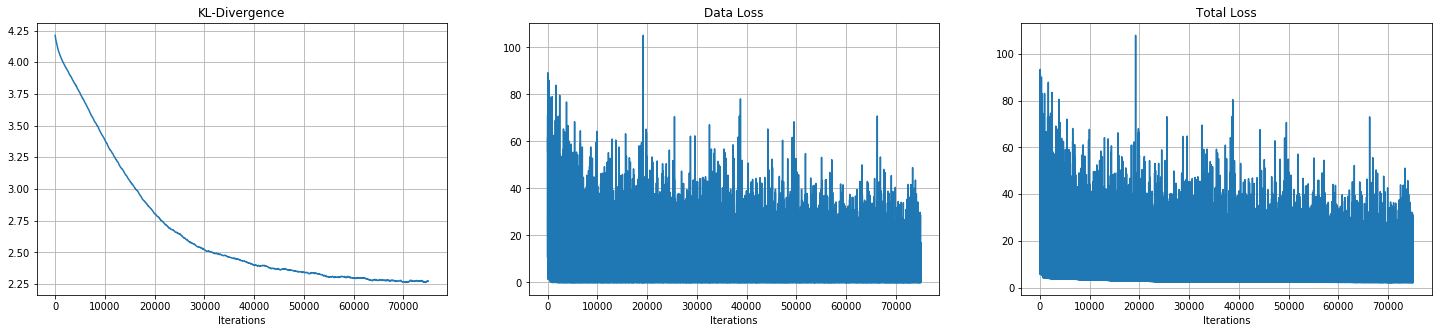

In [13]:
plt.clf()
plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(train_kl)
plt.grid('on')
plt.title('KL-Divergence')
plt.xlabel('Iterations')
plt.subplot(132)
plt.plot(train_data)
plt.grid('on')
plt.title('Data Loss')
plt.xlabel('Iterations')
plt.subplot(133)
plt.plot(train_tot)
plt.grid('on')
plt.title('Total Loss')
plt.xlabel('Iterations')

In [14]:
# torch.pow(torch.sum(torch.div(1*torch.ones(4,4),2*torch.ones((4,4)))),2)
# mu = torch.zeros((10,784)) + 0.05
# var = torch.ones((10,784))
# KL_Divergence(mu,var,prior_mu,prior_sigma)
# var = torch.ones((4,10,7))
# var.view(-1,10*7).shape